In [100]:
import numpy as np
import os
from sklearn.datasets import load_iris
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [101]:
class TwoLayerNeuralNetwork():
    '''
    a neural network with one hidden layer
    '''
    def __init__(self, input_size, hidden_size, output_size):
        '''
        initailize attributes W1, b1, W2, b2
        '''
        self.params = {}
        # W1: x --> hideen layer 
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.random.randn(hidden_size)
        # W2: hidden layer --> output layer
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.random.randn(output_size)
        
        self.input_size = input_size # 4
        self.output_size = output_size # 3
        self.hs = hidden_size 
        
        # (150 X 4) -> (4 X hidden unit) -> (hidden unit X 3)
        
    def init_data(self, X, t):
        '''
        학습 데이터 저장
        '''
        self.x = X
        self.t = t
     
    def sigmoid(self, z):
        '''
        activation function
        '''
        eMin = -np.log(np.finfo(type(0.1)).max)
        
        zSafe = np.array(np.maximum(z, eMin))
        return(1.0 / (1 + np.exp(-zSafe)))
    
    def softmax(self, x):
        '''
        softmax(identity function) for clasification
        softmax 적용해도 원소의 대소관계 변하지 않음 
        '''
        
        y = np.zeros_like(x)
        # X = 1차원일 경우 
        if x.ndim == 1:
            exp_a = np.exp(x - np.max(x))
            sum_exp_a = np.sum(exp_a)
            y = exp_a / sum_exp_a
        # X = 2차원일 경우
        else :
            for idx, x in enumerate(x):
                exp_a = np.exp(x - np.max(x))
                sum_exp_a = np.sum(exp_a)
                y[idx] = exp_a / sum_exp_a
        return y
    
    def cross_entropy(self, y, t):
        '''
        loss function , one-hot encoding
        '''
        #for batch 
        if y.ndim == 1:
            t = t.reshape(1, t.size)
            y = y.reshape(1, y.size)
    
        batch_size = y.shape[0]
        return -np.sum(t * np.log(y)) / batch_size 
        
    def predict(self, x):
        '''
        given input x, calculate output using current params : W1, b1, W2, b2
        data 들어오면 learn을 통해 갱신 해놓은 param을 이용하여 label 분류
        '''
        # input --> hidden layer
        z2 = np.dot(x, self.params['W1']) + self.params['b1']
        a2 = self.sigmoid(z2)
        # hidden layer --> output
        z3 = np.dot(a2, self.params['W2']) + self.params['b2']
        #print(z3)
        y = self.softmax(z3)
        return y
    
    def loss(self, x, t):
        '''
        x : input data, t : real label
        손실함수의 값(cost)을 구함
        '''
        y = self.predict(x)
        loss = self.cross_entropy(y, t)
        return loss
    
    def accuracy(self, x, t):
        '''
        모델의 정확도 측정
        '''
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # 예측 결과 가장 큰 확률은 갖는 index
        t = np.argmax(t, axis = 1) # one-hot encoding -> 1값을 갖는 index
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numer_grad(self, f, w):
        '''
        가중치가 W에 대한 loss function(=self.cross_entropy)의 기울기
         = 가중치가 W 일때 손실함수의 값이 어떻게 변하나 
        편미분한 행렬의 형상은 W와 같음
        '''
        # loss function의 각 W에서 편미분
        h = 1e-4 # 0.0001
        grad = np.zeros_like(w) #w와 형상이 같은 행렬
        
        # 1차원인 b가 인자로 들어왔을때
        if w.ndim == 1:
            for i in range(w.size):
                tmp = w[i]
                # f(x+h)
                w[i] = tmp + h
                xh1 = f(w)

                #f(x-h)
                w[i] = tmp - h
                xh2 = f(w)

                grad[i] = (xh1 - xh2) / (2*h)
                w[i] = tmp                 
        
        # 2차원 행렬인 W가 인자로 들어왔을때
        else: 
            for i in range(w.shape[0]):
                for j in range(w.shape[1]):
                    tmp = w[i][j]
                    # f(x+h)
                    w[i][j] = tmp + h
                    xh1 = f(w)

                    #f(x-h)
                    w[i][j] = tmp - h
                    xh2 = f(w)

                    grad[i][j] = (xh1 - xh2) / (2*h)
                    w[i][j] = tmp 

        return grad
        
    def numerical_gradient(self, x, t):
        '''
        각 layer의 가중치의 손실함수에 대한 기울기를 저장 
        '''
        f = lambda w : self.loss(x ,t)
        
        grad = {} # 기울기 저장
        # input -> hidden layer
        grad['W1'] = self.numer_grad(f, self.params['W1'])
        grad['b1'] = self.numer_grad(f, self.params['b1'])
        
        # hidden later -> output
        grad['W2'] = self.numer_grad(f, self.params['W2'])
        grad['b2'] = self.numer_grad(f, self.params['b2'])
        
        return grad
    
    def learn(self, batch, lr, epoch, file):
        '''
        학습데이터로 numerical gradient과정을 거쳐 cost값이 제일 작아지도록
        W를 갱신시킴 
        '''
        batch = min(batch, self.x.shape[0]) #self.x = train data
        cost_accrcy = np.zeros([epoch, 2]) #for plotting
        f = file
        
        for i in range(epoch):
            #print("epoch: ",i, "cost, accuracy: ", self.loss(self.x, self.t), self.accuracy(self.x, self.t))
            f.write("epoch: {} cost, accuracy: {}\t{}\n".format(i, self.loss(self.x, self.t), self.accuracy(self.x, self.t)))
            #plotting
            loss = self.loss(self.x, self.t)
            accrcy = self.accuracy(self.x, self.t)
            cost_accrcy[i] = loss, accrcy
              
            # 1 epoch = n iteration (n = 전체 데이터 크기 / 배치 크기)    
            for j in range(int(self.x.shape[0] / batch)):
                batch_mask = np.random.choice(self.x.shape[0], batch)
                x_batch = self.x[batch_mask]
                t_batch = self.t[batch_mask]

                #기울기 계산
                grad = self.numerical_gradient(x_batch, t_batch)

                #매개변수 갱신
                for key in ('W1', 'b1', 'W2', 'b2'):
                    self.params[key] -= lr * grad[key]
        
        #plotting 
        plt.plot(cost_accrcy)
        plt.xlabel(epoch)
        plt.legend(['cost', 'accrcy'])
        plt.title('batch_size ={} , hidden_size = {}, lr = {}, epoch = {}'.format(batch, self.hs, lr, epoch))
        #plt.show()
    
        plt.savefig('./twolayernn_pltimg/batch={},hidden={},lr={},ep={}.png'.format(batch, self.hs, lr, epoch))
        
        plt.clf()
    
                
        

In [102]:
'''iris = load_iris()
X = iris.data #150X4
t = iris.target #150
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size = 0.2)
X_train[0].shape

# one_hot encoding
num = np.unique(t_train, axis = 0)
num = num.shape[0]
t_train = np.eye(num)[t_train]

num2 = np.unique(t_test, axis = 0)
num2 = num2.shape[0]
t_test = np.eye(num2)[t_test]'''

In [105]:
'''hidden_layer = [5, 10]
epoch = [1000, 5000]
learning_rate = [0.001, 0.01]
batch_size = [40, 60, 120]'''

epoch:  0 cost, accuracy:  3.5169397145684202 0.35
epoch:  1 cost, accuracy:  3.509588490295383 0.35
epoch:  2 cost, accuracy:  3.50153998944639 0.35
epoch:  3 cost, accuracy:  3.4940816998738793 0.35
epoch:  4 cost, accuracy:  3.486902269397327 0.35
epoch:  5 cost, accuracy:  3.480149509148776 0.35
epoch:  6 cost, accuracy:  3.47231799317561 0.35
epoch:  7 cost, accuracy:  3.4657760598672573 0.35
epoch:  8 cost, accuracy:  3.4581279964852514 0.35
epoch:  9 cost, accuracy:  3.4501110662542156 0.35
epoch:  10 cost, accuracy:  3.44390845003819 0.35
epoch:  11 cost, accuracy:  3.436771128769395 0.35
epoch:  12 cost, accuracy:  3.4284481970353995 0.35
epoch:  13 cost, accuracy:  3.4217749229407 0.35
epoch:  14 cost, accuracy:  3.4140508893185313 0.35
epoch:  15 cost, accuracy:  3.406609652739669 0.35
epoch:  16 cost, accuracy:  3.3979831404266236 0.35
epoch:  17 cost, accuracy:  3.3897636462737393 0.35
epoch:  18 cost, accuracy:  3.381919867327603 0.35
epoch:  19 cost, accuracy:  3.3753725

epoch:  159 cost, accuracy:  2.32923661634568 0.35
epoch:  160 cost, accuracy:  2.321170011155228 0.35
epoch:  161 cost, accuracy:  2.3138070821411683 0.35
epoch:  162 cost, accuracy:  2.3061800777336297 0.35
epoch:  163 cost, accuracy:  2.297465584377157 0.35
epoch:  164 cost, accuracy:  2.2886828498807925 0.35
epoch:  165 cost, accuracy:  2.2804336480488616 0.35
epoch:  166 cost, accuracy:  2.272235253809588 0.35
epoch:  167 cost, accuracy:  2.2632279904670534 0.35
epoch:  168 cost, accuracy:  2.254537399226122 0.35
epoch:  169 cost, accuracy:  2.2459635229466217 0.35
epoch:  170 cost, accuracy:  2.237860666740093 0.35
epoch:  171 cost, accuracy:  2.22965792737287 0.35
epoch:  172 cost, accuracy:  2.2213847879711808 0.35
epoch:  173 cost, accuracy:  2.2124312483665936 0.35
epoch:  174 cost, accuracy:  2.203969614539262 0.35
epoch:  175 cost, accuracy:  2.1948797122855783 0.35
epoch:  176 cost, accuracy:  2.187201511699375 0.35
epoch:  177 cost, accuracy:  2.178709744526955 0.35
epoch

epoch:  315 cost, accuracy:  1.2669832576495268 0.35
epoch:  316 cost, accuracy:  1.2647635008151437 0.35
epoch:  317 cost, accuracy:  1.262357909012706 0.35
epoch:  318 cost, accuracy:  1.259912258983575 0.35
epoch:  319 cost, accuracy:  1.2572610834699531 0.35
epoch:  320 cost, accuracy:  1.254896278975949 0.35
epoch:  321 cost, accuracy:  1.2525535738954257 0.35
epoch:  322 cost, accuracy:  1.2503238951293023 0.35
epoch:  323 cost, accuracy:  1.2477660511809188 0.35
epoch:  324 cost, accuracy:  1.2457995888995828 0.35
epoch:  325 cost, accuracy:  1.2435780616460985 0.35
epoch:  326 cost, accuracy:  1.2411098049693192 0.35
epoch:  327 cost, accuracy:  1.2392328561058301 0.35
epoch:  328 cost, accuracy:  1.2372720917036995 0.35
epoch:  329 cost, accuracy:  1.235141642966274 0.35
epoch:  330 cost, accuracy:  1.2329897831604293 0.35
epoch:  331 cost, accuracy:  1.23109882090964 0.35
epoch:  332 cost, accuracy:  1.2291579127685432 0.35
epoch:  333 cost, accuracy:  1.22705177060045 0.35
e

epoch:  471 cost, accuracy:  1.056622903552863 0.35
epoch:  472 cost, accuracy:  1.0559182598167471 0.35
epoch:  473 cost, accuracy:  1.0551818214139204 0.35
epoch:  474 cost, accuracy:  1.0543823037592923 0.35
epoch:  475 cost, accuracy:  1.0537182939182412 0.35
epoch:  476 cost, accuracy:  1.0530564057004552 0.35
epoch:  477 cost, accuracy:  1.0523228816630021 0.35
epoch:  478 cost, accuracy:  1.0515885546957944 0.35
epoch:  479 cost, accuracy:  1.0506205441960839 0.35
epoch:  480 cost, accuracy:  1.0498272830025712 0.35
epoch:  481 cost, accuracy:  1.0489160957649868 0.35
epoch:  482 cost, accuracy:  1.048147556242469 0.35
epoch:  483 cost, accuracy:  1.0473920067768785 0.35
epoch:  484 cost, accuracy:  1.0466581773144028 0.35
epoch:  485 cost, accuracy:  1.046044935043841 0.35
epoch:  486 cost, accuracy:  1.0452239888115644 0.35
epoch:  487 cost, accuracy:  1.0445284964186154 0.35
epoch:  488 cost, accuracy:  1.0440616221244652 0.35
epoch:  489 cost, accuracy:  1.0434055765011974 0

epoch:  626 cost, accuracy:  0.9783880919724164 0.35
epoch:  627 cost, accuracy:  0.9779977102665657 0.35
epoch:  628 cost, accuracy:  0.9776403946326689 0.35
epoch:  629 cost, accuracy:  0.977305813495614 0.35
epoch:  630 cost, accuracy:  0.9770752557504746 0.35
epoch:  631 cost, accuracy:  0.9765783721969926 0.35
epoch:  632 cost, accuracy:  0.9762757664191153 0.35
epoch:  633 cost, accuracy:  0.9759895753435264 0.35
epoch:  634 cost, accuracy:  0.9755914208981864 0.35
epoch:  635 cost, accuracy:  0.9751834364826446 0.35
epoch:  636 cost, accuracy:  0.9748507906382845 0.35
epoch:  637 cost, accuracy:  0.9744928110881713 0.35
epoch:  638 cost, accuracy:  0.9742438994992941 0.35
epoch:  639 cost, accuracy:  0.9738979236496296 0.35
epoch:  640 cost, accuracy:  0.9736343383594348 0.35
epoch:  641 cost, accuracy:  0.973448895963721 0.35
epoch:  642 cost, accuracy:  0.9731614614725002 0.35
epoch:  643 cost, accuracy:  0.9729384362555039 0.35
epoch:  644 cost, accuracy:  0.9724575323603241 

epoch:  779 cost, accuracy:  0.938202110969814 0.36666666666666664
epoch:  780 cost, accuracy:  0.9380188163678262 0.36666666666666664
epoch:  781 cost, accuracy:  0.93782035880847 0.38333333333333336
epoch:  782 cost, accuracy:  0.9376563370490568 0.38333333333333336
epoch:  783 cost, accuracy:  0.9374772507809173 0.38333333333333336
epoch:  784 cost, accuracy:  0.9372560373122136 0.4
epoch:  785 cost, accuracy:  0.9370533572457683 0.4
epoch:  786 cost, accuracy:  0.9368326291830443 0.4
epoch:  787 cost, accuracy:  0.9366223287942733 0.4083333333333333
epoch:  788 cost, accuracy:  0.9364482754765947 0.4083333333333333
epoch:  789 cost, accuracy:  0.9361975857505033 0.4083333333333333
epoch:  790 cost, accuracy:  0.9359463948029971 0.4083333333333333
epoch:  791 cost, accuracy:  0.9357803883570935 0.4083333333333333
epoch:  792 cost, accuracy:  0.9356043669228338 0.4166666666666667
epoch:  793 cost, accuracy:  0.9354420892979445 0.4166666666666667
epoch:  794 cost, accuracy:  0.9352670

epoch:  910 cost, accuracy:  0.9148151108095592 0.6166666666666667
epoch:  911 cost, accuracy:  0.9146653184319365 0.6166666666666667
epoch:  912 cost, accuracy:  0.9145102950731739 0.6166666666666667
epoch:  913 cost, accuracy:  0.9143377424967978 0.6166666666666667
epoch:  914 cost, accuracy:  0.914181935231737 0.6166666666666667
epoch:  915 cost, accuracy:  0.914029673682802 0.6166666666666667
epoch:  916 cost, accuracy:  0.9139072212339191 0.6166666666666667
epoch:  917 cost, accuracy:  0.9137782459779829 0.6333333333333333
epoch:  918 cost, accuracy:  0.9136027595712357 0.6333333333333333
epoch:  919 cost, accuracy:  0.9135254085340432 0.6333333333333333
epoch:  920 cost, accuracy:  0.9133907466062845 0.6333333333333333
epoch:  921 cost, accuracy:  0.9132487542492124 0.6333333333333333
epoch:  922 cost, accuracy:  0.9130877496930739 0.6333333333333333
epoch:  923 cost, accuracy:  0.9129383783026124 0.6333333333333333
epoch:  924 cost, accuracy:  0.9127800433554538 0.64166666666666

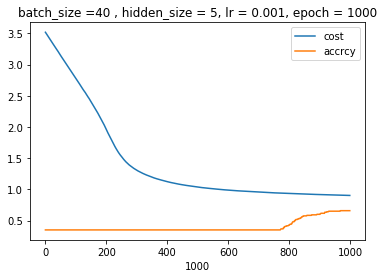

Training Accuracy:  0.6583333333333333
Test Accuracy:  0.6333333333333333
epoch:  0 cost, accuracy:  1.1807133423538472 0.325
epoch:  1 cost, accuracy:  1.17872543076706 0.325
epoch:  2 cost, accuracy:  1.1763240602652636 0.325
epoch:  3 cost, accuracy:  1.1737629712811328 0.325
epoch:  4 cost, accuracy:  1.1720058749648283 0.325
epoch:  5 cost, accuracy:  1.1695061366908144 0.325
epoch:  6 cost, accuracy:  1.1673288260943409 0.325
epoch:  7 cost, accuracy:  1.1655283504713922 0.325
epoch:  8 cost, accuracy:  1.163623362793665 0.325
epoch:  9 cost, accuracy:  1.1615996667518824 0.325
epoch:  10 cost, accuracy:  1.15954096519354 0.325
epoch:  11 cost, accuracy:  1.1578529400983841 0.325
epoch:  12 cost, accuracy:  1.1556768670454933 0.325
epoch:  13 cost, accuracy:  1.1540019434480697 0.325
epoch:  14 cost, accuracy:  1.1520697111375184 0.325
epoch:  15 cost, accuracy:  1.150113030102763 0.325
epoch:  16 cost, accuracy:  1.1481813938818917 0.325
epoch:  17 cost, accuracy:  1.14627287284

epoch:  140 cost, accuracy:  0.9675511248987883 0.4166666666666667
epoch:  141 cost, accuracy:  0.9666453726034134 0.4166666666666667
epoch:  142 cost, accuracy:  0.9657689779722799 0.425
epoch:  143 cost, accuracy:  0.9646652952915117 0.43333333333333335
epoch:  144 cost, accuracy:  0.963602344728001 0.44166666666666665
epoch:  145 cost, accuracy:  0.9623463076023581 0.44166666666666665
epoch:  146 cost, accuracy:  0.9615645293507583 0.45
epoch:  147 cost, accuracy:  0.9606769191822001 0.4583333333333333
epoch:  148 cost, accuracy:  0.9597247596338971 0.475
epoch:  149 cost, accuracy:  0.9589980760478162 0.475
epoch:  150 cost, accuracy:  0.9579640375207845 0.48333333333333334
epoch:  151 cost, accuracy:  0.9569542022855434 0.48333333333333334
epoch:  152 cost, accuracy:  0.9558282840986041 0.48333333333333334
epoch:  153 cost, accuracy:  0.9548052029382906 0.48333333333333334
epoch:  154 cost, accuracy:  0.9542202101827809 0.49166666666666664
epoch:  155 cost, accuracy:  0.9533441867

epoch:  275 cost, accuracy:  0.8680435558547324 0.675
epoch:  276 cost, accuracy:  0.8674648289590076 0.675
epoch:  277 cost, accuracy:  0.8670640027960866 0.675
epoch:  278 cost, accuracy:  0.8665669075458301 0.675
epoch:  279 cost, accuracy:  0.8660925856554265 0.675
epoch:  280 cost, accuracy:  0.8656158767018705 0.675
epoch:  281 cost, accuracy:  0.8650867943264521 0.675
epoch:  282 cost, accuracy:  0.864693481002474 0.675
epoch:  283 cost, accuracy:  0.8642640417586543 0.675
epoch:  284 cost, accuracy:  0.8636640478484012 0.675
epoch:  285 cost, accuracy:  0.863080671956628 0.675
epoch:  286 cost, accuracy:  0.8626265254679718 0.675
epoch:  287 cost, accuracy:  0.862160568524277 0.675
epoch:  288 cost, accuracy:  0.8616513594642418 0.675
epoch:  289 cost, accuracy:  0.8612529500294952 0.675
epoch:  290 cost, accuracy:  0.8608080743432843 0.675
epoch:  291 cost, accuracy:  0.8604603912244322 0.675
epoch:  292 cost, accuracy:  0.8599446633489733 0.675
epoch:  293 cost, accuracy:  0.

epoch:  427 cost, accuracy:  0.8128355252793192 0.6666666666666666
epoch:  428 cost, accuracy:  0.8125561151002967 0.6666666666666666
epoch:  429 cost, accuracy:  0.8122769361708905 0.6666666666666666
epoch:  430 cost, accuracy:  0.8120180809795357 0.6583333333333333
epoch:  431 cost, accuracy:  0.8117329281528356 0.6583333333333333
epoch:  432 cost, accuracy:  0.8114413628956847 0.6583333333333333
epoch:  433 cost, accuracy:  0.8111333222585588 0.6583333333333333
epoch:  434 cost, accuracy:  0.8108705505197117 0.6583333333333333
epoch:  435 cost, accuracy:  0.8105883623422209 0.6583333333333333
epoch:  436 cost, accuracy:  0.8103510348465528 0.6583333333333333
epoch:  437 cost, accuracy:  0.8100821396102662 0.6583333333333333
epoch:  438 cost, accuracy:  0.8097598763575877 0.6583333333333333
epoch:  439 cost, accuracy:  0.8094946650403192 0.6583333333333333
epoch:  440 cost, accuracy:  0.8092693407128124 0.6583333333333333
epoch:  441 cost, accuracy:  0.8089685911437868 0.658333333333

epoch:  555 cost, accuracy:  0.7831120254939428 0.6083333333333333
epoch:  556 cost, accuracy:  0.7829121398549622 0.6083333333333333
epoch:  557 cost, accuracy:  0.782709897242272 0.6083333333333333
epoch:  558 cost, accuracy:  0.7825108835148622 0.6083333333333333
epoch:  559 cost, accuracy:  0.7823239538242975 0.6083333333333333
epoch:  560 cost, accuracy:  0.7821329234917963 0.6083333333333333
epoch:  561 cost, accuracy:  0.781927998492989 0.6083333333333333
epoch:  562 cost, accuracy:  0.7817341258809615 0.6083333333333333
epoch:  563 cost, accuracy:  0.7815533681944605 0.6083333333333333
epoch:  564 cost, accuracy:  0.7813510493898715 0.6083333333333333
epoch:  565 cost, accuracy:  0.7811503222875926 0.6083333333333333
epoch:  566 cost, accuracy:  0.7809462668467778 0.6
epoch:  567 cost, accuracy:  0.780734173822451 0.6
epoch:  568 cost, accuracy:  0.7805643919397326 0.6083333333333333
epoch:  569 cost, accuracy:  0.7803910022187065 0.6
epoch:  570 cost, accuracy:  0.780183372282

epoch:  695 cost, accuracy:  0.7587553564709938 0.4666666666666667
epoch:  696 cost, accuracy:  0.7586031592730137 0.475
epoch:  697 cost, accuracy:  0.7584476304200938 0.475
epoch:  698 cost, accuracy:  0.7582883061646164 0.475
epoch:  699 cost, accuracy:  0.7581313323882165 0.475
epoch:  700 cost, accuracy:  0.75797479493481 0.475
epoch:  701 cost, accuracy:  0.757816291888521 0.475
epoch:  702 cost, accuracy:  0.7576517644283349 0.475
epoch:  703 cost, accuracy:  0.7574964942329666 0.48333333333333334
epoch:  704 cost, accuracy:  0.7573468013364528 0.48333333333333334
epoch:  705 cost, accuracy:  0.7571864484908398 0.48333333333333334
epoch:  706 cost, accuracy:  0.7570368211102486 0.48333333333333334
epoch:  707 cost, accuracy:  0.7568900273279678 0.48333333333333334
epoch:  708 cost, accuracy:  0.7567283996033062 0.48333333333333334
epoch:  709 cost, accuracy:  0.7565815635660803 0.48333333333333334
epoch:  710 cost, accuracy:  0.7564344946477317 0.48333333333333334
epoch:  711 co

epoch:  826 cost, accuracy:  0.7401356282980777 0.4666666666666667
epoch:  827 cost, accuracy:  0.740006108693203 0.4666666666666667
epoch:  828 cost, accuracy:  0.7398766821302272 0.4666666666666667
epoch:  829 cost, accuracy:  0.7397418897466008 0.4666666666666667
epoch:  830 cost, accuracy:  0.7396119046788208 0.4583333333333333
epoch:  831 cost, accuracy:  0.7394812635916346 0.4666666666666667
epoch:  832 cost, accuracy:  0.7393514997553842 0.4666666666666667
epoch:  833 cost, accuracy:  0.7392260294241098 0.4666666666666667
epoch:  834 cost, accuracy:  0.7390998068977732 0.4666666666666667
epoch:  835 cost, accuracy:  0.738973074883739 0.4666666666666667
epoch:  836 cost, accuracy:  0.7388431490235177 0.4666666666666667
epoch:  837 cost, accuracy:  0.7387143754493304 0.475
epoch:  838 cost, accuracy:  0.7385874059764067 0.4666666666666667
epoch:  839 cost, accuracy:  0.738469320034202 0.475
epoch:  840 cost, accuracy:  0.7383396164952167 0.49166666666666664
epoch:  841 cost, accur

epoch:  952 cost, accuracy:  0.7249933649062829 0.49166666666666664
epoch:  953 cost, accuracy:  0.7248782907282882 0.49166666666666664
epoch:  954 cost, accuracy:  0.724767136075307 0.49166666666666664
epoch:  955 cost, accuracy:  0.7246547243378222 0.49166666666666664
epoch:  956 cost, accuracy:  0.724549828462305 0.49166666666666664
epoch:  957 cost, accuracy:  0.7244386642194826 0.49166666666666664
epoch:  958 cost, accuracy:  0.7243276180568309 0.49166666666666664
epoch:  959 cost, accuracy:  0.7242116086289005 0.49166666666666664
epoch:  960 cost, accuracy:  0.7240942825063112 0.49166666666666664
epoch:  961 cost, accuracy:  0.7239799000538732 0.49166666666666664
epoch:  962 cost, accuracy:  0.7238625472269538 0.49166666666666664
epoch:  963 cost, accuracy:  0.7237460284569714 0.49166666666666664
epoch:  964 cost, accuracy:  0.723634584872455 0.49166666666666664
epoch:  965 cost, accuracy:  0.7235234301694473 0.48333333333333334
epoch:  966 cost, accuracy:  0.7234150893965854 0.4

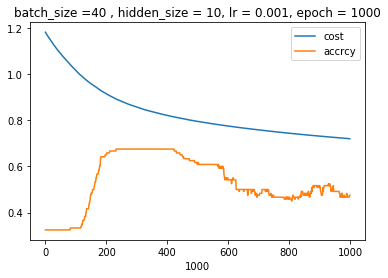

Training Accuracy:  0.48333333333333334
Test Accuracy:  0.36666666666666664
epoch:  0 cost, accuracy:  1.9219251601530862 0.35
epoch:  1 cost, accuracy:  1.9043488777585411 0.35
epoch:  2 cost, accuracy:  1.889054178157435 0.35
epoch:  3 cost, accuracy:  1.8710266320471036 0.35
epoch:  4 cost, accuracy:  1.8561685257063512 0.35
epoch:  5 cost, accuracy:  1.8404886810467125 0.35
epoch:  6 cost, accuracy:  1.8277221103023806 0.35
epoch:  7 cost, accuracy:  1.814565028126491 0.35
epoch:  8 cost, accuracy:  1.8041961147747283 0.35
epoch:  9 cost, accuracy:  1.7892627050143999 0.35
epoch:  10 cost, accuracy:  1.776946859201555 0.35
epoch:  11 cost, accuracy:  1.764427307236098 0.35
epoch:  12 cost, accuracy:  1.7524710415587523 0.35
epoch:  13 cost, accuracy:  1.7399193983532717 0.35
epoch:  14 cost, accuracy:  1.7280236814658665 0.35
epoch:  15 cost, accuracy:  1.7171421885042766 0.35
epoch:  16 cost, accuracy:  1.7071130472390492 0.35
epoch:  17 cost, accuracy:  1.6959992143969245 0.35
ep

epoch:  156 cost, accuracy:  1.1479211848618642 0.35
epoch:  157 cost, accuracy:  1.1461530707871994 0.35
epoch:  158 cost, accuracy:  1.1443825700903076 0.35
epoch:  159 cost, accuracy:  1.14261336793138 0.35
epoch:  160 cost, accuracy:  1.1407342946297794 0.35
epoch:  161 cost, accuracy:  1.1393482178219012 0.35
epoch:  162 cost, accuracy:  1.1374261888244352 0.35
epoch:  163 cost, accuracy:  1.135536377092406 0.35
epoch:  164 cost, accuracy:  1.1337620342808272 0.35
epoch:  165 cost, accuracy:  1.1320948874999501 0.35
epoch:  166 cost, accuracy:  1.1304374035564033 0.35
epoch:  167 cost, accuracy:  1.1287402506727053 0.35
epoch:  168 cost, accuracy:  1.1271462357871342 0.35
epoch:  169 cost, accuracy:  1.1254186147650904 0.35
epoch:  170 cost, accuracy:  1.123143105744068 0.35
epoch:  171 cost, accuracy:  1.121677516128092 0.35
epoch:  172 cost, accuracy:  1.1198324711901557 0.35
epoch:  173 cost, accuracy:  1.1182322277962362 0.35
epoch:  174 cost, accuracy:  1.1167699484183469 0.3

epoch:  312 cost, accuracy:  0.9437534427733676 0.35
epoch:  313 cost, accuracy:  0.9429239762174405 0.35
epoch:  314 cost, accuracy:  0.9419587816121343 0.35
epoch:  315 cost, accuracy:  0.9409382578800347 0.35
epoch:  316 cost, accuracy:  0.9401451088872382 0.35
epoch:  317 cost, accuracy:  0.939183968769894 0.35
epoch:  318 cost, accuracy:  0.938047181821745 0.35
epoch:  319 cost, accuracy:  0.9374117300481857 0.35
epoch:  320 cost, accuracy:  0.9366098309662765 0.35
epoch:  321 cost, accuracy:  0.9357910883127588 0.35
epoch:  322 cost, accuracy:  0.9350021576050048 0.35
epoch:  323 cost, accuracy:  0.9340222792324655 0.35
epoch:  324 cost, accuracy:  0.933326854386043 0.35
epoch:  325 cost, accuracy:  0.9325859697636552 0.35
epoch:  326 cost, accuracy:  0.9316776647019436 0.35
epoch:  327 cost, accuracy:  0.9307360003581514 0.35
epoch:  328 cost, accuracy:  0.9297771079637764 0.35
epoch:  329 cost, accuracy:  0.9288429796606272 0.35
epoch:  330 cost, accuracy:  0.9280868786459656 0

epoch:  451 cost, accuracy:  0.8484358854651572 0.675
epoch:  452 cost, accuracy:  0.8479468681135799 0.675
epoch:  453 cost, accuracy:  0.8474905234391146 0.675
epoch:  454 cost, accuracy:  0.8470092654114167 0.675
epoch:  455 cost, accuracy:  0.8464527924726256 0.675
epoch:  456 cost, accuracy:  0.8459478572863228 0.675
epoch:  457 cost, accuracy:  0.8454579481117828 0.675
epoch:  458 cost, accuracy:  0.8448886558833454 0.675
epoch:  459 cost, accuracy:  0.8444187205120159 0.675
epoch:  460 cost, accuracy:  0.8438839727000708 0.675
epoch:  461 cost, accuracy:  0.8433269189020811 0.675
epoch:  462 cost, accuracy:  0.8428041770461306 0.675
epoch:  463 cost, accuracy:  0.8424368785524924 0.675
epoch:  464 cost, accuracy:  0.84186650603598 0.675
epoch:  465 cost, accuracy:  0.8413584103124202 0.675
epoch:  466 cost, accuracy:  0.8408177921128919 0.675
epoch:  467 cost, accuracy:  0.8403298268930528 0.675
epoch:  468 cost, accuracy:  0.8398004573243834 0.675
epoch:  469 cost, accuracy:  0

epoch:  596 cost, accuracy:  0.7862737727164907 0.7583333333333333
epoch:  597 cost, accuracy:  0.7859346428741906 0.7583333333333333
epoch:  598 cost, accuracy:  0.7856542241655988 0.7583333333333333
epoch:  599 cost, accuracy:  0.7852976782713263 0.7583333333333333
epoch:  600 cost, accuracy:  0.7849771003682835 0.7583333333333333
epoch:  601 cost, accuracy:  0.7845934131902662 0.7666666666666667
epoch:  602 cost, accuracy:  0.7842717711203804 0.7666666666666667
epoch:  603 cost, accuracy:  0.7839033882995042 0.7833333333333333
epoch:  604 cost, accuracy:  0.7835748879322925 0.7833333333333333
epoch:  605 cost, accuracy:  0.783254319242436 0.7833333333333333
epoch:  606 cost, accuracy:  0.7829560822346514 0.7833333333333333
epoch:  607 cost, accuracy:  0.7826166249729662 0.7833333333333333
epoch:  608 cost, accuracy:  0.7822861158406996 0.7833333333333333
epoch:  609 cost, accuracy:  0.7819953952402247 0.7833333333333333
epoch:  610 cost, accuracy:  0.7816195138241291 0.7833333333333

epoch:  726 cost, accuracy:  0.746895674386092 0.8333333333333334
epoch:  727 cost, accuracy:  0.7466266926523186 0.8416666666666667
epoch:  728 cost, accuracy:  0.7463385937418909 0.8416666666666667
epoch:  729 cost, accuracy:  0.7460740220050556 0.8416666666666667
epoch:  730 cost, accuracy:  0.745812585354 0.8416666666666667
epoch:  731 cost, accuracy:  0.7455467161736945 0.8416666666666667
epoch:  732 cost, accuracy:  0.7452954256756951 0.8416666666666667
epoch:  733 cost, accuracy:  0.7450565938196786 0.8416666666666667
epoch:  734 cost, accuracy:  0.7447881693237314 0.8416666666666667
epoch:  735 cost, accuracy:  0.7445144698408238 0.85
epoch:  736 cost, accuracy:  0.7442547944042592 0.85
epoch:  737 cost, accuracy:  0.7439826341322447 0.85
epoch:  738 cost, accuracy:  0.7437377542732511 0.85
epoch:  739 cost, accuracy:  0.7434555600512193 0.85
epoch:  740 cost, accuracy:  0.7431631506301277 0.85
epoch:  741 cost, accuracy:  0.7429032883762602 0.85
epoch:  742 cost, accuracy:  0.

epoch:  863 cost, accuracy:  0.713011111104614 0.9083333333333333
epoch:  864 cost, accuracy:  0.7127980688292507 0.9083333333333333
epoch:  865 cost, accuracy:  0.7125649302109086 0.9166666666666666
epoch:  866 cost, accuracy:  0.7123348758360794 0.9166666666666666
epoch:  867 cost, accuracy:  0.7121184340083863 0.9083333333333333
epoch:  868 cost, accuracy:  0.7118906449120888 0.9083333333333333
epoch:  869 cost, accuracy:  0.7116765675469705 0.9083333333333333
epoch:  870 cost, accuracy:  0.7114600163040897 0.9083333333333333
epoch:  871 cost, accuracy:  0.7112168627715281 0.9166666666666666
epoch:  872 cost, accuracy:  0.710999907739835 0.9083333333333333
epoch:  873 cost, accuracy:  0.7107776036104205 0.9083333333333333
epoch:  874 cost, accuracy:  0.7105585221562449 0.9083333333333333
epoch:  875 cost, accuracy:  0.710323411771215 0.9166666666666666
epoch:  876 cost, accuracy:  0.7100963370124165 0.9083333333333333
epoch:  877 cost, accuracy:  0.7098769159618106 0.916666666666666

epoch:  990 cost, accuracy:  0.6863605060458615 0.9416666666666667
epoch:  991 cost, accuracy:  0.6861666809537941 0.9416666666666667
epoch:  992 cost, accuracy:  0.6859752280234731 0.9333333333333333
epoch:  993 cost, accuracy:  0.6857813188896084 0.925
epoch:  994 cost, accuracy:  0.6855870704776557 0.925
epoch:  995 cost, accuracy:  0.6853902597823287 0.9333333333333333
epoch:  996 cost, accuracy:  0.6851966145753994 0.925
epoch:  997 cost, accuracy:  0.6849978038262402 0.925
epoch:  998 cost, accuracy:  0.6847997996871605 0.925
epoch:  999 cost, accuracy:  0.6846091450155712 0.9333333333333333
epoch:  1000 cost, accuracy:  0.6844147778409206 0.925
epoch:  1001 cost, accuracy:  0.6842273865949394 0.925
epoch:  1002 cost, accuracy:  0.6840374707098272 0.925
epoch:  1003 cost, accuracy:  0.683839685403111 0.9333333333333333
epoch:  1004 cost, accuracy:  0.6836440249443736 0.9416666666666667
epoch:  1005 cost, accuracy:  0.6834468260870369 0.9416666666666667
epoch:  1006 cost, accuracy

epoch:  1113 cost, accuracy:  0.6635401997050029 0.9416666666666667
epoch:  1114 cost, accuracy:  0.6633633734532889 0.9416666666666667
epoch:  1115 cost, accuracy:  0.663186965286751 0.9416666666666667
epoch:  1116 cost, accuracy:  0.6630069808014131 0.9416666666666667
epoch:  1117 cost, accuracy:  0.6628332766414978 0.9416666666666667
epoch:  1118 cost, accuracy:  0.6626574553134958 0.9416666666666667
epoch:  1119 cost, accuracy:  0.662483066346677 0.9416666666666667
epoch:  1120 cost, accuracy:  0.6623074022476751 0.9416666666666667
epoch:  1121 cost, accuracy:  0.6621342107980633 0.9416666666666667
epoch:  1122 cost, accuracy:  0.6619601989010644 0.9416666666666667
epoch:  1123 cost, accuracy:  0.661786843827335 0.9416666666666667
epoch:  1124 cost, accuracy:  0.6616108961404888 0.9416666666666667
epoch:  1125 cost, accuracy:  0.661435306861279 0.9416666666666667
epoch:  1126 cost, accuracy:  0.6612574562961214 0.9416666666666667
epoch:  1127 cost, accuracy:  0.6610854871589467 0.9

epoch:  1235 cost, accuracy:  0.6430587071332626 0.9416666666666667
epoch:  1236 cost, accuracy:  0.6428990318945687 0.9416666666666667
epoch:  1237 cost, accuracy:  0.6427375531823929 0.9416666666666667
epoch:  1238 cost, accuracy:  0.6425765597378617 0.9416666666666667
epoch:  1239 cost, accuracy:  0.6424156117387023 0.9416666666666667
epoch:  1240 cost, accuracy:  0.6422561940194579 0.9416666666666667
epoch:  1241 cost, accuracy:  0.6420981092302436 0.9416666666666667
epoch:  1242 cost, accuracy:  0.641939683050032 0.9416666666666667
epoch:  1243 cost, accuracy:  0.641779594572944 0.95
epoch:  1244 cost, accuracy:  0.6416202607572603 0.95
epoch:  1245 cost, accuracy:  0.6414612154412241 0.95
epoch:  1246 cost, accuracy:  0.6413024794779129 0.95
epoch:  1247 cost, accuracy:  0.6411467096269391 0.95
epoch:  1248 cost, accuracy:  0.6409891898361532 0.95
epoch:  1249 cost, accuracy:  0.6408318173787186 0.95
epoch:  1250 cost, accuracy:  0.6406720941008667 0.95
epoch:  1251 cost, accurac

epoch:  1379 cost, accuracy:  0.6211692974759193 0.95
epoch:  1380 cost, accuracy:  0.6210228399520988 0.95
epoch:  1381 cost, accuracy:  0.6208788236924438 0.95
epoch:  1382 cost, accuracy:  0.6207356743844272 0.95
epoch:  1383 cost, accuracy:  0.6205879763503942 0.95
epoch:  1384 cost, accuracy:  0.6204423567368362 0.95
epoch:  1385 cost, accuracy:  0.6202995325046666 0.95
epoch:  1386 cost, accuracy:  0.6201543408361051 0.95
epoch:  1387 cost, accuracy:  0.6200083897256937 0.95
epoch:  1388 cost, accuracy:  0.619865216877537 0.95
epoch:  1389 cost, accuracy:  0.6197200863534692 0.95
epoch:  1390 cost, accuracy:  0.619576689518553 0.95
epoch:  1391 cost, accuracy:  0.6194338089487658 0.95
epoch:  1392 cost, accuracy:  0.6192905269355781 0.95
epoch:  1393 cost, accuracy:  0.6191467870588986 0.95
epoch:  1394 cost, accuracy:  0.6190038077326446 0.95
epoch:  1395 cost, accuracy:  0.6188596838346248 0.95
epoch:  1396 cost, accuracy:  0.6187168804748441 0.95
epoch:  1397 cost, accuracy:  

epoch:  1513 cost, accuracy:  0.6025431721761026 0.9666666666666667
epoch:  1514 cost, accuracy:  0.6024089255845192 0.9666666666666667
epoch:  1515 cost, accuracy:  0.6022758961300387 0.9666666666666667
epoch:  1516 cost, accuracy:  0.6021394262915869 0.9583333333333334
epoch:  1517 cost, accuracy:  0.6020029388813574 0.9583333333333334
epoch:  1518 cost, accuracy:  0.6018702747062185 0.9583333333333334
epoch:  1519 cost, accuracy:  0.6017373434270873 0.9583333333333334
epoch:  1520 cost, accuracy:  0.6016039103310732 0.9666666666666667
epoch:  1521 cost, accuracy:  0.6014724360640078 0.9666666666666667
epoch:  1522 cost, accuracy:  0.6013414070840287 0.9583333333333334
epoch:  1523 cost, accuracy:  0.601207721313037 0.9666666666666667
epoch:  1524 cost, accuracy:  0.6010761515057834 0.9583333333333334
epoch:  1525 cost, accuracy:  0.6009435299066375 0.9583333333333334
epoch:  1526 cost, accuracy:  0.6008089454238937 0.9583333333333334
epoch:  1527 cost, accuracy:  0.6006756004350824 

epoch:  1634 cost, accuracy:  0.5869005187000507 0.9666666666666667
epoch:  1635 cost, accuracy:  0.5867730761032653 0.9666666666666667
epoch:  1636 cost, accuracy:  0.586649762073264 0.9666666666666667
epoch:  1637 cost, accuracy:  0.5865192825451762 0.9666666666666667
epoch:  1638 cost, accuracy:  0.5863946846143513 0.9666666666666667
epoch:  1639 cost, accuracy:  0.5862689902881528 0.9666666666666667
epoch:  1640 cost, accuracy:  0.5861456644613556 0.9666666666666667
epoch:  1641 cost, accuracy:  0.5860215387434871 0.9666666666666667
epoch:  1642 cost, accuracy:  0.5858940306636621 0.9666666666666667
epoch:  1643 cost, accuracy:  0.5857712707765297 0.9666666666666667
epoch:  1644 cost, accuracy:  0.5856464920750286 0.9666666666666667
epoch:  1645 cost, accuracy:  0.5855193884973703 0.9666666666666667
epoch:  1646 cost, accuracy:  0.5853948705065846 0.9666666666666667
epoch:  1647 cost, accuracy:  0.5852691652687325 0.9666666666666667
epoch:  1648 cost, accuracy:  0.5851442351743411 

epoch:  1755 cost, accuracy:  0.5722370736028365 0.9583333333333334
epoch:  1756 cost, accuracy:  0.5721182332027082 0.9583333333333334
epoch:  1757 cost, accuracy:  0.5720014731861219 0.9583333333333334
epoch:  1758 cost, accuracy:  0.5718836719129422 0.9583333333333334
epoch:  1759 cost, accuracy:  0.5717673521319969 0.9583333333333334
epoch:  1760 cost, accuracy:  0.5716492208308258 0.9583333333333334
epoch:  1761 cost, accuracy:  0.5715296707244455 0.9583333333333334
epoch:  1762 cost, accuracy:  0.5714086831152294 0.9583333333333334
epoch:  1763 cost, accuracy:  0.5712918906265549 0.9583333333333334
epoch:  1764 cost, accuracy:  0.5711744803388236 0.9583333333333334
epoch:  1765 cost, accuracy:  0.5710586484418173 0.9583333333333334
epoch:  1766 cost, accuracy:  0.570945163347882 0.9583333333333334
epoch:  1767 cost, accuracy:  0.5708281484696315 0.9583333333333334
epoch:  1768 cost, accuracy:  0.5707106532467734 0.9583333333333334
epoch:  1769 cost, accuracy:  0.5705931357078746 

epoch:  1876 cost, accuracy:  0.5583897363783633 0.9666666666666667
epoch:  1877 cost, accuracy:  0.5582813239319366 0.9666666666666667
epoch:  1878 cost, accuracy:  0.5581663489879776 0.9666666666666667
epoch:  1879 cost, accuracy:  0.5580547580101622 0.9666666666666667
epoch:  1880 cost, accuracy:  0.5579440035046942 0.9666666666666667
epoch:  1881 cost, accuracy:  0.5578351920250405 0.9666666666666667
epoch:  1882 cost, accuracy:  0.5577262116710388 0.9666666666666667
epoch:  1883 cost, accuracy:  0.5576115534816662 0.9666666666666667
epoch:  1884 cost, accuracy:  0.5575020261315603 0.9666666666666667
epoch:  1885 cost, accuracy:  0.5573898685929943 0.9666666666666667
epoch:  1886 cost, accuracy:  0.5572786928368554 0.9666666666666667
epoch:  1887 cost, accuracy:  0.5571664802427566 0.9666666666666667
epoch:  1888 cost, accuracy:  0.5570555752241693 0.9666666666666667
epoch:  1889 cost, accuracy:  0.5569449239416111 0.9666666666666667
epoch:  1890 cost, accuracy:  0.556834093563625 

epoch:  1997 cost, accuracy:  0.5452825538938053 0.9666666666666667
epoch:  1998 cost, accuracy:  0.5451785347861104 0.9666666666666667
epoch:  1999 cost, accuracy:  0.545068109370203 0.9666666666666667
epoch:  2000 cost, accuracy:  0.5449611118367239 0.9666666666666667
epoch:  2001 cost, accuracy:  0.544852385406273 0.9666666666666667
epoch:  2002 cost, accuracy:  0.5447462780519791 0.9666666666666667
epoch:  2003 cost, accuracy:  0.5446428108028966 0.9666666666666667
epoch:  2004 cost, accuracy:  0.5445350218976375 0.9666666666666667
epoch:  2005 cost, accuracy:  0.544431354156629 0.9666666666666667
epoch:  2006 cost, accuracy:  0.5443239160928551 0.9666666666666667
epoch:  2007 cost, accuracy:  0.5442175933823978 0.9666666666666667
epoch:  2008 cost, accuracy:  0.544114233140126 0.9666666666666667
epoch:  2009 cost, accuracy:  0.5440099821043164 0.9666666666666667
epoch:  2010 cost, accuracy:  0.5439068875288489 0.9666666666666667
epoch:  2011 cost, accuracy:  0.5437995746516713 0.9

epoch:  2118 cost, accuracy:  0.5327721025050925 0.9666666666666667
epoch:  2119 cost, accuracy:  0.5326731799616354 0.9666666666666667
epoch:  2120 cost, accuracy:  0.5325760068142513 0.9666666666666667
epoch:  2121 cost, accuracy:  0.5324742050279557 0.9666666666666667
epoch:  2122 cost, accuracy:  0.5323741128624117 0.9666666666666667
epoch:  2123 cost, accuracy:  0.5322707998917078 0.9666666666666667
epoch:  2124 cost, accuracy:  0.5321687199003997 0.9666666666666667
epoch:  2125 cost, accuracy:  0.5320684084166855 0.9666666666666667
epoch:  2126 cost, accuracy:  0.5319684659466811 0.9666666666666667
epoch:  2127 cost, accuracy:  0.5318667803736064 0.9666666666666667
epoch:  2128 cost, accuracy:  0.5317663465823795 0.9666666666666667
epoch:  2129 cost, accuracy:  0.5316669252959553 0.9666666666666667
epoch:  2130 cost, accuracy:  0.531567963632206 0.9666666666666667
epoch:  2131 cost, accuracy:  0.5314639891739597 0.9666666666666667
epoch:  2132 cost, accuracy:  0.5313618908970377 

epoch:  2239 cost, accuracy:  0.5208347370494485 0.9666666666666667
epoch:  2240 cost, accuracy:  0.5207386427324793 0.9666666666666667
epoch:  2241 cost, accuracy:  0.520645722547292 0.9666666666666667
epoch:  2242 cost, accuracy:  0.5205485285240228 0.9666666666666667
epoch:  2243 cost, accuracy:  0.5204531913991823 0.9666666666666667
epoch:  2244 cost, accuracy:  0.5203597296340831 0.9666666666666667
epoch:  2245 cost, accuracy:  0.5202627813016957 0.9666666666666667
epoch:  2246 cost, accuracy:  0.520161683769603 0.9666666666666667
epoch:  2247 cost, accuracy:  0.5200593735236018 0.9666666666666667
epoch:  2248 cost, accuracy:  0.5199621808982715 0.9666666666666667
epoch:  2249 cost, accuracy:  0.5198657521306127 0.9666666666666667
epoch:  2250 cost, accuracy:  0.5197682292764829 0.9666666666666667
epoch:  2251 cost, accuracy:  0.5196714875236784 0.9666666666666667
epoch:  2252 cost, accuracy:  0.5195737301659139 0.9666666666666667
epoch:  2253 cost, accuracy:  0.5194787835981977 0

epoch:  2360 cost, accuracy:  0.509441236330898 0.975
epoch:  2361 cost, accuracy:  0.5093456267392759 0.9666666666666667
epoch:  2362 cost, accuracy:  0.5092507142590137 0.9666666666666667
epoch:  2363 cost, accuracy:  0.5091586520004829 0.9666666666666667
epoch:  2364 cost, accuracy:  0.5090671695285789 0.9666666666666667
epoch:  2365 cost, accuracy:  0.5089758523157147 0.9666666666666667
epoch:  2366 cost, accuracy:  0.5088860388365771 0.9666666666666667
epoch:  2367 cost, accuracy:  0.5087930716082584 0.9666666666666667
epoch:  2368 cost, accuracy:  0.508700391285907 0.9666666666666667
epoch:  2369 cost, accuracy:  0.5086061264973528 0.9666666666666667
epoch:  2370 cost, accuracy:  0.5085145480778092 0.9666666666666667
epoch:  2371 cost, accuracy:  0.5084296217883039 0.9666666666666667
epoch:  2372 cost, accuracy:  0.5083330537433545 0.9666666666666667
epoch:  2373 cost, accuracy:  0.5082382855756971 0.9666666666666667
epoch:  2374 cost, accuracy:  0.5081425116228402 0.966666666666

epoch:  2484 cost, accuracy:  0.4982188162717687 0.975
epoch:  2485 cost, accuracy:  0.49813268451729326 0.975
epoch:  2486 cost, accuracy:  0.4980443734288679 0.975
epoch:  2487 cost, accuracy:  0.49796222732300827 0.975
epoch:  2488 cost, accuracy:  0.49787903978465925 0.975
epoch:  2489 cost, accuracy:  0.49779378305570715 0.975
epoch:  2490 cost, accuracy:  0.49770211048386764 0.975
epoch:  2491 cost, accuracy:  0.4976134057400961 0.975
epoch:  2492 cost, accuracy:  0.49752642295693594 0.975
epoch:  2493 cost, accuracy:  0.49744255450128944 0.975
epoch:  2494 cost, accuracy:  0.49735537867135304 0.975
epoch:  2495 cost, accuracy:  0.4972675611230951 0.975
epoch:  2496 cost, accuracy:  0.49718211214419433 0.975
epoch:  2497 cost, accuracy:  0.49709595348655267 0.975
epoch:  2498 cost, accuracy:  0.49701297426755414 0.975
epoch:  2499 cost, accuracy:  0.49691949352479287 0.975
epoch:  2500 cost, accuracy:  0.4968270478908353 0.975
epoch:  2501 cost, accuracy:  0.49673915276889336 0.9

epoch:  2632 cost, accuracy:  0.48555882245929466 0.975
epoch:  2633 cost, accuracy:  0.485476287809086 0.975
epoch:  2634 cost, accuracy:  0.48539480253111833 0.975
epoch:  2635 cost, accuracy:  0.4853132699683655 0.975
epoch:  2636 cost, accuracy:  0.48523074578675374 0.975
epoch:  2637 cost, accuracy:  0.48514609950375137 0.975
epoch:  2638 cost, accuracy:  0.48507015109269364 0.975
epoch:  2639 cost, accuracy:  0.48499012788821444 0.975
epoch:  2640 cost, accuracy:  0.48490687612665406 0.975
epoch:  2641 cost, accuracy:  0.4848250015858591 0.975
epoch:  2642 cost, accuracy:  0.48474966390219315 0.975
epoch:  2643 cost, accuracy:  0.4846642768662592 0.975
epoch:  2644 cost, accuracy:  0.48457120247064406 0.975
epoch:  2645 cost, accuracy:  0.4844896788248312 0.975
epoch:  2646 cost, accuracy:  0.4844100406784572 0.975
epoch:  2647 cost, accuracy:  0.4843234050622979 0.975
epoch:  2648 cost, accuracy:  0.48424697805850236 0.975
epoch:  2649 cost, accuracy:  0.48416605405002167 0.975


epoch:  2780 cost, accuracy:  0.4736531696549681 0.975
epoch:  2781 cost, accuracy:  0.47357614300850187 0.975
epoch:  2782 cost, accuracy:  0.47349911089555785 0.975
epoch:  2783 cost, accuracy:  0.47342220383699807 0.975
epoch:  2784 cost, accuracy:  0.47334678015064846 0.975
epoch:  2785 cost, accuracy:  0.47326726972386446 0.975
epoch:  2786 cost, accuracy:  0.4731865727219161 0.975
epoch:  2787 cost, accuracy:  0.4731092947597908 0.975
epoch:  2788 cost, accuracy:  0.47303655782415166 0.975
epoch:  2789 cost, accuracy:  0.47295656419808846 0.975
epoch:  2790 cost, accuracy:  0.4728822446265537 0.975
epoch:  2791 cost, accuracy:  0.4728023583422632 0.975
epoch:  2792 cost, accuracy:  0.47272710640850696 0.975
epoch:  2793 cost, accuracy:  0.47264860488898375 0.975
epoch:  2794 cost, accuracy:  0.47257093121141813 0.975
epoch:  2795 cost, accuracy:  0.47249399566225786 0.975
epoch:  2796 cost, accuracy:  0.47241993885824285 0.975
epoch:  2797 cost, accuracy:  0.4723408152971081 0.97

epoch:  2921 cost, accuracy:  0.4631212258486132 0.975
epoch:  2922 cost, accuracy:  0.4630465203819829 0.975
epoch:  2923 cost, accuracy:  0.46296710696005383 0.975
epoch:  2924 cost, accuracy:  0.46289136224043276 0.975
epoch:  2925 cost, accuracy:  0.462818701921753 0.975
epoch:  2926 cost, accuracy:  0.46274440297579533 0.975
epoch:  2927 cost, accuracy:  0.4626687607477333 0.975
epoch:  2928 cost, accuracy:  0.4625946165871018 0.975
epoch:  2929 cost, accuracy:  0.46252747824718216 0.975
epoch:  2930 cost, accuracy:  0.4624559720932343 0.975
epoch:  2931 cost, accuracy:  0.46238067981377934 0.975
epoch:  2932 cost, accuracy:  0.46230529461233455 0.975
epoch:  2933 cost, accuracy:  0.4622275145326506 0.975
epoch:  2934 cost, accuracy:  0.4621526135469634 0.975
epoch:  2935 cost, accuracy:  0.4620778698971414 0.975
epoch:  2936 cost, accuracy:  0.4620024629645461 0.975
epoch:  2937 cost, accuracy:  0.4619371198067393 0.975
epoch:  2938 cost, accuracy:  0.46186269231300303 0.975
epoc

epoch:  3069 cost, accuracy:  0.45270056863112607 0.975
epoch:  3070 cost, accuracy:  0.4526358323519596 0.975
epoch:  3071 cost, accuracy:  0.45256891752060935 0.975
epoch:  3072 cost, accuracy:  0.45250157011371195 0.975
epoch:  3073 cost, accuracy:  0.4524327681673548 0.975
epoch:  3074 cost, accuracy:  0.4523704953661863 0.975
epoch:  3075 cost, accuracy:  0.4523012601364497 0.975
epoch:  3076 cost, accuracy:  0.4522337132175921 0.975
epoch:  3077 cost, accuracy:  0.45216475387034394 0.975
epoch:  3078 cost, accuracy:  0.45209824721456965 0.975
epoch:  3079 cost, accuracy:  0.4520285189509343 0.975
epoch:  3080 cost, accuracy:  0.45195701340621847 0.975
epoch:  3081 cost, accuracy:  0.451889777431301 0.975
epoch:  3082 cost, accuracy:  0.4518203094487127 0.975
epoch:  3083 cost, accuracy:  0.451753022519494 0.975
epoch:  3084 cost, accuracy:  0.45168796002385997 0.975
epoch:  3085 cost, accuracy:  0.4516202809109848 0.975
epoch:  3086 cost, accuracy:  0.45154871171427935 0.975
epoc

epoch:  3217 cost, accuracy:  0.4429680173816211 0.975
epoch:  3218 cost, accuracy:  0.4429048806644333 0.975
epoch:  3219 cost, accuracy:  0.4428405052465047 0.975
epoch:  3220 cost, accuracy:  0.4427782456208827 0.975
epoch:  3221 cost, accuracy:  0.4427144521865635 0.975
epoch:  3222 cost, accuracy:  0.44264803878727754 0.975
epoch:  3223 cost, accuracy:  0.44258390039531115 0.975
epoch:  3224 cost, accuracy:  0.44252021928323004 0.975
epoch:  3225 cost, accuracy:  0.44245769870000823 0.975
epoch:  3226 cost, accuracy:  0.4423934806382667 0.975
epoch:  3227 cost, accuracy:  0.4423319273376417 0.975
epoch:  3228 cost, accuracy:  0.4422674659317397 0.975
epoch:  3229 cost, accuracy:  0.4421991583082497 0.975
epoch:  3230 cost, accuracy:  0.4421335682601517 0.975
epoch:  3231 cost, accuracy:  0.442071975404103 0.975
epoch:  3232 cost, accuracy:  0.442011900208047 0.975
epoch:  3233 cost, accuracy:  0.4419496876565822 0.975
epoch:  3234 cost, accuracy:  0.4418841262730473 0.975
epoch:  

epoch:  3366 cost, accuracy:  0.4338036891188687 0.975
epoch:  3367 cost, accuracy:  0.4337438472186129 0.975
epoch:  3368 cost, accuracy:  0.43368754239337387 0.975
epoch:  3369 cost, accuracy:  0.4336290082454937 0.975
epoch:  3370 cost, accuracy:  0.43356573779944296 0.975
epoch:  3371 cost, accuracy:  0.4335079889281069 0.975
epoch:  3372 cost, accuracy:  0.4334490843369473 0.975
epoch:  3373 cost, accuracy:  0.4333902063956333 0.975
epoch:  3374 cost, accuracy:  0.43333110759834176 0.975
epoch:  3375 cost, accuracy:  0.4332695257773463 0.975
epoch:  3376 cost, accuracy:  0.4332096961736587 0.975
epoch:  3377 cost, accuracy:  0.433151211330782 0.975
epoch:  3378 cost, accuracy:  0.4330871980865677 0.975
epoch:  3379 cost, accuracy:  0.4330305990759905 0.975
epoch:  3380 cost, accuracy:  0.43297121238183517 0.975
epoch:  3381 cost, accuracy:  0.43291030599952374 0.975
epoch:  3382 cost, accuracy:  0.4328543726096707 0.975
epoch:  3383 cost, accuracy:  0.43279801640043103 0.975
epoch

epoch:  3515 cost, accuracy:  0.425239295005764 0.975
epoch:  3516 cost, accuracy:  0.4251833898411721 0.975
epoch:  3517 cost, accuracy:  0.4251327478632568 0.975
epoch:  3518 cost, accuracy:  0.42507271769053695 0.975
epoch:  3519 cost, accuracy:  0.4250183811441878 0.975
epoch:  3520 cost, accuracy:  0.42496314165355265 0.975
epoch:  3521 cost, accuracy:  0.42490580758663005 0.975
epoch:  3522 cost, accuracy:  0.4248485193133034 0.975
epoch:  3523 cost, accuracy:  0.424793679669693 0.975
epoch:  3524 cost, accuracy:  0.42473820721349526 0.975
epoch:  3525 cost, accuracy:  0.4246849903433289 0.975
epoch:  3526 cost, accuracy:  0.42463149656941374 0.975
epoch:  3527 cost, accuracy:  0.424572825229809 0.975
epoch:  3528 cost, accuracy:  0.4245138770990021 0.975
epoch:  3529 cost, accuracy:  0.4244557596635069 0.975
epoch:  3530 cost, accuracy:  0.4244020561870184 0.975
epoch:  3531 cost, accuracy:  0.4243492519064219 0.975
epoch:  3532 cost, accuracy:  0.42429520301636725 0.975
epoch: 

epoch:  3663 cost, accuracy:  0.4172524099139571 0.975
epoch:  3664 cost, accuracy:  0.4171975006454081 0.975
epoch:  3665 cost, accuracy:  0.41714618354374833 0.975
epoch:  3666 cost, accuracy:  0.41709209145078974 0.975
epoch:  3667 cost, accuracy:  0.41704930186241035 0.975
epoch:  3668 cost, accuracy:  0.4169914029310625 0.975
epoch:  3669 cost, accuracy:  0.4169428483793361 0.975
epoch:  3670 cost, accuracy:  0.4168846146696251 0.975
epoch:  3671 cost, accuracy:  0.41682880873273387 0.975
epoch:  3672 cost, accuracy:  0.4167704731383662 0.975
epoch:  3673 cost, accuracy:  0.4167202857366599 0.975
epoch:  3674 cost, accuracy:  0.41666919889437265 0.975
epoch:  3675 cost, accuracy:  0.4166176750484644 0.975
epoch:  3676 cost, accuracy:  0.416568291103629 0.975
epoch:  3677 cost, accuracy:  0.41652519064447335 0.975
epoch:  3678 cost, accuracy:  0.4164660831898205 0.975
epoch:  3679 cost, accuracy:  0.41640342015477555 0.975
epoch:  3680 cost, accuracy:  0.41634849339386215 0.975
epo

epoch:  3811 cost, accuracy:  0.40966420329011916 0.975
epoch:  3812 cost, accuracy:  0.4096144636264457 0.975
epoch:  3813 cost, accuracy:  0.4095636078501371 0.975
epoch:  3814 cost, accuracy:  0.40951708223695105 0.975
epoch:  3815 cost, accuracy:  0.4094655800560073 0.975
epoch:  3816 cost, accuracy:  0.4094173945004224 0.975
epoch:  3817 cost, accuracy:  0.40936697463329325 0.975
epoch:  3818 cost, accuracy:  0.4093204122508297 0.975
epoch:  3819 cost, accuracy:  0.40926669946268673 0.975
epoch:  3820 cost, accuracy:  0.4092166836897506 0.975
epoch:  3821 cost, accuracy:  0.4091674614648346 0.975
epoch:  3822 cost, accuracy:  0.4091189945520747 0.975
epoch:  3823 cost, accuracy:  0.40906900741149754 0.975
epoch:  3824 cost, accuracy:  0.40902030833886666 0.975
epoch:  3825 cost, accuracy:  0.40897031445961657 0.975
epoch:  3826 cost, accuracy:  0.4089184843885224 0.975
epoch:  3827 cost, accuracy:  0.40886607872790504 0.975
epoch:  3828 cost, accuracy:  0.4088189072753708 0.975
ep

epoch:  3959 cost, accuracy:  0.4024658075855064 0.975
epoch:  3960 cost, accuracy:  0.40242009721279665 0.975
epoch:  3961 cost, accuracy:  0.40237210576852317 0.975
epoch:  3962 cost, accuracy:  0.40232271812384846 0.975
epoch:  3963 cost, accuracy:  0.40227919034607107 0.975
epoch:  3964 cost, accuracy:  0.4022338236892929 0.975
epoch:  3965 cost, accuracy:  0.40218488076996944 0.975
epoch:  3966 cost, accuracy:  0.4021348341769301 0.975
epoch:  3967 cost, accuracy:  0.40208747229454134 0.975
epoch:  3968 cost, accuracy:  0.4020409574974375 0.975
epoch:  3969 cost, accuracy:  0.4019928945142273 0.975
epoch:  3970 cost, accuracy:  0.40194839279228006 0.975
epoch:  3971 cost, accuracy:  0.4019044037809436 0.975
epoch:  3972 cost, accuracy:  0.40185664344167715 0.975
epoch:  3973 cost, accuracy:  0.40180920639325207 0.975
epoch:  3974 cost, accuracy:  0.40175669643163037 0.975
epoch:  3975 cost, accuracy:  0.4017102241287032 0.975
epoch:  3976 cost, accuracy:  0.40166258507981606 0.975

epoch:  4107 cost, accuracy:  0.3957613048859017 0.975
epoch:  4108 cost, accuracy:  0.3957119716928797 0.975
epoch:  4109 cost, accuracy:  0.39565505247674937 0.975
epoch:  4110 cost, accuracy:  0.3956120877983963 0.975
epoch:  4111 cost, accuracy:  0.39556440902160533 0.975
epoch:  4112 cost, accuracy:  0.39552260313971893 0.975
epoch:  4113 cost, accuracy:  0.39547831322430016 0.975
epoch:  4114 cost, accuracy:  0.3954392699117259 0.975
epoch:  4115 cost, accuracy:  0.39539975244368314 0.975
epoch:  4116 cost, accuracy:  0.3953467128026977 0.975
epoch:  4117 cost, accuracy:  0.39530185897822806 0.975
epoch:  4118 cost, accuracy:  0.39525727024192014 0.975
epoch:  4119 cost, accuracy:  0.39521264402783024 0.975
epoch:  4120 cost, accuracy:  0.39517211377543415 0.975
epoch:  4121 cost, accuracy:  0.39512915026186973 0.975
epoch:  4122 cost, accuracy:  0.3950913549916757 0.975
epoch:  4123 cost, accuracy:  0.39503178556621965 0.975
epoch:  4124 cost, accuracy:  0.3949962795209866 0.975

epoch:  4255 cost, accuracy:  0.38926389682450224 0.975
epoch:  4256 cost, accuracy:  0.3892171249492869 0.975
epoch:  4257 cost, accuracy:  0.38917177687819027 0.975
epoch:  4258 cost, accuracy:  0.38912748692884663 0.975
epoch:  4259 cost, accuracy:  0.3890817085480444 0.975
epoch:  4260 cost, accuracy:  0.38904101122447765 0.975
epoch:  4261 cost, accuracy:  0.3889972029561996 0.975
epoch:  4262 cost, accuracy:  0.3889528657930511 0.975
epoch:  4263 cost, accuracy:  0.3889092845059326 0.975
epoch:  4264 cost, accuracy:  0.38886608480507295 0.975
epoch:  4265 cost, accuracy:  0.38882413211996686 0.975
epoch:  4266 cost, accuracy:  0.3887835833857112 0.975
epoch:  4267 cost, accuracy:  0.38873944345283756 0.975
epoch:  4268 cost, accuracy:  0.3887007617473938 0.975
epoch:  4269 cost, accuracy:  0.38865952557805983 0.975
epoch:  4270 cost, accuracy:  0.38862016133048166 0.975
epoch:  4271 cost, accuracy:  0.38857827263276 0.975
epoch:  4272 cost, accuracy:  0.3885344007512651 0.975
epo

epoch:  4403 cost, accuracy:  0.3831176426008615 0.975
epoch:  4404 cost, accuracy:  0.3830797345220494 0.975
epoch:  4405 cost, accuracy:  0.3830414829981012 0.975
epoch:  4406 cost, accuracy:  0.38300597052138996 0.975
epoch:  4407 cost, accuracy:  0.38296223887200515 0.975
epoch:  4408 cost, accuracy:  0.3829227162783593 0.975
epoch:  4409 cost, accuracy:  0.38287739971006673 0.975
epoch:  4410 cost, accuracy:  0.3828379162177763 0.975
epoch:  4411 cost, accuracy:  0.3828033323464031 0.975
epoch:  4412 cost, accuracy:  0.3827635243715546 0.975
epoch:  4413 cost, accuracy:  0.38272495421642616 0.975
epoch:  4414 cost, accuracy:  0.38269136754207195 0.975
epoch:  4415 cost, accuracy:  0.3826450337381505 0.975
epoch:  4416 cost, accuracy:  0.38260463631955105 0.975
epoch:  4417 cost, accuracy:  0.38256037466150034 0.975
epoch:  4418 cost, accuracy:  0.3825211452200469 0.975
epoch:  4419 cost, accuracy:  0.3824845271782286 0.975
epoch:  4420 cost, accuracy:  0.38244657947113414 0.975
ep

epoch:  4551 cost, accuracy:  0.3772141752167209 0.975
epoch:  4552 cost, accuracy:  0.3771682426352671 0.975
epoch:  4553 cost, accuracy:  0.3771327061158894 0.975
epoch:  4554 cost, accuracy:  0.37709382559019466 0.975
epoch:  4555 cost, accuracy:  0.37705835400354315 0.975
epoch:  4556 cost, accuracy:  0.37701120791340575 0.975
epoch:  4557 cost, accuracy:  0.3769754893198178 0.975
epoch:  4558 cost, accuracy:  0.3769430011459706 0.975
epoch:  4559 cost, accuracy:  0.37690830507224965 0.975
epoch:  4560 cost, accuracy:  0.3768763660907343 0.975
epoch:  4561 cost, accuracy:  0.3768325119502302 0.975
epoch:  4562 cost, accuracy:  0.37678911722431874 0.975
epoch:  4563 cost, accuracy:  0.376746873786752 0.975
epoch:  4564 cost, accuracy:  0.3767098252618795 0.975
epoch:  4565 cost, accuracy:  0.37666733261242497 0.975
epoch:  4566 cost, accuracy:  0.3766280431506347 0.975
epoch:  4567 cost, accuracy:  0.376587189498186 0.975
epoch:  4568 cost, accuracy:  0.37654711620021797 0.975
epoch

epoch:  4700 cost, accuracy:  0.37152958772598693 0.975
epoch:  4701 cost, accuracy:  0.3714999058342896 0.975
epoch:  4702 cost, accuracy:  0.3714655761367455 0.975
epoch:  4703 cost, accuracy:  0.3714299283033473 0.975
epoch:  4704 cost, accuracy:  0.37139210002245593 0.975
epoch:  4705 cost, accuracy:  0.3713567927514848 0.975
epoch:  4706 cost, accuracy:  0.37131419507816715 0.975
epoch:  4707 cost, accuracy:  0.3712690926774088 0.975
epoch:  4708 cost, accuracy:  0.3712253701298735 0.975
epoch:  4709 cost, accuracy:  0.37119293502510914 0.975
epoch:  4710 cost, accuracy:  0.3711537361009273 0.975
epoch:  4711 cost, accuracy:  0.37112150609150407 0.975
epoch:  4712 cost, accuracy:  0.37108565559456025 0.975
epoch:  4713 cost, accuracy:  0.3710490905276861 0.975
epoch:  4714 cost, accuracy:  0.3710189277998995 0.975
epoch:  4715 cost, accuracy:  0.3709852552365497 0.975
epoch:  4716 cost, accuracy:  0.3709408012091501 0.975
epoch:  4717 cost, accuracy:  0.37089923646761125 0.975
epo

epoch:  4848 cost, accuracy:  0.36610032443707397 0.975
epoch:  4849 cost, accuracy:  0.3660673232584077 0.975
epoch:  4850 cost, accuracy:  0.3660289635676204 0.975
epoch:  4851 cost, accuracy:  0.36599166970239644 0.975
epoch:  4852 cost, accuracy:  0.36595557403640944 0.975
epoch:  4853 cost, accuracy:  0.3659181466264581 0.975
epoch:  4854 cost, accuracy:  0.3658819463988623 0.975
epoch:  4855 cost, accuracy:  0.36584621711740334 0.975
epoch:  4856 cost, accuracy:  0.3658201461949217 0.975
epoch:  4857 cost, accuracy:  0.36578164807798275 0.975
epoch:  4858 cost, accuracy:  0.3657403417264126 0.975
epoch:  4859 cost, accuracy:  0.3657047847464627 0.975
epoch:  4860 cost, accuracy:  0.3656676286177018 0.975
epoch:  4861 cost, accuracy:  0.3656330037925523 0.975
epoch:  4862 cost, accuracy:  0.3655968787396275 0.975
epoch:  4863 cost, accuracy:  0.3655607132350996 0.975
epoch:  4864 cost, accuracy:  0.36552149226309055 0.975
epoch:  4865 cost, accuracy:  0.36548780170047324 0.975
epo

epoch:  4996 cost, accuracy:  0.3608739359398533 0.975
epoch:  4997 cost, accuracy:  0.3608406258219129 0.975
epoch:  4998 cost, accuracy:  0.3608082235552887 0.975
epoch:  4999 cost, accuracy:  0.3607732890516235 0.975


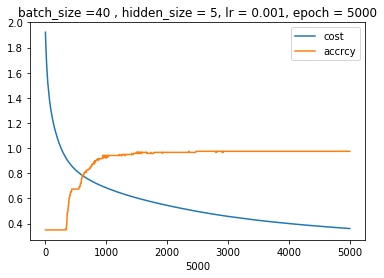

Training Accuracy:  0.975
Test Accuracy:  1.0
epoch:  0 cost, accuracy:  1.7246367086621814 0.325
epoch:  1 cost, accuracy:  1.715977022854411 0.325
epoch:  2 cost, accuracy:  1.708080203153153 0.325
epoch:  3 cost, accuracy:  1.6990922156860564 0.325
epoch:  4 cost, accuracy:  1.6904451166925227 0.325
epoch:  5 cost, accuracy:  1.6814728957859686 0.325
epoch:  6 cost, accuracy:  1.6732117994222098 0.325
epoch:  7 cost, accuracy:  1.665258333343797 0.325
epoch:  8 cost, accuracy:  1.658719969436871 0.325
epoch:  9 cost, accuracy:  1.6501544949730083 0.325
epoch:  10 cost, accuracy:  1.6422683197255166 0.325
epoch:  11 cost, accuracy:  1.6335517117551002 0.325
epoch:  12 cost, accuracy:  1.626574814060455 0.325
epoch:  13 cost, accuracy:  1.6183699458838103 0.325
epoch:  14 cost, accuracy:  1.6106207749973556 0.325
epoch:  15 cost, accuracy:  1.6032081476122721 0.325
epoch:  16 cost, accuracy:  1.5961725249506562 0.325
epoch:  17 cost, accuracy:  1.5880216481170326 0.325
epoch:  18 cost

epoch:  154 cost, accuracy:  1.1346827647197315 0.325
epoch:  155 cost, accuracy:  1.1342433802164054 0.325
epoch:  156 cost, accuracy:  1.1336990216654863 0.325
epoch:  157 cost, accuracy:  1.1325152630108641 0.325
epoch:  158 cost, accuracy:  1.1317434974764666 0.325
epoch:  159 cost, accuracy:  1.1309154659648137 0.325
epoch:  160 cost, accuracy:  1.1299819218498408 0.325
epoch:  161 cost, accuracy:  1.1293460780599092 0.325
epoch:  162 cost, accuracy:  1.1283154908062405 0.325
epoch:  163 cost, accuracy:  1.127403662324801 0.325
epoch:  164 cost, accuracy:  1.126589852556816 0.325
epoch:  165 cost, accuracy:  1.1258494753353552 0.325
epoch:  166 cost, accuracy:  1.1249710041705019 0.325
epoch:  167 cost, accuracy:  1.1242336324146531 0.325
epoch:  168 cost, accuracy:  1.1235258622228501 0.325
epoch:  169 cost, accuracy:  1.1230919554778505 0.325
epoch:  170 cost, accuracy:  1.1225419779953454 0.325
epoch:  171 cost, accuracy:  1.1217585131902452 0.325
epoch:  172 cost, accuracy:  1

epoch:  296 cost, accuracy:  1.0790420212155956 0.3333333333333333
epoch:  297 cost, accuracy:  1.0789881166671769 0.3333333333333333
epoch:  298 cost, accuracy:  1.078843280609225 0.3333333333333333
epoch:  299 cost, accuracy:  1.0786803038805348 0.3333333333333333
epoch:  300 cost, accuracy:  1.0783936995838843 0.3333333333333333
epoch:  301 cost, accuracy:  1.0781864408645707 0.3333333333333333
epoch:  302 cost, accuracy:  1.0780372400536204 0.3333333333333333
epoch:  303 cost, accuracy:  1.077808245146025 0.3333333333333333
epoch:  304 cost, accuracy:  1.077644001078994 0.3333333333333333
epoch:  305 cost, accuracy:  1.0773674928357815 0.3333333333333333
epoch:  306 cost, accuracy:  1.0771136951439606 0.3333333333333333
epoch:  307 cost, accuracy:  1.0769157441937238 0.3333333333333333
epoch:  308 cost, accuracy:  1.0768892812520514 0.3333333333333333
epoch:  309 cost, accuracy:  1.0767836483590405 0.3333333333333333
epoch:  310 cost, accuracy:  1.0766006524465672 0.333333333333333

epoch:  428 cost, accuracy:  1.0602735664092402 0.575
epoch:  429 cost, accuracy:  1.0600918166776523 0.5833333333333334
epoch:  430 cost, accuracy:  1.0599523696766115 0.5833333333333334
epoch:  431 cost, accuracy:  1.0597533846107479 0.6
epoch:  432 cost, accuracy:  1.0596021787305354 0.6
epoch:  433 cost, accuracy:  1.0594748445612638 0.6
epoch:  434 cost, accuracy:  1.0593040259203652 0.6
epoch:  435 cost, accuracy:  1.059134264802947 0.6083333333333333
epoch:  436 cost, accuracy:  1.05895753981729 0.6416666666666667
epoch:  437 cost, accuracy:  1.0588113452106176 0.625
epoch:  438 cost, accuracy:  1.0586714669403767 0.6166666666666667
epoch:  439 cost, accuracy:  1.0585032584826723 0.6416666666666667
epoch:  440 cost, accuracy:  1.0583301852223157 0.6416666666666667
epoch:  441 cost, accuracy:  1.0581445759028223 0.6416666666666667
epoch:  442 cost, accuracy:  1.0579924379541612 0.6416666666666667
epoch:  443 cost, accuracy:  1.0578215053634337 0.6416666666666667
epoch:  444 cost,

epoch:  574 cost, accuracy:  1.0311203119673555 0.675
epoch:  575 cost, accuracy:  1.0308918782965035 0.6833333333333333
epoch:  576 cost, accuracy:  1.0306506975419345 0.6833333333333333
epoch:  577 cost, accuracy:  1.030420847441292 0.6833333333333333
epoch:  578 cost, accuracy:  1.0301709538523058 0.6833333333333333
epoch:  579 cost, accuracy:  1.0299406315769317 0.6833333333333333
epoch:  580 cost, accuracy:  1.0297024489606357 0.6833333333333333
epoch:  581 cost, accuracy:  1.029474491428085 0.6833333333333333
epoch:  582 cost, accuracy:  1.029237623795335 0.6833333333333333
epoch:  583 cost, accuracy:  1.0289985855411492 0.6833333333333333
epoch:  584 cost, accuracy:  1.028757412098836 0.6833333333333333
epoch:  585 cost, accuracy:  1.0285275074513984 0.6833333333333333
epoch:  586 cost, accuracy:  1.0282886240183111 0.6833333333333333
epoch:  587 cost, accuracy:  1.0280615132025612 0.6833333333333333
epoch:  588 cost, accuracy:  1.0278178833634863 0.6833333333333333
epoch:  589 

epoch:  709 cost, accuracy:  0.9998958588130428 0.7
epoch:  710 cost, accuracy:  0.999690546835082 0.7
epoch:  711 cost, accuracy:  0.9994776591200863 0.7
epoch:  712 cost, accuracy:  0.9992717887965151 0.7
epoch:  713 cost, accuracy:  0.9990744281537102 0.7
epoch:  714 cost, accuracy:  0.9988720964446103 0.7
epoch:  715 cost, accuracy:  0.9986731154822371 0.7
epoch:  716 cost, accuracy:  0.9984581200233967 0.6916666666666667
epoch:  717 cost, accuracy:  0.9982575548927576 0.6916666666666667
epoch:  718 cost, accuracy:  0.9980569418081896 0.6916666666666667
epoch:  719 cost, accuracy:  0.997862653868701 0.7
epoch:  720 cost, accuracy:  0.9976527580991136 0.7
epoch:  721 cost, accuracy:  0.9974468082440199 0.7
epoch:  722 cost, accuracy:  0.9972368301528356 0.6916666666666667
epoch:  723 cost, accuracy:  0.9970243090946376 0.6916666666666667
epoch:  724 cost, accuracy:  0.996818261617285 0.6833333333333333
epoch:  725 cost, accuracy:  0.9966239426672224 0.6833333333333333
epoch:  726 co

epoch:  840 cost, accuracy:  0.9771178772234533 0.6833333333333333
epoch:  841 cost, accuracy:  0.9769325617524006 0.6833333333333333
epoch:  842 cost, accuracy:  0.9767945177973869 0.6833333333333333
epoch:  843 cost, accuracy:  0.976651413768391 0.6833333333333333
epoch:  844 cost, accuracy:  0.9765077173075236 0.6833333333333333
epoch:  845 cost, accuracy:  0.9763535443334425 0.6833333333333333
epoch:  846 cost, accuracy:  0.9762120446593768 0.6833333333333333
epoch:  847 cost, accuracy:  0.9760429208362653 0.6833333333333333
epoch:  848 cost, accuracy:  0.9758678600084404 0.6916666666666667
epoch:  849 cost, accuracy:  0.9757079313866726 0.6833333333333333
epoch:  850 cost, accuracy:  0.9755627101370934 0.6916666666666667
epoch:  851 cost, accuracy:  0.9754122565101508 0.6916666666666667
epoch:  852 cost, accuracy:  0.9752873355731957 0.6833333333333333
epoch:  853 cost, accuracy:  0.9751508572653749 0.6833333333333333
epoch:  854 cost, accuracy:  0.9750212026030307 0.6833333333333

epoch:  963 cost, accuracy:  0.9602337019565255 0.6833333333333333
epoch:  964 cost, accuracy:  0.9601300719815455 0.6833333333333333
epoch:  965 cost, accuracy:  0.9600244124861216 0.6833333333333333
epoch:  966 cost, accuracy:  0.9598922510443592 0.6833333333333333
epoch:  967 cost, accuracy:  0.959749216805064 0.6833333333333333
epoch:  968 cost, accuracy:  0.9595904718353251 0.6833333333333333
epoch:  969 cost, accuracy:  0.959449026825735 0.6833333333333333
epoch:  970 cost, accuracy:  0.9593293229278613 0.6833333333333333
epoch:  971 cost, accuracy:  0.9591789542554778 0.6833333333333333
epoch:  972 cost, accuracy:  0.9590341463415064 0.6833333333333333
epoch:  973 cost, accuracy:  0.9589049691357895 0.6833333333333333
epoch:  974 cost, accuracy:  0.9587712311210357 0.6833333333333333
epoch:  975 cost, accuracy:  0.958650018666424 0.6833333333333333
epoch:  976 cost, accuracy:  0.9585373955960677 0.6833333333333333
epoch:  977 cost, accuracy:  0.95839705938992 0.6833333333333333


epoch:  1085 cost, accuracy:  0.9442169973088039 0.6833333333333333
epoch:  1086 cost, accuracy:  0.944087845607697 0.6833333333333333
epoch:  1087 cost, accuracy:  0.9439664207825839 0.6833333333333333
epoch:  1088 cost, accuracy:  0.9438458290484989 0.6833333333333333
epoch:  1089 cost, accuracy:  0.94370757515182 0.6833333333333333
epoch:  1090 cost, accuracy:  0.9435762141863303 0.6833333333333333
epoch:  1091 cost, accuracy:  0.9434663098009132 0.6833333333333333
epoch:  1092 cost, accuracy:  0.9433165947743627 0.6833333333333333
epoch:  1093 cost, accuracy:  0.9431893199920443 0.6833333333333333
epoch:  1094 cost, accuracy:  0.9430787129519371 0.675
epoch:  1095 cost, accuracy:  0.9429482815753968 0.675
epoch:  1096 cost, accuracy:  0.9428030683845613 0.6833333333333333
epoch:  1097 cost, accuracy:  0.9426673672809678 0.6833333333333333
epoch:  1098 cost, accuracy:  0.9425316783410277 0.6833333333333333
epoch:  1099 cost, accuracy:  0.9423903102782138 0.6833333333333333
epoch:  1

epoch:  1209 cost, accuracy:  0.9271954510067815 0.7083333333333334
epoch:  1210 cost, accuracy:  0.9270610752739255 0.7083333333333334
epoch:  1211 cost, accuracy:  0.9269193078740322 0.7083333333333334
epoch:  1212 cost, accuracy:  0.926773035365147 0.7083333333333334
epoch:  1213 cost, accuracy:  0.9266307099582112 0.7083333333333334
epoch:  1214 cost, accuracy:  0.9265086272713469 0.7083333333333334
epoch:  1215 cost, accuracy:  0.9263538023185428 0.7083333333333334
epoch:  1216 cost, accuracy:  0.9262035338795626 0.7083333333333334
epoch:  1217 cost, accuracy:  0.9260585569212022 0.7083333333333334
epoch:  1218 cost, accuracy:  0.925913528330474 0.7333333333333333
epoch:  1219 cost, accuracy:  0.9257636047635989 0.7333333333333333
epoch:  1220 cost, accuracy:  0.9256308055047217 0.7166666666666667
epoch:  1221 cost, accuracy:  0.9254788578413948 0.7083333333333334
epoch:  1222 cost, accuracy:  0.9253358558950426 0.7083333333333334
epoch:  1223 cost, accuracy:  0.925190298248998 0.

epoch:  1333 cost, accuracy:  0.9086774266896469 0.7416666666666667
epoch:  1334 cost, accuracy:  0.9085162700845179 0.7416666666666667
epoch:  1335 cost, accuracy:  0.908356459081339 0.7416666666666667
epoch:  1336 cost, accuracy:  0.9081865187476552 0.7416666666666667
epoch:  1337 cost, accuracy:  0.9080255107506162 0.7416666666666667
epoch:  1338 cost, accuracy:  0.9078632735519206 0.75
epoch:  1339 cost, accuracy:  0.9077068162230569 0.7416666666666667
epoch:  1340 cost, accuracy:  0.9075484201264902 0.7416666666666667
epoch:  1341 cost, accuracy:  0.9073872758029045 0.7416666666666667
epoch:  1342 cost, accuracy:  0.9072201441103603 0.75
epoch:  1343 cost, accuracy:  0.9070816018167493 0.75
epoch:  1344 cost, accuracy:  0.9069171715939055 0.75
epoch:  1345 cost, accuracy:  0.9067468759120997 0.75
epoch:  1346 cost, accuracy:  0.9065816317328912 0.75
epoch:  1347 cost, accuracy:  0.9064198677733011 0.75
epoch:  1348 cost, accuracy:  0.9062559513624531 0.7416666666666667
epoch:  134

epoch:  1464 cost, accuracy:  0.8868007370305981 0.7416666666666667
epoch:  1465 cost, accuracy:  0.8866358766787127 0.7416666666666667
epoch:  1466 cost, accuracy:  0.8864542723376736 0.7583333333333333
epoch:  1467 cost, accuracy:  0.8862840999640121 0.7416666666666667
epoch:  1468 cost, accuracy:  0.8860974966286584 0.75
epoch:  1469 cost, accuracy:  0.8859351917160689 0.7583333333333333
epoch:  1470 cost, accuracy:  0.8857587956295004 0.7583333333333333
epoch:  1471 cost, accuracy:  0.8855793513946213 0.7416666666666667
epoch:  1472 cost, accuracy:  0.8854078375381784 0.7416666666666667
epoch:  1473 cost, accuracy:  0.8852130940145296 0.7583333333333333
epoch:  1474 cost, accuracy:  0.8850317539137175 0.7583333333333333
epoch:  1475 cost, accuracy:  0.884865241609684 0.7666666666666667
epoch:  1476 cost, accuracy:  0.8846862566285452 0.7666666666666667
epoch:  1477 cost, accuracy:  0.8845130912110056 0.7666666666666667
epoch:  1478 cost, accuracy:  0.8843237117303288 0.766666666666

epoch:  1587 cost, accuracy:  0.8647880886113305 0.7583333333333333
epoch:  1588 cost, accuracy:  0.8646085539894202 0.7583333333333333
epoch:  1589 cost, accuracy:  0.8644204474725276 0.7583333333333333
epoch:  1590 cost, accuracy:  0.8642502383386053 0.7666666666666667
epoch:  1591 cost, accuracy:  0.8640679104436603 0.7666666666666667
epoch:  1592 cost, accuracy:  0.8638902392132579 0.7666666666666667
epoch:  1593 cost, accuracy:  0.8637056710763832 0.7666666666666667
epoch:  1594 cost, accuracy:  0.8635273980424303 0.7583333333333333
epoch:  1595 cost, accuracy:  0.8633477425445047 0.7583333333333333
epoch:  1596 cost, accuracy:  0.8631717417108873 0.7583333333333333
epoch:  1597 cost, accuracy:  0.8629878102048444 0.7666666666666667
epoch:  1598 cost, accuracy:  0.862810997459255 0.7666666666666667
epoch:  1599 cost, accuracy:  0.8626288971717115 0.7666666666666667
epoch:  1600 cost, accuracy:  0.8624478037459352 0.7666666666666667
epoch:  1601 cost, accuracy:  0.862269131489866 0

epoch:  1710 cost, accuracy:  0.8428232406137073 0.7416666666666667
epoch:  1711 cost, accuracy:  0.8426508231320288 0.7333333333333333
epoch:  1712 cost, accuracy:  0.8424783303120723 0.7333333333333333
epoch:  1713 cost, accuracy:  0.8422984787708917 0.7416666666666667
epoch:  1714 cost, accuracy:  0.8421203854064203 0.7333333333333333
epoch:  1715 cost, accuracy:  0.8419481993191961 0.7333333333333333
epoch:  1716 cost, accuracy:  0.8417813700232519 0.7333333333333333
epoch:  1717 cost, accuracy:  0.8416054452841337 0.7333333333333333
epoch:  1718 cost, accuracy:  0.8414319225062741 0.7416666666666667
epoch:  1719 cost, accuracy:  0.841258065792238 0.75
epoch:  1720 cost, accuracy:  0.8410936391079046 0.7583333333333333
epoch:  1721 cost, accuracy:  0.8409202544303064 0.7583333333333333
epoch:  1722 cost, accuracy:  0.8407571025732617 0.7583333333333333
epoch:  1723 cost, accuracy:  0.8405694671748793 0.7583333333333333
epoch:  1724 cost, accuracy:  0.8403914582418913 0.758333333333

epoch:  1837 cost, accuracy:  0.8212794110672479 0.7583333333333333
epoch:  1838 cost, accuracy:  0.8210912888595446 0.7583333333333333
epoch:  1839 cost, accuracy:  0.8209270888491644 0.7583333333333333
epoch:  1840 cost, accuracy:  0.8207513368934406 0.7583333333333333
epoch:  1841 cost, accuracy:  0.8205821861944032 0.7583333333333333
epoch:  1842 cost, accuracy:  0.8204193247241544 0.7583333333333333
epoch:  1843 cost, accuracy:  0.820250557411857 0.7583333333333333
epoch:  1844 cost, accuracy:  0.820073245851543 0.7583333333333333
epoch:  1845 cost, accuracy:  0.8199137042732219 0.7583333333333333
epoch:  1846 cost, accuracy:  0.8197376223032078 0.7666666666666667
epoch:  1847 cost, accuracy:  0.8195695595438913 0.7666666666666667
epoch:  1848 cost, accuracy:  0.8193966113346398 0.7583333333333333
epoch:  1849 cost, accuracy:  0.8192364604444757 0.7583333333333333
epoch:  1850 cost, accuracy:  0.819066587303129 0.7583333333333333
epoch:  1851 cost, accuracy:  0.8189095292031262 0.

epoch:  1958 cost, accuracy:  0.8018609833116678 0.7583333333333333
epoch:  1959 cost, accuracy:  0.8016985756715762 0.7583333333333333
epoch:  1960 cost, accuracy:  0.8015545080921134 0.7583333333333333
epoch:  1961 cost, accuracy:  0.8014072349792019 0.7583333333333333
epoch:  1962 cost, accuracy:  0.8012488423244383 0.7583333333333333
epoch:  1963 cost, accuracy:  0.8010958974004372 0.7583333333333333
epoch:  1964 cost, accuracy:  0.8009358819266575 0.7583333333333333
epoch:  1965 cost, accuracy:  0.8007871744882809 0.7583333333333333
epoch:  1966 cost, accuracy:  0.800642078314426 0.7583333333333333
epoch:  1967 cost, accuracy:  0.80049313042492 0.7583333333333333
epoch:  1968 cost, accuracy:  0.8003337190800462 0.7583333333333333
epoch:  1969 cost, accuracy:  0.8001922230745268 0.7583333333333333
epoch:  1970 cost, accuracy:  0.800038857457024 0.7583333333333333
epoch:  1971 cost, accuracy:  0.7998951147331497 0.7583333333333333
epoch:  1972 cost, accuracy:  0.7997370373404574 0.7

epoch:  2082 cost, accuracy:  0.7834771831164666 0.75
epoch:  2083 cost, accuracy:  0.7833378798235107 0.75
epoch:  2084 cost, accuracy:  0.7832026322617095 0.75
epoch:  2085 cost, accuracy:  0.7830524452039328 0.75
epoch:  2086 cost, accuracy:  0.7829172389991065 0.75
epoch:  2087 cost, accuracy:  0.7827790427479357 0.75
epoch:  2088 cost, accuracy:  0.7826309276463834 0.75
epoch:  2089 cost, accuracy:  0.7825014283812085 0.75
epoch:  2090 cost, accuracy:  0.7823624959624715 0.75
epoch:  2091 cost, accuracy:  0.7822133889079546 0.75
epoch:  2092 cost, accuracy:  0.782077242587387 0.75
epoch:  2093 cost, accuracy:  0.7819457344761199 0.75
epoch:  2094 cost, accuracy:  0.7818210564202368 0.75
epoch:  2095 cost, accuracy:  0.7816609076342574 0.75
epoch:  2096 cost, accuracy:  0.7815143969719027 0.7583333333333333
epoch:  2097 cost, accuracy:  0.7813787848624294 0.7583333333333333
epoch:  2098 cost, accuracy:  0.7812263615761571 0.7583333333333333
epoch:  2099 cost, accuracy:  0.781095770

epoch:  2216 cost, accuracy:  0.7648980180977493 0.75
epoch:  2217 cost, accuracy:  0.7647788240518267 0.75
epoch:  2218 cost, accuracy:  0.7646456227553815 0.7333333333333333
epoch:  2219 cost, accuracy:  0.7645176539354501 0.7333333333333333
epoch:  2220 cost, accuracy:  0.7643922839142604 0.7333333333333333
epoch:  2221 cost, accuracy:  0.7642626339752693 0.7333333333333333
epoch:  2222 cost, accuracy:  0.7641314023543273 0.7333333333333333
epoch:  2223 cost, accuracy:  0.7640023843201559 0.7333333333333333
epoch:  2224 cost, accuracy:  0.7638705105390022 0.75
epoch:  2225 cost, accuracy:  0.76375796382188 0.75
epoch:  2226 cost, accuracy:  0.7636311853806883 0.7333333333333333
epoch:  2227 cost, accuracy:  0.7634900594234696 0.75
epoch:  2228 cost, accuracy:  0.7633695638122435 0.7333333333333333
epoch:  2229 cost, accuracy:  0.7632481279261542 0.7333333333333333
epoch:  2230 cost, accuracy:  0.7631211223040689 0.7333333333333333
epoch:  2231 cost, accuracy:  0.76298364623196 0.733

epoch:  2346 cost, accuracy:  0.7480864082022365 0.7333333333333333
epoch:  2347 cost, accuracy:  0.7479579155272317 0.7416666666666667
epoch:  2348 cost, accuracy:  0.7478264527563525 0.7416666666666667
epoch:  2349 cost, accuracy:  0.7477009370483498 0.7416666666666667
epoch:  2350 cost, accuracy:  0.7475665365870635 0.7416666666666667
epoch:  2351 cost, accuracy:  0.7474585691929284 0.7416666666666667
epoch:  2352 cost, accuracy:  0.747348519961076 0.7416666666666667
epoch:  2353 cost, accuracy:  0.7472175386703908 0.7416666666666667
epoch:  2354 cost, accuracy:  0.7470968381934371 0.7416666666666667
epoch:  2355 cost, accuracy:  0.7469734417715491 0.7416666666666667
epoch:  2356 cost, accuracy:  0.7468462899168801 0.7416666666666667
epoch:  2357 cost, accuracy:  0.7467129853544824 0.75
epoch:  2358 cost, accuracy:  0.7465890580869557 0.7583333333333333
epoch:  2359 cost, accuracy:  0.7464468302035939 0.7583333333333333
epoch:  2360 cost, accuracy:  0.746320209212319 0.7583333333333

epoch:  2470 cost, accuracy:  0.7328452420154911 0.7666666666666667
epoch:  2471 cost, accuracy:  0.7327278381213916 0.7666666666666667
epoch:  2472 cost, accuracy:  0.7326065752474444 0.7666666666666667
epoch:  2473 cost, accuracy:  0.7324858144693545 0.7666666666666667
epoch:  2474 cost, accuracy:  0.7323599746920032 0.7666666666666667
epoch:  2475 cost, accuracy:  0.7322457253546493 0.7666666666666667
epoch:  2476 cost, accuracy:  0.7321249390011251 0.7666666666666667
epoch:  2477 cost, accuracy:  0.7320140298299381 0.7666666666666667
epoch:  2478 cost, accuracy:  0.7318944793905625 0.7666666666666667
epoch:  2479 cost, accuracy:  0.7317681838329435 0.7666666666666667
epoch:  2480 cost, accuracy:  0.7316463546067332 0.7666666666666667
epoch:  2481 cost, accuracy:  0.7315341323067588 0.7666666666666667
epoch:  2482 cost, accuracy:  0.7314140868754971 0.775
epoch:  2483 cost, accuracy:  0.7312907816647235 0.775
epoch:  2484 cost, accuracy:  0.7311666096399023 0.775
epoch:  2485 cost, 

epoch:  2607 cost, accuracy:  0.7169939907797761 0.775
epoch:  2608 cost, accuracy:  0.7168793749210852 0.775
epoch:  2609 cost, accuracy:  0.7167651251706175 0.775
epoch:  2610 cost, accuracy:  0.7166504708760153 0.775
epoch:  2611 cost, accuracy:  0.7165435279628863 0.775
epoch:  2612 cost, accuracy:  0.7164345351130051 0.775
epoch:  2613 cost, accuracy:  0.7163266527725386 0.775
epoch:  2614 cost, accuracy:  0.7162172542862959 0.775
epoch:  2615 cost, accuracy:  0.7161026752447064 0.775
epoch:  2616 cost, accuracy:  0.715989227316669 0.775
epoch:  2617 cost, accuracy:  0.7158749270814074 0.775
epoch:  2618 cost, accuracy:  0.7157698917509598 0.775
epoch:  2619 cost, accuracy:  0.7156633758535935 0.775
epoch:  2620 cost, accuracy:  0.7155505345671624 0.775
epoch:  2621 cost, accuracy:  0.7154412962736232 0.775
epoch:  2622 cost, accuracy:  0.7153316000975222 0.775
epoch:  2623 cost, accuracy:  0.7152196203544515 0.775
epoch:  2624 cost, accuracy:  0.7151055198416617 0.775
epoch:  262

epoch:  2745 cost, accuracy:  0.7020202771527622 0.775
epoch:  2746 cost, accuracy:  0.7019162620243444 0.775
epoch:  2747 cost, accuracy:  0.7018066837216108 0.775
epoch:  2748 cost, accuracy:  0.7017016471145818 0.775
epoch:  2749 cost, accuracy:  0.7015909624112918 0.775
epoch:  2750 cost, accuracy:  0.7014832209896399 0.775
epoch:  2751 cost, accuracy:  0.7013772567354404 0.775
epoch:  2752 cost, accuracy:  0.7012678610259061 0.775
epoch:  2753 cost, accuracy:  0.7011619651170253 0.775
epoch:  2754 cost, accuracy:  0.7010555112931843 0.775
epoch:  2755 cost, accuracy:  0.7009496073829288 0.775
epoch:  2756 cost, accuracy:  0.7008416555676183 0.775
epoch:  2757 cost, accuracy:  0.700737613382559 0.775
epoch:  2758 cost, accuracy:  0.7006372235201003 0.775
epoch:  2759 cost, accuracy:  0.7005384244747987 0.775
epoch:  2760 cost, accuracy:  0.7004297654794213 0.775
epoch:  2761 cost, accuracy:  0.7003228791204241 0.775
epoch:  2762 cost, accuracy:  0.7002165651145927 0.775
epoch:  276

epoch:  2891 cost, accuracy:  0.6870814343374906 0.775
epoch:  2892 cost, accuracy:  0.686990150358415 0.775
epoch:  2893 cost, accuracy:  0.686907397548811 0.7666666666666667
epoch:  2894 cost, accuracy:  0.686812420648838 0.7583333333333333
epoch:  2895 cost, accuracy:  0.6867078547562419 0.7666666666666667
epoch:  2896 cost, accuracy:  0.6866067477473046 0.7666666666666667
epoch:  2897 cost, accuracy:  0.6865083179298358 0.7666666666666667
epoch:  2898 cost, accuracy:  0.6864081769444873 0.775
epoch:  2899 cost, accuracy:  0.6863157248779459 0.7666666666666667
epoch:  2900 cost, accuracy:  0.6862254432916364 0.7666666666666667
epoch:  2901 cost, accuracy:  0.6861199438027205 0.775
epoch:  2902 cost, accuracy:  0.6860183058313306 0.775
epoch:  2903 cost, accuracy:  0.6859181587383313 0.7666666666666667
epoch:  2904 cost, accuracy:  0.6858193353986579 0.7666666666666667
epoch:  2905 cost, accuracy:  0.6857196886491522 0.7666666666666667
epoch:  2906 cost, accuracy:  0.6856221517972159

epoch:  3022 cost, accuracy:  0.6744953649074144 0.8166666666666667
epoch:  3023 cost, accuracy:  0.6744089557986065 0.8166666666666667
epoch:  3024 cost, accuracy:  0.6743176234729824 0.8166666666666667
epoch:  3025 cost, accuracy:  0.6742233590461048 0.8166666666666667
epoch:  3026 cost, accuracy:  0.6741311512676539 0.8166666666666667
epoch:  3027 cost, accuracy:  0.6740316922029279 0.8166666666666667
epoch:  3028 cost, accuracy:  0.6739405197791821 0.8166666666666667
epoch:  3029 cost, accuracy:  0.6738441394692074 0.8166666666666667
epoch:  3030 cost, accuracy:  0.6737561970216321 0.8166666666666667
epoch:  3031 cost, accuracy:  0.6736515663364407 0.8166666666666667
epoch:  3032 cost, accuracy:  0.6735639135845871 0.8166666666666667
epoch:  3033 cost, accuracy:  0.6734713113691877 0.8166666666666667
epoch:  3034 cost, accuracy:  0.6733719941420039 0.8166666666666667
epoch:  3035 cost, accuracy:  0.6732732341388018 0.8166666666666667
epoch:  3036 cost, accuracy:  0.6731880899159554

epoch:  3154 cost, accuracy:  0.6623767652161957 0.825
epoch:  3155 cost, accuracy:  0.6622944709793764 0.825
epoch:  3156 cost, accuracy:  0.6622069054755336 0.825
epoch:  3157 cost, accuracy:  0.6621167374688409 0.825
epoch:  3158 cost, accuracy:  0.6620217149816745 0.825
epoch:  3159 cost, accuracy:  0.6619288383599992 0.825
epoch:  3160 cost, accuracy:  0.6618511665726518 0.825
epoch:  3161 cost, accuracy:  0.6617545733414497 0.825
epoch:  3162 cost, accuracy:  0.6616633085988787 0.8416666666666667
epoch:  3163 cost, accuracy:  0.661568897950153 0.8333333333333334
epoch:  3164 cost, accuracy:  0.6614809835873582 0.825
epoch:  3165 cost, accuracy:  0.6613883797443215 0.8333333333333334
epoch:  3166 cost, accuracy:  0.6613003849895905 0.8416666666666667
epoch:  3167 cost, accuracy:  0.6612088707669042 0.825
epoch:  3168 cost, accuracy:  0.6611197988467145 0.825
epoch:  3169 cost, accuracy:  0.661032942529277 0.825
epoch:  3170 cost, accuracy:  0.660941896239687 0.825
epoch:  3171 cos

epoch:  3295 cost, accuracy:  0.6501361049141136 0.8333333333333334
epoch:  3296 cost, accuracy:  0.6500538719106373 0.825
epoch:  3297 cost, accuracy:  0.6499635598239879 0.8333333333333334
epoch:  3298 cost, accuracy:  0.6498749639593376 0.825
epoch:  3299 cost, accuracy:  0.6497875336786454 0.825
epoch:  3300 cost, accuracy:  0.6497071689700411 0.825
epoch:  3301 cost, accuracy:  0.6496218877317942 0.825
epoch:  3302 cost, accuracy:  0.6495417459021754 0.825
epoch:  3303 cost, accuracy:  0.6494645850785988 0.825
epoch:  3304 cost, accuracy:  0.6493763352877411 0.825
epoch:  3305 cost, accuracy:  0.649297005583458 0.825
epoch:  3306 cost, accuracy:  0.6492125046981386 0.825
epoch:  3307 cost, accuracy:  0.649129364403743 0.825
epoch:  3308 cost, accuracy:  0.6490455802363456 0.825
epoch:  3309 cost, accuracy:  0.648958275984923 0.825
epoch:  3310 cost, accuracy:  0.648871662770565 0.825
epoch:  3311 cost, accuracy:  0.6487847031207152 0.8333333333333334
epoch:  3312 cost, accuracy:  

epoch:  3428 cost, accuracy:  0.6392522324035584 0.8166666666666667
epoch:  3429 cost, accuracy:  0.6391745391577399 0.8166666666666667
epoch:  3430 cost, accuracy:  0.6390962783670345 0.825
epoch:  3431 cost, accuracy:  0.6390237223760251 0.8166666666666667
epoch:  3432 cost, accuracy:  0.6389425690258997 0.825
epoch:  3433 cost, accuracy:  0.6388611331813634 0.825
epoch:  3434 cost, accuracy:  0.6387888457448675 0.825
epoch:  3435 cost, accuracy:  0.638709590706826 0.825
epoch:  3436 cost, accuracy:  0.6386195445929768 0.825
epoch:  3437 cost, accuracy:  0.6385350056454444 0.825
epoch:  3438 cost, accuracy:  0.6384575836800107 0.825
epoch:  3439 cost, accuracy:  0.6383783344483176 0.825
epoch:  3440 cost, accuracy:  0.6382972447007845 0.825
epoch:  3441 cost, accuracy:  0.6382133688768218 0.825
epoch:  3442 cost, accuracy:  0.6381315621780854 0.825
epoch:  3443 cost, accuracy:  0.6380604038978792 0.825
epoch:  3444 cost, accuracy:  0.6379835047143371 0.8333333333333334
epoch:  3445 c

epoch:  3558 cost, accuracy:  0.6292108082298304 0.8166666666666667
epoch:  3559 cost, accuracy:  0.6291381779133893 0.8166666666666667
epoch:  3560 cost, accuracy:  0.6290559281550446 0.8166666666666667
epoch:  3561 cost, accuracy:  0.6289762542617263 0.8166666666666667
epoch:  3562 cost, accuracy:  0.6289117157430056 0.8166666666666667
epoch:  3563 cost, accuracy:  0.6288236770521425 0.8166666666666667
epoch:  3564 cost, accuracy:  0.6287523261464598 0.8166666666666667
epoch:  3565 cost, accuracy:  0.6286794390825973 0.8166666666666667
epoch:  3566 cost, accuracy:  0.6286023021273657 0.8166666666666667
epoch:  3567 cost, accuracy:  0.6285250461759553 0.825
epoch:  3568 cost, accuracy:  0.6284487304760005 0.825
epoch:  3569 cost, accuracy:  0.6283684801596756 0.825
epoch:  3570 cost, accuracy:  0.6283011713938774 0.825
epoch:  3571 cost, accuracy:  0.6282249039020193 0.825
epoch:  3572 cost, accuracy:  0.6281551652641537 0.825
epoch:  3573 cost, accuracy:  0.6280760686277245 0.825
epo

epoch:  3687 cost, accuracy:  0.619734184045743 0.8666666666666667
epoch:  3688 cost, accuracy:  0.6196654978228245 0.8666666666666667
epoch:  3689 cost, accuracy:  0.6195971856482968 0.8666666666666667
epoch:  3690 cost, accuracy:  0.6195217438977799 0.8666666666666667
epoch:  3691 cost, accuracy:  0.6194509536447134 0.8666666666666667
epoch:  3692 cost, accuracy:  0.6193778604086914 0.875
epoch:  3693 cost, accuracy:  0.6193085412046595 0.8666666666666667
epoch:  3694 cost, accuracy:  0.6192397381548016 0.875
epoch:  3695 cost, accuracy:  0.619169170299535 0.875
epoch:  3696 cost, accuracy:  0.6190970314575153 0.875
epoch:  3697 cost, accuracy:  0.6190232899680116 0.875
epoch:  3698 cost, accuracy:  0.6189519034366514 0.875
epoch:  3699 cost, accuracy:  0.6188818666239828 0.875
epoch:  3700 cost, accuracy:  0.6188121331364108 0.875
epoch:  3701 cost, accuracy:  0.6187385216918948 0.875
epoch:  3702 cost, accuracy:  0.61867104151773 0.875
epoch:  3703 cost, accuracy:  0.61859606954782

epoch:  3821 cost, accuracy:  0.6105125842447111 0.875
epoch:  3822 cost, accuracy:  0.6104471657302302 0.875
epoch:  3823 cost, accuracy:  0.6103826387117048 0.8666666666666667
epoch:  3824 cost, accuracy:  0.6103144971138496 0.8666666666666667
epoch:  3825 cost, accuracy:  0.6102487890354754 0.875
epoch:  3826 cost, accuracy:  0.6101828557765298 0.8666666666666667
epoch:  3827 cost, accuracy:  0.6101171945061538 0.8666666666666667
epoch:  3828 cost, accuracy:  0.6100516333832441 0.8666666666666667
epoch:  3829 cost, accuracy:  0.6099887838737206 0.8666666666666667
epoch:  3830 cost, accuracy:  0.6099231610281873 0.8666666666666667
epoch:  3831 cost, accuracy:  0.6098508887385131 0.8666666666666667
epoch:  3832 cost, accuracy:  0.6097818691589527 0.875
epoch:  3833 cost, accuracy:  0.6097169483707082 0.8666666666666667
epoch:  3834 cost, accuracy:  0.6096509293598555 0.8666666666666667
epoch:  3835 cost, accuracy:  0.6095832067112421 0.8666666666666667
epoch:  3836 cost, accuracy:  0.

epoch:  3965 cost, accuracy:  0.6013003071667941 0.8416666666666667
epoch:  3966 cost, accuracy:  0.6012346546147044 0.8416666666666667
epoch:  3967 cost, accuracy:  0.6011639172464639 0.8416666666666667
epoch:  3968 cost, accuracy:  0.6011139587184875 0.8416666666666667
epoch:  3969 cost, accuracy:  0.6010495071266401 0.8416666666666667
epoch:  3970 cost, accuracy:  0.6009965951236129 0.8416666666666667
epoch:  3971 cost, accuracy:  0.6009387598104925 0.8416666666666667
epoch:  3972 cost, accuracy:  0.600868979317236 0.8416666666666667
epoch:  3973 cost, accuracy:  0.6008116796712655 0.8416666666666667
epoch:  3974 cost, accuracy:  0.6007499348564711 0.8416666666666667
epoch:  3975 cost, accuracy:  0.6006885768096438 0.8416666666666667
epoch:  3976 cost, accuracy:  0.6006250255938066 0.8416666666666667
epoch:  3977 cost, accuracy:  0.6005616516931009 0.8416666666666667
epoch:  3978 cost, accuracy:  0.6005095575283461 0.8416666666666667
epoch:  3979 cost, accuracy:  0.6004440794420538 

epoch:  4100 cost, accuracy:  0.593162935966909 0.875
epoch:  4101 cost, accuracy:  0.5931043532201433 0.875
epoch:  4102 cost, accuracy:  0.5930531588378556 0.8666666666666667
epoch:  4103 cost, accuracy:  0.5929936220025069 0.8583333333333333
epoch:  4104 cost, accuracy:  0.5929384452002794 0.85
epoch:  4105 cost, accuracy:  0.5928752629992126 0.8666666666666667
epoch:  4106 cost, accuracy:  0.5928202263867474 0.8583333333333333
epoch:  4107 cost, accuracy:  0.5927598247885812 0.8666666666666667
epoch:  4108 cost, accuracy:  0.5926975780435979 0.8666666666666667
epoch:  4109 cost, accuracy:  0.5926399652546709 0.875
epoch:  4110 cost, accuracy:  0.5925842663134606 0.8666666666666667
epoch:  4111 cost, accuracy:  0.5925363756666677 0.85
epoch:  4112 cost, accuracy:  0.592478014838299 0.85
epoch:  4113 cost, accuracy:  0.5924282363491943 0.85
epoch:  4114 cost, accuracy:  0.5923669688691123 0.85
epoch:  4115 cost, accuracy:  0.5923044456403005 0.85
epoch:  4116 cost, accuracy:  0.59224

epoch:  4247 cost, accuracy:  0.5848483779699805 0.875
epoch:  4248 cost, accuracy:  0.5847959215012462 0.875
epoch:  4249 cost, accuracy:  0.5847420660114138 0.875
epoch:  4250 cost, accuracy:  0.5846883053443573 0.875
epoch:  4251 cost, accuracy:  0.5846351927780715 0.875
epoch:  4252 cost, accuracy:  0.5845796893646363 0.875
epoch:  4253 cost, accuracy:  0.5845266605762457 0.875
epoch:  4254 cost, accuracy:  0.5844697905937647 0.875
epoch:  4255 cost, accuracy:  0.5844148668141843 0.875
epoch:  4256 cost, accuracy:  0.5843612340811472 0.875
epoch:  4257 cost, accuracy:  0.5843085100913877 0.875
epoch:  4258 cost, accuracy:  0.5842527417679446 0.875
epoch:  4259 cost, accuracy:  0.5841943736364338 0.8916666666666667
epoch:  4260 cost, accuracy:  0.5841396491777037 0.8916666666666667
epoch:  4261 cost, accuracy:  0.5840856079629759 0.8916666666666667
epoch:  4262 cost, accuracy:  0.5840313512162686 0.8916666666666667
epoch:  4263 cost, accuracy:  0.583976560492096 0.8916666666666667
e

epoch:  4386 cost, accuracy:  0.5775129926227595 0.925
epoch:  4387 cost, accuracy:  0.5774624072123108 0.925
epoch:  4388 cost, accuracy:  0.577416949600515 0.925
epoch:  4389 cost, accuracy:  0.5773671470266308 0.925
epoch:  4390 cost, accuracy:  0.5773046624468969 0.925
epoch:  4391 cost, accuracy:  0.577260080125724 0.925
epoch:  4392 cost, accuracy:  0.5772083399042744 0.925
epoch:  4393 cost, accuracy:  0.577159480841154 0.925
epoch:  4394 cost, accuracy:  0.5771219434169349 0.9333333333333333
epoch:  4395 cost, accuracy:  0.5770805109209897 0.9416666666666667
epoch:  4396 cost, accuracy:  0.577027970721781 0.9416666666666667
epoch:  4397 cost, accuracy:  0.5769717190991392 0.9416666666666667
epoch:  4398 cost, accuracy:  0.5769264958685117 0.9416666666666667
epoch:  4399 cost, accuracy:  0.576880316725008 0.9416666666666667
epoch:  4400 cost, accuracy:  0.5768250639485121 0.9416666666666667
epoch:  4401 cost, accuracy:  0.5767734009150648 0.9416666666666667
epoch:  4402 cost, ac

epoch:  4524 cost, accuracy:  0.57067428700039 0.8833333333333333
epoch:  4525 cost, accuracy:  0.5706308422747883 0.875
epoch:  4526 cost, accuracy:  0.5705878371832102 0.875
epoch:  4527 cost, accuracy:  0.5705373978218152 0.875
epoch:  4528 cost, accuracy:  0.5704852087997601 0.875
epoch:  4529 cost, accuracy:  0.5704381464886813 0.875
epoch:  4530 cost, accuracy:  0.5703946104124368 0.875
epoch:  4531 cost, accuracy:  0.5703465348609138 0.875
epoch:  4532 cost, accuracy:  0.5702902590149854 0.8916666666666667
epoch:  4533 cost, accuracy:  0.5702399547192336 0.8916666666666667
epoch:  4534 cost, accuracy:  0.5701898903388959 0.8916666666666667
epoch:  4535 cost, accuracy:  0.5701407789205208 0.8916666666666667
epoch:  4536 cost, accuracy:  0.5700931020183923 0.8916666666666667
epoch:  4537 cost, accuracy:  0.5700460518255189 0.8916666666666667
epoch:  4538 cost, accuracy:  0.569997560604278 0.9
epoch:  4539 cost, accuracy:  0.5699500456561556 0.9
epoch:  4540 cost, accuracy:  0.5699

epoch:  4648 cost, accuracy:  0.5648547964662516 0.9083333333333333
epoch:  4649 cost, accuracy:  0.5648095798684302 0.9166666666666666
epoch:  4650 cost, accuracy:  0.564763550955904 0.9083333333333333
epoch:  4651 cost, accuracy:  0.5647188427487291 0.9
epoch:  4652 cost, accuracy:  0.5646749745494758 0.8916666666666667
epoch:  4653 cost, accuracy:  0.5646302959048526 0.8916666666666667
epoch:  4654 cost, accuracy:  0.5645816283906666 0.9
epoch:  4655 cost, accuracy:  0.5645364146456198 0.8916666666666667
epoch:  4656 cost, accuracy:  0.5644925267095052 0.8916666666666667
epoch:  4657 cost, accuracy:  0.5644475273940438 0.8916666666666667
epoch:  4658 cost, accuracy:  0.5644010278196717 0.9083333333333333
epoch:  4659 cost, accuracy:  0.5643555499619695 0.9
epoch:  4660 cost, accuracy:  0.564310539485111 0.9083333333333333
epoch:  4661 cost, accuracy:  0.5642659871369909 0.9083333333333333
epoch:  4662 cost, accuracy:  0.5642201500882007 0.9083333333333333
epoch:  4663 cost, accuracy

epoch:  4784 cost, accuracy:  0.5588162720083556 0.8916666666666667
epoch:  4785 cost, accuracy:  0.5587756704084693 0.8833333333333333
epoch:  4786 cost, accuracy:  0.5587348771833729 0.875
epoch:  4787 cost, accuracy:  0.5586967360708861 0.875
epoch:  4788 cost, accuracy:  0.5586487569916393 0.875
epoch:  4789 cost, accuracy:  0.5586049083168976 0.875
epoch:  4790 cost, accuracy:  0.5585691358644669 0.875
epoch:  4791 cost, accuracy:  0.5585253278851409 0.875
epoch:  4792 cost, accuracy:  0.5584745791481562 0.875
epoch:  4793 cost, accuracy:  0.5584307697869643 0.875
epoch:  4794 cost, accuracy:  0.5583935362356911 0.875
epoch:  4795 cost, accuracy:  0.5583449401150635 0.875
epoch:  4796 cost, accuracy:  0.5583038913174487 0.875
epoch:  4797 cost, accuracy:  0.5582646586097753 0.875
epoch:  4798 cost, accuracy:  0.5582222093831848 0.875
epoch:  4799 cost, accuracy:  0.5581744740506184 0.875
epoch:  4800 cost, accuracy:  0.558126905532579 0.8833333333333333
epoch:  4801 cost, accuracy

epoch:  4918 cost, accuracy:  0.5531438741186251 0.9166666666666666
epoch:  4919 cost, accuracy:  0.5531011774135222 0.9166666666666666
epoch:  4920 cost, accuracy:  0.5530585240216194 0.9166666666666666
epoch:  4921 cost, accuracy:  0.5530208390886884 0.925
epoch:  4922 cost, accuracy:  0.5529813945971177 0.925
epoch:  4923 cost, accuracy:  0.5529431173151887 0.9333333333333333
epoch:  4924 cost, accuracy:  0.5528966510373347 0.925
epoch:  4925 cost, accuracy:  0.5528518701965197 0.925
epoch:  4926 cost, accuracy:  0.5528105822164124 0.925
epoch:  4927 cost, accuracy:  0.5527702825347754 0.9166666666666666
epoch:  4928 cost, accuracy:  0.5527295274820505 0.9166666666666666
epoch:  4929 cost, accuracy:  0.5526882614986841 0.9166666666666666
epoch:  4930 cost, accuracy:  0.552647982035791 0.9166666666666666
epoch:  4931 cost, accuracy:  0.5526068781354684 0.9166666666666666
epoch:  4932 cost, accuracy:  0.5525664809631337 0.9166666666666666
epoch:  4933 cost, accuracy:  0.55252558655731

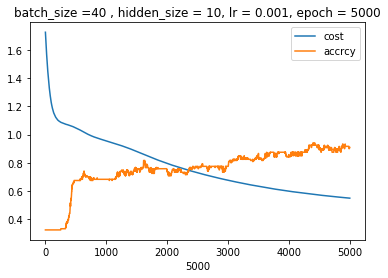

Training Accuracy:  0.9083333333333333
Test Accuracy:  0.9333333333333333
epoch:  0 cost, accuracy:  1.3724429272620189 0.325
epoch:  1 cost, accuracy:  1.3638609627314717 0.325
epoch:  2 cost, accuracy:  1.3549082990295866 0.325
epoch:  3 cost, accuracy:  1.3463312894675046 0.325
epoch:  4 cost, accuracy:  1.3388299215875707 0.325
epoch:  5 cost, accuracy:  1.3316711447964569 0.325
epoch:  6 cost, accuracy:  1.3232132537973367 0.325
epoch:  7 cost, accuracy:  1.3176541664051828 0.325
epoch:  8 cost, accuracy:  1.311472717686111 0.325
epoch:  9 cost, accuracy:  1.3046284003443547 0.325
epoch:  10 cost, accuracy:  1.2987934526954263 0.325
epoch:  11 cost, accuracy:  1.2929021145234925 0.325
epoch:  12 cost, accuracy:  1.2884544282713875 0.325
epoch:  13 cost, accuracy:  1.2837495216348354 0.325
epoch:  14 cost, accuracy:  1.2800125342650772 0.325
epoch:  15 cost, accuracy:  1.2750810867225169 0.325
epoch:  16 cost, accuracy:  1.2705596881020127 0.325
epoch:  17 cost, accuracy:  1.266286

epoch:  136 cost, accuracy:  1.0102367593021375 0.6666666666666666
epoch:  137 cost, accuracy:  1.0094283087792506 0.6666666666666666
epoch:  138 cost, accuracy:  1.008436753357391 0.6666666666666666
epoch:  139 cost, accuracy:  1.007275915944947 0.6666666666666666
epoch:  140 cost, accuracy:  1.006141686564187 0.6666666666666666
epoch:  141 cost, accuracy:  1.0050193559736538 0.6666666666666666
epoch:  142 cost, accuracy:  1.004054128095212 0.675
epoch:  143 cost, accuracy:  1.003136269352127 0.6666666666666666
epoch:  144 cost, accuracy:  1.0021794567872433 0.6666666666666666
epoch:  145 cost, accuracy:  1.0010331422804803 0.6666666666666666
epoch:  146 cost, accuracy:  1.0000829165501146 0.675
epoch:  147 cost, accuracy:  0.9990246505980629 0.675
epoch:  148 cost, accuracy:  0.9979131618037681 0.6666666666666666
epoch:  149 cost, accuracy:  0.9969040404889055 0.6833333333333333
epoch:  150 cost, accuracy:  0.996036914447394 0.6833333333333333
epoch:  151 cost, accuracy:  0.994941163

epoch:  265 cost, accuracy:  0.8756335169352354 0.7333333333333333
epoch:  266 cost, accuracy:  0.8744839057290574 0.7333333333333333
epoch:  267 cost, accuracy:  0.873425045111496 0.725
epoch:  268 cost, accuracy:  0.8723142845687463 0.725
epoch:  269 cost, accuracy:  0.8712267769128347 0.7166666666666667
epoch:  270 cost, accuracy:  0.8702322305291446 0.7166666666666667
epoch:  271 cost, accuracy:  0.869104459423168 0.7166666666666667
epoch:  272 cost, accuracy:  0.8679581250823889 0.7166666666666667
epoch:  273 cost, accuracy:  0.8668883743129392 0.7166666666666667
epoch:  274 cost, accuracy:  0.8657654957677737 0.7166666666666667
epoch:  275 cost, accuracy:  0.8647935391593311 0.7166666666666667
epoch:  276 cost, accuracy:  0.8636613856302039 0.7166666666666667
epoch:  277 cost, accuracy:  0.862713110959056 0.7166666666666667
epoch:  278 cost, accuracy:  0.861631024540663 0.7166666666666667
epoch:  279 cost, accuracy:  0.8604185042177285 0.7333333333333333
epoch:  280 cost, accurac

epoch:  397 cost, accuracy:  0.741947658100668 0.725
epoch:  398 cost, accuracy:  0.7409145239462265 0.725
epoch:  399 cost, accuracy:  0.740031945847281 0.7166666666666667
epoch:  400 cost, accuracy:  0.7391574198740304 0.7166666666666667
epoch:  401 cost, accuracy:  0.738226460963174 0.725
epoch:  402 cost, accuracy:  0.7371600067896515 0.725
epoch:  403 cost, accuracy:  0.7360958484413831 0.725
epoch:  404 cost, accuracy:  0.7352545866834118 0.7166666666666667
epoch:  405 cost, accuracy:  0.7342925200524723 0.725
epoch:  406 cost, accuracy:  0.7333527718498926 0.725
epoch:  407 cost, accuracy:  0.7323624464727784 0.725
epoch:  408 cost, accuracy:  0.7313990146106474 0.725
epoch:  409 cost, accuracy:  0.7303736029232759 0.7333333333333333
epoch:  410 cost, accuracy:  0.729395167829617 0.7333333333333333
epoch:  411 cost, accuracy:  0.7283321969564308 0.7333333333333333
epoch:  412 cost, accuracy:  0.7274024399497523 0.7416666666666667
epoch:  413 cost, accuracy:  0.7264873760576906 0

epoch:  529 cost, accuracy:  0.6252132809037738 0.9
epoch:  530 cost, accuracy:  0.6245336950988304 0.8916666666666667
epoch:  531 cost, accuracy:  0.6238671974052251 0.8833333333333333
epoch:  532 cost, accuracy:  0.6232373541592792 0.875
epoch:  533 cost, accuracy:  0.6225831871157484 0.8833333333333333
epoch:  534 cost, accuracy:  0.6219468048553968 0.8666666666666667
epoch:  535 cost, accuracy:  0.6212948619742436 0.8833333333333333
epoch:  536 cost, accuracy:  0.6206431763483463 0.875
epoch:  537 cost, accuracy:  0.6200089691899012 0.875
epoch:  538 cost, accuracy:  0.6193791074554832 0.8833333333333333
epoch:  539 cost, accuracy:  0.6187746195293847 0.8666666666666667
epoch:  540 cost, accuracy:  0.6181402729183136 0.8833333333333333
epoch:  541 cost, accuracy:  0.6175311137396652 0.8916666666666667
epoch:  542 cost, accuracy:  0.6169404951965654 0.9
epoch:  543 cost, accuracy:  0.6163344153151246 0.9083333333333333
epoch:  544 cost, accuracy:  0.6157394675777337 0.90833333333333

epoch:  656 cost, accuracy:  0.5630635710097124 0.9416666666666667
epoch:  657 cost, accuracy:  0.5626704397389567 0.9166666666666666
epoch:  658 cost, accuracy:  0.5622943917933528 0.9166666666666666
epoch:  659 cost, accuracy:  0.5619225647514291 0.9083333333333333
epoch:  660 cost, accuracy:  0.5615252614025944 0.9083333333333333
epoch:  661 cost, accuracy:  0.5611565740547165 0.9083333333333333
epoch:  662 cost, accuracy:  0.5607359770696558 0.9166666666666666
epoch:  663 cost, accuracy:  0.5603650515152616 0.9166666666666666
epoch:  664 cost, accuracy:  0.5599658700873661 0.9333333333333333
epoch:  665 cost, accuracy:  0.5595876662457681 0.9416666666666667
epoch:  666 cost, accuracy:  0.559206702319655 0.9416666666666667
epoch:  667 cost, accuracy:  0.5588464755623126 0.9416666666666667
epoch:  668 cost, accuracy:  0.5584824751843108 0.9416666666666667
epoch:  669 cost, accuracy:  0.5581076875017122 0.9416666666666667
epoch:  670 cost, accuracy:  0.5577367447799373 0.9333333333333

epoch:  782 cost, accuracy:  0.5201534417174665 0.9416666666666667
epoch:  783 cost, accuracy:  0.5198626407792121 0.9333333333333333
epoch:  784 cost, accuracy:  0.5195437713558507 0.9416666666666667
epoch:  785 cost, accuracy:  0.5192282285088371 0.9416666666666667
epoch:  786 cost, accuracy:  0.5189381387979511 0.9416666666666667
epoch:  787 cost, accuracy:  0.5186295191125995 0.9416666666666667
epoch:  788 cost, accuracy:  0.5183033687856826 0.9416666666666667
epoch:  789 cost, accuracy:  0.5180248773614112 0.9416666666666667
epoch:  790 cost, accuracy:  0.51772741309738 0.9416666666666667
epoch:  791 cost, accuracy:  0.5174475094102103 0.9416666666666667
epoch:  792 cost, accuracy:  0.5171210782738834 0.9416666666666667
epoch:  793 cost, accuracy:  0.5168057889342687 0.9416666666666667
epoch:  794 cost, accuracy:  0.5164918031577851 0.9416666666666667
epoch:  795 cost, accuracy:  0.5162024730123053 0.9416666666666667
epoch:  796 cost, accuracy:  0.5159140368145967 0.94166666666666

epoch:  905 cost, accuracy:  0.4847972803916872 0.9666666666666667
epoch:  906 cost, accuracy:  0.4844649568522462 0.9666666666666667
epoch:  907 cost, accuracy:  0.48419871131793774 0.9666666666666667
epoch:  908 cost, accuracy:  0.4839376250318427 0.9666666666666667
epoch:  909 cost, accuracy:  0.4836671718286069 0.9666666666666667
epoch:  910 cost, accuracy:  0.4833854442346798 0.9666666666666667
epoch:  911 cost, accuracy:  0.48310769930816305 0.9666666666666667
epoch:  912 cost, accuracy:  0.482853207123913 0.9666666666666667
epoch:  913 cost, accuracy:  0.48255839404482603 0.9666666666666667
epoch:  914 cost, accuracy:  0.48222932348481773 0.9666666666666667
epoch:  915 cost, accuracy:  0.4819404503156849 0.9666666666666667
epoch:  916 cost, accuracy:  0.48166527826531463 0.9666666666666667
epoch:  917 cost, accuracy:  0.4813870265311658 0.9666666666666667
epoch:  918 cost, accuracy:  0.4811108440623568 0.9666666666666667
epoch:  919 cost, accuracy:  0.4808250156848162 0.96666666

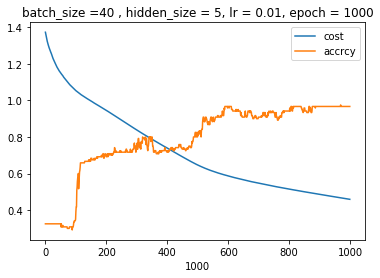

Training Accuracy:  0.9666666666666667
Test Accuracy:  0.9666666666666667
epoch:  0 cost, accuracy:  1.5052654057618449 0.35
epoch:  1 cost, accuracy:  1.3953247716613408 0.35833333333333334
epoch:  2 cost, accuracy:  1.318541221240073 0.39166666666666666
epoch:  3 cost, accuracy:  1.2582553282176316 0.5166666666666667
epoch:  4 cost, accuracy:  1.2151441565431615 0.5916666666666667
epoch:  5 cost, accuracy:  1.1701442960560042 0.6333333333333333
epoch:  6 cost, accuracy:  1.1343150456474977 0.6416666666666667
epoch:  7 cost, accuracy:  1.0986046857030913 0.675
epoch:  8 cost, accuracy:  1.058235493170894 0.675
epoch:  9 cost, accuracy:  1.0249943903304242 0.675
epoch:  10 cost, accuracy:  0.9947845833339226 0.675
epoch:  11 cost, accuracy:  0.9682327548558537 0.675
epoch:  12 cost, accuracy:  0.9402669095682695 0.675
epoch:  13 cost, accuracy:  0.9156189271142849 0.675
epoch:  14 cost, accuracy:  0.889869340738761 0.675
epoch:  15 cost, accuracy:  0.8639314021772859 0.675
epoch:  16 c

epoch:  142 cost, accuracy:  0.5360479534373026 0.825
epoch:  143 cost, accuracy:  0.5352077722571621 0.8416666666666667
epoch:  144 cost, accuracy:  0.5345680186515166 0.8333333333333334
epoch:  145 cost, accuracy:  0.5340688400321995 0.825
epoch:  146 cost, accuracy:  0.5335020585731045 0.8166666666666667
epoch:  147 cost, accuracy:  0.5325444250621799 0.8416666666666667
epoch:  148 cost, accuracy:  0.5318784104481813 0.8416666666666667
epoch:  149 cost, accuracy:  0.5311593925427852 0.875
epoch:  150 cost, accuracy:  0.5305581294464542 0.85
epoch:  151 cost, accuracy:  0.5298438402935971 0.875
epoch:  152 cost, accuracy:  0.5291683480737718 0.875
epoch:  153 cost, accuracy:  0.5284900616948449 0.9083333333333333
epoch:  154 cost, accuracy:  0.5278911637463489 0.8833333333333333
epoch:  155 cost, accuracy:  0.5271706950810714 0.9083333333333333
epoch:  156 cost, accuracy:  0.526622342747605 0.8833333333333333
epoch:  157 cost, accuracy:  0.5259125214998608 0.9083333333333333
epoch:  

epoch:  271 cost, accuracy:  0.4671624592197017 0.9333333333333333
epoch:  272 cost, accuracy:  0.46673352395611634 0.9333333333333333
epoch:  273 cost, accuracy:  0.4661353508044956 0.9416666666666667
epoch:  274 cost, accuracy:  0.46569423421169137 0.9416666666666667
epoch:  275 cost, accuracy:  0.4654227976857467 0.9416666666666667
epoch:  276 cost, accuracy:  0.46493643414288904 0.9416666666666667
epoch:  277 cost, accuracy:  0.464505082728918 0.9416666666666667
epoch:  278 cost, accuracy:  0.46412237261014133 0.9416666666666667
epoch:  279 cost, accuracy:  0.4636246286221116 0.95
epoch:  280 cost, accuracy:  0.46312045775519556 0.9416666666666667
epoch:  281 cost, accuracy:  0.4626059004549302 0.9333333333333333
epoch:  282 cost, accuracy:  0.4622907733087687 0.95
epoch:  283 cost, accuracy:  0.46175155897947895 0.9416666666666667
epoch:  284 cost, accuracy:  0.46131720026643314 0.9416666666666667
epoch:  285 cost, accuracy:  0.4608950372925228 0.9416666666666667
epoch:  286 cost,

epoch:  400 cost, accuracy:  0.41741781800054395 0.9416666666666667
epoch:  401 cost, accuracy:  0.41710504622503836 0.9416666666666667
epoch:  402 cost, accuracy:  0.41685147130602923 0.9583333333333334
epoch:  403 cost, accuracy:  0.4167751440114336 0.9583333333333334
epoch:  404 cost, accuracy:  0.41633950510827283 0.9583333333333334
epoch:  405 cost, accuracy:  0.41638526308215745 0.95
epoch:  406 cost, accuracy:  0.41596807819459036 0.95
epoch:  407 cost, accuracy:  0.4154910369832451 0.9583333333333334
epoch:  408 cost, accuracy:  0.4150733865586765 0.9583333333333334
epoch:  409 cost, accuracy:  0.4146325393358462 0.9583333333333334
epoch:  410 cost, accuracy:  0.4141784123004469 0.9583333333333334
epoch:  411 cost, accuracy:  0.4137963685472382 0.9583333333333334
epoch:  412 cost, accuracy:  0.4133676268540457 0.9416666666666667
epoch:  413 cost, accuracy:  0.41306356971933045 0.9416666666666667
epoch:  414 cost, accuracy:  0.41272164173857284 0.9416666666666667
epoch:  415 cos

epoch:  538 cost, accuracy:  0.3751428207264816 0.975
epoch:  539 cost, accuracy:  0.3749493412146736 0.975
epoch:  540 cost, accuracy:  0.3747180453404725 0.975
epoch:  541 cost, accuracy:  0.37444164302204563 0.975
epoch:  542 cost, accuracy:  0.3740335242558403 0.9666666666666667
epoch:  543 cost, accuracy:  0.3737297253232223 0.9583333333333334
epoch:  544 cost, accuracy:  0.37342620609839466 0.9583333333333334
epoch:  545 cost, accuracy:  0.3731510076188621 0.9583333333333334
epoch:  546 cost, accuracy:  0.37291302041565955 0.95
epoch:  547 cost, accuracy:  0.3727114813474663 0.95
epoch:  548 cost, accuracy:  0.3726412289890958 0.9583333333333334
epoch:  549 cost, accuracy:  0.37261519641041335 0.9583333333333334
epoch:  550 cost, accuracy:  0.37190494657868267 0.95
epoch:  551 cost, accuracy:  0.3716947386158057 0.9666666666666667
epoch:  552 cost, accuracy:  0.37127463113557024 0.9583333333333334
epoch:  553 cost, accuracy:  0.37102927831048654 0.95
epoch:  554 cost, accuracy:  

epoch:  670 cost, accuracy:  0.34142098812564814 0.9666666666666667
epoch:  671 cost, accuracy:  0.3409093966250232 0.9583333333333334
epoch:  672 cost, accuracy:  0.34065423190440725 0.9583333333333334
epoch:  673 cost, accuracy:  0.34041628430382576 0.975
epoch:  674 cost, accuracy:  0.3401935185521613 0.975
epoch:  675 cost, accuracy:  0.3399096576391713 0.9583333333333334
epoch:  676 cost, accuracy:  0.339735028930748 0.9583333333333334
epoch:  677 cost, accuracy:  0.33949467893502766 0.9583333333333334
epoch:  678 cost, accuracy:  0.339200055773514 0.9583333333333334
epoch:  679 cost, accuracy:  0.3389659185789936 0.9583333333333334
epoch:  680 cost, accuracy:  0.3387056122624063 0.9583333333333334
epoch:  681 cost, accuracy:  0.3384771600751006 0.9583333333333334
epoch:  682 cost, accuracy:  0.33825740682068983 0.9583333333333334
epoch:  683 cost, accuracy:  0.3382455452505961 0.975
epoch:  684 cost, accuracy:  0.33788186914035095 0.975
epoch:  685 cost, accuracy:  0.337611263359

epoch:  803 cost, accuracy:  0.31111083873462514 0.975
epoch:  804 cost, accuracy:  0.310710775017478 0.975
epoch:  805 cost, accuracy:  0.31054066145833387 0.975
epoch:  806 cost, accuracy:  0.3102542571106657 0.9666666666666667
epoch:  807 cost, accuracy:  0.3100702109425988 0.975
epoch:  808 cost, accuracy:  0.30988433541842625 0.975
epoch:  809 cost, accuracy:  0.3096494392932258 0.9583333333333334
epoch:  810 cost, accuracy:  0.3093843472425036 0.975
epoch:  811 cost, accuracy:  0.30915316156948724 0.975
epoch:  812 cost, accuracy:  0.30896324530448477 0.975
epoch:  813 cost, accuracy:  0.3087407507174266 0.975
epoch:  814 cost, accuracy:  0.3086459566292685 0.9583333333333334
epoch:  815 cost, accuracy:  0.3085025777184731 0.9583333333333334
epoch:  816 cost, accuracy:  0.30816073774354535 0.9583333333333334
epoch:  817 cost, accuracy:  0.3079435240189888 0.9583333333333334
epoch:  818 cost, accuracy:  0.3077361906965603 0.9583333333333334
epoch:  819 cost, accuracy:  0.307754355

epoch:  937 cost, accuracy:  0.28396506357344803 0.975
epoch:  938 cost, accuracy:  0.2840725079830483 0.9666666666666667
epoch:  939 cost, accuracy:  0.2835768170230815 0.9583333333333334
epoch:  940 cost, accuracy:  0.2834922920775931 0.9666666666666667
epoch:  941 cost, accuracy:  0.2832553294739764 0.9583333333333334
epoch:  942 cost, accuracy:  0.28304017003268706 0.9583333333333334
epoch:  943 cost, accuracy:  0.2828373229848552 0.975
epoch:  944 cost, accuracy:  0.2827212190507627 0.9583333333333334
epoch:  945 cost, accuracy:  0.2827724822091196 0.9666666666666667
epoch:  946 cost, accuracy:  0.2825558794208419 0.9666666666666667
epoch:  947 cost, accuracy:  0.28226316788404515 0.9666666666666667
epoch:  948 cost, accuracy:  0.2819026593586133 0.975
epoch:  949 cost, accuracy:  0.281724228532009 0.975
epoch:  950 cost, accuracy:  0.2817243212876071 0.9666666666666667
epoch:  951 cost, accuracy:  0.28203411113589644 0.9666666666666667
epoch:  952 cost, accuracy:  0.2821072946725

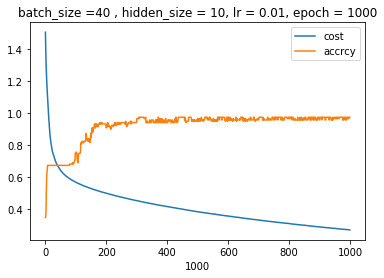

Training Accuracy:  0.9583333333333334
Test Accuracy:  1.0
epoch:  0 cost, accuracy:  1.4062424028340905 0.35
epoch:  1 cost, accuracy:  1.3891077460979397 0.35
epoch:  2 cost, accuracy:  1.3689219847288934 0.35
epoch:  3 cost, accuracy:  1.3507147565114608 0.35
epoch:  4 cost, accuracy:  1.3297748067422555 0.35
epoch:  5 cost, accuracy:  1.3107291766774485 0.35
epoch:  6 cost, accuracy:  1.2978953245882348 0.35
epoch:  7 cost, accuracy:  1.2839974436551291 0.35
epoch:  8 cost, accuracy:  1.270378595483568 0.35
epoch:  9 cost, accuracy:  1.2614948483931474 0.35
epoch:  10 cost, accuracy:  1.2506288784276334 0.35
epoch:  11 cost, accuracy:  1.240645522308886 0.35
epoch:  12 cost, accuracy:  1.228781999517497 0.35
epoch:  13 cost, accuracy:  1.2199483146566446 0.35
epoch:  14 cost, accuracy:  1.21380474392322 0.35
epoch:  15 cost, accuracy:  1.207400743961364 0.35
epoch:  16 cost, accuracy:  1.2004489609254576 0.35
epoch:  17 cost, accuracy:  1.1939974666366358 0.35
epoch:  18 cost, accu

epoch:  140 cost, accuracy:  1.0761406295658844 0.43333333333333335
epoch:  141 cost, accuracy:  1.0754491370700492 0.4083333333333333
epoch:  142 cost, accuracy:  1.0745999494180216 0.4583333333333333
epoch:  143 cost, accuracy:  1.0739077192795772 0.45
epoch:  144 cost, accuracy:  1.0732769969708822 0.4166666666666667
epoch:  145 cost, accuracy:  1.0725382099499872 0.4166666666666667
epoch:  146 cost, accuracy:  1.07177713512464 0.4166666666666667
epoch:  147 cost, accuracy:  1.071128007820369 0.4
epoch:  148 cost, accuracy:  1.07033261904915 0.45
epoch:  149 cost, accuracy:  1.069460511226532 0.4583333333333333
epoch:  150 cost, accuracy:  1.0688373752352998 0.49166666666666664
epoch:  151 cost, accuracy:  1.0683433231942954 0.44166666666666665
epoch:  152 cost, accuracy:  1.0675799661711658 0.44166666666666665
epoch:  153 cost, accuracy:  1.0667138231407567 0.45
epoch:  154 cost, accuracy:  1.065897373103534 0.45
epoch:  155 cost, accuracy:  1.0650992551874208 0.4583333333333333
ep

epoch:  271 cost, accuracy:  0.9827167412524473 0.6666666666666666
epoch:  272 cost, accuracy:  0.9818726887246442 0.6666666666666666
epoch:  273 cost, accuracy:  0.9810042361474304 0.6666666666666666
epoch:  274 cost, accuracy:  0.9802011672965624 0.6666666666666666
epoch:  275 cost, accuracy:  0.9794028069082988 0.6666666666666666
epoch:  276 cost, accuracy:  0.9784964521320858 0.6666666666666666
epoch:  277 cost, accuracy:  0.9776339000731845 0.6666666666666666
epoch:  278 cost, accuracy:  0.9767767002549526 0.6666666666666666
epoch:  279 cost, accuracy:  0.9759061778675426 0.6666666666666666
epoch:  280 cost, accuracy:  0.9750349009344167 0.6666666666666666
epoch:  281 cost, accuracy:  0.9741350235565864 0.6666666666666666
epoch:  282 cost, accuracy:  0.9732703977556088 0.6666666666666666
epoch:  283 cost, accuracy:  0.9724367699011508 0.6666666666666666
epoch:  284 cost, accuracy:  0.9716034604539203 0.675
epoch:  285 cost, accuracy:  0.9707135162295406 0.6666666666666666
epoch:  

epoch:  408 cost, accuracy:  0.8593669587405496 0.7333333333333333
epoch:  409 cost, accuracy:  0.8584860028589266 0.6833333333333333
epoch:  410 cost, accuracy:  0.8576311376970801 0.675
epoch:  411 cost, accuracy:  0.856885152343657 0.675
epoch:  412 cost, accuracy:  0.855998840694338 0.675
epoch:  413 cost, accuracy:  0.8551345466748717 0.675
epoch:  414 cost, accuracy:  0.8543107906999824 0.6833333333333333
epoch:  415 cost, accuracy:  0.8535782457859571 0.6916666666666667
epoch:  416 cost, accuracy:  0.8527311922096821 0.7333333333333333
epoch:  417 cost, accuracy:  0.8519677644366098 0.7333333333333333
epoch:  418 cost, accuracy:  0.8510431370430482 0.6916666666666667
epoch:  419 cost, accuracy:  0.85011737949477 0.6833333333333333
epoch:  420 cost, accuracy:  0.8492627186683657 0.725
epoch:  421 cost, accuracy:  0.8483160211809798 0.725
epoch:  422 cost, accuracy:  0.8474278341510261 0.7
epoch:  423 cost, accuracy:  0.84658437047117 0.7333333333333333
epoch:  424 cost, accuracy:

epoch:  552 cost, accuracy:  0.7522780230349798 0.875
epoch:  553 cost, accuracy:  0.7517245824129387 0.8583333333333333
epoch:  554 cost, accuracy:  0.7510324112182921 0.8666666666666667
epoch:  555 cost, accuracy:  0.7504270073895323 0.85
epoch:  556 cost, accuracy:  0.7498010648513329 0.8083333333333333
epoch:  557 cost, accuracy:  0.7492640545536766 0.9
epoch:  558 cost, accuracy:  0.7485990764030459 0.8416666666666667
epoch:  559 cost, accuracy:  0.7479636169604098 0.75
epoch:  560 cost, accuracy:  0.7473538344876072 0.7333333333333333
epoch:  561 cost, accuracy:  0.74677288661053 0.7166666666666667
epoch:  562 cost, accuracy:  0.7461753010187486 0.675
epoch:  563 cost, accuracy:  0.7455793379566444 0.675
epoch:  564 cost, accuracy:  0.7450051024631782 0.675
epoch:  565 cost, accuracy:  0.7444453678134331 0.675
epoch:  566 cost, accuracy:  0.7438425821740471 0.675
epoch:  567 cost, accuracy:  0.7432844242155708 0.675
epoch:  568 cost, accuracy:  0.7427236561971978 0.675
epoch:  56

epoch:  687 cost, accuracy:  0.6835286726202072 0.6916666666666667
epoch:  688 cost, accuracy:  0.683129068669493 0.675
epoch:  689 cost, accuracy:  0.6827232193423498 0.675
epoch:  690 cost, accuracy:  0.6823008054017315 0.6916666666666667
epoch:  691 cost, accuracy:  0.6818879503634253 0.6916666666666667
epoch:  692 cost, accuracy:  0.6814806597866611 0.6916666666666667
epoch:  693 cost, accuracy:  0.6810878114611781 0.675
epoch:  694 cost, accuracy:  0.6807025274546411 0.675
epoch:  695 cost, accuracy:  0.6802815628315719 0.6833333333333333
epoch:  696 cost, accuracy:  0.6799449366796081 0.675
epoch:  697 cost, accuracy:  0.6795440710387344 0.675
epoch:  698 cost, accuracy:  0.6790910838024864 0.675
epoch:  699 cost, accuracy:  0.6787701552972023 0.675
epoch:  700 cost, accuracy:  0.6783175834101355 0.675
epoch:  701 cost, accuracy:  0.6779545596870143 0.675
epoch:  702 cost, accuracy:  0.677495643205866 0.675
epoch:  703 cost, accuracy:  0.6771942905883173 0.675
epoch:  704 cost, a

epoch:  830 cost, accuracy:  0.6349065287431828 0.775
epoch:  831 cost, accuracy:  0.6346132254708085 0.8083333333333333
epoch:  832 cost, accuracy:  0.6343256741121841 0.7416666666666667
epoch:  833 cost, accuracy:  0.6340870735869575 0.8166666666666667
epoch:  834 cost, accuracy:  0.6337307799963364 0.7416666666666667
epoch:  835 cost, accuracy:  0.6334216226831193 0.7
epoch:  836 cost, accuracy:  0.6331271015965697 0.6916666666666667
epoch:  837 cost, accuracy:  0.63288398863601 0.6916666666666667
epoch:  838 cost, accuracy:  0.632597891635516 0.6916666666666667
epoch:  839 cost, accuracy:  0.6322985511608404 0.6916666666666667
epoch:  840 cost, accuracy:  0.6320553793677716 0.7
epoch:  841 cost, accuracy:  0.6318235261605502 0.7166666666666667
epoch:  842 cost, accuracy:  0.6315024780073519 0.7
epoch:  843 cost, accuracy:  0.6312606158858093 0.7416666666666667
epoch:  844 cost, accuracy:  0.6310281349917003 0.7583333333333333
epoch:  845 cost, accuracy:  0.630745423146665 0.75
epoc

epoch:  959 cost, accuracy:  0.6040282567779127 0.7
epoch:  960 cost, accuracy:  0.603804750603455 0.7
epoch:  961 cost, accuracy:  0.6036000703142342 0.7
epoch:  962 cost, accuracy:  0.6033983563334672 0.6916666666666667
epoch:  963 cost, accuracy:  0.6031757483989951 0.7
epoch:  964 cost, accuracy:  0.60299512157961 0.6916666666666667
epoch:  965 cost, accuracy:  0.6027905771015886 0.6916666666666667
epoch:  966 cost, accuracy:  0.6025713990152314 0.6916666666666667
epoch:  967 cost, accuracy:  0.6023697326535813 0.6916666666666667
epoch:  968 cost, accuracy:  0.6021717069782612 0.6916666666666667
epoch:  969 cost, accuracy:  0.6019658960060752 0.6916666666666667
epoch:  970 cost, accuracy:  0.6017830752889156 0.6916666666666667
epoch:  971 cost, accuracy:  0.6015861867729004 0.6916666666666667
epoch:  972 cost, accuracy:  0.6013947621281116 0.6916666666666667
epoch:  973 cost, accuracy:  0.601172477271546 0.6916666666666667
epoch:  974 cost, accuracy:  0.6009729860157599 0.691666666

epoch:  1091 cost, accuracy:  0.5805912712888969 0.6916666666666667
epoch:  1092 cost, accuracy:  0.5804248133933062 0.7083333333333334
epoch:  1093 cost, accuracy:  0.5802707543547801 0.7
epoch:  1094 cost, accuracy:  0.5801366611890664 0.7666666666666667
epoch:  1095 cost, accuracy:  0.579973694430514 0.8166666666666667
epoch:  1096 cost, accuracy:  0.579772774435608 0.7
epoch:  1097 cost, accuracy:  0.5796238722339809 0.7166666666666667
epoch:  1098 cost, accuracy:  0.5795026499378435 0.8083333333333333
epoch:  1099 cost, accuracy:  0.5794183440092352 0.925
epoch:  1100 cost, accuracy:  0.5792534796190072 0.9166666666666666
epoch:  1101 cost, accuracy:  0.5791858445327616 0.7833333333333333
epoch:  1102 cost, accuracy:  0.578904878657042 0.85
epoch:  1103 cost, accuracy:  0.5788097018937287 0.9333333333333333
epoch:  1104 cost, accuracy:  0.5786256111753113 0.9
epoch:  1105 cost, accuracy:  0.5784608585229104 0.8916666666666667
epoch:  1106 cost, accuracy:  0.5783151390780681 0.8916

epoch:  1219 cost, accuracy:  0.5632454724524928 0.6833333333333333
epoch:  1220 cost, accuracy:  0.5631931624409025 0.675
epoch:  1221 cost, accuracy:  0.5630229364106432 0.6833333333333333
epoch:  1222 cost, accuracy:  0.5629188242472665 0.6833333333333333
epoch:  1223 cost, accuracy:  0.5627195115672072 0.6916666666666667
epoch:  1224 cost, accuracy:  0.5625415127056177 0.6916666666666667
epoch:  1225 cost, accuracy:  0.5624343929935254 0.6916666666666667
epoch:  1226 cost, accuracy:  0.5622878726026659 0.7
epoch:  1227 cost, accuracy:  0.5621810606485975 0.7416666666666667
epoch:  1228 cost, accuracy:  0.562064404099732 0.7416666666666667
epoch:  1229 cost, accuracy:  0.561940990638062 0.7166666666666667
epoch:  1230 cost, accuracy:  0.5618246918466803 0.7083333333333334
epoch:  1231 cost, accuracy:  0.5617138399030551 0.7166666666666667
epoch:  1232 cost, accuracy:  0.5615982860430095 0.7166666666666667
epoch:  1233 cost, accuracy:  0.5615318019947383 0.8416666666666667
epoch:  12

epoch:  1347 cost, accuracy:  0.5498119040428588 0.675
epoch:  1348 cost, accuracy:  0.5497129437925357 0.675
epoch:  1349 cost, accuracy:  0.5495311949356659 0.675
epoch:  1350 cost, accuracy:  0.5493241117187703 0.6833333333333333
epoch:  1351 cost, accuracy:  0.5491971439849512 0.6916666666666667
epoch:  1352 cost, accuracy:  0.5490965603677359 0.6916666666666667
epoch:  1353 cost, accuracy:  0.5489676019791292 0.6916666666666667
epoch:  1354 cost, accuracy:  0.5488989029668827 0.6916666666666667
epoch:  1355 cost, accuracy:  0.5487869465709168 0.6916666666666667
epoch:  1356 cost, accuracy:  0.548697467776712 0.6916666666666667
epoch:  1357 cost, accuracy:  0.5485938208552189 0.6916666666666667
epoch:  1358 cost, accuracy:  0.5484744540985851 0.7
epoch:  1359 cost, accuracy:  0.5483797976393258 0.7
epoch:  1360 cost, accuracy:  0.5483000619078664 0.6916666666666667
epoch:  1361 cost, accuracy:  0.5482148939482947 0.6916666666666667
epoch:  1362 cost, accuracy:  0.5481132844758697 0

epoch:  1481 cost, accuracy:  0.5380687499794732 0.7416666666666667
epoch:  1482 cost, accuracy:  0.5380100434518709 0.8166666666666667
epoch:  1483 cost, accuracy:  0.5379572860849201 0.875
epoch:  1484 cost, accuracy:  0.5378688092600706 0.8416666666666667
epoch:  1485 cost, accuracy:  0.5377741895073381 0.8083333333333333
epoch:  1486 cost, accuracy:  0.5376945395644164 0.7916666666666666
epoch:  1487 cost, accuracy:  0.5376028663533521 0.7166666666666667
epoch:  1488 cost, accuracy:  0.5375342211676856 0.7583333333333333
epoch:  1489 cost, accuracy:  0.5374535823624264 0.7416666666666667
epoch:  1490 cost, accuracy:  0.53741084077447 0.8416666666666667
epoch:  1491 cost, accuracy:  0.5373328136442621 0.8416666666666667
epoch:  1492 cost, accuracy:  0.5372489952504649 0.8166666666666667
epoch:  1493 cost, accuracy:  0.537238033149393 0.9333333333333333
epoch:  1494 cost, accuracy:  0.5371915228975535 0.95
epoch:  1495 cost, accuracy:  0.5370831253695679 0.9166666666666666
epoch:  14

epoch:  1614 cost, accuracy:  0.5289258664141784 0.925
epoch:  1615 cost, accuracy:  0.5288695006551276 0.875
epoch:  1616 cost, accuracy:  0.5287828120547536 0.9333333333333333
epoch:  1617 cost, accuracy:  0.5287021565184138 0.95
epoch:  1618 cost, accuracy:  0.5285989175603788 0.9083333333333333
epoch:  1619 cost, accuracy:  0.5285230777001604 0.8833333333333333
epoch:  1620 cost, accuracy:  0.5284518283784767 0.875
epoch:  1621 cost, accuracy:  0.5283966685408129 0.8833333333333333
epoch:  1622 cost, accuracy:  0.5282856796220478 0.7416666666666667
epoch:  1623 cost, accuracy:  0.5282301451658798 0.8
epoch:  1624 cost, accuracy:  0.5281643312553534 0.8
epoch:  1625 cost, accuracy:  0.5280962692482273 0.7416666666666667
epoch:  1626 cost, accuracy:  0.5280693767593104 0.8416666666666667
epoch:  1627 cost, accuracy:  0.5279846820683164 0.8166666666666667
epoch:  1628 cost, accuracy:  0.5279172533122855 0.8
epoch:  1629 cost, accuracy:  0.5278936982025252 0.8583333333333333
epoch:  16

epoch:  1746 cost, accuracy:  0.521194972412885 0.7
epoch:  1747 cost, accuracy:  0.521113885204327 0.7
epoch:  1748 cost, accuracy:  0.5210292954522397 0.7083333333333334
epoch:  1749 cost, accuracy:  0.5209808939860419 0.7
epoch:  1750 cost, accuracy:  0.5209492875317564 0.7
epoch:  1751 cost, accuracy:  0.5208932479879809 0.7
epoch:  1752 cost, accuracy:  0.5208585970266714 0.7
epoch:  1753 cost, accuracy:  0.5207658486186628 0.7083333333333334
epoch:  1754 cost, accuracy:  0.520779722757052 0.6916666666666667
epoch:  1755 cost, accuracy:  0.520730961048169 0.6916666666666667
epoch:  1756 cost, accuracy:  0.5206941815715818 0.6916666666666667
epoch:  1757 cost, accuracy:  0.520610334776657 0.7
epoch:  1758 cost, accuracy:  0.5205645216480088 0.7
epoch:  1759 cost, accuracy:  0.5204911060915854 0.7
epoch:  1760 cost, accuracy:  0.5204424455875994 0.7
epoch:  1761 cost, accuracy:  0.5203631135312125 0.7
epoch:  1762 cost, accuracy:  0.5202841618301413 0.7083333333333334
epoch:  1763 c

epoch:  1878 cost, accuracy:  0.5147888240254407 0.6916666666666667
epoch:  1879 cost, accuracy:  0.514702229114856 0.7
epoch:  1880 cost, accuracy:  0.514671942187529 0.7
epoch:  1881 cost, accuracy:  0.514672360979716 0.6916666666666667
epoch:  1882 cost, accuracy:  0.5147044804247238 0.6916666666666667
epoch:  1883 cost, accuracy:  0.514599786247648 0.6916666666666667
epoch:  1884 cost, accuracy:  0.514559146793114 0.6916666666666667
epoch:  1885 cost, accuracy:  0.5144953349985245 0.6916666666666667
epoch:  1886 cost, accuracy:  0.5144201642715086 0.6916666666666667
epoch:  1887 cost, accuracy:  0.5143358796970401 0.7
epoch:  1888 cost, accuracy:  0.5142667033814975 0.7
epoch:  1889 cost, accuracy:  0.5142426417007926 0.7
epoch:  1890 cost, accuracy:  0.5142403969749302 0.6916666666666667
epoch:  1891 cost, accuracy:  0.5141364413053798 0.7
epoch:  1892 cost, accuracy:  0.5141159769050798 0.7
epoch:  1893 cost, accuracy:  0.5139981820743337 0.725
epoch:  1894 cost, accuracy:  0.513

epoch:  2013 cost, accuracy:  0.508995111407425 0.8166666666666667
epoch:  2014 cost, accuracy:  0.5089539632519302 0.8166666666666667
epoch:  2015 cost, accuracy:  0.5089048588449118 0.7416666666666667
epoch:  2016 cost, accuracy:  0.5088721350614946 0.7166666666666667
epoch:  2017 cost, accuracy:  0.5088975974727761 0.7
epoch:  2018 cost, accuracy:  0.5088616341367452 0.7
epoch:  2019 cost, accuracy:  0.5088273901485201 0.7
epoch:  2020 cost, accuracy:  0.508716441644178 0.7166666666666667
epoch:  2021 cost, accuracy:  0.5086714516078449 0.725
epoch:  2022 cost, accuracy:  0.5086352462080639 0.725
epoch:  2023 cost, accuracy:  0.5086258205719214 0.7083333333333334
epoch:  2024 cost, accuracy:  0.5085977995281504 0.7083333333333334
epoch:  2025 cost, accuracy:  0.5085850876418079 0.7
epoch:  2026 cost, accuracy:  0.5085090210106712 0.7083333333333334
epoch:  2027 cost, accuracy:  0.508481909540817 0.7083333333333334
epoch:  2028 cost, accuracy:  0.5084286644743741 0.7083333333333334
e

epoch:  2144 cost, accuracy:  0.5041447960454933 0.8166666666666667
epoch:  2145 cost, accuracy:  0.5041112429952116 0.8166666666666667
epoch:  2146 cost, accuracy:  0.5040710151055532 0.75
epoch:  2147 cost, accuracy:  0.5040377224763746 0.8083333333333333
epoch:  2148 cost, accuracy:  0.5040031864567116 0.8166666666666667
epoch:  2149 cost, accuracy:  0.5039826605728434 0.8333333333333334
epoch:  2150 cost, accuracy:  0.503958702788169 0.8416666666666667
epoch:  2151 cost, accuracy:  0.5039642762337576 0.9166666666666666
epoch:  2152 cost, accuracy:  0.5039131642338229 0.9083333333333333
epoch:  2153 cost, accuracy:  0.5038867035048378 0.9083333333333333
epoch:  2154 cost, accuracy:  0.5038678024209285 0.9333333333333333
epoch:  2155 cost, accuracy:  0.5038033952093358 0.8833333333333333
epoch:  2156 cost, accuracy:  0.5037268081497 0.8166666666666667
epoch:  2157 cost, accuracy:  0.5037110818567343 0.8416666666666667
epoch:  2158 cost, accuracy:  0.5037030828004775 0.883333333333333

epoch:  2274 cost, accuracy:  0.4998864655366157 0.7083333333333334
epoch:  2275 cost, accuracy:  0.49988501554622466 0.7
epoch:  2276 cost, accuracy:  0.4998379835604564 0.7083333333333334
epoch:  2277 cost, accuracy:  0.49994184956372867 0.7
epoch:  2278 cost, accuracy:  0.49985272161108474 0.7
epoch:  2279 cost, accuracy:  0.49995032940522205 0.6916666666666667
epoch:  2280 cost, accuracy:  0.49976882973454834 0.7
epoch:  2281 cost, accuracy:  0.4997760091443441 0.7
epoch:  2282 cost, accuracy:  0.499784313520274 0.7
epoch:  2283 cost, accuracy:  0.49968254408743107 0.7
epoch:  2284 cost, accuracy:  0.49958491356559676 0.7083333333333334
epoch:  2285 cost, accuracy:  0.49959349734080655 0.7
epoch:  2286 cost, accuracy:  0.499482336578982 0.7083333333333334
epoch:  2287 cost, accuracy:  0.49942338696578886 0.725
epoch:  2288 cost, accuracy:  0.49940158700746284 0.7166666666666667
epoch:  2289 cost, accuracy:  0.4993394753109631 0.7416666666666667
epoch:  2290 cost, accuracy:  0.49930

epoch:  2403 cost, accuracy:  0.49589706643190046 0.8416666666666667
epoch:  2404 cost, accuracy:  0.495881546112116 0.8666666666666667
epoch:  2405 cost, accuracy:  0.4959079191862269 0.95
epoch:  2406 cost, accuracy:  0.4958882176912226 0.9583333333333334
epoch:  2407 cost, accuracy:  0.49592810135703325 0.925
epoch:  2408 cost, accuracy:  0.49589995081456484 0.925
epoch:  2409 cost, accuracy:  0.49580312565657303 0.95
epoch:  2410 cost, accuracy:  0.4957339998382663 0.9083333333333333
epoch:  2411 cost, accuracy:  0.49572110182774753 0.925
epoch:  2412 cost, accuracy:  0.49577082757796825 0.9416666666666667
epoch:  2413 cost, accuracy:  0.49566422431588075 0.925
epoch:  2414 cost, accuracy:  0.49564609268520193 0.95
epoch:  2415 cost, accuracy:  0.49563557966008087 0.9583333333333334
epoch:  2416 cost, accuracy:  0.49561838344447984 0.95
epoch:  2417 cost, accuracy:  0.49560049742909223 0.95
epoch:  2418 cost, accuracy:  0.4956223807853402 0.8916666666666667
epoch:  2419 cost, accur

epoch:  2530 cost, accuracy:  0.4922580673758437 0.8333333333333334
epoch:  2531 cost, accuracy:  0.4922398091588355 0.75
epoch:  2532 cost, accuracy:  0.4922100488322276 0.7583333333333333
epoch:  2533 cost, accuracy:  0.49217527365813724 0.8166666666666667
epoch:  2534 cost, accuracy:  0.4921640865222348 0.7416666666666667
epoch:  2535 cost, accuracy:  0.4921917212111072 0.7166666666666667
epoch:  2536 cost, accuracy:  0.4921274309756774 0.7416666666666667
epoch:  2537 cost, accuracy:  0.49207454459947914 0.75
epoch:  2538 cost, accuracy:  0.49208802260234447 0.725
epoch:  2539 cost, accuracy:  0.49202484642519256 0.7416666666666667
epoch:  2540 cost, accuracy:  0.49198372652793315 0.8333333333333334
epoch:  2541 cost, accuracy:  0.49195035320051445 0.8166666666666667
epoch:  2542 cost, accuracy:  0.49192465456149514 0.8083333333333333
epoch:  2543 cost, accuracy:  0.49189487003638455 0.8166666666666667
epoch:  2544 cost, accuracy:  0.49188344568821873 0.8416666666666667
epoch:  2545

epoch:  2657 cost, accuracy:  0.48874911067128923 0.7416666666666667
epoch:  2658 cost, accuracy:  0.48871445639559347 0.75
epoch:  2659 cost, accuracy:  0.4886640541257879 0.8166666666666667
epoch:  2660 cost, accuracy:  0.48863395315880115 0.8166666666666667
epoch:  2661 cost, accuracy:  0.4886040250309938 0.8166666666666667
epoch:  2662 cost, accuracy:  0.4885727090243716 0.825
epoch:  2663 cost, accuracy:  0.4885445944197325 0.8166666666666667
epoch:  2664 cost, accuracy:  0.4885399576019094 0.7583333333333333
epoch:  2665 cost, accuracy:  0.48849456507310063 0.8166666666666667
epoch:  2666 cost, accuracy:  0.48847774815845696 0.7666666666666667
epoch:  2667 cost, accuracy:  0.48843288505137944 0.8166666666666667
epoch:  2668 cost, accuracy:  0.48840507050218046 0.825
epoch:  2669 cost, accuracy:  0.4883898710086007 0.8416666666666667
epoch:  2670 cost, accuracy:  0.4883558270718535 0.8416666666666667
epoch:  2671 cost, accuracy:  0.488319812500472 0.8166666666666667
epoch:  2672 c

epoch:  2784 cost, accuracy:  0.4850849367907998 0.7666666666666667
epoch:  2785 cost, accuracy:  0.48508648967109036 0.7416666666666667
epoch:  2786 cost, accuracy:  0.48501506517964643 0.8
epoch:  2787 cost, accuracy:  0.4850066247451174 0.7583333333333333
epoch:  2788 cost, accuracy:  0.48495692779874877 0.7833333333333333
epoch:  2789 cost, accuracy:  0.4849107881755264 0.8416666666666667
epoch:  2790 cost, accuracy:  0.4848708275762175 0.8333333333333334
epoch:  2791 cost, accuracy:  0.4848447588625496 0.8416666666666667
epoch:  2792 cost, accuracy:  0.48481776099279245 0.8416666666666667
epoch:  2793 cost, accuracy:  0.4848115252756821 0.8833333333333333
epoch:  2794 cost, accuracy:  0.48478759056279036 0.9083333333333333
epoch:  2795 cost, accuracy:  0.48472091111077964 0.8416666666666667
epoch:  2796 cost, accuracy:  0.48470378330039865 0.8666666666666667
epoch:  2797 cost, accuracy:  0.4846878834904377 0.8833333333333333
epoch:  2798 cost, accuracy:  0.4846268057275154 0.84166

epoch:  2914 cost, accuracy:  0.480942690577623 0.95
epoch:  2915 cost, accuracy:  0.48090315429057434 0.95
epoch:  2916 cost, accuracy:  0.48080881613990495 0.8916666666666667
epoch:  2917 cost, accuracy:  0.48076341507139364 0.8833333333333333
epoch:  2918 cost, accuracy:  0.48071063455220747 0.8416666666666667
epoch:  2919 cost, accuracy:  0.4806846484231065 0.8666666666666667
epoch:  2920 cost, accuracy:  0.4806433772223022 0.8666666666666667
epoch:  2921 cost, accuracy:  0.4806548628183027 0.9083333333333333
epoch:  2922 cost, accuracy:  0.48059512184705583 0.9
epoch:  2923 cost, accuracy:  0.4805455149939404 0.875
epoch:  2924 cost, accuracy:  0.4806058819773489 0.9583333333333334
epoch:  2925 cost, accuracy:  0.48054596700658286 0.95
epoch:  2926 cost, accuracy:  0.48054430353811567 0.9583333333333334
epoch:  2927 cost, accuracy:  0.4805460572422326 0.95
epoch:  2928 cost, accuracy:  0.48047676639666315 0.95
epoch:  2929 cost, accuracy:  0.4803728278073038 0.9166666666666666
epo

epoch:  3039 cost, accuracy:  0.47584705437166974 0.8416666666666667
epoch:  3040 cost, accuracy:  0.4758017062618727 0.8416666666666667
epoch:  3041 cost, accuracy:  0.47577564204303413 0.8333333333333334
epoch:  3042 cost, accuracy:  0.4757628660415314 0.8166666666666667
epoch:  3043 cost, accuracy:  0.47575391132158534 0.8166666666666667
epoch:  3044 cost, accuracy:  0.47571444554887077 0.8166666666666667
epoch:  3045 cost, accuracy:  0.47560460401691423 0.8333333333333334
epoch:  3046 cost, accuracy:  0.47554319763472014 0.8416666666666667
epoch:  3047 cost, accuracy:  0.4754914064208805 0.8416666666666667
epoch:  3048 cost, accuracy:  0.4754538226470247 0.8416666666666667
epoch:  3049 cost, accuracy:  0.4754740104622782 0.8166666666666667
epoch:  3050 cost, accuracy:  0.47545459041827404 0.8166666666666667
epoch:  3051 cost, accuracy:  0.4753827781360035 0.8166666666666667
epoch:  3052 cost, accuracy:  0.47528261178760745 0.8333333333333334
epoch:  3053 cost, accuracy:  0.47528781

epoch:  3161 cost, accuracy:  0.46999613280530866 0.8666666666666667
epoch:  3162 cost, accuracy:  0.4699477004904262 0.8666666666666667
epoch:  3163 cost, accuracy:  0.4699106909156117 0.8416666666666667
epoch:  3164 cost, accuracy:  0.46986667428337997 0.8416666666666667
epoch:  3165 cost, accuracy:  0.4698216400413262 0.8416666666666667
epoch:  3166 cost, accuracy:  0.4697439100447752 0.8833333333333333
epoch:  3167 cost, accuracy:  0.46969508109535085 0.8666666666666667
epoch:  3168 cost, accuracy:  0.4696507115198441 0.8416666666666667
epoch:  3169 cost, accuracy:  0.46959536175551087 0.8916666666666667
epoch:  3170 cost, accuracy:  0.46954920507772785 0.8666666666666667
epoch:  3171 cost, accuracy:  0.46949950668402174 0.8666666666666667
epoch:  3172 cost, accuracy:  0.4694530330045043 0.8666666666666667
epoch:  3173 cost, accuracy:  0.46940714659122057 0.8833333333333333
epoch:  3174 cost, accuracy:  0.4693613051112426 0.8916666666666667
epoch:  3175 cost, accuracy:  0.469307952

epoch:  3285 cost, accuracy:  0.46393000673217405 0.9083333333333333
epoch:  3286 cost, accuracy:  0.463870852220631 0.8916666666666667
epoch:  3287 cost, accuracy:  0.46382000816126756 0.8916666666666667
epoch:  3288 cost, accuracy:  0.4637697403193327 0.8833333333333333
epoch:  3289 cost, accuracy:  0.46373621716767166 0.8583333333333333
epoch:  3290 cost, accuracy:  0.46368487025116006 0.8583333333333333
epoch:  3291 cost, accuracy:  0.46363730238362266 0.8583333333333333
epoch:  3292 cost, accuracy:  0.46362634991177576 0.8416666666666667
epoch:  3293 cost, accuracy:  0.46357934884570057 0.8416666666666667
epoch:  3294 cost, accuracy:  0.46353817464557034 0.8416666666666667
epoch:  3295 cost, accuracy:  0.46345986574652304 0.8416666666666667
epoch:  3296 cost, accuracy:  0.46340499735586377 0.85
epoch:  3297 cost, accuracy:  0.4633596744720804 0.85
epoch:  3298 cost, accuracy:  0.46329508161828414 0.8583333333333333
epoch:  3299 cost, accuracy:  0.4632245658581569 0.883333333333333

epoch:  3408 cost, accuracy:  0.4575807082871279 0.9083333333333333
epoch:  3409 cost, accuracy:  0.45762029742624144 0.95
epoch:  3410 cost, accuracy:  0.45751997547661283 0.9416666666666667
epoch:  3411 cost, accuracy:  0.45754169077509727 0.9583333333333334
epoch:  3412 cost, accuracy:  0.45757749627838357 0.9666666666666667
epoch:  3413 cost, accuracy:  0.45756392657578987 0.9666666666666667
epoch:  3414 cost, accuracy:  0.45748905399695877 0.9666666666666667
epoch:  3415 cost, accuracy:  0.45731803619946 0.95
epoch:  3416 cost, accuracy:  0.4572561103469624 0.9583333333333334
epoch:  3417 cost, accuracy:  0.4571957109223723 0.95
epoch:  3418 cost, accuracy:  0.45715751937208904 0.9583333333333334
epoch:  3419 cost, accuracy:  0.45714605647482004 0.9583333333333334
epoch:  3420 cost, accuracy:  0.45707654392893726 0.9583333333333334
epoch:  3421 cost, accuracy:  0.4569651752642027 0.95
epoch:  3422 cost, accuracy:  0.456945001945871 0.9583333333333334
epoch:  3423 cost, accuracy:  

epoch:  3531 cost, accuracy:  0.4508025440166906 0.8583333333333333
epoch:  3532 cost, accuracy:  0.45067268265015464 0.8833333333333333
epoch:  3533 cost, accuracy:  0.4506101601918549 0.8833333333333333
epoch:  3534 cost, accuracy:  0.4505456508022824 0.8916666666666667
epoch:  3535 cost, accuracy:  0.4504948761326963 0.9083333333333333
epoch:  3536 cost, accuracy:  0.45042938392738313 0.8916666666666667
epoch:  3537 cost, accuracy:  0.450371511015054 0.8916666666666667
epoch:  3538 cost, accuracy:  0.4503228945910203 0.8833333333333333
epoch:  3539 cost, accuracy:  0.45026894318992305 0.8833333333333333
epoch:  3540 cost, accuracy:  0.45021064973818375 0.8916666666666667
epoch:  3541 cost, accuracy:  0.45015476982519687 0.8916666666666667
epoch:  3542 cost, accuracy:  0.4500982759546549 0.8833333333333333
epoch:  3543 cost, accuracy:  0.4500368826580708 0.9083333333333333
epoch:  3544 cost, accuracy:  0.44998543402089647 0.9083333333333333
epoch:  3545 cost, accuracy:  0.44993896092

epoch:  3661 cost, accuracy:  0.4428479022240093 0.9416666666666667
epoch:  3662 cost, accuracy:  0.44278783755045553 0.95
epoch:  3663 cost, accuracy:  0.4426867404904827 0.9166666666666666
epoch:  3664 cost, accuracy:  0.44261327367038433 0.9083333333333333
epoch:  3665 cost, accuracy:  0.44255070626208115 0.9166666666666666
epoch:  3666 cost, accuracy:  0.4424919024456488 0.9166666666666666
epoch:  3667 cost, accuracy:  0.4424415757754894 0.8833333333333333
epoch:  3668 cost, accuracy:  0.44238143437554633 0.8833333333333333
epoch:  3669 cost, accuracy:  0.44240051623233223 0.8666666666666667
epoch:  3670 cost, accuracy:  0.44221347206928246 0.9
epoch:  3671 cost, accuracy:  0.44214257408955243 0.9
epoch:  3672 cost, accuracy:  0.4420702530107248 0.9
epoch:  3673 cost, accuracy:  0.442004698999561 0.9
epoch:  3674 cost, accuracy:  0.4419333316849882 0.9166666666666666
epoch:  3675 cost, accuracy:  0.441888729981419 0.9416666666666667
epoch:  3676 cost, accuracy:  0.4418124594864994 

epoch:  3786 cost, accuracy:  0.43434272756182374 0.95
epoch:  3787 cost, accuracy:  0.4342629876852135 0.925
epoch:  3788 cost, accuracy:  0.4342207009277644 0.9416666666666667
epoch:  3789 cost, accuracy:  0.43414228618873363 0.9333333333333333
epoch:  3790 cost, accuracy:  0.43406614093952706 0.925
epoch:  3791 cost, accuracy:  0.4340112472052544 0.9333333333333333
epoch:  3792 cost, accuracy:  0.43395676949068057 0.95
epoch:  3793 cost, accuracy:  0.43386376196185217 0.925
epoch:  3794 cost, accuracy:  0.43379355566817224 0.9166666666666666
epoch:  3795 cost, accuracy:  0.43373531485251215 0.8916666666666667
epoch:  3796 cost, accuracy:  0.4337052701760682 0.8916666666666667
epoch:  3797 cost, accuracy:  0.4336218122263406 0.8916666666666667
epoch:  3798 cost, accuracy:  0.43352316515354195 0.8916666666666667
epoch:  3799 cost, accuracy:  0.4334208931574385 0.9083333333333333
epoch:  3800 cost, accuracy:  0.4333388872326831 0.9
epoch:  3801 cost, accuracy:  0.43326960377915474 0.92

epoch:  3914 cost, accuracy:  0.42479195135684655 0.9583333333333334
epoch:  3915 cost, accuracy:  0.4247003668825499 0.9583333333333334
epoch:  3916 cost, accuracy:  0.4246370637591273 0.9583333333333334
epoch:  3917 cost, accuracy:  0.4245438857495697 0.9583333333333334
epoch:  3918 cost, accuracy:  0.4245105941249741 0.9583333333333334
epoch:  3919 cost, accuracy:  0.42440016103414924 0.9583333333333334
epoch:  3920 cost, accuracy:  0.4243326931642964 0.9583333333333334
epoch:  3921 cost, accuracy:  0.4242389976585618 0.9583333333333334
epoch:  3922 cost, accuracy:  0.42411149897947276 0.9416666666666667
epoch:  3923 cost, accuracy:  0.42404144265028615 0.9333333333333333
epoch:  3924 cost, accuracy:  0.424016420752679 0.9083333333333333
epoch:  3925 cost, accuracy:  0.42390589485122676 0.9166666666666666
epoch:  3926 cost, accuracy:  0.42383575673307533 0.9333333333333333
epoch:  3927 cost, accuracy:  0.42374786612064447 0.9416666666666667
epoch:  3928 cost, accuracy:  0.4236680986

epoch:  4037 cost, accuracy:  0.4156780451121073 0.9666666666666667
epoch:  4038 cost, accuracy:  0.4162243312642116 0.9583333333333334
epoch:  4039 cost, accuracy:  0.4159965866760473 0.9583333333333334
epoch:  4040 cost, accuracy:  0.41565337931239116 0.9583333333333334
epoch:  4041 cost, accuracy:  0.4153507156372662 0.9583333333333334
epoch:  4042 cost, accuracy:  0.41500573358034953 0.9583333333333334
epoch:  4043 cost, accuracy:  0.4147618604079106 0.9666666666666667
epoch:  4044 cost, accuracy:  0.4144548225638066 0.9583333333333334
epoch:  4045 cost, accuracy:  0.4145518091570398 0.9666666666666667
epoch:  4046 cost, accuracy:  0.41424014625921257 0.9583333333333334
epoch:  4047 cost, accuracy:  0.41422895807534027 0.9583333333333334
epoch:  4048 cost, accuracy:  0.4141063577666909 0.9583333333333334
epoch:  4049 cost, accuracy:  0.414031739062352 0.9583333333333334
epoch:  4050 cost, accuracy:  0.4139588217345515 0.9583333333333334
epoch:  4051 cost, accuracy:  0.4137601528791

epoch:  4159 cost, accuracy:  0.40455350779776444 0.9083333333333333
epoch:  4160 cost, accuracy:  0.4045986273503079 0.9083333333333333
epoch:  4161 cost, accuracy:  0.4046657531909421 0.9
epoch:  4162 cost, accuracy:  0.4041879477636479 0.9083333333333333
epoch:  4163 cost, accuracy:  0.4039635843722414 0.9166666666666666
epoch:  4164 cost, accuracy:  0.4038069912443296 0.95
epoch:  4165 cost, accuracy:  0.40379810418844936 0.9166666666666666
epoch:  4166 cost, accuracy:  0.40369679263681857 0.9166666666666666
epoch:  4167 cost, accuracy:  0.40374476831287465 0.9083333333333333
epoch:  4168 cost, accuracy:  0.40351687397282826 0.9166666666666666
epoch:  4169 cost, accuracy:  0.40342643417631635 0.9166666666666666
epoch:  4170 cost, accuracy:  0.4032886661765357 0.9583333333333334
epoch:  4171 cost, accuracy:  0.40321244350667934 0.9583333333333334
epoch:  4172 cost, accuracy:  0.4032224018775738 0.9583333333333334
epoch:  4173 cost, accuracy:  0.40308607764403004 0.9583333333333334
e

epoch:  4285 cost, accuracy:  0.39261149621334984 0.9583333333333334
epoch:  4286 cost, accuracy:  0.3925579933460994 0.95
epoch:  4287 cost, accuracy:  0.3924517698355491 0.95
epoch:  4288 cost, accuracy:  0.3923566103806984 0.9583333333333334
epoch:  4289 cost, accuracy:  0.39223903794965764 0.9583333333333334
epoch:  4290 cost, accuracy:  0.3921209685764717 0.9583333333333334
epoch:  4291 cost, accuracy:  0.3920276704163636 0.95
epoch:  4292 cost, accuracy:  0.39191671900132935 0.9583333333333334
epoch:  4293 cost, accuracy:  0.3918255891770015 0.9583333333333334
epoch:  4294 cost, accuracy:  0.3918826457140857 0.9333333333333333
epoch:  4295 cost, accuracy:  0.39167375463570764 0.95
epoch:  4296 cost, accuracy:  0.3916765101008855 0.9416666666666667
epoch:  4297 cost, accuracy:  0.391560174980203 0.9416666666666667
epoch:  4298 cost, accuracy:  0.3915396855102973 0.9333333333333333
epoch:  4299 cost, accuracy:  0.39127079285109356 0.95
epoch:  4300 cost, accuracy:  0.39115199597492

epoch:  4412 cost, accuracy:  0.3804011706633195 0.9416666666666667
epoch:  4413 cost, accuracy:  0.38036333266777905 0.9416666666666667
epoch:  4414 cost, accuracy:  0.38022110813108584 0.9416666666666667
epoch:  4415 cost, accuracy:  0.3800652987116757 0.9583333333333334
epoch:  4416 cost, accuracy:  0.37997890955726893 0.9583333333333334
epoch:  4417 cost, accuracy:  0.37982980132050176 0.95
epoch:  4418 cost, accuracy:  0.3797271712063022 0.95
epoch:  4419 cost, accuracy:  0.37964669691214875 0.95
epoch:  4420 cost, accuracy:  0.37955593295140416 0.95
epoch:  4421 cost, accuracy:  0.3794741086712224 0.95
epoch:  4422 cost, accuracy:  0.37940258554085926 0.9583333333333334
epoch:  4423 cost, accuracy:  0.3793226183016947 0.9583333333333334
epoch:  4424 cost, accuracy:  0.37916775756604976 0.9583333333333334
epoch:  4425 cost, accuracy:  0.37906401681429586 0.9583333333333334
epoch:  4426 cost, accuracy:  0.3789966535462104 0.9416666666666667
epoch:  4427 cost, accuracy:  0.379008692

epoch:  4547 cost, accuracy:  0.366663945172171 0.975
epoch:  4548 cost, accuracy:  0.36653271763636036 0.975
epoch:  4549 cost, accuracy:  0.36649352679835195 0.975
epoch:  4550 cost, accuracy:  0.36647647988222354 0.975
epoch:  4551 cost, accuracy:  0.36657948389556977 0.975
epoch:  4552 cost, accuracy:  0.3662503872711246 0.975
epoch:  4553 cost, accuracy:  0.3660029390331442 0.975
epoch:  4554 cost, accuracy:  0.3659426621718101 0.9583333333333334
epoch:  4555 cost, accuracy:  0.365805145796525 0.9583333333333334
epoch:  4556 cost, accuracy:  0.3657566867789805 0.975
epoch:  4557 cost, accuracy:  0.3656913430685196 0.975
epoch:  4558 cost, accuracy:  0.3655929668620204 0.975
epoch:  4559 cost, accuracy:  0.365387667161447 0.975
epoch:  4560 cost, accuracy:  0.36530186761258043 0.975
epoch:  4561 cost, accuracy:  0.36520218623563383 0.975
epoch:  4562 cost, accuracy:  0.36504522829935404 0.975
epoch:  4563 cost, accuracy:  0.36498199139326604 0.9583333333333334
epoch:  4564 cost, ac

epoch:  4680 cost, accuracy:  0.3525284222809527 0.975
epoch:  4681 cost, accuracy:  0.35243432204006897 0.975
epoch:  4682 cost, accuracy:  0.3523001182766359 0.9666666666666667
epoch:  4683 cost, accuracy:  0.3521837807803819 0.9666666666666667
epoch:  4684 cost, accuracy:  0.3521276584176613 0.9666666666666667
epoch:  4685 cost, accuracy:  0.35257515990410454 0.9416666666666667
epoch:  4686 cost, accuracy:  0.3524900149961974 0.9416666666666667
epoch:  4687 cost, accuracy:  0.3521004984456855 0.95
epoch:  4688 cost, accuracy:  0.35200191154494215 0.95
epoch:  4689 cost, accuracy:  0.35202681706286365 0.95
epoch:  4690 cost, accuracy:  0.3518191236024676 0.95
epoch:  4691 cost, accuracy:  0.3516542088281465 0.95
epoch:  4692 cost, accuracy:  0.3514056987827426 0.95
epoch:  4693 cost, accuracy:  0.3510942288649249 0.975
epoch:  4694 cost, accuracy:  0.3510490169962447 0.975
epoch:  4695 cost, accuracy:  0.35090729288995687 0.975
epoch:  4696 cost, accuracy:  0.3509762488154316 0.975
e

epoch:  4818 cost, accuracy:  0.33755656004967355 0.9583333333333334
epoch:  4819 cost, accuracy:  0.3373265865976801 0.9583333333333334
epoch:  4820 cost, accuracy:  0.3370770521851263 0.9666666666666667
epoch:  4821 cost, accuracy:  0.33701323069833317 0.975
epoch:  4822 cost, accuracy:  0.33698904075401764 0.9583333333333334
epoch:  4823 cost, accuracy:  0.33722301897108525 0.9583333333333334
epoch:  4824 cost, accuracy:  0.33717853029689965 0.95
epoch:  4825 cost, accuracy:  0.3374418258014068 0.95
epoch:  4826 cost, accuracy:  0.3372413834796901 0.95
epoch:  4827 cost, accuracy:  0.33649892752791893 0.9583333333333334
epoch:  4828 cost, accuracy:  0.3363010222986565 0.9583333333333334
epoch:  4829 cost, accuracy:  0.3362955185647249 0.9583333333333334
epoch:  4830 cost, accuracy:  0.3360573578415098 0.9583333333333334
epoch:  4831 cost, accuracy:  0.33594000710811817 0.9583333333333334
epoch:  4832 cost, accuracy:  0.3360985133628398 0.9583333333333334
epoch:  4833 cost, accuracy:

epoch:  4954 cost, accuracy:  0.32236373331578366 0.9583333333333334
epoch:  4955 cost, accuracy:  0.3224621819452263 0.9583333333333334
epoch:  4956 cost, accuracy:  0.32210661835671267 0.9583333333333334
epoch:  4957 cost, accuracy:  0.32196058706677017 0.9666666666666667
epoch:  4958 cost, accuracy:  0.32183657040885716 0.9666666666666667
epoch:  4959 cost, accuracy:  0.321729147602337 0.9666666666666667
epoch:  4960 cost, accuracy:  0.3216103228514716 0.9666666666666667
epoch:  4961 cost, accuracy:  0.3215084251485905 0.9666666666666667
epoch:  4962 cost, accuracy:  0.32136540217274434 0.9666666666666667
epoch:  4963 cost, accuracy:  0.32148058113311406 0.9583333333333334
epoch:  4964 cost, accuracy:  0.3212540230280662 0.9583333333333334
epoch:  4965 cost, accuracy:  0.3214589173217865 0.9583333333333334
epoch:  4966 cost, accuracy:  0.32098246194913277 0.9666666666666667
epoch:  4967 cost, accuracy:  0.3208334229945205 0.9666666666666667
epoch:  4968 cost, accuracy:  0.3207784455

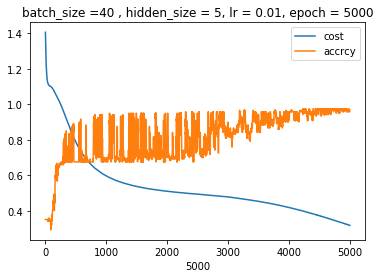

Training Accuracy:  0.9583333333333334
Test Accuracy:  1.0
epoch:  0 cost, accuracy:  2.865900130408519 0.325
epoch:  1 cost, accuracy:  2.717481469783148 0.325
epoch:  2 cost, accuracy:  2.60245720312674 0.325
epoch:  3 cost, accuracy:  2.497695083219866 0.325
epoch:  4 cost, accuracy:  2.402803073928762 0.325
epoch:  5 cost, accuracy:  2.3089392539279805 0.325
epoch:  6 cost, accuracy:  2.223543982920377 0.325
epoch:  7 cost, accuracy:  2.14348742545959 0.325
epoch:  8 cost, accuracy:  2.0719789953482453 0.325
epoch:  9 cost, accuracy:  2.0028963331514746 0.325
epoch:  10 cost, accuracy:  1.9444557217097895 0.325
epoch:  11 cost, accuracy:  1.8858547674320798 0.325
epoch:  12 cost, accuracy:  1.8361601165846178 0.325
epoch:  13 cost, accuracy:  1.787449740551374 0.325
epoch:  14 cost, accuracy:  1.7469714299175572 0.325
epoch:  15 cost, accuracy:  1.7147055219445477 0.325
epoch:  16 cost, accuracy:  1.67751354914744 0.325
epoch:  17 cost, accuracy:  1.6478594753901552 0.325
epoch:  1

epoch:  139 cost, accuracy:  0.8531479050203911 0.95
epoch:  140 cost, accuracy:  0.8509394792419104 0.9583333333333334
epoch:  141 cost, accuracy:  0.8491343424789157 0.9583333333333334
epoch:  142 cost, accuracy:  0.8471491512891022 0.9583333333333334
epoch:  143 cost, accuracy:  0.8448845169578088 0.9583333333333334
epoch:  144 cost, accuracy:  0.8430931131392311 0.9583333333333334
epoch:  145 cost, accuracy:  0.8411452560339192 0.9583333333333334
epoch:  146 cost, accuracy:  0.8390821303094929 0.95
epoch:  147 cost, accuracy:  0.8372262574483459 0.9166666666666666
epoch:  148 cost, accuracy:  0.8352432484825421 0.9166666666666666
epoch:  149 cost, accuracy:  0.833083544487541 0.95
epoch:  150 cost, accuracy:  0.831912376603597 0.9166666666666666
epoch:  151 cost, accuracy:  0.829336099799775 0.9166666666666666
epoch:  152 cost, accuracy:  0.8273953689757593 0.95
epoch:  153 cost, accuracy:  0.8255777904501383 0.95
epoch:  154 cost, accuracy:  0.8241881487434298 0.9166666666666666
e

epoch:  266 cost, accuracy:  0.6328386986394399 0.9666666666666667
epoch:  267 cost, accuracy:  0.6315147582035737 0.9666666666666667
epoch:  268 cost, accuracy:  0.6305601190045416 0.9583333333333334
epoch:  269 cost, accuracy:  0.6284656892278292 0.9666666666666667
epoch:  270 cost, accuracy:  0.6270597996283646 0.975
epoch:  271 cost, accuracy:  0.6253351454453834 0.9666666666666667
epoch:  272 cost, accuracy:  0.6241662059292714 0.975
epoch:  273 cost, accuracy:  0.6229295627366856 0.9666666666666667
epoch:  274 cost, accuracy:  0.6213474840600196 0.9666666666666667
epoch:  275 cost, accuracy:  0.6194877558348165 0.9666666666666667
epoch:  276 cost, accuracy:  0.618194018387435 0.975
epoch:  277 cost, accuracy:  0.6166196957904274 0.975
epoch:  278 cost, accuracy:  0.6149180905174395 0.9666666666666667
epoch:  279 cost, accuracy:  0.6136874371254831 0.975
epoch:  280 cost, accuracy:  0.6121751507411682 0.975
epoch:  281 cost, accuracy:  0.6109328439612194 0.975
epoch:  282 cost, ac

epoch:  402 cost, accuracy:  0.4760469078657346 0.975
epoch:  403 cost, accuracy:  0.4752084252028165 0.975
epoch:  404 cost, accuracy:  0.47457833021921114 0.975
epoch:  405 cost, accuracy:  0.47387752618428186 0.975
epoch:  406 cost, accuracy:  0.47345643241218377 0.975
epoch:  407 cost, accuracy:  0.47211446444885724 0.975
epoch:  408 cost, accuracy:  0.47130735889313713 0.9666666666666667
epoch:  409 cost, accuracy:  0.4710297905744535 0.9583333333333334
epoch:  410 cost, accuracy:  0.47041891802194574 0.9583333333333334
epoch:  411 cost, accuracy:  0.4694807351537383 0.9583333333333334
epoch:  412 cost, accuracy:  0.4685078993135195 0.9666666666666667
epoch:  413 cost, accuracy:  0.4676370216783425 0.9666666666666667
epoch:  414 cost, accuracy:  0.4665347106295625 0.9666666666666667
epoch:  415 cost, accuracy:  0.46573383311034744 0.9666666666666667
epoch:  416 cost, accuracy:  0.46497339751418826 0.9666666666666667
epoch:  417 cost, accuracy:  0.46426019085559034 0.975
epoch:  41

epoch:  537 cost, accuracy:  0.3925441744313164 0.9666666666666667
epoch:  538 cost, accuracy:  0.39201367889929667 0.9666666666666667
epoch:  539 cost, accuracy:  0.3914632380228704 0.9666666666666667
epoch:  540 cost, accuracy:  0.39103022194474735 0.9666666666666667
epoch:  541 cost, accuracy:  0.3911262258354796 0.9583333333333334
epoch:  542 cost, accuracy:  0.3907449773798097 0.9583333333333334
epoch:  543 cost, accuracy:  0.38996430002249627 0.9666666666666667
epoch:  544 cost, accuracy:  0.38937697261000015 0.9666666666666667
epoch:  545 cost, accuracy:  0.3888648196152129 0.9666666666666667
epoch:  546 cost, accuracy:  0.38889565760941974 0.9583333333333334
epoch:  547 cost, accuracy:  0.3877490724306314 0.9666666666666667
epoch:  548 cost, accuracy:  0.3872074175487402 0.9666666666666667
epoch:  549 cost, accuracy:  0.38696559173831513 0.9666666666666667
epoch:  550 cost, accuracy:  0.38624627202720063 0.9666666666666667
epoch:  551 cost, accuracy:  0.3858308410231101 0.96666

epoch:  668 cost, accuracy:  0.3408194007501551 0.9583333333333334
epoch:  669 cost, accuracy:  0.34016510960732504 0.9583333333333334
epoch:  670 cost, accuracy:  0.3398982017834163 0.9583333333333334
epoch:  671 cost, accuracy:  0.3404091844012322 0.95
epoch:  672 cost, accuracy:  0.33999180453235317 0.95
epoch:  673 cost, accuracy:  0.34098162256609243 0.9583333333333334
epoch:  674 cost, accuracy:  0.3385610179027508 0.9583333333333334
epoch:  675 cost, accuracy:  0.337611361461447 0.9666666666666667
epoch:  676 cost, accuracy:  0.33757077990185125 0.9583333333333334
epoch:  677 cost, accuracy:  0.3378025012065597 0.9583333333333334
epoch:  678 cost, accuracy:  0.3369207457175358 0.9583333333333334
epoch:  679 cost, accuracy:  0.33629101258732746 0.9666666666666667
epoch:  680 cost, accuracy:  0.33584054406839947 0.975
epoch:  681 cost, accuracy:  0.3354762185680317 0.9666666666666667
epoch:  682 cost, accuracy:  0.33523540889141124 0.9666666666666667
epoch:  683 cost, accuracy:  0

epoch:  800 cost, accuracy:  0.301679232272783 0.975
epoch:  801 cost, accuracy:  0.3011053080462839 0.975
epoch:  802 cost, accuracy:  0.30118586756563526 0.975
epoch:  803 cost, accuracy:  0.3005683248981049 0.975
epoch:  804 cost, accuracy:  0.30045013235419804 0.9666666666666667
epoch:  805 cost, accuracy:  0.30022443463013376 0.9666666666666667
epoch:  806 cost, accuracy:  0.2999011393347008 0.9666666666666667
epoch:  807 cost, accuracy:  0.2995799707816295 0.9666666666666667
epoch:  808 cost, accuracy:  0.2995306999539796 0.9666666666666667
epoch:  809 cost, accuracy:  0.2991846566863856 0.9666666666666667
epoch:  810 cost, accuracy:  0.2991783595812026 0.9666666666666667
epoch:  811 cost, accuracy:  0.2985638064394028 0.9666666666666667
epoch:  812 cost, accuracy:  0.2983163159991145 0.9666666666666667
epoch:  813 cost, accuracy:  0.2981612651051856 0.9666666666666667
epoch:  814 cost, accuracy:  0.29792437537971994 0.975
epoch:  815 cost, accuracy:  0.2981715704990368 0.975
epo

epoch:  934 cost, accuracy:  0.27122538493972537 0.9666666666666667
epoch:  935 cost, accuracy:  0.27125645896748396 0.975
epoch:  936 cost, accuracy:  0.27094526168145083 0.975
epoch:  937 cost, accuracy:  0.27067741371967935 0.975
epoch:  938 cost, accuracy:  0.2704200901386763 0.9666666666666667
epoch:  939 cost, accuracy:  0.27023537002983555 0.9666666666666667
epoch:  940 cost, accuracy:  0.27002791698132783 0.975
epoch:  941 cost, accuracy:  0.2698928594879124 0.9666666666666667
epoch:  942 cost, accuracy:  0.26964784743769715 0.9666666666666667
epoch:  943 cost, accuracy:  0.26949612516749244 0.975
epoch:  944 cost, accuracy:  0.2694198246226978 0.975
epoch:  945 cost, accuracy:  0.26922410830059307 0.975
epoch:  946 cost, accuracy:  0.2689534196699565 0.975
epoch:  947 cost, accuracy:  0.2687601687870911 0.975
epoch:  948 cost, accuracy:  0.2684722815256947 0.975
epoch:  949 cost, accuracy:  0.2682581080658448 0.9666666666666667
epoch:  950 cost, accuracy:  0.268436763784417 0.

epoch:  1069 cost, accuracy:  0.24731842186678774 0.9666666666666667
epoch:  1070 cost, accuracy:  0.2469983659052301 0.9666666666666667
epoch:  1071 cost, accuracy:  0.2473939757102401 0.975
epoch:  1072 cost, accuracy:  0.24680339736275292 0.9666666666666667
epoch:  1073 cost, accuracy:  0.2463832470603901 0.9666666666666667
epoch:  1074 cost, accuracy:  0.2462385345331052 0.9666666666666667
epoch:  1075 cost, accuracy:  0.24605425813761894 0.975
epoch:  1076 cost, accuracy:  0.2459453081175871 0.9666666666666667
epoch:  1077 cost, accuracy:  0.24573953022000528 0.9666666666666667
epoch:  1078 cost, accuracy:  0.24563004414514483 0.9666666666666667
epoch:  1079 cost, accuracy:  0.2454262062030298 0.975
epoch:  1080 cost, accuracy:  0.24540105971193663 0.975
epoch:  1081 cost, accuracy:  0.24532618952841553 0.975
epoch:  1082 cost, accuracy:  0.2449392154636947 0.975
epoch:  1083 cost, accuracy:  0.24515907218694538 0.9666666666666667
epoch:  1084 cost, accuracy:  0.24528406371980271 

epoch:  1203 cost, accuracy:  0.2274286174158115 0.9666666666666667
epoch:  1204 cost, accuracy:  0.22748214028811115 0.9666666666666667
epoch:  1205 cost, accuracy:  0.22732178286701513 0.9666666666666667
epoch:  1206 cost, accuracy:  0.22699992946449432 0.975
epoch:  1207 cost, accuracy:  0.22706649168917326 0.975
epoch:  1208 cost, accuracy:  0.22709822283172104 0.975
epoch:  1209 cost, accuracy:  0.2267685729038439 0.975
epoch:  1210 cost, accuracy:  0.2267260025107593 0.975
epoch:  1211 cost, accuracy:  0.2269985204631758 0.975
epoch:  1212 cost, accuracy:  0.22646466812234578 0.975
epoch:  1213 cost, accuracy:  0.22608852047271505 0.9666666666666667
epoch:  1214 cost, accuracy:  0.22598277330380487 0.9666666666666667
epoch:  1215 cost, accuracy:  0.2258609856977189 0.9666666666666667
epoch:  1216 cost, accuracy:  0.2256920800845317 0.975
epoch:  1217 cost, accuracy:  0.2260868785432034 0.975
epoch:  1218 cost, accuracy:  0.22541430886463457 0.975
epoch:  1219 cost, accuracy:  0.2

epoch:  1345 cost, accuracy:  0.20999854872535315 0.975
epoch:  1346 cost, accuracy:  0.20989316521530085 0.975
epoch:  1347 cost, accuracy:  0.21009218037538283 0.975
epoch:  1348 cost, accuracy:  0.21008120635074817 0.975
epoch:  1349 cost, accuracy:  0.20992498086083777 0.975
epoch:  1350 cost, accuracy:  0.2098736391517256 0.975
epoch:  1351 cost, accuracy:  0.20952528947952204 0.975
epoch:  1352 cost, accuracy:  0.20936819263991946 0.975
epoch:  1353 cost, accuracy:  0.20914881615259326 0.975
epoch:  1354 cost, accuracy:  0.20906493947515586 0.9666666666666667
epoch:  1355 cost, accuracy:  0.20895155160749618 0.9666666666666667
epoch:  1356 cost, accuracy:  0.20928659351440138 0.975
epoch:  1357 cost, accuracy:  0.20972636744982082 0.975
epoch:  1358 cost, accuracy:  0.2088628753570673 0.975
epoch:  1359 cost, accuracy:  0.20917074828931306 0.975
epoch:  1360 cost, accuracy:  0.20847199172586273 0.975
epoch:  1361 cost, accuracy:  0.2083880170022759 0.975
epoch:  1362 cost, accura

epoch:  1490 cost, accuracy:  0.1952125382927061 0.975
epoch:  1491 cost, accuracy:  0.19513498134221505 0.975
epoch:  1492 cost, accuracy:  0.19504912105607888 0.9833333333333333
epoch:  1493 cost, accuracy:  0.19544320129101844 0.975
epoch:  1494 cost, accuracy:  0.19551017490712258 0.975
epoch:  1495 cost, accuracy:  0.19540772458798664 0.975
epoch:  1496 cost, accuracy:  0.19513407358131693 0.975
epoch:  1497 cost, accuracy:  0.19576277140908752 0.975
epoch:  1498 cost, accuracy:  0.19597262730991935 0.975
epoch:  1499 cost, accuracy:  0.19492724231629321 0.975
epoch:  1500 cost, accuracy:  0.19436136792281863 0.975
epoch:  1501 cost, accuracy:  0.1941853470675311 0.9833333333333333
epoch:  1502 cost, accuracy:  0.19443663279079484 0.975
epoch:  1503 cost, accuracy:  0.19399306867411156 0.9833333333333333
epoch:  1504 cost, accuracy:  0.19392143862746417 0.9833333333333333
epoch:  1505 cost, accuracy:  0.19380730086555825 0.9833333333333333
epoch:  1506 cost, accuracy:  0.193846499

epoch:  1628 cost, accuracy:  0.18419283063109076 0.975
epoch:  1629 cost, accuracy:  0.18419952863738576 0.975
epoch:  1630 cost, accuracy:  0.18330524776862334 0.975
epoch:  1631 cost, accuracy:  0.18300817187503057 0.9833333333333333
epoch:  1632 cost, accuracy:  0.18289405919579488 0.9833333333333333
epoch:  1633 cost, accuracy:  0.18285787286977975 0.9833333333333333
epoch:  1634 cost, accuracy:  0.18278415355068853 0.9833333333333333
epoch:  1635 cost, accuracy:  0.18270010618969343 0.9833333333333333
epoch:  1636 cost, accuracy:  0.18259134522117962 0.9833333333333333
epoch:  1637 cost, accuracy:  0.18262062276759977 0.975
epoch:  1638 cost, accuracy:  0.18401551665602875 0.9583333333333334
epoch:  1639 cost, accuracy:  0.1828628980694666 0.975
epoch:  1640 cost, accuracy:  0.1831284277749847 0.975
epoch:  1641 cost, accuracy:  0.18224904437988723 0.975
epoch:  1642 cost, accuracy:  0.18214468015154256 0.9833333333333333
epoch:  1643 cost, accuracy:  0.18209602155867502 0.983333

epoch:  1761 cost, accuracy:  0.17419664079548997 0.975
epoch:  1762 cost, accuracy:  0.17358310096819396 0.975
epoch:  1763 cost, accuracy:  0.1739444124749521 0.975
epoch:  1764 cost, accuracy:  0.17372595877035527 0.975
epoch:  1765 cost, accuracy:  0.17320498253514066 0.975
epoch:  1766 cost, accuracy:  0.1729567488016331 0.9833333333333333
epoch:  1767 cost, accuracy:  0.17297946707957237 0.9833333333333333
epoch:  1768 cost, accuracy:  0.17285266031599486 0.9833333333333333
epoch:  1769 cost, accuracy:  0.17276958510037027 0.9833333333333333
epoch:  1770 cost, accuracy:  0.17276022561068588 0.9833333333333333
epoch:  1771 cost, accuracy:  0.1727285624759663 0.975
epoch:  1772 cost, accuracy:  0.1728449353606501 0.975
epoch:  1773 cost, accuracy:  0.17275293284536092 0.975
epoch:  1774 cost, accuracy:  0.17313158528136027 0.975
epoch:  1775 cost, accuracy:  0.17256005056168397 0.975
epoch:  1776 cost, accuracy:  0.17226232768122607 0.9833333333333333
epoch:  1777 cost, accuracy:  

epoch:  1894 cost, accuracy:  0.16487587814889473 0.9833333333333333
epoch:  1895 cost, accuracy:  0.16469695781033764 0.9833333333333333
epoch:  1896 cost, accuracy:  0.16451937644521994 0.9833333333333333
epoch:  1897 cost, accuracy:  0.16465664303930522 0.9833333333333333
epoch:  1898 cost, accuracy:  0.16539610342302377 0.975
epoch:  1899 cost, accuracy:  0.16463185918083448 0.975
epoch:  1900 cost, accuracy:  0.16446377667599862 0.9833333333333333
epoch:  1901 cost, accuracy:  0.16434249168342552 0.9833333333333333
epoch:  1902 cost, accuracy:  0.1641819185839991 0.9833333333333333
epoch:  1903 cost, accuracy:  0.16457840707019292 0.975
epoch:  1904 cost, accuracy:  0.16412731107009265 0.9833333333333333
epoch:  1905 cost, accuracy:  0.16402747531621162 0.9833333333333333
epoch:  1906 cost, accuracy:  0.163951810249608 0.9833333333333333
epoch:  1907 cost, accuracy:  0.16389533161182684 0.9833333333333333
epoch:  1908 cost, accuracy:  0.16394084377937543 0.9833333333333333
epoch: 

epoch:  2020 cost, accuracy:  0.15770073626315023 0.9833333333333333
epoch:  2021 cost, accuracy:  0.15734012628675279 0.9833333333333333
epoch:  2022 cost, accuracy:  0.15729634237766746 0.9833333333333333
epoch:  2023 cost, accuracy:  0.15729432176211666 0.9833333333333333
epoch:  2024 cost, accuracy:  0.15719606605642042 0.9833333333333333
epoch:  2025 cost, accuracy:  0.15795960984000013 0.975
epoch:  2026 cost, accuracy:  0.15823745956010266 0.975
epoch:  2027 cost, accuracy:  0.15734773370034044 0.9833333333333333
epoch:  2028 cost, accuracy:  0.15695894178172262 0.9833333333333333
epoch:  2029 cost, accuracy:  0.1573755523120831 0.975
epoch:  2030 cost, accuracy:  0.158975898680836 0.95
epoch:  2031 cost, accuracy:  0.15856658514340036 0.9666666666666667
epoch:  2032 cost, accuracy:  0.15844111586959203 0.9666666666666667
epoch:  2033 cost, accuracy:  0.15826630195623698 0.975
epoch:  2034 cost, accuracy:  0.1580972908033986 0.975
epoch:  2035 cost, accuracy:  0.1571036857598567

epoch:  2145 cost, accuracy:  0.15097049740177138 0.9833333333333333
epoch:  2146 cost, accuracy:  0.15095444288394258 0.9833333333333333
epoch:  2147 cost, accuracy:  0.15099082239154119 0.9833333333333333
epoch:  2148 cost, accuracy:  0.15086275374677485 0.9833333333333333
epoch:  2149 cost, accuracy:  0.15108553454118195 0.9833333333333333
epoch:  2150 cost, accuracy:  0.15107632007809998 0.9833333333333333
epoch:  2151 cost, accuracy:  0.15085762292697044 0.9833333333333333
epoch:  2152 cost, accuracy:  0.15086716566417027 0.9833333333333333
epoch:  2153 cost, accuracy:  0.1510422308737633 0.9833333333333333
epoch:  2154 cost, accuracy:  0.15054994459143858 0.9833333333333333
epoch:  2155 cost, accuracy:  0.15052553766010934 0.9833333333333333
epoch:  2156 cost, accuracy:  0.15070636852906807 0.9833333333333333
epoch:  2157 cost, accuracy:  0.15052781608004348 0.9833333333333333
epoch:  2158 cost, accuracy:  0.1503585773000748 0.9833333333333333
epoch:  2159 cost, accuracy:  0.1503

epoch:  2267 cost, accuracy:  0.14551668223720085 0.9833333333333333
epoch:  2268 cost, accuracy:  0.14595857856230957 0.975
epoch:  2269 cost, accuracy:  0.14534134751515368 0.9833333333333333
epoch:  2270 cost, accuracy:  0.1455938880071931 0.9833333333333333
epoch:  2271 cost, accuracy:  0.145428797795697 0.9833333333333333
epoch:  2272 cost, accuracy:  0.14541931719822268 0.9833333333333333
epoch:  2273 cost, accuracy:  0.14594473330734908 0.975
epoch:  2274 cost, accuracy:  0.14568344196080663 0.975
epoch:  2275 cost, accuracy:  0.14539088167719383 0.9833333333333333
epoch:  2276 cost, accuracy:  0.14503716901971114 0.9833333333333333
epoch:  2277 cost, accuracy:  0.14501264377897252 0.9833333333333333
epoch:  2278 cost, accuracy:  0.14494336256693824 0.9833333333333333
epoch:  2279 cost, accuracy:  0.14489643908633004 0.9833333333333333
epoch:  2280 cost, accuracy:  0.1449550426806619 0.9833333333333333
epoch:  2281 cost, accuracy:  0.14487999989411116 0.9833333333333333
epoch:  

epoch:  2389 cost, accuracy:  0.1408377777672412 0.9833333333333333
epoch:  2390 cost, accuracy:  0.14077383440043187 0.9833333333333333
epoch:  2391 cost, accuracy:  0.1403393465504539 0.9833333333333333
epoch:  2392 cost, accuracy:  0.140329586067522 0.9833333333333333
epoch:  2393 cost, accuracy:  0.14037754793341967 0.9833333333333333
epoch:  2394 cost, accuracy:  0.140596491749453 0.9833333333333333
epoch:  2395 cost, accuracy:  0.14083050027610117 0.975
epoch:  2396 cost, accuracy:  0.1401675540801192 0.9833333333333333
epoch:  2397 cost, accuracy:  0.14021564887389118 0.9833333333333333
epoch:  2398 cost, accuracy:  0.14016360933302507 0.9833333333333333
epoch:  2399 cost, accuracy:  0.14031928700932203 0.9833333333333333
epoch:  2400 cost, accuracy:  0.14007878588602013 0.9833333333333333
epoch:  2401 cost, accuracy:  0.13999433615119888 0.9833333333333333
epoch:  2402 cost, accuracy:  0.1404613564278729 0.975
epoch:  2403 cost, accuracy:  0.13994476571627287 0.9833333333333333

epoch:  2512 cost, accuracy:  0.1365499139116171 0.975
epoch:  2513 cost, accuracy:  0.13694610733086218 0.975
epoch:  2514 cost, accuracy:  0.13739830447590357 0.9666666666666667
epoch:  2515 cost, accuracy:  0.13687661424471256 0.975
epoch:  2516 cost, accuracy:  0.13602239372758892 0.9833333333333333
epoch:  2517 cost, accuracy:  0.13571177604213053 0.9833333333333333
epoch:  2518 cost, accuracy:  0.13621483169403367 0.975
epoch:  2519 cost, accuracy:  0.13612208463955652 0.9833333333333333
epoch:  2520 cost, accuracy:  0.13652754239890855 0.975
epoch:  2521 cost, accuracy:  0.13610796917966184 0.975
epoch:  2522 cost, accuracy:  0.13550591212511637 0.9833333333333333
epoch:  2523 cost, accuracy:  0.13550302454330473 0.9833333333333333
epoch:  2524 cost, accuracy:  0.13543948123190228 0.9833333333333333
epoch:  2525 cost, accuracy:  0.13546572786416966 0.9833333333333333
epoch:  2526 cost, accuracy:  0.13600779404699032 0.975
epoch:  2527 cost, accuracy:  0.13570758929957 0.98333333

epoch:  2634 cost, accuracy:  0.13204859908354927 0.9833333333333333
epoch:  2635 cost, accuracy:  0.13189932082906772 0.9833333333333333
epoch:  2636 cost, accuracy:  0.1319849714078067 0.9833333333333333
epoch:  2637 cost, accuracy:  0.13196384707102912 0.9833333333333333
epoch:  2638 cost, accuracy:  0.13204384790939894 0.9833333333333333
epoch:  2639 cost, accuracy:  0.13161718482431708 0.9833333333333333
epoch:  2640 cost, accuracy:  0.1316831741536732 0.9833333333333333
epoch:  2641 cost, accuracy:  0.13157553211165554 0.9833333333333333
epoch:  2642 cost, accuracy:  0.13153030061028737 0.9833333333333333
epoch:  2643 cost, accuracy:  0.13170584262668822 0.9833333333333333
epoch:  2644 cost, accuracy:  0.1318822165866089 0.9833333333333333
epoch:  2645 cost, accuracy:  0.13152456883798586 0.9833333333333333
epoch:  2646 cost, accuracy:  0.1316691819545724 0.9833333333333333
epoch:  2647 cost, accuracy:  0.1315850997320644 0.9833333333333333
epoch:  2648 cost, accuracy:  0.1316017

epoch:  2755 cost, accuracy:  0.12867824644625517 0.9833333333333333
epoch:  2756 cost, accuracy:  0.1290136669588759 0.975
epoch:  2757 cost, accuracy:  0.1280810971106902 0.9833333333333333
epoch:  2758 cost, accuracy:  0.12800014607859284 0.9833333333333333
epoch:  2759 cost, accuracy:  0.1280179974677358 0.9833333333333333
epoch:  2760 cost, accuracy:  0.12807088762174082 0.9833333333333333
epoch:  2761 cost, accuracy:  0.12793504683245757 0.9833333333333333
epoch:  2762 cost, accuracy:  0.12790583783848636 0.9833333333333333
epoch:  2763 cost, accuracy:  0.12787547523734163 0.9833333333333333
epoch:  2764 cost, accuracy:  0.12787571375806955 0.9833333333333333
epoch:  2765 cost, accuracy:  0.1278006199027869 0.9833333333333333
epoch:  2766 cost, accuracy:  0.12811364258840305 0.9833333333333333
epoch:  2767 cost, accuracy:  0.12792679790620912 0.9833333333333333
epoch:  2768 cost, accuracy:  0.12793916023421867 0.9833333333333333
epoch:  2769 cost, accuracy:  0.12774213427642725 0

epoch:  2876 cost, accuracy:  0.12474096358143189 0.9833333333333333
epoch:  2877 cost, accuracy:  0.12502746809082124 0.9833333333333333
epoch:  2878 cost, accuracy:  0.12501723534567039 0.9833333333333333
epoch:  2879 cost, accuracy:  0.12551113091629543 0.975
epoch:  2880 cost, accuracy:  0.12489916042348993 0.9833333333333333
epoch:  2881 cost, accuracy:  0.12457935919624608 0.9833333333333333
epoch:  2882 cost, accuracy:  0.12458423647032728 0.9833333333333333
epoch:  2883 cost, accuracy:  0.12457953784079608 0.9833333333333333
epoch:  2884 cost, accuracy:  0.12483463876006556 0.9833333333333333
epoch:  2885 cost, accuracy:  0.12446606545309445 0.9833333333333333
epoch:  2886 cost, accuracy:  0.12443642563822298 0.9833333333333333
epoch:  2887 cost, accuracy:  0.12448864576913883 0.9833333333333333
epoch:  2888 cost, accuracy:  0.12439483388565371 0.9833333333333333
epoch:  2889 cost, accuracy:  0.12442846489138476 0.9833333333333333
epoch:  2890 cost, accuracy:  0.124511305368830

epoch:  2999 cost, accuracy:  0.12246905553595702 0.975
epoch:  3000 cost, accuracy:  0.1216047087265782 0.9833333333333333
epoch:  3001 cost, accuracy:  0.12151509207297405 0.9833333333333333
epoch:  3002 cost, accuracy:  0.12161457484740092 0.9833333333333333
epoch:  3003 cost, accuracy:  0.12148119440654763 0.9833333333333333
epoch:  3004 cost, accuracy:  0.12163794974986883 0.9833333333333333
epoch:  3005 cost, accuracy:  0.12150212068572563 0.9833333333333333
epoch:  3006 cost, accuracy:  0.1214018651054548 0.9833333333333333
epoch:  3007 cost, accuracy:  0.12138517029806062 0.9833333333333333
epoch:  3008 cost, accuracy:  0.12144493247181902 0.9833333333333333
epoch:  3009 cost, accuracy:  0.12174519231804967 0.9833333333333333
epoch:  3010 cost, accuracy:  0.12176385993340726 0.9833333333333333
epoch:  3011 cost, accuracy:  0.12156445650664248 0.9833333333333333
epoch:  3012 cost, accuracy:  0.12191181580402176 0.9833333333333333
epoch:  3013 cost, accuracy:  0.12195775761692813

epoch:  3122 cost, accuracy:  0.11872639324090488 0.9833333333333333
epoch:  3123 cost, accuracy:  0.11866694064981952 0.9833333333333333
epoch:  3124 cost, accuracy:  0.11864447688286453 0.9833333333333333
epoch:  3125 cost, accuracy:  0.11862702259068439 0.9833333333333333
epoch:  3126 cost, accuracy:  0.11859992761569467 0.9833333333333333
epoch:  3127 cost, accuracy:  0.11866280474024136 0.9833333333333333
epoch:  3128 cost, accuracy:  0.11858355938441428 0.9833333333333333
epoch:  3129 cost, accuracy:  0.11909815353534423 0.9833333333333333
epoch:  3130 cost, accuracy:  0.1189408204542772 0.9833333333333333
epoch:  3131 cost, accuracy:  0.11929024084835332 0.9833333333333333
epoch:  3132 cost, accuracy:  0.12014207180848126 0.975
epoch:  3133 cost, accuracy:  0.12032992451213334 0.975
epoch:  3134 cost, accuracy:  0.118686654119523 0.9833333333333333
epoch:  3135 cost, accuracy:  0.11888171508750717 0.9833333333333333
epoch:  3136 cost, accuracy:  0.11838227347824204 0.98333333333

epoch:  3244 cost, accuracy:  0.11624856288822713 0.9833333333333333
epoch:  3245 cost, accuracy:  0.11609357614196816 0.9833333333333333
epoch:  3246 cost, accuracy:  0.1159838148678749 0.9833333333333333
epoch:  3247 cost, accuracy:  0.1160112527545944 0.9833333333333333
epoch:  3248 cost, accuracy:  0.11594415121199916 0.9833333333333333
epoch:  3249 cost, accuracy:  0.11617389943078127 0.9833333333333333
epoch:  3250 cost, accuracy:  0.11650478834166664 0.975
epoch:  3251 cost, accuracy:  0.11648345511109695 0.975
epoch:  3252 cost, accuracy:  0.11602624262194465 0.9833333333333333
epoch:  3253 cost, accuracy:  0.11605384664841513 0.9833333333333333
epoch:  3254 cost, accuracy:  0.11588571408973226 0.9833333333333333
epoch:  3255 cost, accuracy:  0.11635440432268061 0.9833333333333333
epoch:  3256 cost, accuracy:  0.11579382832372252 0.9833333333333333
epoch:  3257 cost, accuracy:  0.11589128426893042 0.9833333333333333
epoch:  3258 cost, accuracy:  0.1160787070241176 0.98333333333

epoch:  3366 cost, accuracy:  0.11356505423430031 0.9833333333333333
epoch:  3367 cost, accuracy:  0.11354866727296499 0.9833333333333333
epoch:  3368 cost, accuracy:  0.11382390409595526 0.9833333333333333
epoch:  3369 cost, accuracy:  0.1135794967682308 0.9833333333333333
epoch:  3370 cost, accuracy:  0.11363968923132539 0.9833333333333333
epoch:  3371 cost, accuracy:  0.11426784239906768 0.9833333333333333
epoch:  3372 cost, accuracy:  0.11359700931390974 0.9833333333333333
epoch:  3373 cost, accuracy:  0.11342990787464823 0.9833333333333333
epoch:  3374 cost, accuracy:  0.11346214356176294 0.9833333333333333
epoch:  3375 cost, accuracy:  0.11366135950150001 0.9833333333333333
epoch:  3376 cost, accuracy:  0.11343754344209572 0.9833333333333333
epoch:  3377 cost, accuracy:  0.11363374872358346 0.9833333333333333
epoch:  3378 cost, accuracy:  0.11356573983336957 0.9833333333333333
epoch:  3379 cost, accuracy:  0.11333213890878584 0.9833333333333333
epoch:  3380 cost, accuracy:  0.113

epoch:  3486 cost, accuracy:  0.11145614223317803 0.9833333333333333
epoch:  3487 cost, accuracy:  0.11164296210467263 0.9833333333333333
epoch:  3488 cost, accuracy:  0.11137130437774644 0.9833333333333333
epoch:  3489 cost, accuracy:  0.11129365813069457 0.9833333333333333
epoch:  3490 cost, accuracy:  0.11143240931886521 0.9833333333333333
epoch:  3491 cost, accuracy:  0.11157172476124942 0.9833333333333333
epoch:  3492 cost, accuracy:  0.11128219996919611 0.9833333333333333
epoch:  3493 cost, accuracy:  0.11126333844713994 0.9833333333333333
epoch:  3494 cost, accuracy:  0.11137791619115811 0.9833333333333333
epoch:  3495 cost, accuracy:  0.11138343314515003 0.9833333333333333
epoch:  3496 cost, accuracy:  0.11174796364212662 0.9833333333333333
epoch:  3497 cost, accuracy:  0.11262054505014306 0.975
epoch:  3498 cost, accuracy:  0.111303051078962 0.9833333333333333
epoch:  3499 cost, accuracy:  0.11112552112574425 0.9833333333333333
epoch:  3500 cost, accuracy:  0.11123958421749534

epoch:  3609 cost, accuracy:  0.1094405847250079 0.9833333333333333
epoch:  3610 cost, accuracy:  0.10919782917197042 0.9833333333333333
epoch:  3611 cost, accuracy:  0.10934777783631607 0.9833333333333333
epoch:  3612 cost, accuracy:  0.10925758253955034 0.9833333333333333
epoch:  3613 cost, accuracy:  0.10931792168172112 0.9833333333333333
epoch:  3614 cost, accuracy:  0.1091268073019687 0.9833333333333333
epoch:  3615 cost, accuracy:  0.10942147359529412 0.9833333333333333
epoch:  3616 cost, accuracy:  0.10977616931439776 0.9833333333333333
epoch:  3617 cost, accuracy:  0.11008918852702942 0.975
epoch:  3618 cost, accuracy:  0.10959830062562084 0.9833333333333333
epoch:  3619 cost, accuracy:  0.10904159000527065 0.9833333333333333
epoch:  3620 cost, accuracy:  0.10955007046031694 0.975
epoch:  3621 cost, accuracy:  0.11030397667179757 0.975
epoch:  3622 cost, accuracy:  0.10968763229392607 0.975
epoch:  3623 cost, accuracy:  0.11007198020210884 0.975
epoch:  3624 cost, accuracy:  0.

epoch:  3734 cost, accuracy:  0.10809891380613175 0.975
epoch:  3735 cost, accuracy:  0.1078497257236838 0.9833333333333333
epoch:  3736 cost, accuracy:  0.10756200782330604 0.9833333333333333
epoch:  3737 cost, accuracy:  0.10733407939317297 0.9833333333333333
epoch:  3738 cost, accuracy:  0.10770730795693464 0.9833333333333333
epoch:  3739 cost, accuracy:  0.10714324131179688 0.9833333333333333
epoch:  3740 cost, accuracy:  0.10733668577324865 0.9833333333333333
epoch:  3741 cost, accuracy:  0.10712519489177051 0.9833333333333333
epoch:  3742 cost, accuracy:  0.10720404729053969 0.9833333333333333
epoch:  3743 cost, accuracy:  0.10771901778685518 0.9833333333333333
epoch:  3744 cost, accuracy:  0.10705870490864479 0.9833333333333333
epoch:  3745 cost, accuracy:  0.10705710479284838 0.9833333333333333
epoch:  3746 cost, accuracy:  0.107186672997228 0.9833333333333333
epoch:  3747 cost, accuracy:  0.10875131755326613 0.975
epoch:  3748 cost, accuracy:  0.10797876035268819 0.975
epoch: 

epoch:  3859 cost, accuracy:  0.1053434378325148 0.9833333333333333
epoch:  3860 cost, accuracy:  0.1057044696104863 0.975
epoch:  3861 cost, accuracy:  0.10535030242567389 0.9833333333333333
epoch:  3862 cost, accuracy:  0.10622165374438432 0.975
epoch:  3863 cost, accuracy:  0.10558028880618794 0.9833333333333333
epoch:  3864 cost, accuracy:  0.10527786791404974 0.9833333333333333
epoch:  3865 cost, accuracy:  0.10526928495298368 0.9833333333333333
epoch:  3866 cost, accuracy:  0.1052406933387353 0.9833333333333333
epoch:  3867 cost, accuracy:  0.10558349678328417 0.9833333333333333
epoch:  3868 cost, accuracy:  0.10547071578800078 0.9833333333333333
epoch:  3869 cost, accuracy:  0.10696533243168171 0.975
epoch:  3870 cost, accuracy:  0.10588768065639034 0.975
epoch:  3871 cost, accuracy:  0.1054843306285141 0.9833333333333333
epoch:  3872 cost, accuracy:  0.1052120937756231 0.9833333333333333
epoch:  3873 cost, accuracy:  0.10532088296596266 0.9833333333333333
epoch:  3874 cost, acc

epoch:  3982 cost, accuracy:  0.10364395716456679 0.9833333333333333
epoch:  3983 cost, accuracy:  0.1038606268648735 0.9833333333333333
epoch:  3984 cost, accuracy:  0.10360222831515438 0.9833333333333333
epoch:  3985 cost, accuracy:  0.10414322968540392 0.975
epoch:  3986 cost, accuracy:  0.10450210620413028 0.975
epoch:  3987 cost, accuracy:  0.10417191691398543 0.975
epoch:  3988 cost, accuracy:  0.10501706225769557 0.975
epoch:  3989 cost, accuracy:  0.10450863746344675 0.975
epoch:  3990 cost, accuracy:  0.10357662564625812 0.9833333333333333
epoch:  3991 cost, accuracy:  0.10359333976183759 0.9833333333333333
epoch:  3992 cost, accuracy:  0.10355166437665823 0.9833333333333333
epoch:  3993 cost, accuracy:  0.10348141749908857 0.9833333333333333
epoch:  3994 cost, accuracy:  0.10345760166217949 0.9833333333333333
epoch:  3995 cost, accuracy:  0.10366443852356491 0.9833333333333333
epoch:  3996 cost, accuracy:  0.10401696269718978 0.975
epoch:  3997 cost, accuracy:  0.103870197569

epoch:  4106 cost, accuracy:  0.10212510141883785 0.9833333333333333
epoch:  4107 cost, accuracy:  0.10219981165086749 0.9833333333333333
epoch:  4108 cost, accuracy:  0.10305488980164472 0.975
epoch:  4109 cost, accuracy:  0.10216668985500447 0.9833333333333333
epoch:  4110 cost, accuracy:  0.10205589137371626 0.9833333333333333
epoch:  4111 cost, accuracy:  0.10224918358747642 0.9833333333333333
epoch:  4112 cost, accuracy:  0.10216774854622121 0.9833333333333333
epoch:  4113 cost, accuracy:  0.10192708281383751 0.9833333333333333
epoch:  4114 cost, accuracy:  0.10222322950226251 0.975
epoch:  4115 cost, accuracy:  0.10227783654736529 0.975
epoch:  4116 cost, accuracy:  0.1027375185227075 0.975
epoch:  4117 cost, accuracy:  0.10191095075229968 0.9833333333333333
epoch:  4118 cost, accuracy:  0.10185962247609034 0.9833333333333333
epoch:  4119 cost, accuracy:  0.10184130690631564 0.9833333333333333
epoch:  4120 cost, accuracy:  0.10232615746194289 0.9833333333333333
epoch:  4121 cost,

epoch:  4229 cost, accuracy:  0.10048499193862513 0.9833333333333333
epoch:  4230 cost, accuracy:  0.10047442078566651 0.9833333333333333
epoch:  4231 cost, accuracy:  0.10051327700376861 0.9833333333333333
epoch:  4232 cost, accuracy:  0.10045932088606514 0.9833333333333333
epoch:  4233 cost, accuracy:  0.1004742008182224 0.9833333333333333
epoch:  4234 cost, accuracy:  0.10050473950896607 0.9833333333333333
epoch:  4235 cost, accuracy:  0.10052032058626195 0.9833333333333333
epoch:  4236 cost, accuracy:  0.1004698072159913 0.9833333333333333
epoch:  4237 cost, accuracy:  0.10075746772733914 0.9833333333333333
epoch:  4238 cost, accuracy:  0.10048983143760656 0.9833333333333333
epoch:  4239 cost, accuracy:  0.10037773188962366 0.9833333333333333
epoch:  4240 cost, accuracy:  0.10037757621747816 0.9833333333333333
epoch:  4241 cost, accuracy:  0.1005403688533737 0.9833333333333333
epoch:  4242 cost, accuracy:  0.1003579797064901 0.9833333333333333
epoch:  4243 cost, accuracy:  0.100335

epoch:  4351 cost, accuracy:  0.09912778115024805 0.9833333333333333
epoch:  4352 cost, accuracy:  0.09909491210374473 0.9833333333333333
epoch:  4353 cost, accuracy:  0.09908969168269167 0.9833333333333333
epoch:  4354 cost, accuracy:  0.09906206788394885 0.9833333333333333
epoch:  4355 cost, accuracy:  0.09934890367598981 0.9833333333333333
epoch:  4356 cost, accuracy:  0.09982251357001791 0.9833333333333333
epoch:  4357 cost, accuracy:  0.09913353061595717 0.9833333333333333
epoch:  4358 cost, accuracy:  0.09964925074433581 0.975
epoch:  4359 cost, accuracy:  0.09967136749798824 0.975
epoch:  4360 cost, accuracy:  0.09935194550362952 0.9833333333333333
epoch:  4361 cost, accuracy:  0.09900169521940079 0.9833333333333333
epoch:  4362 cost, accuracy:  0.10035389692865243 0.9833333333333333
epoch:  4363 cost, accuracy:  0.1002168343993542 0.9833333333333333
epoch:  4364 cost, accuracy:  0.09968091365103987 0.975
epoch:  4365 cost, accuracy:  0.09949720680123948 0.9833333333333333
epoch

epoch:  4474 cost, accuracy:  0.09798692829681815 0.9833333333333333
epoch:  4475 cost, accuracy:  0.09856655837319633 0.975
epoch:  4476 cost, accuracy:  0.09787219553717888 0.9833333333333333
epoch:  4477 cost, accuracy:  0.09809002573088148 0.975
epoch:  4478 cost, accuracy:  0.09784485785760352 0.9833333333333333
epoch:  4479 cost, accuracy:  0.09774218332973973 0.9833333333333333
epoch:  4480 cost, accuracy:  0.0978546048109485 0.9833333333333333
epoch:  4481 cost, accuracy:  0.09778567015984822 0.9833333333333333
epoch:  4482 cost, accuracy:  0.0977940595208017 0.9833333333333333
epoch:  4483 cost, accuracy:  0.09792183505375197 0.9833333333333333
epoch:  4484 cost, accuracy:  0.0976661981618582 0.9833333333333333
epoch:  4485 cost, accuracy:  0.09765947056447481 0.9833333333333333
epoch:  4486 cost, accuracy:  0.09767707032398841 0.9833333333333333
epoch:  4487 cost, accuracy:  0.09786181192665587 0.9833333333333333
epoch:  4488 cost, accuracy:  0.0985951621578906 0.975
epoch:  

epoch:  4600 cost, accuracy:  0.09663650699383958 0.9833333333333333
epoch:  4601 cost, accuracy:  0.09652768050116722 0.9833333333333333
epoch:  4602 cost, accuracy:  0.09649324442577246 0.9833333333333333
epoch:  4603 cost, accuracy:  0.09674201929539841 0.975
epoch:  4604 cost, accuracy:  0.0968549061062344 0.975
epoch:  4605 cost, accuracy:  0.09662475551884316 0.9833333333333333
epoch:  4606 cost, accuracy:  0.09678674390972483 0.9833333333333333
epoch:  4607 cost, accuracy:  0.09652945158975207 0.9833333333333333
epoch:  4608 cost, accuracy:  0.09647687287727252 0.9833333333333333
epoch:  4609 cost, accuracy:  0.09643994222252002 0.9833333333333333
epoch:  4610 cost, accuracy:  0.09641154706130513 0.9833333333333333
epoch:  4611 cost, accuracy:  0.09652000234692873 0.9833333333333333
epoch:  4612 cost, accuracy:  0.096395509471579 0.9833333333333333
epoch:  4613 cost, accuracy:  0.09670731650557592 0.975
epoch:  4614 cost, accuracy:  0.09638321546492926 0.9833333333333333
epoch: 

epoch:  4725 cost, accuracy:  0.0957511504355856 0.9833333333333333
epoch:  4726 cost, accuracy:  0.09558338737830037 0.9833333333333333
epoch:  4727 cost, accuracy:  0.09539381542097135 0.9833333333333333
epoch:  4728 cost, accuracy:  0.09528871949186234 0.9833333333333333
epoch:  4729 cost, accuracy:  0.09536785223122045 0.9833333333333333
epoch:  4730 cost, accuracy:  0.09524614565253824 0.9833333333333333
epoch:  4731 cost, accuracy:  0.09532374209457109 0.9833333333333333
epoch:  4732 cost, accuracy:  0.09589869593948326 0.9833333333333333
epoch:  4733 cost, accuracy:  0.09556451688978108 0.9833333333333333
epoch:  4734 cost, accuracy:  0.0952581024705642 0.9833333333333333
epoch:  4735 cost, accuracy:  0.09522578297332235 0.9833333333333333
epoch:  4736 cost, accuracy:  0.09525420699813122 0.9833333333333333
epoch:  4737 cost, accuracy:  0.09524047810548254 0.9833333333333333
epoch:  4738 cost, accuracy:  0.09535561122011847 0.9833333333333333
epoch:  4739 cost, accuracy:  0.0953

epoch:  4852 cost, accuracy:  0.09415373133314828 0.9833333333333333
epoch:  4853 cost, accuracy:  0.09412010264835488 0.9833333333333333
epoch:  4854 cost, accuracy:  0.09412478673161116 0.9833333333333333
epoch:  4855 cost, accuracy:  0.09415434574797633 0.9833333333333333
epoch:  4856 cost, accuracy:  0.0940987657695751 0.9833333333333333
epoch:  4857 cost, accuracy:  0.09408443027145409 0.9833333333333333
epoch:  4858 cost, accuracy:  0.09413714894475747 0.9833333333333333
epoch:  4859 cost, accuracy:  0.09414080322967558 0.9833333333333333
epoch:  4860 cost, accuracy:  0.09431599946287059 0.975
epoch:  4861 cost, accuracy:  0.09424952865398306 0.975
epoch:  4862 cost, accuracy:  0.09460548311170588 0.975
epoch:  4863 cost, accuracy:  0.09527923043085056 0.975
epoch:  4864 cost, accuracy:  0.09417636723261102 0.9833333333333333
epoch:  4865 cost, accuracy:  0.09469584609686876 0.975
epoch:  4866 cost, accuracy:  0.09412959916168805 0.9833333333333333
epoch:  4867 cost, accuracy:  0

epoch:  4976 cost, accuracy:  0.09327860891536274 0.975
epoch:  4977 cost, accuracy:  0.0933412993725216 0.975
epoch:  4978 cost, accuracy:  0.09309084344463867 0.9833333333333333
epoch:  4979 cost, accuracy:  0.0936920891126317 0.9833333333333333
epoch:  4980 cost, accuracy:  0.09334629965881365 0.9833333333333333
epoch:  4981 cost, accuracy:  0.09304661110146135 0.9833333333333333
epoch:  4982 cost, accuracy:  0.09301265962847914 0.9833333333333333
epoch:  4983 cost, accuracy:  0.09302701576740548 0.9833333333333333
epoch:  4984 cost, accuracy:  0.09381295034242208 0.975
epoch:  4985 cost, accuracy:  0.09458028560469313 0.975
epoch:  4986 cost, accuracy:  0.09384503312163915 0.975
epoch:  4987 cost, accuracy:  0.09297614489702419 0.9833333333333333
epoch:  4988 cost, accuracy:  0.09320604571509945 0.975
epoch:  4989 cost, accuracy:  0.09376392661385183 0.975
epoch:  4990 cost, accuracy:  0.09295187612070448 0.9833333333333333
epoch:  4991 cost, accuracy:  0.09293446036444308 0.983333

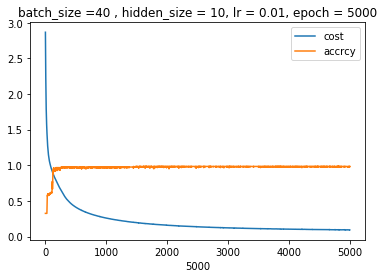

Training Accuracy:  0.9833333333333333
Test Accuracy:  1.0
epoch:  0 cost, accuracy:  2.046055521538144 0.35
epoch:  1 cost, accuracy:  2.042845577250976 0.35
epoch:  2 cost, accuracy:  2.038945339145671 0.35
epoch:  3 cost, accuracy:  2.035085743423955 0.35
epoch:  4 cost, accuracy:  2.0307315529970564 0.35
epoch:  5 cost, accuracy:  2.0266363778453407 0.35
epoch:  6 cost, accuracy:  2.022786820461578 0.35
epoch:  7 cost, accuracy:  2.0185815601262274 0.35
epoch:  8 cost, accuracy:  2.01528563478472 0.35
epoch:  9 cost, accuracy:  2.011235506490977 0.35
epoch:  10 cost, accuracy:  2.0072735711494762 0.35
epoch:  11 cost, accuracy:  2.0033505721319944 0.35
epoch:  12 cost, accuracy:  1.9994672084310465 0.35
epoch:  13 cost, accuracy:  1.9952969982670647 0.35
epoch:  14 cost, accuracy:  1.9914713098523553 0.35
epoch:  15 cost, accuracy:  1.9877993761296504 0.35
epoch:  16 cost, accuracy:  1.9841288534553305 0.35
epoch:  17 cost, accuracy:  1.9806628291873756 0.35
epoch:  18 cost, accura

epoch:  157 cost, accuracy:  1.525172429045206 0.35
epoch:  158 cost, accuracy:  1.5228930771447546 0.35
epoch:  159 cost, accuracy:  1.5204044800042937 0.35
epoch:  160 cost, accuracy:  1.5180107277576922 0.35
epoch:  161 cost, accuracy:  1.5154010174465244 0.35
epoch:  162 cost, accuracy:  1.5131675645191014 0.35
epoch:  163 cost, accuracy:  1.5105477690645335 0.35
epoch:  164 cost, accuracy:  1.5082383393081045 0.35
epoch:  165 cost, accuracy:  1.506082929429843 0.35
epoch:  166 cost, accuracy:  1.5037897197445205 0.35
epoch:  167 cost, accuracy:  1.5018693858824825 0.35
epoch:  168 cost, accuracy:  1.499204010990174 0.35
epoch:  169 cost, accuracy:  1.4972570484763026 0.35
epoch:  170 cost, accuracy:  1.4948793867765378 0.35
epoch:  171 cost, accuracy:  1.4921884226525393 0.35
epoch:  172 cost, accuracy:  1.4898928464908794 0.35
epoch:  173 cost, accuracy:  1.4877533912546455 0.35
epoch:  174 cost, accuracy:  1.4853288399910223 0.35
epoch:  175 cost, accuracy:  1.483054848522554 0.

epoch:  313 cost, accuracy:  1.2673043981588341 0.35
epoch:  314 cost, accuracy:  1.2664718432644073 0.35
epoch:  315 cost, accuracy:  1.2653170182861164 0.35
epoch:  316 cost, accuracy:  1.264270122628827 0.35
epoch:  317 cost, accuracy:  1.263259532362485 0.35
epoch:  318 cost, accuracy:  1.2624144582732952 0.35
epoch:  319 cost, accuracy:  1.2616516423561086 0.35
epoch:  320 cost, accuracy:  1.2607126565878048 0.35
epoch:  321 cost, accuracy:  1.259653468452566 0.35
epoch:  322 cost, accuracy:  1.2587074789141464 0.35
epoch:  323 cost, accuracy:  1.2577696081862249 0.35
epoch:  324 cost, accuracy:  1.256986330324089 0.35
epoch:  325 cost, accuracy:  1.2558976538862516 0.35
epoch:  326 cost, accuracy:  1.2551905630165503 0.35
epoch:  327 cost, accuracy:  1.2543967793556898 0.35
epoch:  328 cost, accuracy:  1.253378140211015 0.35
epoch:  329 cost, accuracy:  1.252696122886491 0.35
epoch:  330 cost, accuracy:  1.2518585994992724 0.35
epoch:  331 cost, accuracy:  1.2508615057544037 0.35

epoch:  469 cost, accuracy:  1.1683436132249903 0.35
epoch:  470 cost, accuracy:  1.1678931200729934 0.35
epoch:  471 cost, accuracy:  1.1675983817981872 0.35
epoch:  472 cost, accuracy:  1.1670587425041352 0.35
epoch:  473 cost, accuracy:  1.1667019725554935 0.35
epoch:  474 cost, accuracy:  1.1663530740724706 0.35
epoch:  475 cost, accuracy:  1.1660700789195058 0.35
epoch:  476 cost, accuracy:  1.1657452976471836 0.35
epoch:  477 cost, accuracy:  1.1654046568547025 0.35
epoch:  478 cost, accuracy:  1.1648884430841713 0.35
epoch:  479 cost, accuracy:  1.1646538165879716 0.35
epoch:  480 cost, accuracy:  1.1643331800031818 0.35
epoch:  481 cost, accuracy:  1.1638862190152424 0.35
epoch:  482 cost, accuracy:  1.1635848077358766 0.35
epoch:  483 cost, accuracy:  1.1630644574357871 0.35
epoch:  484 cost, accuracy:  1.1628433839635477 0.35
epoch:  485 cost, accuracy:  1.162500083818321 0.35
epoch:  486 cost, accuracy:  1.1623637008864796 0.35
epoch:  487 cost, accuracy:  1.1620993969954119

epoch:  780 cost, accuracy:  1.1143320321824794 0.35
epoch:  781 cost, accuracy:  1.1142812827352697 0.35
epoch:  782 cost, accuracy:  1.1142301025641597 0.35
epoch:  783 cost, accuracy:  1.1141244308788425 0.35
epoch:  784 cost, accuracy:  1.1141110919017478 0.35
epoch:  785 cost, accuracy:  1.114090244215887 0.35
epoch:  786 cost, accuracy:  1.1140681938399895 0.35
epoch:  787 cost, accuracy:  1.114003919841725 0.35
epoch:  788 cost, accuracy:  1.113964777313698 0.35
epoch:  789 cost, accuracy:  1.1138633804888916 0.35
epoch:  790 cost, accuracy:  1.1138197315449787 0.35
epoch:  791 cost, accuracy:  1.1137613183826351 0.35
epoch:  792 cost, accuracy:  1.1136552450770727 0.35
epoch:  793 cost, accuracy:  1.1135707804220358 0.35
epoch:  794 cost, accuracy:  1.1135905233863919 0.35
epoch:  795 cost, accuracy:  1.113473252993657 0.35
epoch:  796 cost, accuracy:  1.113375362474445 0.35
epoch:  797 cost, accuracy:  1.1132825660063854 0.35
epoch:  798 cost, accuracy:  1.1131691513701905 0.3

epoch:  936 cost, accuracy:  1.107810370580793 0.35
epoch:  937 cost, accuracy:  1.1077945484578915 0.35
epoch:  938 cost, accuracy:  1.1077726568216002 0.35
epoch:  939 cost, accuracy:  1.1077142173061683 0.35
epoch:  940 cost, accuracy:  1.107715679909005 0.35
epoch:  941 cost, accuracy:  1.1076991956118698 0.35
epoch:  942 cost, accuracy:  1.1076683857622263 0.35
epoch:  943 cost, accuracy:  1.1076623237051422 0.35
epoch:  944 cost, accuracy:  1.107668116807836 0.35
epoch:  945 cost, accuracy:  1.107617435614044 0.35
epoch:  946 cost, accuracy:  1.1075971937726843 0.35
epoch:  947 cost, accuracy:  1.1075696222599407 0.35
epoch:  948 cost, accuracy:  1.1075447727413457 0.35
epoch:  949 cost, accuracy:  1.107515066642072 0.35
epoch:  950 cost, accuracy:  1.1074918457669796 0.35
epoch:  951 cost, accuracy:  1.107470640936098 0.35
epoch:  952 cost, accuracy:  1.1074497105011198 0.35
epoch:  953 cost, accuracy:  1.1074381291585569 0.35
epoch:  954 cost, accuracy:  1.1074472780802698 0.35

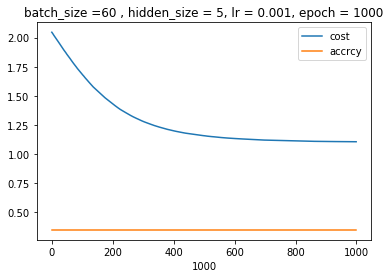

Training Accuracy:  0.35
Test Accuracy:  0.26666666666666666
epoch:  0 cost, accuracy:  1.5086116138823604 0.35
epoch:  1 cost, accuracy:  1.5056480853043408 0.35
epoch:  2 cost, accuracy:  1.502070720938484 0.35
epoch:  3 cost, accuracy:  1.4987071299464523 0.35
epoch:  4 cost, accuracy:  1.4957491334542865 0.35
epoch:  5 cost, accuracy:  1.492738930364061 0.35
epoch:  6 cost, accuracy:  1.4896272729376618 0.35
epoch:  7 cost, accuracy:  1.4864029727382995 0.35
epoch:  8 cost, accuracy:  1.4832019757141903 0.35
epoch:  9 cost, accuracy:  1.480326571124557 0.35
epoch:  10 cost, accuracy:  1.4767301649670557 0.35
epoch:  11 cost, accuracy:  1.4739600215275313 0.35
epoch:  12 cost, accuracy:  1.4707109284103188 0.35
epoch:  13 cost, accuracy:  1.4675558237816986 0.35
epoch:  14 cost, accuracy:  1.4646018418508573 0.35
epoch:  15 cost, accuracy:  1.4613649243072027 0.35
epoch:  16 cost, accuracy:  1.458143851985605 0.35
epoch:  17 cost, accuracy:  1.4550033291732756 0.35
epoch:  18 cost, 

epoch:  157 cost, accuracy:  1.1908552932279552 0.35
epoch:  158 cost, accuracy:  1.1901079675927941 0.35
epoch:  159 cost, accuracy:  1.1890603360225882 0.35
epoch:  160 cost, accuracy:  1.1878547462241016 0.35
epoch:  161 cost, accuracy:  1.1868943578200666 0.35
epoch:  162 cost, accuracy:  1.1860396100981134 0.35
epoch:  163 cost, accuracy:  1.18512836134141 0.35
epoch:  164 cost, accuracy:  1.1844869554602022 0.35
epoch:  165 cost, accuracy:  1.1834884523965798 0.35
epoch:  166 cost, accuracy:  1.1827538538171671 0.35
epoch:  167 cost, accuracy:  1.181804374410092 0.35
epoch:  168 cost, accuracy:  1.180994306835288 0.35
epoch:  169 cost, accuracy:  1.1799603512704568 0.35
epoch:  170 cost, accuracy:  1.1791301661142906 0.35
epoch:  171 cost, accuracy:  1.1782428770639313 0.35
epoch:  172 cost, accuracy:  1.1772353283285597 0.35
epoch:  173 cost, accuracy:  1.1762315722136416 0.35
epoch:  174 cost, accuracy:  1.1752444563194648 0.35
epoch:  175 cost, accuracy:  1.1743629521822205 0.

epoch:  313 cost, accuracy:  1.1054379789974518 0.35
epoch:  314 cost, accuracy:  1.1051674135470415 0.35
epoch:  315 cost, accuracy:  1.1049784658771522 0.35
epoch:  316 cost, accuracy:  1.1048589405791656 0.35
epoch:  317 cost, accuracy:  1.1046751485631323 0.35
epoch:  318 cost, accuracy:  1.1045545997388297 0.35
epoch:  319 cost, accuracy:  1.1044967708151576 0.35
epoch:  320 cost, accuracy:  1.1041952613788812 0.35
epoch:  321 cost, accuracy:  1.1040116165254978 0.35
epoch:  322 cost, accuracy:  1.1037331593297532 0.35
epoch:  323 cost, accuracy:  1.1035533381769 0.35
epoch:  324 cost, accuracy:  1.1032627048130204 0.35
epoch:  325 cost, accuracy:  1.1030078114501138 0.35
epoch:  326 cost, accuracy:  1.1027731767179267 0.35
epoch:  327 cost, accuracy:  1.1025039701305446 0.35
epoch:  328 cost, accuracy:  1.1023956754891227 0.35
epoch:  329 cost, accuracy:  1.1021937188426754 0.35
epoch:  330 cost, accuracy:  1.1019145556868633 0.35
epoch:  331 cost, accuracy:  1.1017129775323293 0

epoch:  469 cost, accuracy:  1.0825259418842212 0.35
epoch:  470 cost, accuracy:  1.0823642659541728 0.35
epoch:  471 cost, accuracy:  1.0822341202456809 0.35
epoch:  472 cost, accuracy:  1.0821194633668318 0.35
epoch:  473 cost, accuracy:  1.0820503225129234 0.35
epoch:  474 cost, accuracy:  1.0820214556887466 0.35
epoch:  475 cost, accuracy:  1.0818859794700622 0.35
epoch:  476 cost, accuracy:  1.0818178810206116 0.35
epoch:  477 cost, accuracy:  1.0817334356399295 0.35
epoch:  478 cost, accuracy:  1.0816585425005616 0.35
epoch:  479 cost, accuracy:  1.0815660475225863 0.35
epoch:  480 cost, accuracy:  1.0814247431761403 0.35
epoch:  481 cost, accuracy:  1.0814009525313169 0.35
epoch:  482 cost, accuracy:  1.0813363539071583 0.35
epoch:  483 cost, accuracy:  1.0813234434076102 0.35
epoch:  484 cost, accuracy:  1.0812436973917678 0.35
epoch:  485 cost, accuracy:  1.0811553382689885 0.35
epoch:  486 cost, accuracy:  1.0811441056756403 0.35
epoch:  487 cost, accuracy:  1.081046251789994

epoch:  625 cost, accuracy:  1.0729656641463583 0.35
epoch:  626 cost, accuracy:  1.072898069856438 0.35
epoch:  627 cost, accuracy:  1.07280894112428 0.35
epoch:  628 cost, accuracy:  1.072741277915561 0.35
epoch:  629 cost, accuracy:  1.0726951106035956 0.35
epoch:  630 cost, accuracy:  1.0726441160170632 0.35
epoch:  631 cost, accuracy:  1.072641805949972 0.35
epoch:  632 cost, accuracy:  1.0726229133813203 0.35
epoch:  633 cost, accuracy:  1.0725679360728733 0.35
epoch:  634 cost, accuracy:  1.0725276831879864 0.35
epoch:  635 cost, accuracy:  1.0724847827429633 0.35
epoch:  636 cost, accuracy:  1.072428822119572 0.35
epoch:  637 cost, accuracy:  1.07235017548545 0.35
epoch:  638 cost, accuracy:  1.0723104194860273 0.35
epoch:  639 cost, accuracy:  1.0722664396257509 0.35
epoch:  640 cost, accuracy:  1.0722242035960194 0.35
epoch:  641 cost, accuracy:  1.0721854307266796 0.35
epoch:  642 cost, accuracy:  1.072154138798993 0.35
epoch:  643 cost, accuracy:  1.072120367325761 0.35
epo

epoch:  781 cost, accuracy:  1.0658678029791235 0.35
epoch:  782 cost, accuracy:  1.065829282175444 0.35
epoch:  783 cost, accuracy:  1.0657815568771576 0.35
epoch:  784 cost, accuracy:  1.0657399018253415 0.35
epoch:  785 cost, accuracy:  1.0657151695179745 0.35
epoch:  786 cost, accuracy:  1.065678439111682 0.35
epoch:  787 cost, accuracy:  1.0656447837208876 0.35
epoch:  788 cost, accuracy:  1.0656043158733004 0.35
epoch:  789 cost, accuracy:  1.0655646345650247 0.35
epoch:  790 cost, accuracy:  1.065517625870773 0.35
epoch:  791 cost, accuracy:  1.0654817799463876 0.35
epoch:  792 cost, accuracy:  1.065446703928461 0.35
epoch:  793 cost, accuracy:  1.0654022982714775 0.35
epoch:  794 cost, accuracy:  1.0653550735738988 0.35
epoch:  795 cost, accuracy:  1.0653147989871619 0.35
epoch:  796 cost, accuracy:  1.065274780102592 0.35
epoch:  797 cost, accuracy:  1.0652419745156576 0.35
epoch:  798 cost, accuracy:  1.0652027953498566 0.35
epoch:  799 cost, accuracy:  1.0651635359300728 0.3

epoch:  937 cost, accuracy:  1.0586254031154498 0.35
epoch:  938 cost, accuracy:  1.0585710598373952 0.35
epoch:  939 cost, accuracy:  1.0585180559501157 0.35
epoch:  940 cost, accuracy:  1.0584694709481577 0.35
epoch:  941 cost, accuracy:  1.0584144454032458 0.35
epoch:  942 cost, accuracy:  1.0583621583887952 0.35
epoch:  943 cost, accuracy:  1.0583087255208938 0.35
epoch:  944 cost, accuracy:  1.0582594132632699 0.35
epoch:  945 cost, accuracy:  1.0581954016694652 0.35
epoch:  946 cost, accuracy:  1.0581381983652607 0.35
epoch:  947 cost, accuracy:  1.0580898742919285 0.35
epoch:  948 cost, accuracy:  1.0580429107459064 0.35
epoch:  949 cost, accuracy:  1.0579958615517546 0.35
epoch:  950 cost, accuracy:  1.0579357176350634 0.35
epoch:  951 cost, accuracy:  1.0578875960311909 0.35
epoch:  952 cost, accuracy:  1.0578411533994427 0.35
epoch:  953 cost, accuracy:  1.0577876104788626 0.35
epoch:  954 cost, accuracy:  1.05774060812719 0.35
epoch:  955 cost, accuracy:  1.0576840219744288 

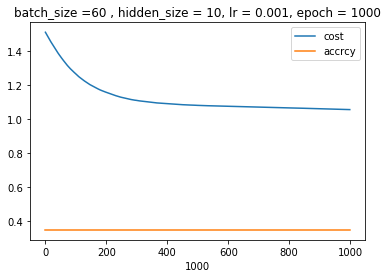

Training Accuracy:  0.35
Test Accuracy:  0.26666666666666666
epoch:  0 cost, accuracy:  1.750685195673308 0.325
epoch:  1 cost, accuracy:  1.74872108452614 0.325
epoch:  2 cost, accuracy:  1.7471814356233863 0.325
epoch:  3 cost, accuracy:  1.745720173493766 0.325
epoch:  4 cost, accuracy:  1.7440643881904525 0.325
epoch:  5 cost, accuracy:  1.7425536810274171 0.325
epoch:  6 cost, accuracy:  1.7408050882399857 0.325
epoch:  7 cost, accuracy:  1.7390106502132276 0.325
epoch:  8 cost, accuracy:  1.7378101930533265 0.325
epoch:  9 cost, accuracy:  1.7359196000149817 0.325
epoch:  10 cost, accuracy:  1.73432792356144 0.325
epoch:  11 cost, accuracy:  1.7330040380051661 0.325
epoch:  12 cost, accuracy:  1.731262304769005 0.325
epoch:  13 cost, accuracy:  1.729230379514959 0.325
epoch:  14 cost, accuracy:  1.727584606903513 0.325
epoch:  15 cost, accuracy:  1.7259865091332744 0.325
epoch:  16 cost, accuracy:  1.7241087711423648 0.325
epoch:  17 cost, accuracy:  1.7219192471361424 0.325
epoc

epoch:  155 cost, accuracy:  1.536865956590663 0.325
epoch:  156 cost, accuracy:  1.5357734455268972 0.325
epoch:  157 cost, accuracy:  1.5348608948465605 0.325
epoch:  158 cost, accuracy:  1.5341153033040986 0.325
epoch:  159 cost, accuracy:  1.533343333340872 0.325
epoch:  160 cost, accuracy:  1.532221296840062 0.325
epoch:  161 cost, accuracy:  1.5313381825822523 0.325
epoch:  162 cost, accuracy:  1.5305163606715988 0.325
epoch:  163 cost, accuracy:  1.52955057590829 0.325
epoch:  164 cost, accuracy:  1.5284207064585138 0.325
epoch:  165 cost, accuracy:  1.5277501487348075 0.325
epoch:  166 cost, accuracy:  1.5266506914145845 0.325
epoch:  167 cost, accuracy:  1.52562104181409 0.325
epoch:  168 cost, accuracy:  1.524523724509441 0.325
epoch:  169 cost, accuracy:  1.5235357976966606 0.325
epoch:  170 cost, accuracy:  1.5227668876282479 0.325
epoch:  171 cost, accuracy:  1.521951097779302 0.325
epoch:  172 cost, accuracy:  1.5207861281125763 0.325
epoch:  173 cost, accuracy:  1.519854

epoch:  308 cost, accuracy:  1.4245163884522687 0.325
epoch:  309 cost, accuracy:  1.4238839682570965 0.325
epoch:  310 cost, accuracy:  1.4231959300980914 0.325
epoch:  311 cost, accuracy:  1.4226364161491043 0.325
epoch:  312 cost, accuracy:  1.4221635481067998 0.325
epoch:  313 cost, accuracy:  1.421564358568848 0.325
epoch:  314 cost, accuracy:  1.4208440436009113 0.325
epoch:  315 cost, accuracy:  1.420165115744447 0.325
epoch:  316 cost, accuracy:  1.4195382775396213 0.325
epoch:  317 cost, accuracy:  1.4190619536797016 0.325
epoch:  318 cost, accuracy:  1.4184012122841092 0.325
epoch:  319 cost, accuracy:  1.417682108433501 0.325
epoch:  320 cost, accuracy:  1.4171171935459492 0.325
epoch:  321 cost, accuracy:  1.4166777437962095 0.325
epoch:  322 cost, accuracy:  1.4160966495720477 0.325
epoch:  323 cost, accuracy:  1.4156753447617314 0.325
epoch:  324 cost, accuracy:  1.4151601445436452 0.325
epoch:  325 cost, accuracy:  1.4145586939696628 0.325
epoch:  326 cost, accuracy:  1.

epoch:  461 cost, accuracy:  1.3514423463151168 0.325
epoch:  462 cost, accuracy:  1.3510731041314135 0.325
epoch:  463 cost, accuracy:  1.3507334772652648 0.325
epoch:  464 cost, accuracy:  1.350363937589441 0.325
epoch:  465 cost, accuracy:  1.3499921278511973 0.325
epoch:  466 cost, accuracy:  1.3496253959816173 0.325
epoch:  467 cost, accuracy:  1.349220941409056 0.325
epoch:  468 cost, accuracy:  1.3488347282062578 0.325
epoch:  469 cost, accuracy:  1.3483368513578837 0.325
epoch:  470 cost, accuracy:  1.3480314403699982 0.325
epoch:  471 cost, accuracy:  1.3476413650673613 0.325
epoch:  472 cost, accuracy:  1.347308847479266 0.325
epoch:  473 cost, accuracy:  1.3469155990094859 0.325
epoch:  474 cost, accuracy:  1.3465183005905659 0.325
epoch:  475 cost, accuracy:  1.3461413711500303 0.325
epoch:  476 cost, accuracy:  1.3457874759713575 0.325
epoch:  477 cost, accuracy:  1.3453223424978864 0.325
epoch:  478 cost, accuracy:  1.3450629257542106 0.325
epoch:  479 cost, accuracy:  1.

epoch:  614 cost, accuracy:  1.2990834689653676 0.325
epoch:  615 cost, accuracy:  1.298854198857208 0.325
epoch:  616 cost, accuracy:  1.298578573098086 0.325
epoch:  617 cost, accuracy:  1.2983456856808535 0.325
epoch:  618 cost, accuracy:  1.298029642762748 0.325
epoch:  619 cost, accuracy:  1.297684060925955 0.325
epoch:  620 cost, accuracy:  1.297351264171655 0.325
epoch:  621 cost, accuracy:  1.2970926601592978 0.325
epoch:  622 cost, accuracy:  1.2969408681361043 0.325
epoch:  623 cost, accuracy:  1.2966265284165492 0.325
epoch:  624 cost, accuracy:  1.2963740244913056 0.325
epoch:  625 cost, accuracy:  1.296103220345508 0.325
epoch:  626 cost, accuracy:  1.2957862850688424 0.325
epoch:  627 cost, accuracy:  1.2954186210417895 0.325
epoch:  628 cost, accuracy:  1.2950508828582425 0.325
epoch:  629 cost, accuracy:  1.2948257225402438 0.325
epoch:  630 cost, accuracy:  1.2944881915683244 0.325
epoch:  631 cost, accuracy:  1.2941958562368636 0.325
epoch:  632 cost, accuracy:  1.293

epoch:  750 cost, accuracy:  1.2636327965175305 0.26666666666666666
epoch:  751 cost, accuracy:  1.2634143682705514 0.275
epoch:  752 cost, accuracy:  1.2632028325815041 0.275
epoch:  753 cost, accuracy:  1.2628755879020053 0.26666666666666666
epoch:  754 cost, accuracy:  1.2626233211514981 0.26666666666666666
epoch:  755 cost, accuracy:  1.2624062267516407 0.26666666666666666
epoch:  756 cost, accuracy:  1.2621909261142912 0.26666666666666666
epoch:  757 cost, accuracy:  1.261960931896105 0.26666666666666666
epoch:  758 cost, accuracy:  1.2616615257930712 0.26666666666666666
epoch:  759 cost, accuracy:  1.2614222934729382 0.26666666666666666
epoch:  760 cost, accuracy:  1.261186854698265 0.26666666666666666
epoch:  761 cost, accuracy:  1.2609457527958576 0.26666666666666666
epoch:  762 cost, accuracy:  1.260715009656276 0.26666666666666666
epoch:  763 cost, accuracy:  1.260504411233032 0.26666666666666666
epoch:  764 cost, accuracy:  1.2602770939145964 0.26666666666666666
epoch:  765 

epoch:  876 cost, accuracy:  1.236256384464266 0.16666666666666666
epoch:  877 cost, accuracy:  1.2360044604655878 0.14166666666666666
epoch:  878 cost, accuracy:  1.2358401318661043 0.15833333333333333
epoch:  879 cost, accuracy:  1.2355945901766645 0.14166666666666666
epoch:  880 cost, accuracy:  1.23536251265158 0.14166666666666666
epoch:  881 cost, accuracy:  1.235209320348004 0.14166666666666666
epoch:  882 cost, accuracy:  1.2350280038298143 0.14166666666666666
epoch:  883 cost, accuracy:  1.2348568717928756 0.15833333333333333
epoch:  884 cost, accuracy:  1.234627611222085 0.14166666666666666
epoch:  885 cost, accuracy:  1.2344758982288966 0.15833333333333333
epoch:  886 cost, accuracy:  1.234279808586518 0.15833333333333333
epoch:  887 cost, accuracy:  1.2340860337789883 0.15833333333333333
epoch:  888 cost, accuracy:  1.2339115449425706 0.15833333333333333
epoch:  889 cost, accuracy:  1.233724591658308 0.15833333333333333
epoch:  890 cost, accuracy:  1.233510352210727 0.158333

epoch:  1000 cost, accuracy:  1.2128569307454993 0.1
epoch:  1001 cost, accuracy:  1.2126865522133277 0.1
epoch:  1002 cost, accuracy:  1.212534665852786 0.1
epoch:  1003 cost, accuracy:  1.2123495814005736 0.1
epoch:  1004 cost, accuracy:  1.2122082258641724 0.10833333333333334
epoch:  1005 cost, accuracy:  1.2120414091964133 0.1
epoch:  1006 cost, accuracy:  1.2118511900021862 0.1
epoch:  1007 cost, accuracy:  1.2116540304651224 0.1
epoch:  1008 cost, accuracy:  1.2114629225678888 0.1
epoch:  1009 cost, accuracy:  1.2112702762516903 0.1
epoch:  1010 cost, accuracy:  1.211121659685618 0.1
epoch:  1011 cost, accuracy:  1.2109383580787272 0.1
epoch:  1012 cost, accuracy:  1.2107900923975115 0.1
epoch:  1013 cost, accuracy:  1.2105887555323043 0.1
epoch:  1014 cost, accuracy:  1.2104085130383386 0.1
epoch:  1015 cost, accuracy:  1.2102138647535399 0.1
epoch:  1016 cost, accuracy:  1.2100288022283665 0.1
epoch:  1017 cost, accuracy:  1.2098530281091362 0.1
epoch:  1018 cost, accuracy:  1.

epoch:  1124 cost, accuracy:  1.1915690866129636 0.03333333333333333
epoch:  1125 cost, accuracy:  1.1913947604639437 0.03333333333333333
epoch:  1126 cost, accuracy:  1.1912615430566431 0.03333333333333333
epoch:  1127 cost, accuracy:  1.1911063506628687 0.03333333333333333
epoch:  1128 cost, accuracy:  1.1909781547605058 0.041666666666666664
epoch:  1129 cost, accuracy:  1.1907928568790822 0.03333333333333333
epoch:  1130 cost, accuracy:  1.1906322292063118 0.03333333333333333
epoch:  1131 cost, accuracy:  1.1904575832146451 0.03333333333333333
epoch:  1132 cost, accuracy:  1.190305550645399 0.03333333333333333
epoch:  1133 cost, accuracy:  1.1901579558646007 0.03333333333333333
epoch:  1134 cost, accuracy:  1.1899945139137027 0.03333333333333333
epoch:  1135 cost, accuracy:  1.1898641255043245 0.041666666666666664
epoch:  1136 cost, accuracy:  1.189718768952183 0.041666666666666664
epoch:  1137 cost, accuracy:  1.189582305574298 0.041666666666666664
epoch:  1138 cost, accuracy:  1.1

epoch:  1243 cost, accuracy:  1.173060279161292 0.03333333333333333
epoch:  1244 cost, accuracy:  1.172893491925666 0.03333333333333333
epoch:  1245 cost, accuracy:  1.172742092443472 0.03333333333333333
epoch:  1246 cost, accuracy:  1.172571101527477 0.03333333333333333
epoch:  1247 cost, accuracy:  1.1724144978114823 0.03333333333333333
epoch:  1248 cost, accuracy:  1.172284036930652 0.03333333333333333
epoch:  1249 cost, accuracy:  1.172160009938293 0.03333333333333333
epoch:  1250 cost, accuracy:  1.171993010810792 0.03333333333333333
epoch:  1251 cost, accuracy:  1.171845332791373 0.03333333333333333
epoch:  1252 cost, accuracy:  1.1716809389926295 0.03333333333333333
epoch:  1253 cost, accuracy:  1.1715415809997045 0.03333333333333333
epoch:  1254 cost, accuracy:  1.171396611383151 0.03333333333333333
epoch:  1255 cost, accuracy:  1.171247018394225 0.03333333333333333
epoch:  1256 cost, accuracy:  1.1711152721858618 0.03333333333333333
epoch:  1257 cost, accuracy:  1.170974798137

epoch:  1368 cost, accuracy:  1.1549158957527306 0.05
epoch:  1369 cost, accuracy:  1.1547652754769582 0.05
epoch:  1370 cost, accuracy:  1.1546256105086774 0.05
epoch:  1371 cost, accuracy:  1.1544925161826274 0.05
epoch:  1372 cost, accuracy:  1.154381072136511 0.058333333333333334
epoch:  1373 cost, accuracy:  1.1542601545983744 0.058333333333333334
epoch:  1374 cost, accuracy:  1.1541378963663012 0.05
epoch:  1375 cost, accuracy:  1.1539859804249923 0.05
epoch:  1376 cost, accuracy:  1.1538460054374156 0.05
epoch:  1377 cost, accuracy:  1.1536941849465028 0.05
epoch:  1378 cost, accuracy:  1.1535620171749896 0.05
epoch:  1379 cost, accuracy:  1.1534298288571625 0.05
epoch:  1380 cost, accuracy:  1.153280326440465 0.05
epoch:  1381 cost, accuracy:  1.1531554540119124 0.05
epoch:  1382 cost, accuracy:  1.1530170174667362 0.05
epoch:  1383 cost, accuracy:  1.152882318297953 0.05
epoch:  1384 cost, accuracy:  1.1527439905175088 0.05
epoch:  1385 cost, accuracy:  1.1525996214969039 0.05

epoch:  1500 cost, accuracy:  1.1371540246704535 0.25833333333333336
epoch:  1501 cost, accuracy:  1.1370214266517242 0.25
epoch:  1502 cost, accuracy:  1.1368859588132716 0.25833333333333336
epoch:  1503 cost, accuracy:  1.136754988586816 0.25833333333333336
epoch:  1504 cost, accuracy:  1.1366223056180123 0.26666666666666666
epoch:  1505 cost, accuracy:  1.136506806472831 0.25833333333333336
epoch:  1506 cost, accuracy:  1.1363797488245904 0.25
epoch:  1507 cost, accuracy:  1.136248461136446 0.25
epoch:  1508 cost, accuracy:  1.1361295828028388 0.24166666666666667
epoch:  1509 cost, accuracy:  1.1360034953196134 0.24166666666666667
epoch:  1510 cost, accuracy:  1.13585525785932 0.24166666666666667
epoch:  1511 cost, accuracy:  1.1357333314373543 0.25
epoch:  1512 cost, accuracy:  1.1356112688953983 0.24166666666666667
epoch:  1513 cost, accuracy:  1.1354759767585345 0.24166666666666667
epoch:  1514 cost, accuracy:  1.1353545937852667 0.25
epoch:  1515 cost, accuracy:  1.1351942155847

epoch:  1626 cost, accuracy:  1.1210667764567492 0.20833333333333334
epoch:  1627 cost, accuracy:  1.1209375931360612 0.20833333333333334
epoch:  1628 cost, accuracy:  1.120799239029527 0.20833333333333334
epoch:  1629 cost, accuracy:  1.1206502648061836 0.20833333333333334
epoch:  1630 cost, accuracy:  1.1204948264098986 0.20833333333333334
epoch:  1631 cost, accuracy:  1.1203577355488534 0.20833333333333334
epoch:  1632 cost, accuracy:  1.120231799909431 0.20833333333333334
epoch:  1633 cost, accuracy:  1.1200982466325722 0.20833333333333334
epoch:  1634 cost, accuracy:  1.119968061654617 0.20833333333333334
epoch:  1635 cost, accuracy:  1.1198315989166716 0.2
epoch:  1636 cost, accuracy:  1.1197059944471408 0.20833333333333334
epoch:  1637 cost, accuracy:  1.1195856742753734 0.20833333333333334
epoch:  1638 cost, accuracy:  1.1194524089485423 0.2
epoch:  1639 cost, accuracy:  1.1193221670716957 0.2
epoch:  1640 cost, accuracy:  1.1191775137721247 0.20833333333333334
epoch:  1641 cos

epoch:  1753 cost, accuracy:  1.1045386186296728 0.2916666666666667
epoch:  1754 cost, accuracy:  1.1044059309626357 0.3
epoch:  1755 cost, accuracy:  1.104289091480042 0.2916666666666667
epoch:  1756 cost, accuracy:  1.104146957238711 0.2916666666666667
epoch:  1757 cost, accuracy:  1.104015362878935 0.2916666666666667
epoch:  1758 cost, accuracy:  1.1038799646256385 0.2916666666666667
epoch:  1759 cost, accuracy:  1.1037688890296093 0.2916666666666667
epoch:  1760 cost, accuracy:  1.1036240025331476 0.2916666666666667
epoch:  1761 cost, accuracy:  1.1034931945437136 0.2916666666666667
epoch:  1762 cost, accuracy:  1.1033745102821588 0.2916666666666667
epoch:  1763 cost, accuracy:  1.103251491624861 0.2916666666666667
epoch:  1764 cost, accuracy:  1.103123842458803 0.2916666666666667
epoch:  1765 cost, accuracy:  1.1029949792210259 0.2916666666666667
epoch:  1766 cost, accuracy:  1.1028608545090448 0.2916666666666667
epoch:  1767 cost, accuracy:  1.1027417093423435 0.2916666666666667


epoch:  1876 cost, accuracy:  1.0886795965587261 0.2833333333333333
epoch:  1877 cost, accuracy:  1.0885622634164323 0.2833333333333333
epoch:  1878 cost, accuracy:  1.088439331627699 0.2833333333333333
epoch:  1879 cost, accuracy:  1.0883044927373065 0.2833333333333333
epoch:  1880 cost, accuracy:  1.0881571164576773 0.2833333333333333
epoch:  1881 cost, accuracy:  1.088028654264601 0.2833333333333333
epoch:  1882 cost, accuracy:  1.0878908965047756 0.2833333333333333
epoch:  1883 cost, accuracy:  1.0877601189510202 0.2833333333333333
epoch:  1884 cost, accuracy:  1.087615588638997 0.2833333333333333
epoch:  1885 cost, accuracy:  1.0874681795516565 0.2833333333333333
epoch:  1886 cost, accuracy:  1.0873316392862908 0.2833333333333333
epoch:  1887 cost, accuracy:  1.0872236263313828 0.2833333333333333
epoch:  1888 cost, accuracy:  1.0870971485940593 0.2833333333333333
epoch:  1889 cost, accuracy:  1.086994544215247 0.2833333333333333
epoch:  1890 cost, accuracy:  1.0868584464380426 0.2

epoch:  2006 cost, accuracy:  1.0715313336254695 0.43333333333333335
epoch:  2007 cost, accuracy:  1.071406180327248 0.43333333333333335
epoch:  2008 cost, accuracy:  1.071270137706276 0.43333333333333335
epoch:  2009 cost, accuracy:  1.0711426367484445 0.43333333333333335
epoch:  2010 cost, accuracy:  1.0710117435039843 0.43333333333333335
epoch:  2011 cost, accuracy:  1.0708641820409284 0.45
epoch:  2012 cost, accuracy:  1.0707375155022314 0.45
epoch:  2013 cost, accuracy:  1.0705952069180866 0.45
epoch:  2014 cost, accuracy:  1.0704491652545172 0.45
epoch:  2015 cost, accuracy:  1.0703295584271428 0.45
epoch:  2016 cost, accuracy:  1.07021617097087 0.45
epoch:  2017 cost, accuracy:  1.0700705302704125 0.45
epoch:  2018 cost, accuracy:  1.06993682187299 0.45
epoch:  2019 cost, accuracy:  1.0697918845939098 0.4583333333333333
epoch:  2020 cost, accuracy:  1.0696720877428059 0.4583333333333333
epoch:  2021 cost, accuracy:  1.0695729546957697 0.45
epoch:  2022 cost, accuracy:  1.0694469

epoch:  2133 cost, accuracy:  1.0543178172101912 0.6166666666666667
epoch:  2134 cost, accuracy:  1.0541758877384089 0.6166666666666667
epoch:  2135 cost, accuracy:  1.0540470605724552 0.6166666666666667
epoch:  2136 cost, accuracy:  1.0539094435096914 0.6166666666666667
epoch:  2137 cost, accuracy:  1.0537783175810624 0.6166666666666667
epoch:  2138 cost, accuracy:  1.0536372209719023 0.6166666666666667
epoch:  2139 cost, accuracy:  1.0534864438267284 0.625
epoch:  2140 cost, accuracy:  1.0533683044737858 0.6166666666666667
epoch:  2141 cost, accuracy:  1.0532280875523774 0.6166666666666667
epoch:  2142 cost, accuracy:  1.0531237863403433 0.6166666666666667
epoch:  2143 cost, accuracy:  1.052971561690857 0.625
epoch:  2144 cost, accuracy:  1.0528286827943294 0.625
epoch:  2145 cost, accuracy:  1.0526995260517549 0.625
epoch:  2146 cost, accuracy:  1.052559446955994 0.625
epoch:  2147 cost, accuracy:  1.052437132720228 0.625
epoch:  2148 cost, accuracy:  1.0522766116308853 0.625
epoch:

epoch:  2262 cost, accuracy:  1.0360814548070685 0.6333333333333333
epoch:  2263 cost, accuracy:  1.035946920481823 0.6333333333333333
epoch:  2264 cost, accuracy:  1.0358102735918766 0.6333333333333333
epoch:  2265 cost, accuracy:  1.0356569811297478 0.6333333333333333
epoch:  2266 cost, accuracy:  1.0355269029256038 0.6333333333333333
epoch:  2267 cost, accuracy:  1.0354155753994807 0.6333333333333333
epoch:  2268 cost, accuracy:  1.0352690918572334 0.6333333333333333
epoch:  2269 cost, accuracy:  1.0351279020619415 0.6333333333333333
epoch:  2270 cost, accuracy:  1.0350008219972464 0.6333333333333333
epoch:  2271 cost, accuracy:  1.0348554051870718 0.6333333333333333
epoch:  2272 cost, accuracy:  1.0347206192344587 0.6333333333333333
epoch:  2273 cost, accuracy:  1.0345746050319207 0.6333333333333333
epoch:  2274 cost, accuracy:  1.0344094635911918 0.6333333333333333
epoch:  2275 cost, accuracy:  1.034278217929112 0.6333333333333333
epoch:  2276 cost, accuracy:  1.03415485607113 0.6

epoch:  2384 cost, accuracy:  1.018423564406381 0.6333333333333333
epoch:  2385 cost, accuracy:  1.0182643662168094 0.6333333333333333
epoch:  2386 cost, accuracy:  1.0181210938241063 0.6333333333333333
epoch:  2387 cost, accuracy:  1.0179613077549936 0.6333333333333333
epoch:  2388 cost, accuracy:  1.017801314837712 0.6333333333333333
epoch:  2389 cost, accuracy:  1.0176689070445193 0.6333333333333333
epoch:  2390 cost, accuracy:  1.0175205517805155 0.6333333333333333
epoch:  2391 cost, accuracy:  1.0173777166691855 0.6333333333333333
epoch:  2392 cost, accuracy:  1.0172397568068365 0.6333333333333333
epoch:  2393 cost, accuracy:  1.0170848958114012 0.6333333333333333
epoch:  2394 cost, accuracy:  1.0169442401802458 0.6416666666666667
epoch:  2395 cost, accuracy:  1.0168007568292219 0.6333333333333333
epoch:  2396 cost, accuracy:  1.0166345832385388 0.6416666666666667
epoch:  2397 cost, accuracy:  1.016468352712144 0.6416666666666667
epoch:  2398 cost, accuracy:  1.0163280223970435 0.

epoch:  2506 cost, accuracy:  1.0004013311949445 0.6333333333333333
epoch:  2507 cost, accuracy:  1.000266144366806 0.6333333333333333
epoch:  2508 cost, accuracy:  1.0001204288684402 0.6333333333333333
epoch:  2509 cost, accuracy:  0.9999947969892754 0.6333333333333333
epoch:  2510 cost, accuracy:  0.9998553568499854 0.6333333333333333
epoch:  2511 cost, accuracy:  0.9997177320603606 0.6333333333333333
epoch:  2512 cost, accuracy:  0.999575293534553 0.6333333333333333
epoch:  2513 cost, accuracy:  0.999434586315684 0.6333333333333333
epoch:  2514 cost, accuracy:  0.9992955329321113 0.6333333333333333
epoch:  2515 cost, accuracy:  0.999139226329239 0.6333333333333333
epoch:  2516 cost, accuracy:  0.998997069887837 0.6333333333333333
epoch:  2517 cost, accuracy:  0.9988456411631155 0.6333333333333333
epoch:  2518 cost, accuracy:  0.9987254780252539 0.6333333333333333
epoch:  2519 cost, accuracy:  0.9985802034927845 0.6333333333333333
epoch:  2520 cost, accuracy:  0.9984402071366335 0.63

epoch:  2631 cost, accuracy:  0.9820989165462362 0.6583333333333333
epoch:  2632 cost, accuracy:  0.9819522694553596 0.6583333333333333
epoch:  2633 cost, accuracy:  0.9818097767430805 0.6583333333333333
epoch:  2634 cost, accuracy:  0.981670101393543 0.6583333333333333
epoch:  2635 cost, accuracy:  0.9815304458925861 0.6583333333333333
epoch:  2636 cost, accuracy:  0.9813744459514697 0.6583333333333333
epoch:  2637 cost, accuracy:  0.98123635501118 0.6583333333333333
epoch:  2638 cost, accuracy:  0.9810947589892564 0.6583333333333333
epoch:  2639 cost, accuracy:  0.9809539361722706 0.6583333333333333
epoch:  2640 cost, accuracy:  0.9808108558210749 0.6583333333333333
epoch:  2641 cost, accuracy:  0.9806609249613153 0.6583333333333333
epoch:  2642 cost, accuracy:  0.9805132788679631 0.6583333333333333
epoch:  2643 cost, accuracy:  0.9803662968745736 0.6583333333333333
epoch:  2644 cost, accuracy:  0.980228940746499 0.6583333333333333
epoch:  2645 cost, accuracy:  0.9800960048196455 0.6

epoch:  2753 cost, accuracy:  0.9645177682313426 0.6583333333333333
epoch:  2754 cost, accuracy:  0.9643766374687931 0.6583333333333333
epoch:  2755 cost, accuracy:  0.9642287697324394 0.6583333333333333
epoch:  2756 cost, accuracy:  0.9640863510038602 0.6583333333333333
epoch:  2757 cost, accuracy:  0.9639359912976878 0.6583333333333333
epoch:  2758 cost, accuracy:  0.9637883508262628 0.6583333333333333
epoch:  2759 cost, accuracy:  0.9636475779907688 0.6583333333333333
epoch:  2760 cost, accuracy:  0.9635124233297321 0.6583333333333333
epoch:  2761 cost, accuracy:  0.9633782479373011 0.6583333333333333
epoch:  2762 cost, accuracy:  0.9632226263031727 0.6583333333333333
epoch:  2763 cost, accuracy:  0.9630826177783937 0.6583333333333333
epoch:  2764 cost, accuracy:  0.9629439662839161 0.6583333333333333
epoch:  2765 cost, accuracy:  0.9627907637237524 0.6583333333333333
epoch:  2766 cost, accuracy:  0.9626439568415138 0.6583333333333333
epoch:  2767 cost, accuracy:  0.9625029805609572

epoch:  2883 cost, accuracy:  0.946153809946282 0.6583333333333333
epoch:  2884 cost, accuracy:  0.9460076145561916 0.6583333333333333
epoch:  2885 cost, accuracy:  0.9458725595800217 0.6583333333333333
epoch:  2886 cost, accuracy:  0.9457277854851459 0.6583333333333333
epoch:  2887 cost, accuracy:  0.9455913072669181 0.6583333333333333
epoch:  2888 cost, accuracy:  0.9454543758307064 0.6583333333333333
epoch:  2889 cost, accuracy:  0.9453243602860387 0.6583333333333333
epoch:  2890 cost, accuracy:  0.9451838910469234 0.6583333333333333
epoch:  2891 cost, accuracy:  0.9450410347634068 0.6583333333333333
epoch:  2892 cost, accuracy:  0.9449191490676978 0.6583333333333333
epoch:  2893 cost, accuracy:  0.9447891534399614 0.6583333333333333
epoch:  2894 cost, accuracy:  0.9446500856715077 0.6583333333333333
epoch:  2895 cost, accuracy:  0.9445134446712753 0.6583333333333333
epoch:  2896 cost, accuracy:  0.9443750519172457 0.6583333333333333
epoch:  2897 cost, accuracy:  0.9442267885322921 

epoch:  3004 cost, accuracy:  0.9295449747820325 0.6583333333333333
epoch:  3005 cost, accuracy:  0.9294079579528803 0.6583333333333333
epoch:  3006 cost, accuracy:  0.9292751919488946 0.6583333333333333
epoch:  3007 cost, accuracy:  0.9291449821809667 0.6583333333333333
epoch:  3008 cost, accuracy:  0.9290095508559997 0.6583333333333333
epoch:  3009 cost, accuracy:  0.92887388914686 0.6583333333333333
epoch:  3010 cost, accuracy:  0.9287365206727235 0.6583333333333333
epoch:  3011 cost, accuracy:  0.9285982874923813 0.6583333333333333
epoch:  3012 cost, accuracy:  0.9284673949030862 0.6583333333333333
epoch:  3013 cost, accuracy:  0.9283351359223551 0.6583333333333333
epoch:  3014 cost, accuracy:  0.9281989255871831 0.6583333333333333
epoch:  3015 cost, accuracy:  0.9280620179393445 0.6583333333333333
epoch:  3016 cost, accuracy:  0.927925113333234 0.6583333333333333
epoch:  3017 cost, accuracy:  0.9277898528268317 0.6583333333333333
epoch:  3018 cost, accuracy:  0.9276553437358023 0.

epoch:  3125 cost, accuracy:  0.9136369956215166 0.6583333333333333
epoch:  3126 cost, accuracy:  0.913508529534979 0.6583333333333333
epoch:  3127 cost, accuracy:  0.9133824666834411 0.6583333333333333
epoch:  3128 cost, accuracy:  0.9132553355609992 0.6583333333333333
epoch:  3129 cost, accuracy:  0.9131228207502549 0.6583333333333333
epoch:  3130 cost, accuracy:  0.912993711135626 0.6583333333333333
epoch:  3131 cost, accuracy:  0.9128681830633378 0.6583333333333333
epoch:  3132 cost, accuracy:  0.9127410980850679 0.6583333333333333
epoch:  3133 cost, accuracy:  0.9126142164151221 0.6583333333333333
epoch:  3134 cost, accuracy:  0.9124898406241021 0.65
epoch:  3135 cost, accuracy:  0.9123606079697607 0.65
epoch:  3136 cost, accuracy:  0.9122291923664254 0.6416666666666667
epoch:  3137 cost, accuracy:  0.9120981208884321 0.65
epoch:  3138 cost, accuracy:  0.9119656916412897 0.6416666666666667
epoch:  3139 cost, accuracy:  0.9118314494240365 0.65
epoch:  3140 cost, accuracy:  0.911701

epoch:  3255 cost, accuracy:  0.8973351784130483 0.65
epoch:  3256 cost, accuracy:  0.8972109103695532 0.65
epoch:  3257 cost, accuracy:  0.8970874838554105 0.6416666666666667
epoch:  3258 cost, accuracy:  0.8969755674142905 0.6416666666666667
epoch:  3259 cost, accuracy:  0.89685195953799 0.6416666666666667
epoch:  3260 cost, accuracy:  0.8967338286173769 0.6416666666666667
epoch:  3261 cost, accuracy:  0.8966180499382882 0.6416666666666667
epoch:  3262 cost, accuracy:  0.8964957921017646 0.6416666666666667
epoch:  3263 cost, accuracy:  0.8963764056345195 0.6416666666666667
epoch:  3264 cost, accuracy:  0.8962599799448623 0.6416666666666667
epoch:  3265 cost, accuracy:  0.896150365222295 0.6416666666666667
epoch:  3266 cost, accuracy:  0.8960362179028982 0.6416666666666667
epoch:  3267 cost, accuracy:  0.8959147176981576 0.65
epoch:  3268 cost, accuracy:  0.8957947149689836 0.6416666666666667
epoch:  3269 cost, accuracy:  0.8956560262700307 0.6416666666666667
epoch:  3270 cost, accura

epoch:  3382 cost, accuracy:  0.8821234955638223 0.65
epoch:  3383 cost, accuracy:  0.8820051217044474 0.65
epoch:  3384 cost, accuracy:  0.8818862989714407 0.65
epoch:  3385 cost, accuracy:  0.8817721273755217 0.65
epoch:  3386 cost, accuracy:  0.8816547943794032 0.65
epoch:  3387 cost, accuracy:  0.8815409237960121 0.6416666666666667
epoch:  3388 cost, accuracy:  0.8814229544940837 0.6416666666666667
epoch:  3389 cost, accuracy:  0.8813056356688788 0.6416666666666667
epoch:  3390 cost, accuracy:  0.8811895098783673 0.6416666666666667
epoch:  3391 cost, accuracy:  0.8810780038148126 0.6416666666666667
epoch:  3392 cost, accuracy:  0.8809627026388471 0.6416666666666667
epoch:  3393 cost, accuracy:  0.8808414312612164 0.6416666666666667
epoch:  3394 cost, accuracy:  0.8807309574171642 0.6416666666666667
epoch:  3395 cost, accuracy:  0.8806147558238261 0.65
epoch:  3396 cost, accuracy:  0.8804962365793894 0.6416666666666667
epoch:  3397 cost, accuracy:  0.8803793544516328 0.65
epoch:  33

epoch:  3513 cost, accuracy:  0.8672093914545012 0.65
epoch:  3514 cost, accuracy:  0.8670993370478786 0.65
epoch:  3515 cost, accuracy:  0.8669925084994079 0.65
epoch:  3516 cost, accuracy:  0.8668874635704338 0.65
epoch:  3517 cost, accuracy:  0.866777000153777 0.65
epoch:  3518 cost, accuracy:  0.8666644702852906 0.65
epoch:  3519 cost, accuracy:  0.8665516807404184 0.65
epoch:  3520 cost, accuracy:  0.8664374288443265 0.65
epoch:  3521 cost, accuracy:  0.8663287012194257 0.65
epoch:  3522 cost, accuracy:  0.8662151748554495 0.65
epoch:  3523 cost, accuracy:  0.8661026026147127 0.65
epoch:  3524 cost, accuracy:  0.8659895955196872 0.65
epoch:  3525 cost, accuracy:  0.8658803685589387 0.65
epoch:  3526 cost, accuracy:  0.8657659778884081 0.65
epoch:  3527 cost, accuracy:  0.8656537261754971 0.65
epoch:  3528 cost, accuracy:  0.8655455739217627 0.65
epoch:  3529 cost, accuracy:  0.8654351787104427 0.65
epoch:  3530 cost, accuracy:  0.8653244872578038 0.65
epoch:  3531 cost, accuracy: 

epoch:  3647 cost, accuracy:  0.8527851946185471 0.65
epoch:  3648 cost, accuracy:  0.8526754210833907 0.6583333333333333
epoch:  3649 cost, accuracy:  0.852570006155102 0.6583333333333333
epoch:  3650 cost, accuracy:  0.8524583166340466 0.6583333333333333
epoch:  3651 cost, accuracy:  0.8523456863608466 0.6583333333333333
epoch:  3652 cost, accuracy:  0.8522437173949539 0.6583333333333333
epoch:  3653 cost, accuracy:  0.852135588850601 0.6583333333333333
epoch:  3654 cost, accuracy:  0.8520323898948717 0.65
epoch:  3655 cost, accuracy:  0.8519292875960806 0.6583333333333333
epoch:  3656 cost, accuracy:  0.8518325867672539 0.65
epoch:  3657 cost, accuracy:  0.851728298748261 0.65
epoch:  3658 cost, accuracy:  0.8516272515509385 0.6583333333333333
epoch:  3659 cost, accuracy:  0.8515259912370422 0.65
epoch:  3660 cost, accuracy:  0.8514266811575645 0.65
epoch:  3661 cost, accuracy:  0.8513284986471313 0.6416666666666667
epoch:  3662 cost, accuracy:  0.8512271359442397 0.6416666666666667

epoch:  3779 cost, accuracy:  0.839302223651796 0.6583333333333333
epoch:  3780 cost, accuracy:  0.8392092243832923 0.6583333333333333
epoch:  3781 cost, accuracy:  0.8391093416693419 0.6583333333333333
epoch:  3782 cost, accuracy:  0.8390083550149657 0.6583333333333333
epoch:  3783 cost, accuracy:  0.83890668942487 0.6583333333333333
epoch:  3784 cost, accuracy:  0.8388017126874973 0.6583333333333333
epoch:  3785 cost, accuracy:  0.8387050468695928 0.6583333333333333
epoch:  3786 cost, accuracy:  0.8386069778972278 0.6583333333333333
epoch:  3787 cost, accuracy:  0.8385062517103482 0.6583333333333333
epoch:  3788 cost, accuracy:  0.8384125566613801 0.6583333333333333
epoch:  3789 cost, accuracy:  0.8383146297751689 0.6583333333333333
epoch:  3790 cost, accuracy:  0.8382123413034951 0.6583333333333333
epoch:  3791 cost, accuracy:  0.8381154601270062 0.6583333333333333
epoch:  3792 cost, accuracy:  0.838020145677984 0.6583333333333333
epoch:  3793 cost, accuracy:  0.8379253587459575 0.6

epoch:  3900 cost, accuracy:  0.8275517577514666 0.6583333333333333
epoch:  3901 cost, accuracy:  0.8274573039223589 0.6583333333333333
epoch:  3902 cost, accuracy:  0.8273626867220083 0.6583333333333333
epoch:  3903 cost, accuracy:  0.8272677115917524 0.6583333333333333
epoch:  3904 cost, accuracy:  0.8271731121963517 0.6583333333333333
epoch:  3905 cost, accuracy:  0.8270753763220163 0.6583333333333333
epoch:  3906 cost, accuracy:  0.8269773602373297 0.6583333333333333
epoch:  3907 cost, accuracy:  0.8268831743466457 0.6583333333333333
epoch:  3908 cost, accuracy:  0.8267913462559059 0.6666666666666666
epoch:  3909 cost, accuracy:  0.826696531758213 0.6666666666666666
epoch:  3910 cost, accuracy:  0.8266034296485574 0.6666666666666666
epoch:  3911 cost, accuracy:  0.8265132072538612 0.6666666666666666
epoch:  3912 cost, accuracy:  0.8264199353457118 0.6666666666666666
epoch:  3913 cost, accuracy:  0.8263261439122374 0.6666666666666666
epoch:  3914 cost, accuracy:  0.8262314809681965 

epoch:  4021 cost, accuracy:  0.8163756618089166 0.6666666666666666
epoch:  4022 cost, accuracy:  0.8162822987080354 0.6666666666666666
epoch:  4023 cost, accuracy:  0.8161922719260093 0.6666666666666666
epoch:  4024 cost, accuracy:  0.8161009878314363 0.6666666666666666
epoch:  4025 cost, accuracy:  0.8160135816080398 0.6666666666666666
epoch:  4026 cost, accuracy:  0.8159231552564601 0.6666666666666666
epoch:  4027 cost, accuracy:  0.8158333951906209 0.6666666666666666
epoch:  4028 cost, accuracy:  0.8157458202359635 0.6666666666666666
epoch:  4029 cost, accuracy:  0.8156585730558278 0.6666666666666666
epoch:  4030 cost, accuracy:  0.8155717577033381 0.6666666666666666
epoch:  4031 cost, accuracy:  0.815485591386094 0.6666666666666666
epoch:  4032 cost, accuracy:  0.8153946969667079 0.6666666666666666
epoch:  4033 cost, accuracy:  0.8153093861246334 0.6666666666666666
epoch:  4034 cost, accuracy:  0.8152206739168025 0.6666666666666666
epoch:  4035 cost, accuracy:  0.8151320424900823 

epoch:  4148 cost, accuracy:  0.8051619509578597 0.675
epoch:  4149 cost, accuracy:  0.8050763363622089 0.675
epoch:  4150 cost, accuracy:  0.804994903635604 0.675
epoch:  4151 cost, accuracy:  0.8049038957466017 0.675
epoch:  4152 cost, accuracy:  0.8048190598211689 0.675
epoch:  4153 cost, accuracy:  0.8047320594203167 0.675
epoch:  4154 cost, accuracy:  0.8046425865864141 0.675
epoch:  4155 cost, accuracy:  0.8045569797976836 0.675
epoch:  4156 cost, accuracy:  0.804469765491531 0.675
epoch:  4157 cost, accuracy:  0.8043853222039701 0.675
epoch:  4158 cost, accuracy:  0.8042974319493374 0.675
epoch:  4159 cost, accuracy:  0.8042115532860713 0.675
epoch:  4160 cost, accuracy:  0.8041273332062305 0.675
epoch:  4161 cost, accuracy:  0.8040380179049518 0.675
epoch:  4162 cost, accuracy:  0.8039523517810363 0.675
epoch:  4163 cost, accuracy:  0.8038655426573377 0.675
epoch:  4164 cost, accuracy:  0.8037775105537411 0.675
epoch:  4165 cost, accuracy:  0.8036934797045799 0.675
epoch:  4166

epoch:  4298 cost, accuracy:  0.7926395262813971 0.675
epoch:  4299 cost, accuracy:  0.7925607489032784 0.675
epoch:  4300 cost, accuracy:  0.7924783272548249 0.675
epoch:  4301 cost, accuracy:  0.7923984360133729 0.675
epoch:  4302 cost, accuracy:  0.792320792782135 0.675
epoch:  4303 cost, accuracy:  0.7922371897780577 0.675
epoch:  4304 cost, accuracy:  0.7921570617491903 0.675
epoch:  4305 cost, accuracy:  0.792077281917408 0.675
epoch:  4306 cost, accuracy:  0.7919957043364066 0.675
epoch:  4307 cost, accuracy:  0.7919142524381244 0.675
epoch:  4308 cost, accuracy:  0.7918326058078263 0.675
epoch:  4309 cost, accuracy:  0.7917496512710616 0.675
epoch:  4310 cost, accuracy:  0.7916745448856749 0.675
epoch:  4311 cost, accuracy:  0.7915915073553613 0.675
epoch:  4312 cost, accuracy:  0.7915082184051724 0.675
epoch:  4313 cost, accuracy:  0.7914267734043646 0.675
epoch:  4314 cost, accuracy:  0.7913497182698588 0.675
epoch:  4315 cost, accuracy:  0.7912649461527477 0.675
epoch:  4316

epoch:  4448 cost, accuracy:  0.7808147623672033 0.675
epoch:  4449 cost, accuracy:  0.7807410232471332 0.675
epoch:  4450 cost, accuracy:  0.7806601354429942 0.675
epoch:  4451 cost, accuracy:  0.7805893459143897 0.675
epoch:  4452 cost, accuracy:  0.780508127592911 0.675
epoch:  4453 cost, accuracy:  0.7804290630332713 0.675
epoch:  4454 cost, accuracy:  0.780358442871028 0.675
epoch:  4455 cost, accuracy:  0.7802767995549229 0.675
epoch:  4456 cost, accuracy:  0.7802005140557999 0.6666666666666666
epoch:  4457 cost, accuracy:  0.780115679434072 0.675
epoch:  4458 cost, accuracy:  0.7800419818784371 0.675
epoch:  4459 cost, accuracy:  0.7799612121716054 0.675
epoch:  4460 cost, accuracy:  0.7798803781666629 0.675
epoch:  4461 cost, accuracy:  0.7798093546598689 0.6666666666666666
epoch:  4462 cost, accuracy:  0.7797315759538819 0.6666666666666666
epoch:  4463 cost, accuracy:  0.7796511620510758 0.6666666666666666
epoch:  4464 cost, accuracy:  0.7795731257974119 0.675
epoch:  4465 cos

epoch:  4595 cost, accuracy:  0.7697535689019631 0.675
epoch:  4596 cost, accuracy:  0.7696797225948978 0.675
epoch:  4597 cost, accuracy:  0.7696085712081311 0.675
epoch:  4598 cost, accuracy:  0.7695341381433006 0.675
epoch:  4599 cost, accuracy:  0.769457969545814 0.675
epoch:  4600 cost, accuracy:  0.769387672100541 0.675
epoch:  4601 cost, accuracy:  0.7693153754655201 0.675
epoch:  4602 cost, accuracy:  0.7692380067392431 0.675
epoch:  4603 cost, accuracy:  0.7691685015163205 0.675
epoch:  4604 cost, accuracy:  0.7690935225656702 0.675
epoch:  4605 cost, accuracy:  0.7690195245716217 0.675
epoch:  4606 cost, accuracy:  0.7689442990194464 0.675
epoch:  4607 cost, accuracy:  0.7688724368106836 0.675
epoch:  4608 cost, accuracy:  0.7687950791013916 0.675
epoch:  4609 cost, accuracy:  0.7687241881388094 0.675
epoch:  4610 cost, accuracy:  0.7686527419692439 0.675
epoch:  4611 cost, accuracy:  0.7685783457603935 0.675
epoch:  4612 cost, accuracy:  0.7685067483817382 0.675
epoch:  4613

epoch:  4745 cost, accuracy:  0.7590981465967133 0.675
epoch:  4746 cost, accuracy:  0.7590276900658878 0.675
epoch:  4747 cost, accuracy:  0.7589565059524552 0.675
epoch:  4748 cost, accuracy:  0.7588892464921774 0.675
epoch:  4749 cost, accuracy:  0.75881781706735 0.675
epoch:  4750 cost, accuracy:  0.758742319478649 0.675
epoch:  4751 cost, accuracy:  0.7586743125221344 0.675
epoch:  4752 cost, accuracy:  0.7586061215571959 0.675
epoch:  4753 cost, accuracy:  0.7585421833038819 0.675
epoch:  4754 cost, accuracy:  0.7584709500986136 0.675
epoch:  4755 cost, accuracy:  0.7584074941105975 0.675
epoch:  4756 cost, accuracy:  0.7583412440683712 0.675
epoch:  4757 cost, accuracy:  0.7582765646957671 0.675
epoch:  4758 cost, accuracy:  0.7582036597045857 0.675
epoch:  4759 cost, accuracy:  0.7581312897500453 0.675
epoch:  4760 cost, accuracy:  0.7580632546789269 0.675
epoch:  4761 cost, accuracy:  0.7579961837901793 0.675
epoch:  4762 cost, accuracy:  0.7579309335340265 0.675
epoch:  4763 

epoch:  4895 cost, accuracy:  0.7489114628127145 0.675
epoch:  4896 cost, accuracy:  0.7488473184380273 0.675
epoch:  4897 cost, accuracy:  0.7487780986729509 0.675
epoch:  4898 cost, accuracy:  0.7487112422846359 0.675
epoch:  4899 cost, accuracy:  0.7486477700062972 0.675
epoch:  4900 cost, accuracy:  0.7485855290756452 0.675
epoch:  4901 cost, accuracy:  0.7485194413173366 0.675
epoch:  4902 cost, accuracy:  0.7484541433267976 0.675
epoch:  4903 cost, accuracy:  0.7483882585368343 0.675
epoch:  4904 cost, accuracy:  0.7483242603163881 0.675
epoch:  4905 cost, accuracy:  0.7482551783584126 0.675
epoch:  4906 cost, accuracy:  0.7481897325295612 0.675
epoch:  4907 cost, accuracy:  0.7481259249473645 0.675
epoch:  4908 cost, accuracy:  0.7480641838354727 0.675
epoch:  4909 cost, accuracy:  0.7479992862765176 0.675
epoch:  4910 cost, accuracy:  0.7479348838904752 0.675
epoch:  4911 cost, accuracy:  0.7478679668923973 0.675
epoch:  4912 cost, accuracy:  0.7478045561650241 0.675
epoch:  49

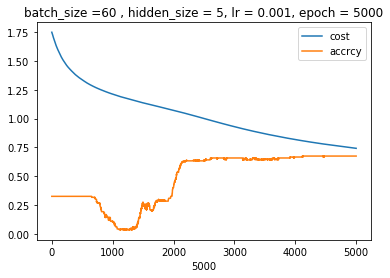

Training Accuracy:  0.675
Test Accuracy:  0.6333333333333333
epoch:  0 cost, accuracy:  1.4941094410728748 0.35
epoch:  1 cost, accuracy:  1.490549276107008 0.35
epoch:  2 cost, accuracy:  1.4873800912296324 0.35
epoch:  3 cost, accuracy:  1.4847453323051039 0.35
epoch:  4 cost, accuracy:  1.481469037108806 0.35
epoch:  5 cost, accuracy:  1.4785139180823033 0.35
epoch:  6 cost, accuracy:  1.4753323206536106 0.35
epoch:  7 cost, accuracy:  1.4724032988023135 0.35
epoch:  8 cost, accuracy:  1.4696793247800328 0.35
epoch:  9 cost, accuracy:  1.4669703176083861 0.35
epoch:  10 cost, accuracy:  1.464491723565185 0.35
epoch:  11 cost, accuracy:  1.462066501012104 0.35
epoch:  12 cost, accuracy:  1.4595906032362345 0.35
epoch:  13 cost, accuracy:  1.456772416655114 0.35
epoch:  14 cost, accuracy:  1.4539281270473092 0.35
epoch:  15 cost, accuracy:  1.451822108701805 0.35
epoch:  16 cost, accuracy:  1.4493189367410628 0.35
epoch:  17 cost, accuracy:  1.446641656611385 0.35
epoch:  18 cost, acc

epoch:  157 cost, accuracy:  1.2170502516714043 0.35
epoch:  158 cost, accuracy:  1.2156907058994562 0.35
epoch:  159 cost, accuracy:  1.214414055038464 0.35
epoch:  160 cost, accuracy:  1.2133519113911102 0.35
epoch:  161 cost, accuracy:  1.2122904312774556 0.35
epoch:  162 cost, accuracy:  1.2111745683318362 0.35
epoch:  163 cost, accuracy:  1.2099697335399477 0.35
epoch:  164 cost, accuracy:  1.2088782873612312 0.35
epoch:  165 cost, accuracy:  1.2077469654184012 0.35
epoch:  166 cost, accuracy:  1.206510669356767 0.35
epoch:  167 cost, accuracy:  1.2053658890345924 0.35
epoch:  168 cost, accuracy:  1.2042240432357445 0.35
epoch:  169 cost, accuracy:  1.2031040819367997 0.35
epoch:  170 cost, accuracy:  1.2019665741679513 0.35
epoch:  171 cost, accuracy:  1.2007481931903285 0.35
epoch:  172 cost, accuracy:  1.1995011035767547 0.35
epoch:  173 cost, accuracy:  1.1983376406915018 0.35
epoch:  174 cost, accuracy:  1.1971139321125945 0.35
epoch:  175 cost, accuracy:  1.1959065741297568 

epoch:  313 cost, accuracy:  1.0577450752208994 0.35
epoch:  314 cost, accuracy:  1.0568482312017384 0.35
epoch:  315 cost, accuracy:  1.0559851896972867 0.35
epoch:  316 cost, accuracy:  1.0550442428038762 0.35
epoch:  317 cost, accuracy:  1.0541839013029195 0.35
epoch:  318 cost, accuracy:  1.0533188437259977 0.35
epoch:  319 cost, accuracy:  1.0523951425248963 0.35
epoch:  320 cost, accuracy:  1.0515383601496082 0.35
epoch:  321 cost, accuracy:  1.0506290573776418 0.35
epoch:  322 cost, accuracy:  1.0498269140117447 0.35
epoch:  323 cost, accuracy:  1.0490048974696373 0.35
epoch:  324 cost, accuracy:  1.0481027768431448 0.35
epoch:  325 cost, accuracy:  1.0472254918285533 0.35
epoch:  326 cost, accuracy:  1.0463352092783897 0.35
epoch:  327 cost, accuracy:  1.0454415398417818 0.35
epoch:  328 cost, accuracy:  1.0445514754636611 0.35
epoch:  329 cost, accuracy:  1.0436980506030553 0.35
epoch:  330 cost, accuracy:  1.0428327498109733 0.35
epoch:  331 cost, accuracy:  1.041960202824770

epoch:  469 cost, accuracy:  0.9373782172145744 0.35
epoch:  470 cost, accuracy:  0.9367277143534024 0.35
epoch:  471 cost, accuracy:  0.9360431140763532 0.35
epoch:  472 cost, accuracy:  0.9353835380373646 0.35
epoch:  473 cost, accuracy:  0.9347132854637424 0.35
epoch:  474 cost, accuracy:  0.9340553622316438 0.35
epoch:  475 cost, accuracy:  0.933391674211438 0.35
epoch:  476 cost, accuracy:  0.9327006726495547 0.35
epoch:  477 cost, accuracy:  0.932059875745302 0.35
epoch:  478 cost, accuracy:  0.9313725202800308 0.35
epoch:  479 cost, accuracy:  0.9307024347843992 0.35833333333333334
epoch:  480 cost, accuracy:  0.9300812909227256 0.35833333333333334
epoch:  481 cost, accuracy:  0.9294262670042521 0.35833333333333334
epoch:  482 cost, accuracy:  0.9287617562902296 0.35833333333333334
epoch:  483 cost, accuracy:  0.9281171855016461 0.35833333333333334
epoch:  484 cost, accuracy:  0.9274853972357052 0.35833333333333334
epoch:  485 cost, accuracy:  0.926816718784996 0.358333333333333

epoch:  602 cost, accuracy:  0.8584107608040178 0.5833333333333334
epoch:  603 cost, accuracy:  0.857896881570774 0.5833333333333334
epoch:  604 cost, accuracy:  0.8573910493704349 0.5833333333333334
epoch:  605 cost, accuracy:  0.8568883417920637 0.5833333333333334
epoch:  606 cost, accuracy:  0.8563769048092635 0.5916666666666667
epoch:  607 cost, accuracy:  0.8558512853374803 0.5916666666666667
epoch:  608 cost, accuracy:  0.8553397883534092 0.5916666666666667
epoch:  609 cost, accuracy:  0.8548375452635336 0.5916666666666667
epoch:  610 cost, accuracy:  0.8543106716028573 0.5916666666666667
epoch:  611 cost, accuracy:  0.8537841173801719 0.5916666666666667
epoch:  612 cost, accuracy:  0.8532996172655293 0.5916666666666667
epoch:  613 cost, accuracy:  0.8527885297886085 0.5916666666666667
epoch:  614 cost, accuracy:  0.8522894458417594 0.5916666666666667
epoch:  615 cost, accuracy:  0.8517812458163535 0.5916666666666667
epoch:  616 cost, accuracy:  0.8512472227543147 0.5916666666666

epoch:  730 cost, accuracy:  0.7993814035591239 0.6666666666666666
epoch:  731 cost, accuracy:  0.7989864202741067 0.6666666666666666
epoch:  732 cost, accuracy:  0.7985846445920632 0.6666666666666666
epoch:  733 cost, accuracy:  0.7981869630151178 0.6666666666666666
epoch:  734 cost, accuracy:  0.7977817281932889 0.6666666666666666
epoch:  735 cost, accuracy:  0.7973634378239376 0.6666666666666666
epoch:  736 cost, accuracy:  0.7969482283919186 0.6666666666666666
epoch:  737 cost, accuracy:  0.7965395315021269 0.6666666666666666
epoch:  738 cost, accuracy:  0.7961468686734698 0.6666666666666666
epoch:  739 cost, accuracy:  0.7957421733696558 0.6666666666666666
epoch:  740 cost, accuracy:  0.7953372140167315 0.6666666666666666
epoch:  741 cost, accuracy:  0.794933048485709 0.6666666666666666
epoch:  742 cost, accuracy:  0.7945293577939788 0.6666666666666666
epoch:  743 cost, accuracy:  0.7941371577993903 0.6666666666666666
epoch:  744 cost, accuracy:  0.7937375518128521 0.6666666666666

epoch:  866 cost, accuracy:  0.7504353743172211 0.7083333333333334
epoch:  867 cost, accuracy:  0.7501192627134574 0.7083333333333334
epoch:  868 cost, accuracy:  0.7498013283837124 0.7083333333333334
epoch:  869 cost, accuracy:  0.7494812872228525 0.7083333333333334
epoch:  870 cost, accuracy:  0.7491816438486992 0.7083333333333334
epoch:  871 cost, accuracy:  0.7488710640822024 0.7083333333333334
epoch:  872 cost, accuracy:  0.748568607431324 0.7083333333333334
epoch:  873 cost, accuracy:  0.748247465632843 0.7083333333333334
epoch:  874 cost, accuracy:  0.7479373403008833 0.7083333333333334
epoch:  875 cost, accuracy:  0.7476241520053445 0.7166666666666667
epoch:  876 cost, accuracy:  0.7473149323277699 0.7166666666666667
epoch:  877 cost, accuracy:  0.7470099524050476 0.7166666666666667
epoch:  878 cost, accuracy:  0.7467099019657335 0.7166666666666667
epoch:  879 cost, accuracy:  0.7464083665390563 0.7166666666666667
epoch:  880 cost, accuracy:  0.746091822398729 0.716666666666666

epoch:  992 cost, accuracy:  0.7145426260610321 0.7916666666666666
epoch:  993 cost, accuracy:  0.7142728869860494 0.7916666666666666
epoch:  994 cost, accuracy:  0.7140312545844272 0.7916666666666666
epoch:  995 cost, accuracy:  0.7137510975974927 0.7916666666666666
epoch:  996 cost, accuracy:  0.7135018978631698 0.7916666666666666
epoch:  997 cost, accuracy:  0.7132329709814965 0.7916666666666666
epoch:  998 cost, accuracy:  0.7129886541357905 0.7916666666666666
epoch:  999 cost, accuracy:  0.7127444080609241 0.7916666666666666
epoch:  1000 cost, accuracy:  0.7124810616861527 0.7916666666666666
epoch:  1001 cost, accuracy:  0.7122177083630087 0.7916666666666666
epoch:  1002 cost, accuracy:  0.7119645034722311 0.7916666666666666
epoch:  1003 cost, accuracy:  0.7117210503382719 0.7916666666666666
epoch:  1004 cost, accuracy:  0.7114495761684267 0.7916666666666666
epoch:  1005 cost, accuracy:  0.711201492977239 0.7916666666666666
epoch:  1006 cost, accuracy:  0.7109465151909212 0.791666

epoch:  1117 cost, accuracy:  0.6851843716139753 0.8083333333333333
epoch:  1118 cost, accuracy:  0.6849750780353948 0.8083333333333333
epoch:  1119 cost, accuracy:  0.6847641960830797 0.8083333333333333
epoch:  1120 cost, accuracy:  0.6845624647192902 0.8083333333333333
epoch:  1121 cost, accuracy:  0.6843596241541005 0.8083333333333333
epoch:  1122 cost, accuracy:  0.6841571416272767 0.8083333333333333
epoch:  1123 cost, accuracy:  0.683954090593374 0.8083333333333333
epoch:  1124 cost, accuracy:  0.6837414172257759 0.8166666666666667
epoch:  1125 cost, accuracy:  0.683537020793645 0.8166666666666667
epoch:  1126 cost, accuracy:  0.6833259675327057 0.8083333333333333
epoch:  1127 cost, accuracy:  0.6831158671372831 0.8166666666666667
epoch:  1128 cost, accuracy:  0.6828986729797835 0.8166666666666667
epoch:  1129 cost, accuracy:  0.6826774799542247 0.8166666666666667
epoch:  1130 cost, accuracy:  0.6824583901242718 0.825
epoch:  1131 cost, accuracy:  0.6822542101810318 0.825
epoch:  

epoch:  1244 cost, accuracy:  0.6605364068236261 0.8416666666666667
epoch:  1245 cost, accuracy:  0.6603541793076038 0.8416666666666667
epoch:  1246 cost, accuracy:  0.6601639647457808 0.8416666666666667
epoch:  1247 cost, accuracy:  0.6599870226266323 0.8416666666666667
epoch:  1248 cost, accuracy:  0.6598140172897548 0.8416666666666667
epoch:  1249 cost, accuracy:  0.6596364439625472 0.8416666666666667
epoch:  1250 cost, accuracy:  0.6594731266265048 0.8416666666666667
epoch:  1251 cost, accuracy:  0.6593003492498529 0.8416666666666667
epoch:  1252 cost, accuracy:  0.6591351551469958 0.8416666666666667
epoch:  1253 cost, accuracy:  0.6589583246128133 0.8416666666666667
epoch:  1254 cost, accuracy:  0.6587848917810105 0.8416666666666667
epoch:  1255 cost, accuracy:  0.6586167769277911 0.8416666666666667
epoch:  1256 cost, accuracy:  0.6584348535619896 0.8416666666666667
epoch:  1257 cost, accuracy:  0.6582668676782798 0.8416666666666667
epoch:  1258 cost, accuracy:  0.6580940198122273

epoch:  1369 cost, accuracy:  0.6400050020218956 0.8583333333333333
epoch:  1370 cost, accuracy:  0.6398560632567712 0.8583333333333333
epoch:  1371 cost, accuracy:  0.6397107003180215 0.8583333333333333
epoch:  1372 cost, accuracy:  0.6395656010522806 0.8583333333333333
epoch:  1373 cost, accuracy:  0.6394141327088545 0.8583333333333333
epoch:  1374 cost, accuracy:  0.6392670566645792 0.8583333333333333
epoch:  1375 cost, accuracy:  0.6391145710560711 0.8583333333333333
epoch:  1376 cost, accuracy:  0.6389796118043648 0.8583333333333333
epoch:  1377 cost, accuracy:  0.6388298789971333 0.8583333333333333
epoch:  1378 cost, accuracy:  0.6386812904179514 0.8583333333333333
epoch:  1379 cost, accuracy:  0.6385424623163694 0.8583333333333333
epoch:  1380 cost, accuracy:  0.6383984508303331 0.8583333333333333
epoch:  1381 cost, accuracy:  0.6382458259221959 0.8583333333333333
epoch:  1382 cost, accuracy:  0.6381070883299796 0.8583333333333333
epoch:  1383 cost, accuracy:  0.6379607784726592

epoch:  1492 cost, accuracy:  0.6226900777275446 0.8583333333333333
epoch:  1493 cost, accuracy:  0.6225522847683969 0.8583333333333333
epoch:  1494 cost, accuracy:  0.622424329299219 0.8583333333333333
epoch:  1495 cost, accuracy:  0.6222881714916616 0.8666666666666667
epoch:  1496 cost, accuracy:  0.622161374345833 0.8666666666666667
epoch:  1497 cost, accuracy:  0.622034413434789 0.8666666666666667
epoch:  1498 cost, accuracy:  0.6219022255472395 0.8666666666666667
epoch:  1499 cost, accuracy:  0.621779085885115 0.8583333333333333
epoch:  1500 cost, accuracy:  0.6216464983331899 0.8583333333333333
epoch:  1501 cost, accuracy:  0.6215261535347484 0.8583333333333333
epoch:  1502 cost, accuracy:  0.6213963229431538 0.8666666666666667
epoch:  1503 cost, accuracy:  0.6212639934816427 0.8666666666666667
epoch:  1504 cost, accuracy:  0.6211319317739663 0.8666666666666667
epoch:  1505 cost, accuracy:  0.6210011461455617 0.8666666666666667
epoch:  1506 cost, accuracy:  0.6208680989604567 0.8

epoch:  1618 cost, accuracy:  0.6072012443340818 0.9083333333333333
epoch:  1619 cost, accuracy:  0.6070890617012646 0.9083333333333333
epoch:  1620 cost, accuracy:  0.6069701916436046 0.9083333333333333
epoch:  1621 cost, accuracy:  0.6068579159377495 0.9083333333333333
epoch:  1622 cost, accuracy:  0.6067434882468947 0.9083333333333333
epoch:  1623 cost, accuracy:  0.606623607286402 0.9083333333333333
epoch:  1624 cost, accuracy:  0.6065064124006838 0.9083333333333333
epoch:  1625 cost, accuracy:  0.6063919962353614 0.9166666666666666
epoch:  1626 cost, accuracy:  0.6062767895381058 0.9083333333333333
epoch:  1627 cost, accuracy:  0.606163242136166 0.9083333333333333
epoch:  1628 cost, accuracy:  0.6060497582306286 0.9083333333333333
epoch:  1629 cost, accuracy:  0.6059362925334149 0.9083333333333333
epoch:  1630 cost, accuracy:  0.6058219372487029 0.9083333333333333
epoch:  1631 cost, accuracy:  0.6057156415216184 0.9083333333333333
epoch:  1632 cost, accuracy:  0.6055989734512995 0

epoch:  1749 cost, accuracy:  0.5931075374503235 0.9416666666666667
epoch:  1750 cost, accuracy:  0.5930068283901325 0.9416666666666667
epoch:  1751 cost, accuracy:  0.5929069753823754 0.9416666666666667
epoch:  1752 cost, accuracy:  0.5928070006331781 0.9416666666666667
epoch:  1753 cost, accuracy:  0.5927081068328273 0.9416666666666667
epoch:  1754 cost, accuracy:  0.5926108489735797 0.9416666666666667
epoch:  1755 cost, accuracy:  0.5925098905449516 0.9416666666666667
epoch:  1756 cost, accuracy:  0.5924080481081374 0.9416666666666667
epoch:  1757 cost, accuracy:  0.5923084448033669 0.9416666666666667
epoch:  1758 cost, accuracy:  0.5922006153348665 0.9416666666666667
epoch:  1759 cost, accuracy:  0.5921020751696051 0.9416666666666667
epoch:  1760 cost, accuracy:  0.5920029130941259 0.9416666666666667
epoch:  1761 cost, accuracy:  0.5919061621420348 0.9416666666666667
epoch:  1762 cost, accuracy:  0.5918074094423359 0.9416666666666667
epoch:  1763 cost, accuracy:  0.5916987077362449

epoch:  1890 cost, accuracy:  0.5798109068651659 0.95
epoch:  1891 cost, accuracy:  0.5797231455565831 0.95
epoch:  1892 cost, accuracy:  0.579636028634314 0.95
epoch:  1893 cost, accuracy:  0.5795466827704494 0.95
epoch:  1894 cost, accuracy:  0.5794593879739955 0.95
epoch:  1895 cost, accuracy:  0.57936779755635 0.95
epoch:  1896 cost, accuracy:  0.5792791913243983 0.95
epoch:  1897 cost, accuracy:  0.579193310553579 0.95
epoch:  1898 cost, accuracy:  0.5791074646357405 0.95
epoch:  1899 cost, accuracy:  0.5790225379833388 0.95
epoch:  1900 cost, accuracy:  0.5789288223861507 0.95
epoch:  1901 cost, accuracy:  0.5788405504445098 0.95
epoch:  1902 cost, accuracy:  0.5787448563151468 0.95
epoch:  1903 cost, accuracy:  0.5786574796157881 0.95
epoch:  1904 cost, accuracy:  0.5785677638890665 0.95
epoch:  1905 cost, accuracy:  0.5784830764555856 0.95
epoch:  1906 cost, accuracy:  0.5783976700687413 0.95
epoch:  1907 cost, accuracy:  0.5783140528565487 0.95
epoch:  1908 cost, accuracy:  0.

epoch:  2038 cost, accuracy:  0.5674337439683084 0.9416666666666667
epoch:  2039 cost, accuracy:  0.5673560548037256 0.9333333333333333
epoch:  2040 cost, accuracy:  0.567281979538209 0.9333333333333333
epoch:  2041 cost, accuracy:  0.5672033415638157 0.9333333333333333
epoch:  2042 cost, accuracy:  0.5671252215113738 0.9333333333333333
epoch:  2043 cost, accuracy:  0.5670464243518519 0.925
epoch:  2044 cost, accuracy:  0.5669703934388142 0.925
epoch:  2045 cost, accuracy:  0.5668971551220293 0.925
epoch:  2046 cost, accuracy:  0.5668148067117663 0.925
epoch:  2047 cost, accuracy:  0.5667352881838349 0.925
epoch:  2048 cost, accuracy:  0.5666561419384446 0.925
epoch:  2049 cost, accuracy:  0.5665743924358639 0.9333333333333333
epoch:  2050 cost, accuracy:  0.5664964880549834 0.925
epoch:  2051 cost, accuracy:  0.5664188757738197 0.925
epoch:  2052 cost, accuracy:  0.566339843816048 0.9333333333333333
epoch:  2053 cost, accuracy:  0.5662595050691335 0.9333333333333333
epoch:  2054 cost,

epoch:  2175 cost, accuracy:  0.5571888621205043 0.9333333333333333
epoch:  2176 cost, accuracy:  0.5571208186092738 0.9333333333333333
epoch:  2177 cost, accuracy:  0.5570496365346116 0.9333333333333333
epoch:  2178 cost, accuracy:  0.5569787756250058 0.9333333333333333
epoch:  2179 cost, accuracy:  0.5569133278501166 0.9333333333333333
epoch:  2180 cost, accuracy:  0.5568436201444632 0.9333333333333333
epoch:  2181 cost, accuracy:  0.556772773784396 0.9333333333333333
epoch:  2182 cost, accuracy:  0.556700635619883 0.9333333333333333
epoch:  2183 cost, accuracy:  0.5566317134199851 0.9333333333333333
epoch:  2184 cost, accuracy:  0.5565632250617625 0.9333333333333333
epoch:  2185 cost, accuracy:  0.5564934576796056 0.9333333333333333
epoch:  2186 cost, accuracy:  0.5564216668936581 0.9333333333333333
epoch:  2187 cost, accuracy:  0.5563545704378171 0.9333333333333333
epoch:  2188 cost, accuracy:  0.5562862270248331 0.9333333333333333
epoch:  2189 cost, accuracy:  0.5562190053764314 0

epoch:  2301 cost, accuracy:  0.5486529025819211 0.9416666666666667
epoch:  2302 cost, accuracy:  0.54858789325583 0.9416666666666667
epoch:  2303 cost, accuracy:  0.5485199990846605 0.9416666666666667
epoch:  2304 cost, accuracy:  0.5484578589358872 0.9416666666666667
epoch:  2305 cost, accuracy:  0.5483951389504824 0.95
epoch:  2306 cost, accuracy:  0.5483290970769237 0.95
epoch:  2307 cost, accuracy:  0.548264230891164 0.95
epoch:  2308 cost, accuracy:  0.5481971764461225 0.95
epoch:  2309 cost, accuracy:  0.5481318009342299 0.95
epoch:  2310 cost, accuracy:  0.5480688694331278 0.95
epoch:  2311 cost, accuracy:  0.5480057496707412 0.9416666666666667
epoch:  2312 cost, accuracy:  0.5479379633803527 0.95
epoch:  2313 cost, accuracy:  0.547873637717444 0.9416666666666667
epoch:  2314 cost, accuracy:  0.5478080228334729 0.95
epoch:  2315 cost, accuracy:  0.5477429698776846 0.95
epoch:  2316 cost, accuracy:  0.5476798734270337 0.95
epoch:  2317 cost, accuracy:  0.5476191438128903 0.95
ep

epoch:  2425 cost, accuracy:  0.5409455142795164 0.9333333333333333
epoch:  2426 cost, accuracy:  0.5408945288467881 0.9333333333333333
epoch:  2427 cost, accuracy:  0.5408403353484257 0.9333333333333333
epoch:  2428 cost, accuracy:  0.5407841324993501 0.9333333333333333
epoch:  2429 cost, accuracy:  0.540721844625819 0.9333333333333333
epoch:  2430 cost, accuracy:  0.5406661030174315 0.9333333333333333
epoch:  2431 cost, accuracy:  0.5406059293846934 0.9333333333333333
epoch:  2432 cost, accuracy:  0.5405436248044213 0.9333333333333333
epoch:  2433 cost, accuracy:  0.5404853561829541 0.9333333333333333
epoch:  2434 cost, accuracy:  0.5404269952840626 0.9333333333333333
epoch:  2435 cost, accuracy:  0.540369701297788 0.9333333333333333
epoch:  2436 cost, accuracy:  0.5403126971734622 0.9333333333333333
epoch:  2437 cost, accuracy:  0.5402522903193173 0.9333333333333333
epoch:  2438 cost, accuracy:  0.5401933955760045 0.9333333333333333
epoch:  2439 cost, accuracy:  0.5401360343616121 0

epoch:  2546 cost, accuracy:  0.5339578697367663 0.9416666666666667
epoch:  2547 cost, accuracy:  0.5338971644551526 0.9416666666666667
epoch:  2548 cost, accuracy:  0.5338444617240384 0.9416666666666667
epoch:  2549 cost, accuracy:  0.5337890633893302 0.9416666666666667
epoch:  2550 cost, accuracy:  0.5337310445269312 0.9416666666666667
epoch:  2551 cost, accuracy:  0.5336744058221179 0.9416666666666667
epoch:  2552 cost, accuracy:  0.5336196837335414 0.9416666666666667
epoch:  2553 cost, accuracy:  0.5335683060583276 0.9416666666666667
epoch:  2554 cost, accuracy:  0.5335120278321726 0.9416666666666667
epoch:  2555 cost, accuracy:  0.533461305661271 0.9416666666666667
epoch:  2556 cost, accuracy:  0.5334007985369184 0.9416666666666667
epoch:  2557 cost, accuracy:  0.533345908793129 0.9416666666666667
epoch:  2558 cost, accuracy:  0.5332921956707867 0.9416666666666667
epoch:  2559 cost, accuracy:  0.533232573711128 0.9416666666666667
epoch:  2560 cost, accuracy:  0.533178465024514 0.9

epoch:  2668 cost, accuracy:  0.5273958488730368 0.9416666666666667
epoch:  2669 cost, accuracy:  0.5273476097438451 0.9416666666666667
epoch:  2670 cost, accuracy:  0.5272951102338029 0.9416666666666667
epoch:  2671 cost, accuracy:  0.5272459668303637 0.9416666666666667
epoch:  2672 cost, accuracy:  0.5271939336911451 0.9416666666666667
epoch:  2673 cost, accuracy:  0.5271451860226649 0.9416666666666667
epoch:  2674 cost, accuracy:  0.5270935690338635 0.9416666666666667
epoch:  2675 cost, accuracy:  0.5270450293453286 0.9416666666666667
epoch:  2676 cost, accuracy:  0.5269893425371065 0.95
epoch:  2677 cost, accuracy:  0.5269362054930516 0.95
epoch:  2678 cost, accuracy:  0.5268874432098579 0.95
epoch:  2679 cost, accuracy:  0.5268376070443846 0.9416666666666667
epoch:  2680 cost, accuracy:  0.526786182298918 0.9416666666666667
epoch:  2681 cost, accuracy:  0.5267341216685252 0.9416666666666667
epoch:  2682 cost, accuracy:  0.5266827724718309 0.95
epoch:  2683 cost, accuracy:  0.52663

epoch:  2795 cost, accuracy:  0.5210306638714499 0.9666666666666667
epoch:  2796 cost, accuracy:  0.5209817250054564 0.9666666666666667
epoch:  2797 cost, accuracy:  0.5209353725169259 0.9583333333333334
epoch:  2798 cost, accuracy:  0.5208886100055643 0.9583333333333334
epoch:  2799 cost, accuracy:  0.5208405861408464 0.9583333333333334
epoch:  2800 cost, accuracy:  0.5207921724084454 0.9583333333333334
epoch:  2801 cost, accuracy:  0.5207414571749941 0.9583333333333334
epoch:  2802 cost, accuracy:  0.5206934784399831 0.9583333333333334
epoch:  2803 cost, accuracy:  0.5206445672027652 0.9583333333333334
epoch:  2804 cost, accuracy:  0.5206002981323955 0.95
epoch:  2805 cost, accuracy:  0.5205521681927449 0.95
epoch:  2806 cost, accuracy:  0.5205030948606103 0.9583333333333334
epoch:  2807 cost, accuracy:  0.5204540309565194 0.9583333333333334
epoch:  2808 cost, accuracy:  0.5204078542638687 0.9583333333333334
epoch:  2809 cost, accuracy:  0.520360350423873 0.9583333333333334
epoch:  2

epoch:  2919 cost, accuracy:  0.515232247191436 0.9666666666666667
epoch:  2920 cost, accuracy:  0.5151868389722659 0.9666666666666667
epoch:  2921 cost, accuracy:  0.5151397171856994 0.9666666666666667
epoch:  2922 cost, accuracy:  0.5150959219068205 0.9583333333333334
epoch:  2923 cost, accuracy:  0.5150532307164383 0.9583333333333334
epoch:  2924 cost, accuracy:  0.5150080450638544 0.9583333333333334
epoch:  2925 cost, accuracy:  0.5149601238186738 0.9583333333333334
epoch:  2926 cost, accuracy:  0.5149166231668132 0.9583333333333334
epoch:  2927 cost, accuracy:  0.5148723566147428 0.9583333333333334
epoch:  2928 cost, accuracy:  0.51482552599119 0.9583333333333334
epoch:  2929 cost, accuracy:  0.5147795965036661 0.9583333333333334
epoch:  2930 cost, accuracy:  0.5147348866776574 0.9583333333333334
epoch:  2931 cost, accuracy:  0.5146902765406236 0.9583333333333334
epoch:  2932 cost, accuracy:  0.5146441188865482 0.9583333333333334
epoch:  2933 cost, accuracy:  0.5145960651904518 0.

epoch:  3041 cost, accuracy:  0.5098686630362969 0.9666666666666667
epoch:  3042 cost, accuracy:  0.5098259730575279 0.9666666666666667
epoch:  3043 cost, accuracy:  0.509779822761411 0.9666666666666667
epoch:  3044 cost, accuracy:  0.5097366504802958 0.9666666666666667
epoch:  3045 cost, accuracy:  0.5096945345900635 0.9666666666666667
epoch:  3046 cost, accuracy:  0.5096539266042526 0.9666666666666667
epoch:  3047 cost, accuracy:  0.5096082742856226 0.9666666666666667
epoch:  3048 cost, accuracy:  0.5095658710130363 0.9666666666666667
epoch:  3049 cost, accuracy:  0.5095211199408796 0.9666666666666667
epoch:  3050 cost, accuracy:  0.5094754900963973 0.9666666666666667
epoch:  3051 cost, accuracy:  0.5094343707864496 0.9666666666666667
epoch:  3052 cost, accuracy:  0.5093899117142254 0.9666666666666667
epoch:  3053 cost, accuracy:  0.5093486180212282 0.9666666666666667
epoch:  3054 cost, accuracy:  0.5093044681068727 0.9666666666666667
epoch:  3055 cost, accuracy:  0.5092596608487661 

epoch:  3173 cost, accuracy:  0.5043804434454274 0.9666666666666667
epoch:  3174 cost, accuracy:  0.5043401733294313 0.9666666666666667
epoch:  3175 cost, accuracy:  0.5042986140474124 0.9666666666666667
epoch:  3176 cost, accuracy:  0.5042565196215201 0.9666666666666667
epoch:  3177 cost, accuracy:  0.5042179263577939 0.9666666666666667
epoch:  3178 cost, accuracy:  0.5041810757866987 0.9666666666666667
epoch:  3179 cost, accuracy:  0.504141291798446 0.9666666666666667
epoch:  3180 cost, accuracy:  0.5041029516416385 0.9666666666666667
epoch:  3181 cost, accuracy:  0.5040634104952552 0.9666666666666667
epoch:  3182 cost, accuracy:  0.5040267691065633 0.9666666666666667
epoch:  3183 cost, accuracy:  0.5039847335620261 0.9666666666666667
epoch:  3184 cost, accuracy:  0.5039447019700811 0.9666666666666667
epoch:  3185 cost, accuracy:  0.5039032205012735 0.9666666666666667
epoch:  3186 cost, accuracy:  0.5038664413312609 0.9666666666666667
epoch:  3187 cost, accuracy:  0.5038246713775644 

epoch:  3313 cost, accuracy:  0.4989028990463679 0.9666666666666667
epoch:  3314 cost, accuracy:  0.4988662428921794 0.975
epoch:  3315 cost, accuracy:  0.4988292716451543 0.9666666666666667
epoch:  3316 cost, accuracy:  0.4987899700582124 0.9666666666666667
epoch:  3317 cost, accuracy:  0.49875127231969696 0.9666666666666667
epoch:  3318 cost, accuracy:  0.4987139404733981 0.9666666666666667
epoch:  3319 cost, accuracy:  0.4986758027788542 0.9666666666666667
epoch:  3320 cost, accuracy:  0.4986400589328723 0.9666666666666667
epoch:  3321 cost, accuracy:  0.4986041403444047 0.975
epoch:  3322 cost, accuracy:  0.49856666882889356 0.975
epoch:  3323 cost, accuracy:  0.49852983819489105 0.975
epoch:  3324 cost, accuracy:  0.49849186358289876 0.975
epoch:  3325 cost, accuracy:  0.4984552411368509 0.975
epoch:  3326 cost, accuracy:  0.49841782945911994 0.975
epoch:  3327 cost, accuracy:  0.4983780857753676 0.975
epoch:  3328 cost, accuracy:  0.4983407885320629 0.975
epoch:  3329 cost, accur

epoch:  3435 cost, accuracy:  0.4943748180831111 0.9666666666666667
epoch:  3436 cost, accuracy:  0.4943387181260028 0.9666666666666667
epoch:  3437 cost, accuracy:  0.49430499371542785 0.9666666666666667
epoch:  3438 cost, accuracy:  0.4942699193383708 0.9666666666666667
epoch:  3439 cost, accuracy:  0.49423551013239414 0.9666666666666667
epoch:  3440 cost, accuracy:  0.4941987886531673 0.9666666666666667
epoch:  3441 cost, accuracy:  0.49416203820644095 0.9666666666666667
epoch:  3442 cost, accuracy:  0.49412273423200903 0.9666666666666667
epoch:  3443 cost, accuracy:  0.494087199016639 0.9666666666666667
epoch:  3444 cost, accuracy:  0.49405434423993905 0.9666666666666667
epoch:  3445 cost, accuracy:  0.49401991410419516 0.9666666666666667
epoch:  3446 cost, accuracy:  0.49398156799665627 0.9666666666666667
epoch:  3447 cost, accuracy:  0.493944274259967 0.9666666666666667
epoch:  3448 cost, accuracy:  0.4939094983458381 0.9666666666666667
epoch:  3449 cost, accuracy:  0.49387243572

epoch:  3557 cost, accuracy:  0.49006813414587863 0.975
epoch:  3558 cost, accuracy:  0.49003473801175695 0.975
epoch:  3559 cost, accuracy:  0.48999908727537633 0.975
epoch:  3560 cost, accuracy:  0.48996691706042556 0.975
epoch:  3561 cost, accuracy:  0.4899262872964723 0.975
epoch:  3562 cost, accuracy:  0.48988882362002006 0.975
epoch:  3563 cost, accuracy:  0.4898562085722489 0.975
epoch:  3564 cost, accuracy:  0.48981653214822884 0.975
epoch:  3565 cost, accuracy:  0.4897828756069 0.975
epoch:  3566 cost, accuracy:  0.48974842673925983 0.975
epoch:  3567 cost, accuracy:  0.48971313027113567 0.975
epoch:  3568 cost, accuracy:  0.48968209022879117 0.975
epoch:  3569 cost, accuracy:  0.4896433065086164 0.975
epoch:  3570 cost, accuracy:  0.4896066718317813 0.975
epoch:  3571 cost, accuracy:  0.4895747271436495 0.975
epoch:  3572 cost, accuracy:  0.4895395195125087 0.975
epoch:  3573 cost, accuracy:  0.489504616214658 0.975
epoch:  3574 cost, accuracy:  0.48946491696578925 0.96666666

epoch:  3681 cost, accuracy:  0.48586795346698813 0.9666666666666667
epoch:  3682 cost, accuracy:  0.48583694716726583 0.9666666666666667
epoch:  3683 cost, accuracy:  0.4858088488138011 0.9666666666666667
epoch:  3684 cost, accuracy:  0.4857713688120055 0.9666666666666667
epoch:  3685 cost, accuracy:  0.48574040968620463 0.9666666666666667
epoch:  3686 cost, accuracy:  0.4857083348684637 0.9666666666666667
epoch:  3687 cost, accuracy:  0.485673468369335 0.9666666666666667
epoch:  3688 cost, accuracy:  0.48563970685464697 0.9666666666666667
epoch:  3689 cost, accuracy:  0.4856028410024979 0.9666666666666667
epoch:  3690 cost, accuracy:  0.485567264050705 0.9666666666666667
epoch:  3691 cost, accuracy:  0.48553444648139127 0.9666666666666667
epoch:  3692 cost, accuracy:  0.4854978680223701 0.9666666666666667
epoch:  3693 cost, accuracy:  0.48546385823198757 0.9666666666666667
epoch:  3694 cost, accuracy:  0.4854272318645099 0.9666666666666667
epoch:  3695 cost, accuracy:  0.485394401052

epoch:  3801 cost, accuracy:  0.4819227541152013 0.9666666666666667
epoch:  3802 cost, accuracy:  0.48188953714006216 0.9666666666666667
epoch:  3803 cost, accuracy:  0.481859305178683 0.9666666666666667
epoch:  3804 cost, accuracy:  0.48182749814720616 0.9666666666666667
epoch:  3805 cost, accuracy:  0.48179526215967317 0.9666666666666667
epoch:  3806 cost, accuracy:  0.4817634963357547 0.9666666666666667
epoch:  3807 cost, accuracy:  0.48173124928542194 0.9666666666666667
epoch:  3808 cost, accuracy:  0.48169796685511007 0.9666666666666667
epoch:  3809 cost, accuracy:  0.4816668870562591 0.9666666666666667
epoch:  3810 cost, accuracy:  0.4816363399702228 0.9666666666666667
epoch:  3811 cost, accuracy:  0.481605328165514 0.9666666666666667
epoch:  3812 cost, accuracy:  0.48157491414149717 0.9666666666666667
epoch:  3813 cost, accuracy:  0.4815401864997933 0.9666666666666667
epoch:  3814 cost, accuracy:  0.4815073971497132 0.9666666666666667
epoch:  3815 cost, accuracy:  0.481476948715

epoch:  3921 cost, accuracy:  0.47815571339097646 0.9666666666666667
epoch:  3922 cost, accuracy:  0.4781298175361197 0.9666666666666667
epoch:  3923 cost, accuracy:  0.47809604993457105 0.9666666666666667
epoch:  3924 cost, accuracy:  0.4780641322921279 0.9666666666666667
epoch:  3925 cost, accuracy:  0.4780334515179697 0.9666666666666667
epoch:  3926 cost, accuracy:  0.4780025166905097 0.9666666666666667
epoch:  3927 cost, accuracy:  0.47797209581349864 0.9666666666666667
epoch:  3928 cost, accuracy:  0.4779380416227967 0.9666666666666667
epoch:  3929 cost, accuracy:  0.4779058963144873 0.9666666666666667
epoch:  3930 cost, accuracy:  0.4778759857161511 0.9666666666666667
epoch:  3931 cost, accuracy:  0.4778403615703076 0.9666666666666667
epoch:  3932 cost, accuracy:  0.4778050834385725 0.9666666666666667
epoch:  3933 cost, accuracy:  0.47777649780072845 0.9666666666666667
epoch:  3934 cost, accuracy:  0.4777492328965755 0.9666666666666667
epoch:  3935 cost, accuracy:  0.477715492592

epoch:  4041 cost, accuracy:  0.4744813759292651 0.9666666666666667
epoch:  4042 cost, accuracy:  0.47445186103976256 0.9666666666666667
epoch:  4043 cost, accuracy:  0.47442337911905 0.9666666666666667
epoch:  4044 cost, accuracy:  0.474398416201823 0.9666666666666667
epoch:  4045 cost, accuracy:  0.4743694838992347 0.9666666666666667
epoch:  4046 cost, accuracy:  0.47433741970697374 0.9666666666666667
epoch:  4047 cost, accuracy:  0.4743082512316539 0.9666666666666667
epoch:  4048 cost, accuracy:  0.4742805380152982 0.9666666666666667
epoch:  4049 cost, accuracy:  0.47425544042936246 0.9666666666666667
epoch:  4050 cost, accuracy:  0.47421997876202737 0.9666666666666667
epoch:  4051 cost, accuracy:  0.4741919906437429 0.9666666666666667
epoch:  4052 cost, accuracy:  0.47416347358521566 0.9666666666666667
epoch:  4053 cost, accuracy:  0.47413282599210343 0.9666666666666667
epoch:  4054 cost, accuracy:  0.47410729670177976 0.9666666666666667
epoch:  4055 cost, accuracy:  0.474076757229

epoch:  4161 cost, accuracy:  0.47095151595055096 0.9666666666666667
epoch:  4162 cost, accuracy:  0.4709205962739122 0.9666666666666667
epoch:  4163 cost, accuracy:  0.47088903242945646 0.9666666666666667
epoch:  4164 cost, accuracy:  0.47086267439668816 0.9666666666666667
epoch:  4165 cost, accuracy:  0.4708319412487478 0.9666666666666667
epoch:  4166 cost, accuracy:  0.4708068495013404 0.9666666666666667
epoch:  4167 cost, accuracy:  0.47077634862715706 0.9666666666666667
epoch:  4168 cost, accuracy:  0.47074887690054085 0.9666666666666667
epoch:  4169 cost, accuracy:  0.47071764561497126 0.9666666666666667
epoch:  4170 cost, accuracy:  0.4706859271867601 0.9666666666666667
epoch:  4171 cost, accuracy:  0.4706601718390483 0.9666666666666667
epoch:  4172 cost, accuracy:  0.4706297985180721 0.9666666666666667
epoch:  4173 cost, accuracy:  0.4705998126525024 0.9666666666666667
epoch:  4174 cost, accuracy:  0.4705713766782558 0.9666666666666667
epoch:  4175 cost, accuracy:  0.4705388134

epoch:  4281 cost, accuracy:  0.46752843799552907 0.9666666666666667
epoch:  4282 cost, accuracy:  0.4675003393561397 0.9666666666666667
epoch:  4283 cost, accuracy:  0.4674732598992307 0.9666666666666667
epoch:  4284 cost, accuracy:  0.4674460697148648 0.9666666666666667
epoch:  4285 cost, accuracy:  0.46742170694231894 0.9666666666666667
epoch:  4286 cost, accuracy:  0.4673961749096375 0.9666666666666667
epoch:  4287 cost, accuracy:  0.4673694168507517 0.9666666666666667
epoch:  4288 cost, accuracy:  0.4673467677208218 0.9666666666666667
epoch:  4289 cost, accuracy:  0.467304226063659 0.9666666666666667
epoch:  4290 cost, accuracy:  0.46727286036765603 0.9666666666666667
epoch:  4291 cost, accuracy:  0.4672392926822498 0.9666666666666667
epoch:  4292 cost, accuracy:  0.4672097206205189 0.9666666666666667
epoch:  4293 cost, accuracy:  0.46718269995303224 0.9666666666666667
epoch:  4294 cost, accuracy:  0.46715688665406374 0.9666666666666667
epoch:  4295 cost, accuracy:  0.467126846796

epoch:  4401 cost, accuracy:  0.4641967947074929 0.9666666666666667
epoch:  4402 cost, accuracy:  0.4641744485921887 0.9666666666666667
epoch:  4403 cost, accuracy:  0.46414923109077477 0.9666666666666667
epoch:  4404 cost, accuracy:  0.4641218342683915 0.9666666666666667
epoch:  4405 cost, accuracy:  0.4640918380753529 0.9666666666666667
epoch:  4406 cost, accuracy:  0.4640597434315479 0.9666666666666667
epoch:  4407 cost, accuracy:  0.46403210760290237 0.9666666666666667
epoch:  4408 cost, accuracy:  0.4640028129813097 0.9666666666666667
epoch:  4409 cost, accuracy:  0.46397433924312437 0.9666666666666667
epoch:  4410 cost, accuracy:  0.46394905746573684 0.9666666666666667
epoch:  4411 cost, accuracy:  0.46392241718161764 0.9666666666666667
epoch:  4412 cost, accuracy:  0.4638938003155488 0.9666666666666667
epoch:  4413 cost, accuracy:  0.46386736337127427 0.9666666666666667
epoch:  4414 cost, accuracy:  0.46383841857652636 0.9666666666666667
epoch:  4415 cost, accuracy:  0.463809648

epoch:  4526 cost, accuracy:  0.460821342712702 0.975
epoch:  4527 cost, accuracy:  0.46079183854364036 0.975
epoch:  4528 cost, accuracy:  0.4607611599260045 0.9666666666666667
epoch:  4529 cost, accuracy:  0.46073445440824895 0.9666666666666667
epoch:  4530 cost, accuracy:  0.4607090074005846 0.975
epoch:  4531 cost, accuracy:  0.46068157811621835 0.975
epoch:  4532 cost, accuracy:  0.4606587026297325 0.975
epoch:  4533 cost, accuracy:  0.46063080871119483 0.975
epoch:  4534 cost, accuracy:  0.460601784036138 0.9666666666666667
epoch:  4535 cost, accuracy:  0.46057519050286017 0.9666666666666667
epoch:  4536 cost, accuracy:  0.460550777902302 0.975
epoch:  4537 cost, accuracy:  0.4605216124121891 0.9666666666666667
epoch:  4538 cost, accuracy:  0.4604953326272214 0.9666666666666667
epoch:  4539 cost, accuracy:  0.46046814856903817 0.9666666666666667
epoch:  4540 cost, accuracy:  0.4604431752573319 0.975
epoch:  4541 cost, accuracy:  0.4604200749491864 0.975
epoch:  4542 cost, accurac

epoch:  4669 cost, accuracy:  0.4570497433118742 0.9666666666666667
epoch:  4670 cost, accuracy:  0.45702406729420225 0.9666666666666667
epoch:  4671 cost, accuracy:  0.4569990701785929 0.9666666666666667
epoch:  4672 cost, accuracy:  0.45697299317406465 0.9666666666666667
epoch:  4673 cost, accuracy:  0.45694809769991857 0.9666666666666667
epoch:  4674 cost, accuracy:  0.4569216005122145 0.9666666666666667
epoch:  4675 cost, accuracy:  0.45689854706667143 0.9666666666666667
epoch:  4676 cost, accuracy:  0.45687307258540877 0.9666666666666667
epoch:  4677 cost, accuracy:  0.45684753471817247 0.9666666666666667
epoch:  4678 cost, accuracy:  0.4568197352557804 0.9666666666666667
epoch:  4679 cost, accuracy:  0.4567945766654464 0.9666666666666667
epoch:  4680 cost, accuracy:  0.4567734221606277 0.9666666666666667
epoch:  4681 cost, accuracy:  0.45674758590957887 0.9666666666666667
epoch:  4682 cost, accuracy:  0.4567210138382298 0.9666666666666667
epoch:  4683 cost, accuracy:  0.456694930

epoch:  4789 cost, accuracy:  0.4539759007457761 0.9666666666666667
epoch:  4790 cost, accuracy:  0.45395060096732853 0.9666666666666667
epoch:  4791 cost, accuracy:  0.4539237507158301 0.9666666666666667
epoch:  4792 cost, accuracy:  0.4538975433229754 0.9666666666666667
epoch:  4793 cost, accuracy:  0.45387312446987305 0.9666666666666667
epoch:  4794 cost, accuracy:  0.4538478882918152 0.9666666666666667
epoch:  4795 cost, accuracy:  0.4538229385118825 0.9666666666666667
epoch:  4796 cost, accuracy:  0.45379845569062593 0.9666666666666667
epoch:  4797 cost, accuracy:  0.45377292237650174 0.9666666666666667
epoch:  4798 cost, accuracy:  0.45374680187455746 0.9666666666666667
epoch:  4799 cost, accuracy:  0.45372159327881045 0.9666666666666667
epoch:  4800 cost, accuracy:  0.4536970237809681 0.9666666666666667
epoch:  4801 cost, accuracy:  0.4536739727458669 0.9666666666666667
epoch:  4802 cost, accuracy:  0.4536474559361981 0.9666666666666667
epoch:  4803 cost, accuracy:  0.4536243739

epoch:  4909 cost, accuracy:  0.4509552154714367 0.9666666666666667
epoch:  4910 cost, accuracy:  0.4509313703525425 0.9666666666666667
epoch:  4911 cost, accuracy:  0.4509101248448759 0.9666666666666667
epoch:  4912 cost, accuracy:  0.45088617979675666 0.9666666666666667
epoch:  4913 cost, accuracy:  0.4508597751235877 0.9666666666666667
epoch:  4914 cost, accuracy:  0.45083685725534356 0.9666666666666667
epoch:  4915 cost, accuracy:  0.4508132576186309 0.9666666666666667
epoch:  4916 cost, accuracy:  0.450789810527387 0.9666666666666667
epoch:  4917 cost, accuracy:  0.45076654916502945 0.9666666666666667
epoch:  4918 cost, accuracy:  0.45074190234453043 0.9666666666666667
epoch:  4919 cost, accuracy:  0.4507170894020388 0.9666666666666667
epoch:  4920 cost, accuracy:  0.4506880552201483 0.9666666666666667
epoch:  4921 cost, accuracy:  0.4506650839923443 0.9666666666666667
epoch:  4922 cost, accuracy:  0.45064367905522346 0.9666666666666667
epoch:  4923 cost, accuracy:  0.450616825891

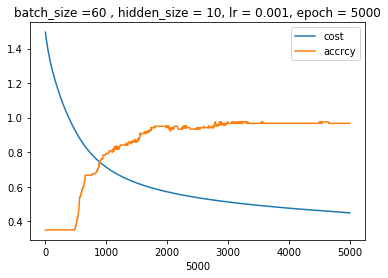

Training Accuracy:  0.9666666666666667
Test Accuracy:  0.9666666666666667
epoch:  0 cost, accuracy:  1.1689870406408607 0.35
epoch:  1 cost, accuracy:  1.1669515755521433 0.35
epoch:  2 cost, accuracy:  1.1651286014510276 0.35
epoch:  3 cost, accuracy:  1.1638640478907898 0.35
epoch:  4 cost, accuracy:  1.1627729643838045 0.35
epoch:  5 cost, accuracy:  1.1611237490107627 0.35
epoch:  6 cost, accuracy:  1.1598322862851367 0.35
epoch:  7 cost, accuracy:  1.1583516094506892 0.35
epoch:  8 cost, accuracy:  1.1570034157369633 0.35
epoch:  9 cost, accuracy:  1.1554027505224578 0.35
epoch:  10 cost, accuracy:  1.1539276155623184 0.35
epoch:  11 cost, accuracy:  1.1525931604130542 0.35
epoch:  12 cost, accuracy:  1.1514419105810603 0.35
epoch:  13 cost, accuracy:  1.1501008925111853 0.35
epoch:  14 cost, accuracy:  1.1492724965120453 0.35
epoch:  15 cost, accuracy:  1.1493081433919623 0.35
epoch:  16 cost, accuracy:  1.1483759480562126 0.35
epoch:  17 cost, accuracy:  1.147090392485645 0.35
e

epoch:  148 cost, accuracy:  1.0921818516763333 0.39166666666666666
epoch:  149 cost, accuracy:  1.0916870323648236 0.4083333333333333
epoch:  150 cost, accuracy:  1.0915019326911115 0.4083333333333333
epoch:  151 cost, accuracy:  1.0911510054357019 0.4083333333333333
epoch:  152 cost, accuracy:  1.090817148071847 0.4083333333333333
epoch:  153 cost, accuracy:  1.090501787518733 0.4083333333333333
epoch:  154 cost, accuracy:  1.0900641616263769 0.4083333333333333
epoch:  155 cost, accuracy:  1.089631709691192 0.4166666666666667
epoch:  156 cost, accuracy:  1.0892917058214517 0.4166666666666667
epoch:  157 cost, accuracy:  1.0888634802505543 0.4166666666666667
epoch:  158 cost, accuracy:  1.0883208320069746 0.425
epoch:  159 cost, accuracy:  1.087944023835199 0.425
epoch:  160 cost, accuracy:  1.0873756705418445 0.43333333333333335
epoch:  161 cost, accuracy:  1.086984093618458 0.43333333333333335
epoch:  162 cost, accuracy:  1.0862977786662147 0.44166666666666665
epoch:  163 cost, accu

epoch:  292 cost, accuracy:  0.9183703958022924 0.675
epoch:  293 cost, accuracy:  0.9176885437282833 0.675
epoch:  294 cost, accuracy:  0.9169832150868497 0.675
epoch:  295 cost, accuracy:  0.9162483540350249 0.675
epoch:  296 cost, accuracy:  0.915507932074553 0.675
epoch:  297 cost, accuracy:  0.9148693538738784 0.675
epoch:  298 cost, accuracy:  0.9142901329553914 0.675
epoch:  299 cost, accuracy:  0.9136668681313748 0.675
epoch:  300 cost, accuracy:  0.9131312190178156 0.675
epoch:  301 cost, accuracy:  0.9124929223385457 0.675
epoch:  302 cost, accuracy:  0.911935486838377 0.675
epoch:  303 cost, accuracy:  0.9111746323543976 0.675
epoch:  304 cost, accuracy:  0.9106157375284474 0.675
epoch:  305 cost, accuracy:  0.9100379852894811 0.675
epoch:  306 cost, accuracy:  0.909523062078698 0.675
epoch:  307 cost, accuracy:  0.9089607886266726 0.675
epoch:  308 cost, accuracy:  0.9084735150093262 0.675
epoch:  309 cost, accuracy:  0.9079983996176689 0.675
epoch:  310 cost, accuracy:  0.

epoch:  439 cost, accuracy:  0.8410330532744307 0.6833333333333333
epoch:  440 cost, accuracy:  0.8406143513318632 0.6833333333333333
epoch:  441 cost, accuracy:  0.8400373868198756 0.6833333333333333
epoch:  442 cost, accuracy:  0.8395787948307432 0.6833333333333333
epoch:  443 cost, accuracy:  0.8391035898972253 0.6916666666666667
epoch:  444 cost, accuracy:  0.838670534295853 0.6916666666666667
epoch:  445 cost, accuracy:  0.8382130302029016 0.675
epoch:  446 cost, accuracy:  0.8377723610711189 0.6833333333333333
epoch:  447 cost, accuracy:  0.8372392274600069 0.6833333333333333
epoch:  448 cost, accuracy:  0.8368730047370581 0.675
epoch:  449 cost, accuracy:  0.8364986656959842 0.6833333333333333
epoch:  450 cost, accuracy:  0.8360442045830185 0.675
epoch:  451 cost, accuracy:  0.8355164749049478 0.675
epoch:  452 cost, accuracy:  0.8351681356425503 0.6833333333333333
epoch:  453 cost, accuracy:  0.8346426304975745 0.6833333333333333
epoch:  454 cost, accuracy:  0.8342023391406764 

epoch:  573 cost, accuracy:  0.7843410258285395 0.725
epoch:  574 cost, accuracy:  0.7839502725712623 0.725
epoch:  575 cost, accuracy:  0.7835609567776903 0.725
epoch:  576 cost, accuracy:  0.7832134122339719 0.725
epoch:  577 cost, accuracy:  0.7828314693816429 0.725
epoch:  578 cost, accuracy:  0.7824550063230379 0.725
epoch:  579 cost, accuracy:  0.7820712997597734 0.725
epoch:  580 cost, accuracy:  0.7816642579402964 0.725
epoch:  581 cost, accuracy:  0.7812908000649218 0.725
epoch:  582 cost, accuracy:  0.7809014763268872 0.725
epoch:  583 cost, accuracy:  0.7804862903735497 0.725
epoch:  584 cost, accuracy:  0.7800688183743684 0.7333333333333333
epoch:  585 cost, accuracy:  0.7797219681719747 0.7333333333333333
epoch:  586 cost, accuracy:  0.7793410097334023 0.7416666666666667
epoch:  587 cost, accuracy:  0.7789483721987775 0.75
epoch:  588 cost, accuracy:  0.7786439494569596 0.7583333333333333
epoch:  589 cost, accuracy:  0.7782956982183896 0.7583333333333333
epoch:  590 cost, 

epoch:  701 cost, accuracy:  0.7385263901282654 0.7833333333333333
epoch:  702 cost, accuracy:  0.7382234235489936 0.7833333333333333
epoch:  703 cost, accuracy:  0.7379313361002011 0.7833333333333333
epoch:  704 cost, accuracy:  0.7375623998840816 0.7833333333333333
epoch:  705 cost, accuracy:  0.7372204738852327 0.7833333333333333
epoch:  706 cost, accuracy:  0.7368953552414884 0.7833333333333333
epoch:  707 cost, accuracy:  0.7365457132948908 0.7833333333333333
epoch:  708 cost, accuracy:  0.7362378542805638 0.7833333333333333
epoch:  709 cost, accuracy:  0.7358993922908391 0.7833333333333333
epoch:  710 cost, accuracy:  0.7355154810393668 0.7833333333333333
epoch:  711 cost, accuracy:  0.735200031187433 0.7833333333333333
epoch:  712 cost, accuracy:  0.7348394332424764 0.7833333333333333
epoch:  713 cost, accuracy:  0.7344987086213607 0.7833333333333333
epoch:  714 cost, accuracy:  0.7341358851133608 0.7666666666666667
epoch:  715 cost, accuracy:  0.733764870853016 0.75833333333333

epoch:  827 cost, accuracy:  0.700236012734841 0.7666666666666667
epoch:  828 cost, accuracy:  0.6999449312628997 0.7666666666666667
epoch:  829 cost, accuracy:  0.699681951727576 0.7583333333333333
epoch:  830 cost, accuracy:  0.6994077932537713 0.7583333333333333
epoch:  831 cost, accuracy:  0.6991294071715423 0.7583333333333333
epoch:  832 cost, accuracy:  0.698860042202993 0.7583333333333333
epoch:  833 cost, accuracy:  0.698606012078034 0.7583333333333333
epoch:  834 cost, accuracy:  0.6983185699242829 0.7583333333333333
epoch:  835 cost, accuracy:  0.6980861172211337 0.7583333333333333
epoch:  836 cost, accuracy:  0.6977755019424078 0.7583333333333333
epoch:  837 cost, accuracy:  0.697491511922434 0.7583333333333333
epoch:  838 cost, accuracy:  0.6972055095430204 0.7583333333333333
epoch:  839 cost, accuracy:  0.6969253823891616 0.7583333333333333
epoch:  840 cost, accuracy:  0.6966530948426609 0.7583333333333333
epoch:  841 cost, accuracy:  0.6963865783613569 0.7583333333333333


epoch:  951 cost, accuracy:  0.6687444374931812 0.7833333333333333
epoch:  952 cost, accuracy:  0.668518887527162 0.7833333333333333
epoch:  953 cost, accuracy:  0.6683004841985074 0.7833333333333333
epoch:  954 cost, accuracy:  0.6680687177719522 0.7833333333333333
epoch:  955 cost, accuracy:  0.6678511583272797 0.7833333333333333
epoch:  956 cost, accuracy:  0.6676111225357702 0.7833333333333333
epoch:  957 cost, accuracy:  0.6673839344961408 0.7833333333333333
epoch:  958 cost, accuracy:  0.6671332852591138 0.7833333333333333
epoch:  959 cost, accuracy:  0.6668870215328293 0.7833333333333333
epoch:  960 cost, accuracy:  0.6666617949881917 0.7833333333333333
epoch:  961 cost, accuracy:  0.6664239371802145 0.7833333333333333
epoch:  962 cost, accuracy:  0.6662002395280917 0.7833333333333333
epoch:  963 cost, accuracy:  0.6659744422036605 0.7833333333333333
epoch:  964 cost, accuracy:  0.665752922865376 0.7833333333333333
epoch:  965 cost, accuracy:  0.6655288706446587 0.78333333333333

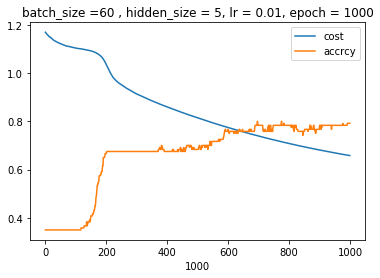

Training Accuracy:  0.7916666666666666
Test Accuracy:  0.8666666666666667
epoch:  0 cost, accuracy:  1.482901328132423 0.325
epoch:  1 cost, accuracy:  1.4512143262058363 0.325
epoch:  2 cost, accuracy:  1.4258091919322666 0.325
epoch:  3 cost, accuracy:  1.399125776610588 0.325
epoch:  4 cost, accuracy:  1.3798919195677881 0.325
epoch:  5 cost, accuracy:  1.3574133735797533 0.325
epoch:  6 cost, accuracy:  1.340347792756279 0.325
epoch:  7 cost, accuracy:  1.326492318079623 0.325
epoch:  8 cost, accuracy:  1.3097659956068364 0.325
epoch:  9 cost, accuracy:  1.2978278919123478 0.325
epoch:  10 cost, accuracy:  1.2896103349400498 0.325
epoch:  11 cost, accuracy:  1.2814789250800125 0.325
epoch:  12 cost, accuracy:  1.2733936438559286 0.325
epoch:  13 cost, accuracy:  1.2646280598201587 0.3333333333333333
epoch:  14 cost, accuracy:  1.25748864393886 0.36666666666666664
epoch:  15 cost, accuracy:  1.2473200516258867 0.4083333333333333
epoch:  16 cost, accuracy:  1.2404468536677966 0.475
e

epoch:  151 cost, accuracy:  0.9129976571598016 0.675
epoch:  152 cost, accuracy:  0.9119055759745756 0.675
epoch:  153 cost, accuracy:  0.9107634472732481 0.675
epoch:  154 cost, accuracy:  0.9095644414613154 0.675
epoch:  155 cost, accuracy:  0.9082426446744225 0.675
epoch:  156 cost, accuracy:  0.906725564138376 0.675
epoch:  157 cost, accuracy:  0.9051161273148332 0.675
epoch:  158 cost, accuracy:  0.9034625441572762 0.675
epoch:  159 cost, accuracy:  0.9022326412369492 0.675
epoch:  160 cost, accuracy:  0.9007842624728019 0.675
epoch:  161 cost, accuracy:  0.8994019791800353 0.675
epoch:  162 cost, accuracy:  0.8979826478654327 0.675
epoch:  163 cost, accuracy:  0.8966147774959276 0.675
epoch:  164 cost, accuracy:  0.895403106133048 0.675
epoch:  165 cost, accuracy:  0.8942413816246574 0.675
epoch:  166 cost, accuracy:  0.8928603768443542 0.675
epoch:  167 cost, accuracy:  0.8917620679858925 0.675
epoch:  168 cost, accuracy:  0.8905985259709343 0.675
epoch:  169 cost, accuracy:  0

epoch:  300 cost, accuracy:  0.7655644337094126 0.6916666666666667
epoch:  301 cost, accuracy:  0.7647756807394673 0.6916666666666667
epoch:  302 cost, accuracy:  0.7639912185543098 0.6916666666666667
epoch:  303 cost, accuracy:  0.7632040317978076 0.6916666666666667
epoch:  304 cost, accuracy:  0.7625049094408406 0.6916666666666667
epoch:  305 cost, accuracy:  0.7617045737212483 0.6916666666666667
epoch:  306 cost, accuracy:  0.7609148263453392 0.6916666666666667
epoch:  307 cost, accuracy:  0.760166762981097 0.6916666666666667
epoch:  308 cost, accuracy:  0.7594027540531845 0.6916666666666667
epoch:  309 cost, accuracy:  0.7586365749385255 0.6916666666666667
epoch:  310 cost, accuracy:  0.7578999144462597 0.6916666666666667
epoch:  311 cost, accuracy:  0.7571888604431751 0.6916666666666667
epoch:  312 cost, accuracy:  0.7564126871606344 0.6916666666666667
epoch:  313 cost, accuracy:  0.7556672397780562 0.6916666666666667
epoch:  314 cost, accuracy:  0.7549186760481423 0.6916666666666

epoch:  428 cost, accuracy:  0.6797627640891897 0.7833333333333333
epoch:  429 cost, accuracy:  0.6791534679844606 0.7833333333333333
epoch:  430 cost, accuracy:  0.678569254040707 0.8
epoch:  431 cost, accuracy:  0.6779820801839155 0.7916666666666666
epoch:  432 cost, accuracy:  0.6774233031137527 0.8
epoch:  433 cost, accuracy:  0.6769271936737248 0.8083333333333333
epoch:  434 cost, accuracy:  0.6762635574531923 0.8
epoch:  435 cost, accuracy:  0.6757021669326011 0.8
epoch:  436 cost, accuracy:  0.6751898364940164 0.8166666666666667
epoch:  437 cost, accuracy:  0.6745175544412315 0.8
epoch:  438 cost, accuracy:  0.6739531764133955 0.8083333333333333
epoch:  439 cost, accuracy:  0.6733220088842359 0.8
epoch:  440 cost, accuracy:  0.6727321427216434 0.8
epoch:  441 cost, accuracy:  0.672191817882369 0.8
epoch:  442 cost, accuracy:  0.671665157044536 0.8083333333333333
epoch:  443 cost, accuracy:  0.6711112783862793 0.8083333333333333
epoch:  444 cost, accuracy:  0.6706604094951383 0.8

epoch:  564 cost, accuracy:  0.6110106618618512 0.85
epoch:  565 cost, accuracy:  0.6106449290616932 0.8166666666666667
epoch:  566 cost, accuracy:  0.6102055642634504 0.8166666666666667
epoch:  567 cost, accuracy:  0.609738140913182 0.825
epoch:  568 cost, accuracy:  0.6093617892862161 0.8166666666666667
epoch:  569 cost, accuracy:  0.6088728562129706 0.8333333333333334
epoch:  570 cost, accuracy:  0.6084520568818597 0.875
epoch:  571 cost, accuracy:  0.6080116994831751 0.8833333333333333
epoch:  572 cost, accuracy:  0.607587962216225 0.8666666666666667
epoch:  573 cost, accuracy:  0.6071932554958868 0.8916666666666667
epoch:  574 cost, accuracy:  0.6067983218209464 0.8916666666666667
epoch:  575 cost, accuracy:  0.6063359135589478 0.8833333333333333
epoch:  576 cost, accuracy:  0.6058981853753129 0.8583333333333333
epoch:  577 cost, accuracy:  0.6054756347634637 0.8416666666666667
epoch:  578 cost, accuracy:  0.6050593403094537 0.8333333333333334
epoch:  579 cost, accuracy:  0.604700

epoch:  702 cost, accuracy:  0.5584172847091343 0.9166666666666666
epoch:  703 cost, accuracy:  0.5581725233013576 0.925
epoch:  704 cost, accuracy:  0.5577867658090089 0.925
epoch:  705 cost, accuracy:  0.5573805580266071 0.9166666666666666
epoch:  706 cost, accuracy:  0.5570378496039761 0.9083333333333333
epoch:  707 cost, accuracy:  0.5567258139556245 0.9166666666666666
epoch:  708 cost, accuracy:  0.5563779498198487 0.9083333333333333
epoch:  709 cost, accuracy:  0.5560630007079865 0.9166666666666666
epoch:  710 cost, accuracy:  0.5557594338274201 0.9166666666666666
epoch:  711 cost, accuracy:  0.5554565462724509 0.925
epoch:  712 cost, accuracy:  0.5551237025067769 0.925
epoch:  713 cost, accuracy:  0.5548156193107077 0.925
epoch:  714 cost, accuracy:  0.5544502775374145 0.9166666666666666
epoch:  715 cost, accuracy:  0.5541381343837812 0.925
epoch:  716 cost, accuracy:  0.5537872179604555 0.9166666666666666
epoch:  717 cost, accuracy:  0.5534731257002173 0.9166666666666666
epoch:

epoch:  839 cost, accuracy:  0.5177564730969345 0.9166666666666666
epoch:  840 cost, accuracy:  0.5175377459303303 0.9083333333333333
epoch:  841 cost, accuracy:  0.5171610890766815 0.925
epoch:  842 cost, accuracy:  0.516847517446712 0.925
epoch:  843 cost, accuracy:  0.5165607788220474 0.925
epoch:  844 cost, accuracy:  0.5162348284501458 0.9416666666666667
epoch:  845 cost, accuracy:  0.5160374027320282 0.95
epoch:  846 cost, accuracy:  0.515715878163041 0.95
epoch:  847 cost, accuracy:  0.5154422989323468 0.9416666666666667
epoch:  848 cost, accuracy:  0.5152296392820663 0.925
epoch:  849 cost, accuracy:  0.5150653845400455 0.925
epoch:  850 cost, accuracy:  0.5148970884449154 0.9166666666666666
epoch:  851 cost, accuracy:  0.515043306800001 0.9
epoch:  852 cost, accuracy:  0.5150707089659314 0.8916666666666667
epoch:  853 cost, accuracy:  0.5146070232142314 0.9
epoch:  854 cost, accuracy:  0.5143150228867364 0.9
epoch:  855 cost, accuracy:  0.5140983669347859 0.9
epoch:  856 cost,

epoch:  985 cost, accuracy:  0.4818746450296934 0.9583333333333334
epoch:  986 cost, accuracy:  0.48168650945093944 0.9583333333333334
epoch:  987 cost, accuracy:  0.48142413174119564 0.9583333333333334
epoch:  988 cost, accuracy:  0.4811693424295324 0.95
epoch:  989 cost, accuracy:  0.48095915889260205 0.95
epoch:  990 cost, accuracy:  0.48072280963493436 0.95
epoch:  991 cost, accuracy:  0.48051791512346587 0.95
epoch:  992 cost, accuracy:  0.48025624232922853 0.95
epoch:  993 cost, accuracy:  0.4800637787723632 0.95
epoch:  994 cost, accuracy:  0.4798092244344564 0.95
epoch:  995 cost, accuracy:  0.4795998326276327 0.95
epoch:  996 cost, accuracy:  0.47938781973062455 0.95
epoch:  997 cost, accuracy:  0.4791473036851135 0.95
epoch:  998 cost, accuracy:  0.47894775728096906 0.95
epoch:  999 cost, accuracy:  0.47870228658189157 0.95


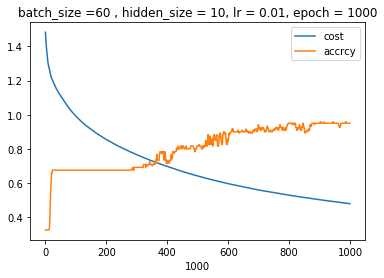

Training Accuracy:  0.95
Test Accuracy:  0.9666666666666667
epoch:  0 cost, accuracy:  1.955082556973682 0.325
epoch:  1 cost, accuracy:  1.907897050484641 0.325
epoch:  2 cost, accuracy:  1.8605765370274832 0.325
epoch:  3 cost, accuracy:  1.820430179321998 0.325
epoch:  4 cost, accuracy:  1.7772646055709556 0.325
epoch:  5 cost, accuracy:  1.7338593746957391 0.325
epoch:  6 cost, accuracy:  1.697500948187344 0.325
epoch:  7 cost, accuracy:  1.6613415658464628 0.325
epoch:  8 cost, accuracy:  1.6249264075429648 0.325
epoch:  9 cost, accuracy:  1.5919391769801077 0.325
epoch:  10 cost, accuracy:  1.5599653722995408 0.325
epoch:  11 cost, accuracy:  1.5347904950748386 0.325
epoch:  12 cost, accuracy:  1.5101418007802399 0.325
epoch:  13 cost, accuracy:  1.482705640509489 0.325
epoch:  14 cost, accuracy:  1.4575713233122434 0.325
epoch:  15 cost, accuracy:  1.4382501945290709 0.325
epoch:  16 cost, accuracy:  1.4193795982994482 0.325
epoch:  17 cost, accuracy:  1.4014927760405853 0.325
e

epoch:  134 cost, accuracy:  1.0131024128754702 0.575
epoch:  135 cost, accuracy:  1.011455441491629 0.5833333333333334
epoch:  136 cost, accuracy:  1.0096355489099667 0.5833333333333334
epoch:  137 cost, accuracy:  1.0078340522697586 0.5833333333333334
epoch:  138 cost, accuracy:  1.005956460189059 0.5833333333333334
epoch:  139 cost, accuracy:  1.0041869209625736 0.5916666666666667
epoch:  140 cost, accuracy:  1.0024276358086583 0.6
epoch:  141 cost, accuracy:  1.0004847121996279 0.6
epoch:  142 cost, accuracy:  0.9985273012103293 0.6
epoch:  143 cost, accuracy:  0.9965026549754372 0.6
epoch:  144 cost, accuracy:  0.9946173734129444 0.6
epoch:  145 cost, accuracy:  0.9926532090704753 0.6
epoch:  146 cost, accuracy:  0.9907362126391109 0.6
epoch:  147 cost, accuracy:  0.9888171939356061 0.6
epoch:  148 cost, accuracy:  0.9868634961697064 0.6
epoch:  149 cost, accuracy:  0.9848546401826345 0.6
epoch:  150 cost, accuracy:  0.9828098625021627 0.6
epoch:  151 cost, accuracy:  0.9806789434

epoch:  271 cost, accuracy:  0.7702763772073903 0.7666666666666667
epoch:  272 cost, accuracy:  0.7691239056693807 0.7583333333333333
epoch:  273 cost, accuracy:  0.767912156462946 0.7666666666666667
epoch:  274 cost, accuracy:  0.7667032583282566 0.7666666666666667
epoch:  275 cost, accuracy:  0.7655074425268189 0.7666666666666667
epoch:  276 cost, accuracy:  0.7643482631949526 0.7666666666666667
epoch:  277 cost, accuracy:  0.763174097390288 0.7666666666666667
epoch:  278 cost, accuracy:  0.7620285870489037 0.7583333333333333
epoch:  279 cost, accuracy:  0.7609076131157252 0.75
epoch:  280 cost, accuracy:  0.7597506822296768 0.75
epoch:  281 cost, accuracy:  0.7585103346474918 0.7583333333333333
epoch:  282 cost, accuracy:  0.757351454106376 0.7666666666666667
epoch:  283 cost, accuracy:  0.7562219369164694 0.7666666666666667
epoch:  284 cost, accuracy:  0.755103819441823 0.7666666666666667
epoch:  285 cost, accuracy:  0.7540020558301699 0.7583333333333333
epoch:  286 cost, accuracy:

epoch:  400 cost, accuracy:  0.6552289220792178 0.825
epoch:  401 cost, accuracy:  0.6545192960651326 0.825
epoch:  402 cost, accuracy:  0.653927264137369 0.8166666666666667
epoch:  403 cost, accuracy:  0.6532293255527055 0.8166666666666667
epoch:  404 cost, accuracy:  0.6525463150324204 0.825
epoch:  405 cost, accuracy:  0.6518424164132065 0.825
epoch:  406 cost, accuracy:  0.6512033497180331 0.8166666666666667
epoch:  407 cost, accuracy:  0.6506147497301384 0.8166666666666667
epoch:  408 cost, accuracy:  0.6498713823365578 0.8166666666666667
epoch:  409 cost, accuracy:  0.6492487398127378 0.8166666666666667
epoch:  410 cost, accuracy:  0.6485932490314548 0.8166666666666667
epoch:  411 cost, accuracy:  0.6479231779319764 0.8166666666666667
epoch:  412 cost, accuracy:  0.6472401676103332 0.8333333333333334
epoch:  413 cost, accuracy:  0.6465949124887127 0.8333333333333334
epoch:  414 cost, accuracy:  0.6459881855968419 0.8416666666666667
epoch:  415 cost, accuracy:  0.6452996585243314 

epoch:  526 cost, accuracy:  0.5842788496120065 0.8166666666666667
epoch:  527 cost, accuracy:  0.583992423700408 0.8166666666666667
epoch:  528 cost, accuracy:  0.5835444150314244 0.8166666666666667
epoch:  529 cost, accuracy:  0.5831671891230134 0.8166666666666667
epoch:  530 cost, accuracy:  0.5825711607880533 0.8166666666666667
epoch:  531 cost, accuracy:  0.5820464228959302 0.8166666666666667
epoch:  532 cost, accuracy:  0.5816000682286602 0.8166666666666667
epoch:  533 cost, accuracy:  0.5811187344533475 0.8166666666666667
epoch:  534 cost, accuracy:  0.5807790841844006 0.8166666666666667
epoch:  535 cost, accuracy:  0.5803482758948298 0.8166666666666667
epoch:  536 cost, accuracy:  0.5799993505653607 0.8166666666666667
epoch:  537 cost, accuracy:  0.5794782155034714 0.8166666666666667
epoch:  538 cost, accuracy:  0.5789627277452053 0.8166666666666667
epoch:  539 cost, accuracy:  0.578452910825812 0.8166666666666667
epoch:  540 cost, accuracy:  0.5780107166510752 0.81666666666666

epoch:  650 cost, accuracy:  0.5354290904796595 0.8833333333333333
epoch:  651 cost, accuracy:  0.5351060423279547 0.8916666666666667
epoch:  652 cost, accuracy:  0.5347812787791132 0.8833333333333333
epoch:  653 cost, accuracy:  0.534453067248022 0.8833333333333333
epoch:  654 cost, accuracy:  0.5341198331533286 0.8833333333333333
epoch:  655 cost, accuracy:  0.5337841440897898 0.8833333333333333
epoch:  656 cost, accuracy:  0.5334539005240369 0.8833333333333333
epoch:  657 cost, accuracy:  0.5331078177195107 0.8833333333333333
epoch:  658 cost, accuracy:  0.5327973413713883 0.875
epoch:  659 cost, accuracy:  0.5324626940651377 0.8833333333333333
epoch:  660 cost, accuracy:  0.5321429843847656 0.8833333333333333
epoch:  661 cost, accuracy:  0.5318248067398144 0.8833333333333333
epoch:  662 cost, accuracy:  0.5315061565397955 0.8833333333333333
epoch:  663 cost, accuracy:  0.5311956117311202 0.8833333333333333
epoch:  664 cost, accuracy:  0.5308878389476501 0.875
epoch:  665 cost, accu

epoch:  781 cost, accuracy:  0.4978494358318508 0.9
epoch:  782 cost, accuracy:  0.4976239047957223 0.8916666666666667
epoch:  783 cost, accuracy:  0.4973630661450296 0.9
epoch:  784 cost, accuracy:  0.4971004959490906 0.8916666666666667
epoch:  785 cost, accuracy:  0.4968275896727043 0.9
epoch:  786 cost, accuracy:  0.49659182138677854 0.9
epoch:  787 cost, accuracy:  0.4963489754186547 0.9
epoch:  788 cost, accuracy:  0.4961058823164869 0.9
epoch:  789 cost, accuracy:  0.4958543000643592 0.9
epoch:  790 cost, accuracy:  0.4956156480169781 0.9
epoch:  791 cost, accuracy:  0.4953601220249747 0.9
epoch:  792 cost, accuracy:  0.49511572686715677 0.9
epoch:  793 cost, accuracy:  0.4948643094898902 0.9083333333333333
epoch:  794 cost, accuracy:  0.4946146797634167 0.9083333333333333
epoch:  795 cost, accuracy:  0.494364952985643 0.925
epoch:  796 cost, accuracy:  0.4941134852811508 0.925
epoch:  797 cost, accuracy:  0.4938704869989409 0.925
epoch:  798 cost, accuracy:  0.4936215118425202 0

epoch:  928 cost, accuracy:  0.4655652553770195 0.925
epoch:  929 cost, accuracy:  0.46536200720641757 0.925
epoch:  930 cost, accuracy:  0.4651660183526308 0.925
epoch:  931 cost, accuracy:  0.46497134245010574 0.925
epoch:  932 cost, accuracy:  0.46477789043900797 0.925
epoch:  933 cost, accuracy:  0.4646506511065373 0.925
epoch:  934 cost, accuracy:  0.464386197789864 0.925
epoch:  935 cost, accuracy:  0.4641992535538884 0.925
epoch:  936 cost, accuracy:  0.46400555839490437 0.925
epoch:  937 cost, accuracy:  0.4638151975598442 0.925
epoch:  938 cost, accuracy:  0.46367522151136964 0.925
epoch:  939 cost, accuracy:  0.4634893954120871 0.925
epoch:  940 cost, accuracy:  0.4633107874062985 0.925
epoch:  941 cost, accuracy:  0.4631120935285241 0.925
epoch:  942 cost, accuracy:  0.46288760963373765 0.9166666666666666
epoch:  943 cost, accuracy:  0.46270412054440413 0.9166666666666666
epoch:  944 cost, accuracy:  0.46255891313276604 0.925
epoch:  945 cost, accuracy:  0.46233671637901647 

epoch:  1068 cost, accuracy:  0.44080822255040947 0.925
epoch:  1069 cost, accuracy:  0.44064608219452805 0.9333333333333333
epoch:  1070 cost, accuracy:  0.44049355692729 0.9333333333333333
epoch:  1071 cost, accuracy:  0.44035909031173404 0.925
epoch:  1072 cost, accuracy:  0.44020200892837097 0.925
epoch:  1073 cost, accuracy:  0.44005642150075197 0.925
epoch:  1074 cost, accuracy:  0.43987627714881555 0.925
epoch:  1075 cost, accuracy:  0.43973906825440967 0.925
epoch:  1076 cost, accuracy:  0.4395740567107912 0.925
epoch:  1077 cost, accuracy:  0.43941600218365295 0.925
epoch:  1078 cost, accuracy:  0.43927193201244996 0.9166666666666666
epoch:  1079 cost, accuracy:  0.43910581032686846 0.9166666666666666
epoch:  1080 cost, accuracy:  0.43892981065802605 0.925
epoch:  1081 cost, accuracy:  0.4388180719065111 0.925
epoch:  1082 cost, accuracy:  0.43862227915966534 0.9166666666666666
epoch:  1083 cost, accuracy:  0.4384516243200804 0.925
epoch:  1084 cost, accuracy:  0.4383248952603

epoch:  1201 cost, accuracy:  0.42083373342980246 0.9333333333333333
epoch:  1202 cost, accuracy:  0.42069741856996007 0.9333333333333333
epoch:  1203 cost, accuracy:  0.42062960377284314 0.9333333333333333
epoch:  1204 cost, accuracy:  0.420460343002404 0.9333333333333333
epoch:  1205 cost, accuracy:  0.420370065938424 0.9333333333333333
epoch:  1206 cost, accuracy:  0.4201995876981994 0.9333333333333333
epoch:  1207 cost, accuracy:  0.42008673041613065 0.9333333333333333
epoch:  1208 cost, accuracy:  0.41998070622966766 0.9333333333333333
epoch:  1209 cost, accuracy:  0.41984068319819073 0.9333333333333333
epoch:  1210 cost, accuracy:  0.41989078761623994 0.925
epoch:  1211 cost, accuracy:  0.419654421939845 0.925
epoch:  1212 cost, accuracy:  0.4194405044383662 0.925
epoch:  1213 cost, accuracy:  0.4193088373290861 0.925
epoch:  1214 cost, accuracy:  0.4191168451206213 0.9333333333333333
epoch:  1215 cost, accuracy:  0.4190613501710321 0.925
epoch:  1216 cost, accuracy:  0.418968451

epoch:  1325 cost, accuracy:  0.40416949196561636 0.9333333333333333
epoch:  1326 cost, accuracy:  0.40410346314893897 0.9333333333333333
epoch:  1327 cost, accuracy:  0.40399510893801094 0.9333333333333333
epoch:  1328 cost, accuracy:  0.40386644612047745 0.9333333333333333
epoch:  1329 cost, accuracy:  0.40369856546272803 0.9333333333333333
epoch:  1330 cost, accuracy:  0.40352880801201074 0.9333333333333333
epoch:  1331 cost, accuracy:  0.40338277190908467 0.9333333333333333
epoch:  1332 cost, accuracy:  0.4032932853516966 0.9333333333333333
epoch:  1333 cost, accuracy:  0.40308967929979206 0.9333333333333333
epoch:  1334 cost, accuracy:  0.4029590783542625 0.9416666666666667
epoch:  1335 cost, accuracy:  0.4028127559880011 0.9333333333333333
epoch:  1336 cost, accuracy:  0.4026907669712942 0.9416666666666667
epoch:  1337 cost, accuracy:  0.40253532972762024 0.9333333333333333
epoch:  1338 cost, accuracy:  0.40241051258370397 0.925
epoch:  1339 cost, accuracy:  0.40227390875941477 0

epoch:  1458 cost, accuracy:  0.38765921477007625 0.9333333333333333
epoch:  1459 cost, accuracy:  0.38754592923821074 0.9333333333333333
epoch:  1460 cost, accuracy:  0.38742515094823454 0.9333333333333333
epoch:  1461 cost, accuracy:  0.38735499987509986 0.9416666666666667
epoch:  1462 cost, accuracy:  0.3872162883374249 0.9333333333333333
epoch:  1463 cost, accuracy:  0.38709745473704127 0.9333333333333333
epoch:  1464 cost, accuracy:  0.3869967080749967 0.9416666666666667
epoch:  1465 cost, accuracy:  0.3869971147419156 0.9416666666666667
epoch:  1466 cost, accuracy:  0.3868004397870861 0.9416666666666667
epoch:  1467 cost, accuracy:  0.3865897604888377 0.9333333333333333
epoch:  1468 cost, accuracy:  0.38646731735980094 0.925
epoch:  1469 cost, accuracy:  0.3863514101026135 0.925
epoch:  1470 cost, accuracy:  0.38627146262728673 0.9333333333333333
epoch:  1471 cost, accuracy:  0.38610090964280747 0.925
epoch:  1472 cost, accuracy:  0.38597934667774775 0.925
epoch:  1473 cost, accu

epoch:  1582 cost, accuracy:  0.3735636149419294 0.9416666666666667
epoch:  1583 cost, accuracy:  0.37347660615510514 0.9416666666666667
epoch:  1584 cost, accuracy:  0.37365009664668924 0.9333333333333333
epoch:  1585 cost, accuracy:  0.37341732302014324 0.9416666666666667
epoch:  1586 cost, accuracy:  0.37303087416787817 0.9416666666666667
epoch:  1587 cost, accuracy:  0.3728336091082844 0.9333333333333333
epoch:  1588 cost, accuracy:  0.37268217708401974 0.9333333333333333
epoch:  1589 cost, accuracy:  0.37258604332941 0.9333333333333333
epoch:  1590 cost, accuracy:  0.37252863888268567 0.9333333333333333
epoch:  1591 cost, accuracy:  0.37241677279153734 0.9333333333333333
epoch:  1592 cost, accuracy:  0.37233911535106007 0.9416666666666667
epoch:  1593 cost, accuracy:  0.37233136882974294 0.9416666666666667
epoch:  1594 cost, accuracy:  0.3722612395255613 0.9416666666666667
epoch:  1595 cost, accuracy:  0.37209148546907955 0.9416666666666667
epoch:  1596 cost, accuracy:  0.37205818

epoch:  1852 cost, accuracy:  0.3446328158930224 0.95
epoch:  1853 cost, accuracy:  0.3444749747130056 0.95
epoch:  1854 cost, accuracy:  0.3443370828041908 0.95
epoch:  1855 cost, accuracy:  0.3442516626800233 0.95
epoch:  1856 cost, accuracy:  0.3441249878806871 0.95
epoch:  1857 cost, accuracy:  0.3441908993484566 0.95
epoch:  1858 cost, accuracy:  0.3442144503825301 0.9416666666666667
epoch:  1859 cost, accuracy:  0.3439732211503047 0.95
epoch:  1860 cost, accuracy:  0.3438232754541239 0.95
epoch:  1861 cost, accuracy:  0.34386354498087907 0.95
epoch:  1862 cost, accuracy:  0.34375783670073273 0.9583333333333334
epoch:  1863 cost, accuracy:  0.34356390645119206 0.95
epoch:  1864 cost, accuracy:  0.3435045352171609 0.95
epoch:  1865 cost, accuracy:  0.3432703666068149 0.95
epoch:  1866 cost, accuracy:  0.3431984495193846 0.95
epoch:  1867 cost, accuracy:  0.343143001556329 0.95
epoch:  1868 cost, accuracy:  0.34298907585916727 0.95
epoch:  1869 cost, accuracy:  0.34282410202982927 0

epoch:  2000 cost, accuracy:  0.3299573098386778 0.95
epoch:  2001 cost, accuracy:  0.32978553908007263 0.95
epoch:  2002 cost, accuracy:  0.3296881939505489 0.95
epoch:  2003 cost, accuracy:  0.32959909498219386 0.95
epoch:  2004 cost, accuracy:  0.3296004684680728 0.95
epoch:  2005 cost, accuracy:  0.32942103075608364 0.95
epoch:  2006 cost, accuracy:  0.32935355745138906 0.95
epoch:  2007 cost, accuracy:  0.3292007341330183 0.95
epoch:  2008 cost, accuracy:  0.3291449426208069 0.95
epoch:  2009 cost, accuracy:  0.3290649997326996 0.95
epoch:  2010 cost, accuracy:  0.3289917849831604 0.95
epoch:  2011 cost, accuracy:  0.32880932547835756 0.95
epoch:  2012 cost, accuracy:  0.3287181238166267 0.95
epoch:  2013 cost, accuracy:  0.32860871566956745 0.95
epoch:  2014 cost, accuracy:  0.328518651666345 0.95
epoch:  2015 cost, accuracy:  0.3284227597238332 0.95
epoch:  2016 cost, accuracy:  0.3283342936230659 0.95
epoch:  2017 cost, accuracy:  0.32823614014971203 0.95
epoch:  2018 cost, acc

epoch:  2148 cost, accuracy:  0.3163475087871614 0.95
epoch:  2149 cost, accuracy:  0.31610890588201424 0.95
epoch:  2150 cost, accuracy:  0.3159975208544316 0.95
epoch:  2151 cost, accuracy:  0.3158769246035074 0.95
epoch:  2152 cost, accuracy:  0.3158439991513437 0.95
epoch:  2153 cost, accuracy:  0.3156567508880302 0.95
epoch:  2154 cost, accuracy:  0.3155799955045885 0.95
epoch:  2155 cost, accuracy:  0.3155598943335575 0.95
epoch:  2156 cost, accuracy:  0.3156311911202142 0.95
epoch:  2157 cost, accuracy:  0.3154733125902208 0.95
epoch:  2158 cost, accuracy:  0.3153201229822503 0.95
epoch:  2159 cost, accuracy:  0.31525352889652836 0.95
epoch:  2160 cost, accuracy:  0.3150776340279228 0.95
epoch:  2161 cost, accuracy:  0.3149462530682934 0.95
epoch:  2162 cost, accuracy:  0.31486715375861013 0.95
epoch:  2163 cost, accuracy:  0.31479925780054724 0.95
epoch:  2164 cost, accuracy:  0.31475424654339307 0.95
epoch:  2165 cost, accuracy:  0.31470167683328687 0.95
epoch:  2166 cost, acc

epoch:  2299 cost, accuracy:  0.30271143707005355 0.95
epoch:  2300 cost, accuracy:  0.30261984967775085 0.95
epoch:  2301 cost, accuracy:  0.3025254369620022 0.95
epoch:  2302 cost, accuracy:  0.30246547274118724 0.95
epoch:  2303 cost, accuracy:  0.3023986239780148 0.95
epoch:  2304 cost, accuracy:  0.3023090135020624 0.95
epoch:  2305 cost, accuracy:  0.30220240506101786 0.95
epoch:  2306 cost, accuracy:  0.30212320306283813 0.95
epoch:  2307 cost, accuracy:  0.3020410922866989 0.95
epoch:  2308 cost, accuracy:  0.3019509943465019 0.95
epoch:  2309 cost, accuracy:  0.30191249369483236 0.95
epoch:  2310 cost, accuracy:  0.3018804932293118 0.95
epoch:  2311 cost, accuracy:  0.30167954884810205 0.95
epoch:  2312 cost, accuracy:  0.301572294946083 0.95
epoch:  2313 cost, accuracy:  0.30149282259952326 0.95
epoch:  2314 cost, accuracy:  0.3014109263801255 0.95
epoch:  2315 cost, accuracy:  0.30135251089188814 0.95
epoch:  2316 cost, accuracy:  0.3013772484082597 0.95
epoch:  2317 cost, a

epoch:  2450 cost, accuracy:  0.2898184543293573 0.95
epoch:  2451 cost, accuracy:  0.28970741777245124 0.95
epoch:  2452 cost, accuracy:  0.2896392353512358 0.95
epoch:  2453 cost, accuracy:  0.2895467528116047 0.95
epoch:  2454 cost, accuracy:  0.2894637297858002 0.95
epoch:  2455 cost, accuracy:  0.2893935463339812 0.95
epoch:  2456 cost, accuracy:  0.28947900303800544 0.95
epoch:  2457 cost, accuracy:  0.2892509289013327 0.95
epoch:  2458 cost, accuracy:  0.28914828546673793 0.95
epoch:  2459 cost, accuracy:  0.289049064935256 0.95
epoch:  2460 cost, accuracy:  0.2889677883227227 0.95
epoch:  2461 cost, accuracy:  0.28887418621554545 0.95
epoch:  2462 cost, accuracy:  0.2888039256707332 0.95
epoch:  2463 cost, accuracy:  0.28872855172607675 0.95
epoch:  2464 cost, accuracy:  0.2886548556717559 0.95
epoch:  2465 cost, accuracy:  0.2885885990117082 0.95
epoch:  2466 cost, accuracy:  0.2885028327476106 0.95
epoch:  2467 cost, accuracy:  0.2884799838504474 0.95
epoch:  2468 cost, accur

epoch:  2601 cost, accuracy:  0.27768485990979147 0.95
epoch:  2602 cost, accuracy:  0.2774999501652851 0.95
epoch:  2603 cost, accuracy:  0.2774284015744494 0.95
epoch:  2604 cost, accuracy:  0.27736262677074597 0.95
epoch:  2605 cost, accuracy:  0.2773372233352689 0.95
epoch:  2606 cost, accuracy:  0.27723604611974567 0.95
epoch:  2607 cost, accuracy:  0.27714413187023307 0.95
epoch:  2608 cost, accuracy:  0.27712945921424653 0.95
epoch:  2609 cost, accuracy:  0.2769939448925894 0.95
epoch:  2610 cost, accuracy:  0.2769088751125725 0.95
epoch:  2611 cost, accuracy:  0.2768958902680689 0.95
epoch:  2612 cost, accuracy:  0.2767496027946475 0.95
epoch:  2613 cost, accuracy:  0.2766613643487206 0.95
epoch:  2614 cost, accuracy:  0.276574061344147 0.95
epoch:  2615 cost, accuracy:  0.27651330885564024 0.95
epoch:  2616 cost, accuracy:  0.2765071591190675 0.95
epoch:  2617 cost, accuracy:  0.27634222803344444 0.95
epoch:  2618 cost, accuracy:  0.2763027022999843 0.95
epoch:  2619 cost, acc

epoch:  2752 cost, accuracy:  0.265949432704446 0.95
epoch:  2753 cost, accuracy:  0.2658756395656529 0.95
epoch:  2754 cost, accuracy:  0.26580161299219474 0.95
epoch:  2755 cost, accuracy:  0.2657527325658978 0.95
epoch:  2756 cost, accuracy:  0.26570788274294427 0.95
epoch:  2757 cost, accuracy:  0.2655754725751633 0.95
epoch:  2758 cost, accuracy:  0.265490401474996 0.95
epoch:  2759 cost, accuracy:  0.2654301658976117 0.95
epoch:  2760 cost, accuracy:  0.2653553470801347 0.95
epoch:  2761 cost, accuracy:  0.2652838051884171 0.95
epoch:  2762 cost, accuracy:  0.265234742241985 0.95
epoch:  2763 cost, accuracy:  0.26519783471835634 0.95
epoch:  2764 cost, accuracy:  0.2650559208073282 0.95
epoch:  2765 cost, accuracy:  0.265085129004885 0.95
epoch:  2766 cost, accuracy:  0.26506864725124113 0.95
epoch:  2767 cost, accuracy:  0.26485701457325656 0.95
epoch:  2768 cost, accuracy:  0.2648082209347731 0.95
epoch:  2769 cost, accuracy:  0.2648867031259432 0.95
epoch:  2770 cost, accuracy

epoch:  2903 cost, accuracy:  0.25545200856296757 0.95
epoch:  2904 cost, accuracy:  0.2556088698364269 0.95
epoch:  2905 cost, accuracy:  0.25557195801502725 0.95
epoch:  2906 cost, accuracy:  0.2551450906243415 0.95
epoch:  2907 cost, accuracy:  0.25525329936031815 0.95
epoch:  2908 cost, accuracy:  0.2550323073098922 0.95
epoch:  2909 cost, accuracy:  0.2547710107395799 0.95
epoch:  2910 cost, accuracy:  0.2546237199223191 0.95
epoch:  2911 cost, accuracy:  0.2545713088424414 0.95
epoch:  2912 cost, accuracy:  0.25461757454525985 0.95
epoch:  2913 cost, accuracy:  0.25446846538978546 0.95
epoch:  2914 cost, accuracy:  0.25445209245461736 0.95
epoch:  2915 cost, accuracy:  0.25437642019086854 0.95
epoch:  2916 cost, accuracy:  0.25423599090045107 0.95
epoch:  2917 cost, accuracy:  0.2541473789871226 0.95
epoch:  2918 cost, accuracy:  0.2541520306428938 0.95
epoch:  2919 cost, accuracy:  0.2540251211957215 0.95
epoch:  2920 cost, accuracy:  0.25391374479098666 0.95
epoch:  2921 cost, 

epoch:  3044 cost, accuracy:  0.24550418890472156 0.95
epoch:  3045 cost, accuracy:  0.24533061200385686 0.95
epoch:  3046 cost, accuracy:  0.2455392813762763 0.9583333333333334
epoch:  3047 cost, accuracy:  0.24555301076640298 0.9583333333333334
epoch:  3048 cost, accuracy:  0.24533342261081995 0.9583333333333334
epoch:  3049 cost, accuracy:  0.24506361034744029 0.95
epoch:  3050 cost, accuracy:  0.24510129532971867 0.95
epoch:  3051 cost, accuracy:  0.2449858531634842 0.95
epoch:  3052 cost, accuracy:  0.24502902697851095 0.9583333333333334
epoch:  3053 cost, accuracy:  0.24492174615332818 0.9583333333333334
epoch:  3054 cost, accuracy:  0.2447173305936451 0.95
epoch:  3055 cost, accuracy:  0.2446312863140062 0.95
epoch:  3056 cost, accuracy:  0.24456655447790593 0.95
epoch:  3057 cost, accuracy:  0.2445336573425343 0.95
epoch:  3058 cost, accuracy:  0.2446357661080449 0.9583333333333334
epoch:  3059 cost, accuracy:  0.244656152839676 0.9583333333333334
epoch:  3060 cost, accuracy:  

epoch:  3187 cost, accuracy:  0.23607035856901207 0.95
epoch:  3188 cost, accuracy:  0.23601439858430637 0.95
epoch:  3189 cost, accuracy:  0.2359379762308005 0.95
epoch:  3190 cost, accuracy:  0.23587825957863784 0.95
epoch:  3191 cost, accuracy:  0.2358893820432969 0.9583333333333334
epoch:  3192 cost, accuracy:  0.23603661497400144 0.9583333333333334
epoch:  3193 cost, accuracy:  0.2359957066174327 0.9583333333333334
epoch:  3194 cost, accuracy:  0.236112878452629 0.9583333333333334
epoch:  3195 cost, accuracy:  0.23609290724607537 0.9583333333333334
epoch:  3196 cost, accuracy:  0.23594412265543246 0.9583333333333334
epoch:  3197 cost, accuracy:  0.23583908215808236 0.9583333333333334
epoch:  3198 cost, accuracy:  0.2354469182917987 0.9583333333333334
epoch:  3199 cost, accuracy:  0.23538441964947993 0.9583333333333334
epoch:  3200 cost, accuracy:  0.2353345935287132 0.9583333333333334
epoch:  3201 cost, accuracy:  0.23522954234436694 0.95
epoch:  3202 cost, accuracy:  0.2351609366

epoch:  3462 cost, accuracy:  0.21983971053151857 0.95
epoch:  3463 cost, accuracy:  0.21977556992306913 0.9583333333333334
epoch:  3464 cost, accuracy:  0.219747832392707 0.95
epoch:  3465 cost, accuracy:  0.21975779080819577 0.95
epoch:  3466 cost, accuracy:  0.21968718617045127 0.95
epoch:  3467 cost, accuracy:  0.21972152991058744 0.95
epoch:  3468 cost, accuracy:  0.2195264511239195 0.95
epoch:  3469 cost, accuracy:  0.2194354076983058 0.9583333333333334
epoch:  3470 cost, accuracy:  0.2195787409476931 0.9583333333333334
epoch:  3471 cost, accuracy:  0.21963251237019515 0.9583333333333334
epoch:  3472 cost, accuracy:  0.21967535334988594 0.9583333333333334
epoch:  3473 cost, accuracy:  0.21970097779208503 0.9583333333333334
epoch:  3474 cost, accuracy:  0.21987889604073435 0.9583333333333334
epoch:  3475 cost, accuracy:  0.21957158108970293 0.9583333333333334
epoch:  3476 cost, accuracy:  0.2194976715504041 0.9583333333333334
epoch:  3477 cost, accuracy:  0.21920894558409895 0.958

epoch:  3588 cost, accuracy:  0.21300326304001793 0.9583333333333334
epoch:  3589 cost, accuracy:  0.21300240887261968 0.9583333333333334
epoch:  3590 cost, accuracy:  0.21323420768859513 0.9583333333333334
epoch:  3591 cost, accuracy:  0.21340654045786323 0.9583333333333334
epoch:  3592 cost, accuracy:  0.21307945664305447 0.9583333333333334
epoch:  3593 cost, accuracy:  0.21292396473524816 0.9583333333333334
epoch:  3594 cost, accuracy:  0.21290977502726172 0.9583333333333334
epoch:  3595 cost, accuracy:  0.21275491632890742 0.9583333333333334
epoch:  3596 cost, accuracy:  0.21274459409505792 0.9583333333333334
epoch:  3597 cost, accuracy:  0.21258511525047336 0.9583333333333334
epoch:  3598 cost, accuracy:  0.21251606483558524 0.9583333333333334
epoch:  3599 cost, accuracy:  0.21263035753372078 0.9583333333333334
epoch:  3600 cost, accuracy:  0.2125931377902935 0.9583333333333334
epoch:  3601 cost, accuracy:  0.2127168887640808 0.9583333333333334
epoch:  3602 cost, accuracy:  0.2130

epoch:  3712 cost, accuracy:  0.2066183668800416 0.9583333333333334
epoch:  3713 cost, accuracy:  0.20656314779849924 0.9583333333333334
epoch:  3714 cost, accuracy:  0.20653130224610897 0.9583333333333334
epoch:  3715 cost, accuracy:  0.20648184751568344 0.9583333333333334
epoch:  3716 cost, accuracy:  0.20640884173265783 0.9583333333333334
epoch:  3717 cost, accuracy:  0.20635113279078254 0.9583333333333334
epoch:  3718 cost, accuracy:  0.20636503917569377 0.9583333333333334
epoch:  3719 cost, accuracy:  0.2064641182722683 0.9583333333333334
epoch:  3720 cost, accuracy:  0.2062192531065636 0.9583333333333334
epoch:  3721 cost, accuracy:  0.20617326453650694 0.9583333333333334
epoch:  3722 cost, accuracy:  0.2061220303311155 0.9583333333333334
epoch:  3723 cost, accuracy:  0.2060505174239693 0.9583333333333334
epoch:  3724 cost, accuracy:  0.20600781965198395 0.9583333333333334
epoch:  3725 cost, accuracy:  0.20600430118286214 0.9583333333333334
epoch:  3726 cost, accuracy:  0.2059630

epoch:  3832 cost, accuracy:  0.2007841194685238 0.9583333333333334
epoch:  3833 cost, accuracy:  0.20075683087415128 0.9583333333333334
epoch:  3834 cost, accuracy:  0.2008405464589746 0.9583333333333334
epoch:  3835 cost, accuracy:  0.20101693899943693 0.9583333333333334
epoch:  3836 cost, accuracy:  0.20102483700484802 0.9583333333333334
epoch:  3837 cost, accuracy:  0.20133544783590746 0.9583333333333334
epoch:  3838 cost, accuracy:  0.20105437035274262 0.9583333333333334
epoch:  3839 cost, accuracy:  0.20081433319201641 0.9583333333333334
epoch:  3840 cost, accuracy:  0.20049209757549036 0.9583333333333334
epoch:  3841 cost, accuracy:  0.20071223465761612 0.9583333333333334
epoch:  3842 cost, accuracy:  0.20066730716136097 0.9583333333333334
epoch:  3843 cost, accuracy:  0.20073430689536456 0.9583333333333334
epoch:  3844 cost, accuracy:  0.20049954763788846 0.9583333333333334
epoch:  3845 cost, accuracy:  0.20024274448848706 0.9583333333333334
epoch:  3846 cost, accuracy:  0.2001

epoch:  3952 cost, accuracy:  0.19523590215747716 0.9583333333333334
epoch:  3953 cost, accuracy:  0.19517583601067734 0.9583333333333334
epoch:  3954 cost, accuracy:  0.19516189634791725 0.9583333333333334
epoch:  3955 cost, accuracy:  0.19509168664058082 0.9583333333333334
epoch:  3956 cost, accuracy:  0.1950374703803218 0.9583333333333334
epoch:  3957 cost, accuracy:  0.19499275567890242 0.9583333333333334
epoch:  3958 cost, accuracy:  0.19497743590087815 0.9583333333333334
epoch:  3959 cost, accuracy:  0.19491247435610085 0.9583333333333334
epoch:  3960 cost, accuracy:  0.194872735297183 0.9583333333333334
epoch:  3961 cost, accuracy:  0.19487601004888724 0.9583333333333334
epoch:  3962 cost, accuracy:  0.19483263684331897 0.9583333333333334
epoch:  3963 cost, accuracy:  0.19470575174571567 0.9583333333333334
epoch:  3964 cost, accuracy:  0.1946615009576341 0.9583333333333334
epoch:  3965 cost, accuracy:  0.1947731223080788 0.9583333333333334
epoch:  3966 cost, accuracy:  0.1946327

epoch:  4073 cost, accuracy:  0.18999347146020087 0.9583333333333334
epoch:  4074 cost, accuracy:  0.19003306659614594 0.9583333333333334
epoch:  4075 cost, accuracy:  0.19007891621692172 0.9583333333333334
epoch:  4076 cost, accuracy:  0.18979547742739775 0.9583333333333334
epoch:  4077 cost, accuracy:  0.18974356670859713 0.9583333333333334
epoch:  4078 cost, accuracy:  0.18971383699830938 0.9583333333333334
epoch:  4079 cost, accuracy:  0.18964601310916465 0.9583333333333334
epoch:  4080 cost, accuracy:  0.1896143815734748 0.9583333333333334
epoch:  4081 cost, accuracy:  0.18955136606246265 0.9583333333333334
epoch:  4082 cost, accuracy:  0.18963896248828507 0.9583333333333334
epoch:  4083 cost, accuracy:  0.18946536865172436 0.9583333333333334
epoch:  4084 cost, accuracy:  0.18944067499068093 0.9583333333333334
epoch:  4085 cost, accuracy:  0.1894059648141666 0.9583333333333334
epoch:  4086 cost, accuracy:  0.1894640426586755 0.9583333333333334
epoch:  4087 cost, accuracy:  0.18933

epoch:  4193 cost, accuracy:  0.18494311096236415 0.9583333333333334
epoch:  4194 cost, accuracy:  0.18492185633608024 0.9583333333333334
epoch:  4195 cost, accuracy:  0.18499600868372335 0.9583333333333334
epoch:  4196 cost, accuracy:  0.18501133210571694 0.9583333333333334
epoch:  4197 cost, accuracy:  0.18482145178110893 0.9583333333333334
epoch:  4198 cost, accuracy:  0.18491339115856764 0.9583333333333334
epoch:  4199 cost, accuracy:  0.1847474503230351 0.9583333333333334
epoch:  4200 cost, accuracy:  0.18466245416732882 0.9583333333333334
epoch:  4201 cost, accuracy:  0.1846317047075105 0.9583333333333334
epoch:  4202 cost, accuracy:  0.18457962512713372 0.9583333333333334
epoch:  4203 cost, accuracy:  0.1845391618901677 0.9583333333333334
epoch:  4204 cost, accuracy:  0.1846107538727293 0.9583333333333334
epoch:  4205 cost, accuracy:  0.18484057575213503 0.9583333333333334
epoch:  4206 cost, accuracy:  0.18459187047046383 0.9583333333333334
epoch:  4207 cost, accuracy:  0.184668

epoch:  4314 cost, accuracy:  0.18018394405243973 0.9583333333333334
epoch:  4315 cost, accuracy:  0.18017082697931736 0.9583333333333334
epoch:  4316 cost, accuracy:  0.18014678250537047 0.9583333333333334
epoch:  4317 cost, accuracy:  0.18037542620075425 0.9583333333333334
epoch:  4318 cost, accuracy:  0.18027812146008398 0.9583333333333334
epoch:  4319 cost, accuracy:  0.1801339795965849 0.9583333333333334
epoch:  4320 cost, accuracy:  0.18000204115679888 0.9583333333333334
epoch:  4321 cost, accuracy:  0.17995024486491673 0.9583333333333334
epoch:  4322 cost, accuracy:  0.18000880427992333 0.9583333333333334
epoch:  4323 cost, accuracy:  0.17993326488922737 0.9583333333333334
epoch:  4324 cost, accuracy:  0.17991931894552077 0.9583333333333334
epoch:  4325 cost, accuracy:  0.17989106193161283 0.9583333333333334
epoch:  4326 cost, accuracy:  0.1799042560091104 0.9583333333333334
epoch:  4327 cost, accuracy:  0.1801222111049884 0.9583333333333334
epoch:  4328 cost, accuracy:  0.17998

epoch:  4434 cost, accuracy:  0.1767440803922295 0.9583333333333334
epoch:  4435 cost, accuracy:  0.17624287683743933 0.9583333333333334
epoch:  4436 cost, accuracy:  0.17573520257855424 0.9583333333333334
epoch:  4437 cost, accuracy:  0.17565302122943105 0.9583333333333334
epoch:  4438 cost, accuracy:  0.17567285954176814 0.9583333333333334
epoch:  4439 cost, accuracy:  0.17558268533049695 0.9583333333333334
epoch:  4440 cost, accuracy:  0.1757783119315163 0.9583333333333334
epoch:  4441 cost, accuracy:  0.17555134411810158 0.9583333333333334
epoch:  4442 cost, accuracy:  0.175459055211026 0.9583333333333334
epoch:  4443 cost, accuracy:  0.1754429078692252 0.9583333333333334
epoch:  4444 cost, accuracy:  0.1753696798727749 0.9583333333333334
epoch:  4445 cost, accuracy:  0.17534142055544882 0.9583333333333334
epoch:  4446 cost, accuracy:  0.17544807330144305 0.9583333333333334
epoch:  4447 cost, accuracy:  0.1755606804617408 0.9583333333333334
epoch:  4448 cost, accuracy:  0.175561404

epoch:  4554 cost, accuracy:  0.17149722715626717 0.9583333333333334
epoch:  4555 cost, accuracy:  0.17144283037099758 0.9583333333333334
epoch:  4556 cost, accuracy:  0.17144629070983666 0.9583333333333334
epoch:  4557 cost, accuracy:  0.17154513807010463 0.9583333333333334
epoch:  4558 cost, accuracy:  0.171455971030405 0.9583333333333334
epoch:  4559 cost, accuracy:  0.17133104092574433 0.9583333333333334
epoch:  4560 cost, accuracy:  0.17138394934698362 0.9583333333333334
epoch:  4561 cost, accuracy:  0.17123737180134077 0.9583333333333334
epoch:  4562 cost, accuracy:  0.17123076511028454 0.9583333333333334
epoch:  4563 cost, accuracy:  0.17170362838264358 0.9583333333333334
epoch:  4564 cost, accuracy:  0.17144265314956506 0.9583333333333334
epoch:  4565 cost, accuracy:  0.17132973093759407 0.9583333333333334
epoch:  4566 cost, accuracy:  0.17115892217404968 0.9583333333333334
epoch:  4567 cost, accuracy:  0.17105512241231463 0.9583333333333334
epoch:  4568 cost, accuracy:  0.1710

epoch:  4675 cost, accuracy:  0.16757523474833802 0.9583333333333334
epoch:  4676 cost, accuracy:  0.16788463863817235 0.9583333333333334
epoch:  4677 cost, accuracy:  0.16769131409949445 0.9583333333333334
epoch:  4678 cost, accuracy:  0.16770832102777308 0.9583333333333334
epoch:  4679 cost, accuracy:  0.16744623835672462 0.9583333333333334
epoch:  4680 cost, accuracy:  0.1674845006120029 0.9583333333333334
epoch:  4681 cost, accuracy:  0.16775339955655966 0.9583333333333334
epoch:  4682 cost, accuracy:  0.16737621692671428 0.9583333333333334
epoch:  4683 cost, accuracy:  0.16726035363101482 0.9583333333333334
epoch:  4684 cost, accuracy:  0.16753711331795612 0.9583333333333334
epoch:  4685 cost, accuracy:  0.16724523357294885 0.9583333333333334
epoch:  4686 cost, accuracy:  0.16720386675622106 0.9583333333333334
epoch:  4687 cost, accuracy:  0.1674229217996984 0.9583333333333334
epoch:  4688 cost, accuracy:  0.16774571987994 0.9583333333333334
epoch:  4689 cost, accuracy:  0.1674067

epoch:  4795 cost, accuracy:  0.16372300346439678 0.9583333333333334
epoch:  4796 cost, accuracy:  0.16372741111354774 0.9583333333333334
epoch:  4797 cost, accuracy:  0.16359619535753386 0.9583333333333334
epoch:  4798 cost, accuracy:  0.16369276812546632 0.9583333333333334
epoch:  4799 cost, accuracy:  0.1635401933142271 0.9583333333333334
epoch:  4800 cost, accuracy:  0.1635301821827575 0.9583333333333334
epoch:  4801 cost, accuracy:  0.1634855482619569 0.9583333333333334
epoch:  4802 cost, accuracy:  0.16356775062924075 0.9583333333333334
epoch:  4803 cost, accuracy:  0.16355499254748906 0.9583333333333334
epoch:  4804 cost, accuracy:  0.16341615565575804 0.9583333333333334
epoch:  4805 cost, accuracy:  0.16341249762012058 0.9583333333333334
epoch:  4806 cost, accuracy:  0.16342752427166013 0.9583333333333334
epoch:  4807 cost, accuracy:  0.16330190301996203 0.9583333333333334
epoch:  4808 cost, accuracy:  0.16327727859563043 0.9583333333333334
epoch:  4809 cost, accuracy:  0.16324

epoch:  4916 cost, accuracy:  0.16041867539783478 0.9583333333333334
epoch:  4917 cost, accuracy:  0.16060142731057797 0.9583333333333334
epoch:  4918 cost, accuracy:  0.16068688204375992 0.9583333333333334
epoch:  4919 cost, accuracy:  0.16044060064939256 0.9583333333333334
epoch:  4920 cost, accuracy:  0.1601782611268727 0.9583333333333334
epoch:  4921 cost, accuracy:  0.1599618934042433 0.9583333333333334
epoch:  4922 cost, accuracy:  0.1599068034529596 0.9583333333333334
epoch:  4923 cost, accuracy:  0.16025282932839466 0.9583333333333334
epoch:  4924 cost, accuracy:  0.15989472986422376 0.9583333333333334
epoch:  4925 cost, accuracy:  0.15986310236476903 0.9583333333333334
epoch:  4926 cost, accuracy:  0.15990294195677096 0.9583333333333334
epoch:  4927 cost, accuracy:  0.15988553457515345 0.9583333333333334
epoch:  4928 cost, accuracy:  0.1597719902947444 0.9583333333333334
epoch:  4929 cost, accuracy:  0.16001922100212648 0.9583333333333334
epoch:  4930 cost, accuracy:  0.159893

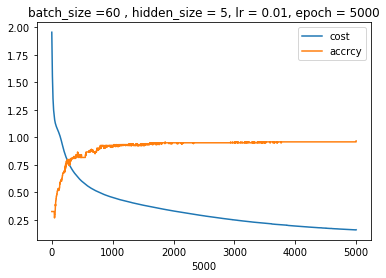

Training Accuracy:  0.9583333333333334
Test Accuracy:  1.0
epoch:  0 cost, accuracy:  2.649384927334927 0.325
epoch:  1 cost, accuracy:  2.585290380507193 0.325
epoch:  2 cost, accuracy:  2.5313520897157775 0.325
epoch:  3 cost, accuracy:  2.467599062115879 0.325
epoch:  4 cost, accuracy:  2.409843229106312 0.325
epoch:  5 cost, accuracy:  2.359556162468785 0.325
epoch:  6 cost, accuracy:  2.294039712822107 0.325
epoch:  7 cost, accuracy:  2.2431649297244407 0.325
epoch:  8 cost, accuracy:  2.1895760164423477 0.325
epoch:  9 cost, accuracy:  2.1435802279690526 0.325
epoch:  10 cost, accuracy:  2.0925187450529656 0.325
epoch:  11 cost, accuracy:  2.0468669231410703 0.325
epoch:  12 cost, accuracy:  2.004297231017082 0.325
epoch:  13 cost, accuracy:  1.961550895626617 0.325
epoch:  14 cost, accuracy:  1.9213575375809362 0.325
epoch:  15 cost, accuracy:  1.8869649614094839 0.325
epoch:  16 cost, accuracy:  1.8492250026298531 0.325
epoch:  17 cost, accuracy:  1.8123559613319375 0.325
epoch

epoch:  145 cost, accuracy:  0.9485956168744603 0.6666666666666666
epoch:  146 cost, accuracy:  0.9472989044289339 0.6666666666666666
epoch:  147 cost, accuracy:  0.946174146503613 0.6666666666666666
epoch:  148 cost, accuracy:  0.9455278187487571 0.6666666666666666
epoch:  149 cost, accuracy:  0.9444664261927721 0.6666666666666666
epoch:  150 cost, accuracy:  0.9433810229107816 0.6666666666666666
epoch:  151 cost, accuracy:  0.9422624967022666 0.6666666666666666
epoch:  152 cost, accuracy:  0.940962633785621 0.6666666666666666
epoch:  153 cost, accuracy:  0.939777200684362 0.6666666666666666
epoch:  154 cost, accuracy:  0.938767611875528 0.6666666666666666
epoch:  155 cost, accuracy:  0.9378922146347327 0.6666666666666666
epoch:  156 cost, accuracy:  0.9370021272737453 0.6666666666666666
epoch:  157 cost, accuracy:  0.935968815106586 0.6666666666666666
epoch:  158 cost, accuracy:  0.9349975561491122 0.6666666666666666
epoch:  159 cost, accuracy:  0.9342339621018539 0.6666666666666666


epoch:  276 cost, accuracy:  0.842211395515679 0.7583333333333333
epoch:  277 cost, accuracy:  0.8414390061183514 0.7333333333333333
epoch:  278 cost, accuracy:  0.8406623596682282 0.7583333333333333
epoch:  279 cost, accuracy:  0.8398783582157889 0.7583333333333333
epoch:  280 cost, accuracy:  0.8391180363406832 0.775
epoch:  281 cost, accuracy:  0.8383892133514581 0.7666666666666667
epoch:  282 cost, accuracy:  0.8377170077557473 0.75
epoch:  283 cost, accuracy:  0.8369403267876104 0.75
epoch:  284 cost, accuracy:  0.8361241075189557 0.7666666666666667
epoch:  285 cost, accuracy:  0.8353731789338636 0.7666666666666667
epoch:  286 cost, accuracy:  0.8346267602382095 0.7666666666666667
epoch:  287 cost, accuracy:  0.8338989393653108 0.7666666666666667
epoch:  288 cost, accuracy:  0.8330783962976287 0.775
epoch:  289 cost, accuracy:  0.8322747315728983 0.7833333333333333
epoch:  290 cost, accuracy:  0.8315140879939753 0.775
epoch:  291 cost, accuracy:  0.830783693842636 0.76666666666666

epoch:  405 cost, accuracy:  0.7422893942070193 0.8166666666666667
epoch:  406 cost, accuracy:  0.7415516416234537 0.8166666666666667
epoch:  407 cost, accuracy:  0.7408353495208845 0.8083333333333333
epoch:  408 cost, accuracy:  0.740021160056889 0.8083333333333333
epoch:  409 cost, accuracy:  0.7392076674706568 0.8166666666666667
epoch:  410 cost, accuracy:  0.7384328949717159 0.8083333333333333
epoch:  411 cost, accuracy:  0.7375616792962506 0.8166666666666667
epoch:  412 cost, accuracy:  0.7367233159331541 0.8166666666666667
epoch:  413 cost, accuracy:  0.7359498691440618 0.8166666666666667
epoch:  414 cost, accuracy:  0.7350818787073258 0.8333333333333334
epoch:  415 cost, accuracy:  0.7343911472999447 0.8166666666666667
epoch:  416 cost, accuracy:  0.7336170821211659 0.8166666666666667
epoch:  417 cost, accuracy:  0.7328060840993785 0.825
epoch:  418 cost, accuracy:  0.7318908576555254 0.8333333333333334
epoch:  419 cost, accuracy:  0.7311360888727912 0.825
epoch:  420 cost, accu

epoch:  534 cost, accuracy:  0.6549660273717606 0.8416666666666667
epoch:  535 cost, accuracy:  0.6543737718751762 0.85
epoch:  536 cost, accuracy:  0.6537920900619237 0.8416666666666667
epoch:  537 cost, accuracy:  0.6531947025165004 0.8416666666666667
epoch:  538 cost, accuracy:  0.6526487949480438 0.8416666666666667
epoch:  539 cost, accuracy:  0.652153540921009 0.8583333333333333
epoch:  540 cost, accuracy:  0.6516194074897163 0.8583333333333333
epoch:  541 cost, accuracy:  0.651102740316449 0.8583333333333333
epoch:  542 cost, accuracy:  0.6505590538200712 0.85
epoch:  543 cost, accuracy:  0.6499666606689275 0.8416666666666667
epoch:  544 cost, accuracy:  0.6494325687381172 0.8416666666666667
epoch:  545 cost, accuracy:  0.6488689105808086 0.8583333333333333
epoch:  546 cost, accuracy:  0.6483015985178592 0.8583333333333333
epoch:  547 cost, accuracy:  0.647750814491543 0.8583333333333333
epoch:  548 cost, accuracy:  0.647237712527144 0.8666666666666667
epoch:  549 cost, accuracy:

epoch:  666 cost, accuracy:  0.5880314215756685 0.8666666666666667
epoch:  667 cost, accuracy:  0.5875635042953259 0.875
epoch:  668 cost, accuracy:  0.5871170644836546 0.8666666666666667
epoch:  669 cost, accuracy:  0.5866697752347719 0.875
epoch:  670 cost, accuracy:  0.5862329446671126 0.8583333333333333
epoch:  671 cost, accuracy:  0.5857768361114152 0.8583333333333333
epoch:  672 cost, accuracy:  0.5853268659924797 0.8666666666666667
epoch:  673 cost, accuracy:  0.5848734681394225 0.8666666666666667
epoch:  674 cost, accuracy:  0.5844682049129586 0.85
epoch:  675 cost, accuracy:  0.5839952769297775 0.875
epoch:  676 cost, accuracy:  0.5835675623064209 0.875
epoch:  677 cost, accuracy:  0.5831335638711533 0.875
epoch:  678 cost, accuracy:  0.5826719207348963 0.875
epoch:  679 cost, accuracy:  0.5822422128923047 0.875
epoch:  680 cost, accuracy:  0.5818082079410813 0.8666666666666667
epoch:  681 cost, accuracy:  0.5813810183372102 0.8666666666666667
epoch:  682 cost, accuracy:  0.58

epoch:  802 cost, accuracy:  0.5328379066613509 0.8833333333333333
epoch:  803 cost, accuracy:  0.5324826211997219 0.875
epoch:  804 cost, accuracy:  0.5321274968778922 0.875
epoch:  805 cost, accuracy:  0.5317465593476477 0.875
epoch:  806 cost, accuracy:  0.5314252936441822 0.8833333333333333
epoch:  807 cost, accuracy:  0.5311413889779308 0.875
epoch:  808 cost, accuracy:  0.5307858474029624 0.875
epoch:  809 cost, accuracy:  0.5306066924858545 0.8916666666666667
epoch:  810 cost, accuracy:  0.5301929912304688 0.8916666666666667
epoch:  811 cost, accuracy:  0.5298373142286155 0.8916666666666667
epoch:  812 cost, accuracy:  0.529417104068729 0.8916666666666667
epoch:  813 cost, accuracy:  0.5290728670352595 0.8916666666666667
epoch:  814 cost, accuracy:  0.5287308779004054 0.8916666666666667
epoch:  815 cost, accuracy:  0.5285358136881081 0.8916666666666667
epoch:  816 cost, accuracy:  0.5281230088372997 0.8916666666666667
epoch:  817 cost, accuracy:  0.5276704137669802 0.89166666666

epoch:  930 cost, accuracy:  0.4909509305366234 0.9083333333333333
epoch:  931 cost, accuracy:  0.4906019561904358 0.9
epoch:  932 cost, accuracy:  0.49034296165382035 0.9083333333333333
epoch:  933 cost, accuracy:  0.49010080792144245 0.9083333333333333
epoch:  934 cost, accuracy:  0.48979627053206276 0.9083333333333333
epoch:  935 cost, accuracy:  0.48942029688963445 0.9
epoch:  936 cost, accuracy:  0.4891792501441434 0.9083333333333333
epoch:  937 cost, accuracy:  0.4888407316296298 0.9
epoch:  938 cost, accuracy:  0.4885826836267891 0.9083333333333333
epoch:  939 cost, accuracy:  0.4884142132819888 0.9
epoch:  940 cost, accuracy:  0.4881190926104594 0.9
epoch:  941 cost, accuracy:  0.4877587926339414 0.9083333333333333
epoch:  942 cost, accuracy:  0.48749709879285485 0.9083333333333333
epoch:  943 cost, accuracy:  0.4872088496946592 0.9083333333333333
epoch:  944 cost, accuracy:  0.4871713920179939 0.9
epoch:  945 cost, accuracy:  0.4869466921407914 0.9
epoch:  946 cost, accuracy: 

epoch:  1064 cost, accuracy:  0.4549118507777791 0.9
epoch:  1065 cost, accuracy:  0.4546505624087452 0.9083333333333333
epoch:  1066 cost, accuracy:  0.4544036411943797 0.925
epoch:  1067 cost, accuracy:  0.45415246225175987 0.9083333333333333
epoch:  1068 cost, accuracy:  0.45392720861297337 0.9083333333333333
epoch:  1069 cost, accuracy:  0.45377967036919187 0.9
epoch:  1070 cost, accuracy:  0.4535703778318279 0.9
epoch:  1071 cost, accuracy:  0.4532134396143685 0.9
epoch:  1072 cost, accuracy:  0.45298320303806805 0.9
epoch:  1073 cost, accuracy:  0.45277307941658596 0.9
epoch:  1074 cost, accuracy:  0.4525798770136905 0.9
epoch:  1075 cost, accuracy:  0.45239018182092594 0.9
epoch:  1076 cost, accuracy:  0.45217843368729066 0.9
epoch:  1077 cost, accuracy:  0.4519732699426714 0.9
epoch:  1078 cost, accuracy:  0.4516087998839115 0.9
epoch:  1079 cost, accuracy:  0.45127925516005085 0.9083333333333333
epoch:  1080 cost, accuracy:  0.45114705952224204 0.9
epoch:  1081 cost, accuracy:

epoch:  1203 cost, accuracy:  0.42393472937152077 0.925
epoch:  1204 cost, accuracy:  0.42370865432411997 0.925
epoch:  1205 cost, accuracy:  0.42349392998115565 0.925
epoch:  1206 cost, accuracy:  0.4233044587182601 0.925
epoch:  1207 cost, accuracy:  0.4231245639613165 0.925
epoch:  1208 cost, accuracy:  0.42290888237929053 0.925
epoch:  1209 cost, accuracy:  0.4227715624407231 0.925
epoch:  1210 cost, accuracy:  0.42252660668199776 0.925
epoch:  1211 cost, accuracy:  0.4223149856764473 0.9333333333333333
epoch:  1212 cost, accuracy:  0.4221368411737724 0.925
epoch:  1213 cost, accuracy:  0.42197801672601154 0.925
epoch:  1214 cost, accuracy:  0.42172145877657613 0.925
epoch:  1215 cost, accuracy:  0.42153477926202787 0.9333333333333333
epoch:  1216 cost, accuracy:  0.4213344457632363 0.9333333333333333
epoch:  1217 cost, accuracy:  0.4211459014631677 0.9333333333333333
epoch:  1218 cost, accuracy:  0.42108271981960205 0.9333333333333333
epoch:  1219 cost, accuracy:  0.42090936079119

epoch:  1332 cost, accuracy:  0.39947596654969086 0.9333333333333333
epoch:  1333 cost, accuracy:  0.3991196709891867 0.925
epoch:  1334 cost, accuracy:  0.39894443663694573 0.925
epoch:  1335 cost, accuracy:  0.39894163811635674 0.9333333333333333
epoch:  1336 cost, accuracy:  0.3986280760809033 0.925
epoch:  1337 cost, accuracy:  0.39845094656767527 0.925
epoch:  1338 cost, accuracy:  0.3982486814274668 0.925
epoch:  1339 cost, accuracy:  0.39817441378549084 0.9416666666666667
epoch:  1340 cost, accuracy:  0.39817436266104267 0.9333333333333333
epoch:  1341 cost, accuracy:  0.397913473029093 0.9333333333333333
epoch:  1342 cost, accuracy:  0.39771076636418623 0.9333333333333333
epoch:  1343 cost, accuracy:  0.3975642293408673 0.9333333333333333
epoch:  1344 cost, accuracy:  0.39717204783210236 0.925
epoch:  1345 cost, accuracy:  0.39699438071788024 0.925
epoch:  1346 cost, accuracy:  0.3968368520769665 0.925
epoch:  1347 cost, accuracy:  0.3967883783368317 0.9416666666666667
epoch:  

epoch:  1459 cost, accuracy:  0.37796693457071245 0.9416666666666667
epoch:  1460 cost, accuracy:  0.377944772804252 0.9333333333333333
epoch:  1461 cost, accuracy:  0.37785121387323933 0.9333333333333333
epoch:  1462 cost, accuracy:  0.3776093529181693 0.9333333333333333
epoch:  1463 cost, accuracy:  0.37749033035280366 0.9333333333333333
epoch:  1464 cost, accuracy:  0.3771179191334975 0.9416666666666667
epoch:  1465 cost, accuracy:  0.3769611131508603 0.9416666666666667
epoch:  1466 cost, accuracy:  0.3767656345928078 0.9416666666666667
epoch:  1467 cost, accuracy:  0.37663717944095665 0.9416666666666667
epoch:  1468 cost, accuracy:  0.37648525342161515 0.9416666666666667
epoch:  1469 cost, accuracy:  0.3762868219969803 0.9416666666666667
epoch:  1470 cost, accuracy:  0.3762116202769165 0.9416666666666667
epoch:  1471 cost, accuracy:  0.376216910101912 0.9333333333333333
epoch:  1472 cost, accuracy:  0.375995604203336 0.9333333333333333
epoch:  1473 cost, accuracy:  0.37563445180231

epoch:  1580 cost, accuracy:  0.35929647121167213 0.9333333333333333
epoch:  1581 cost, accuracy:  0.3590466413075571 0.9333333333333333
epoch:  1582 cost, accuracy:  0.35893989546378685 0.9416666666666667
epoch:  1583 cost, accuracy:  0.3587445845377264 0.9416666666666667
epoch:  1584 cost, accuracy:  0.3585964651565207 0.9416666666666667
epoch:  1585 cost, accuracy:  0.35846106756737706 0.9416666666666667
epoch:  1586 cost, accuracy:  0.3583043419103535 0.9416666666666667
epoch:  1587 cost, accuracy:  0.35816146345345135 0.9333333333333333
epoch:  1588 cost, accuracy:  0.358081590026628 0.9416666666666667
epoch:  1589 cost, accuracy:  0.35799668997390105 0.9416666666666667
epoch:  1590 cost, accuracy:  0.35772029381506915 0.9416666666666667
epoch:  1591 cost, accuracy:  0.357567072850485 0.9416666666666667
epoch:  1592 cost, accuracy:  0.35745964522662227 0.9416666666666667
epoch:  1593 cost, accuracy:  0.35729581331289434 0.9416666666666667
epoch:  1594 cost, accuracy:  0.3573090143

epoch:  1706 cost, accuracy:  0.3414464152456972 0.9416666666666667
epoch:  1707 cost, accuracy:  0.3413292701228885 0.95
epoch:  1708 cost, accuracy:  0.34128196888655987 0.95
epoch:  1709 cost, accuracy:  0.3410505932363134 0.95
epoch:  1710 cost, accuracy:  0.3409076007488821 0.9416666666666667
epoch:  1711 cost, accuracy:  0.340750442686697 0.9416666666666667
epoch:  1712 cost, accuracy:  0.34063719821961375 0.9416666666666667
epoch:  1713 cost, accuracy:  0.34048953140466554 0.9416666666666667
epoch:  1714 cost, accuracy:  0.3403451892589197 0.9416666666666667
epoch:  1715 cost, accuracy:  0.3402017629629897 0.9416666666666667
epoch:  1716 cost, accuracy:  0.34012414459243806 0.9583333333333334
epoch:  1717 cost, accuracy:  0.33995783849210526 0.9583333333333334
epoch:  1718 cost, accuracy:  0.3398174119989938 0.95
epoch:  1719 cost, accuracy:  0.3397449924660699 0.9583333333333334
epoch:  1720 cost, accuracy:  0.339675741680457 0.95
epoch:  1721 cost, accuracy:  0.339394178172667

epoch:  1840 cost, accuracy:  0.32412243420387654 0.9666666666666667
epoch:  1841 cost, accuracy:  0.3239948983749142 0.9666666666666667
epoch:  1842 cost, accuracy:  0.32380814988652845 0.9583333333333334
epoch:  1843 cost, accuracy:  0.32368626669268513 0.95
epoch:  1844 cost, accuracy:  0.32360047340976966 0.9583333333333334
epoch:  1845 cost, accuracy:  0.32346464852710466 0.9583333333333334
epoch:  1846 cost, accuracy:  0.3233738259879504 0.95
epoch:  1847 cost, accuracy:  0.323188425957601 0.9583333333333334
epoch:  1848 cost, accuracy:  0.3230679214824871 0.9583333333333334
epoch:  1849 cost, accuracy:  0.3230164376035199 0.9666666666666667
epoch:  1850 cost, accuracy:  0.32281273537321553 0.9583333333333334
epoch:  1851 cost, accuracy:  0.32302063432540584 0.9583333333333334
epoch:  1852 cost, accuracy:  0.32265046731278774 0.9666666666666667
epoch:  1853 cost, accuracy:  0.32253800272323313 0.9666666666666667
epoch:  1854 cost, accuracy:  0.32264594963471976 0.9583333333333334

epoch:  1966 cost, accuracy:  0.30999570422876865 0.9333333333333333
epoch:  1967 cost, accuracy:  0.3099532478043699 0.9333333333333333
epoch:  1968 cost, accuracy:  0.3102698104029085 0.925
epoch:  1969 cost, accuracy:  0.3097538374411826 0.9333333333333333
epoch:  1970 cost, accuracy:  0.30903617255526294 0.9416666666666667
epoch:  1971 cost, accuracy:  0.3089414668499447 0.9416666666666667
epoch:  1972 cost, accuracy:  0.3087696035602912 0.9416666666666667
epoch:  1973 cost, accuracy:  0.3082324923665615 0.9583333333333334
epoch:  1974 cost, accuracy:  0.3080877043524499 0.9583333333333334
epoch:  1975 cost, accuracy:  0.3079962821267637 0.9583333333333334
epoch:  1976 cost, accuracy:  0.3078666701908736 0.9583333333333334
epoch:  1977 cost, accuracy:  0.30779139917064907 0.9583333333333334
epoch:  1978 cost, accuracy:  0.30763091028251555 0.9583333333333334
epoch:  1979 cost, accuracy:  0.30752739272063334 0.9583333333333334
epoch:  1980 cost, accuracy:  0.30751983724698456 0.9666

epoch:  2088 cost, accuracy:  0.2955173946993898 0.9583333333333334
epoch:  2089 cost, accuracy:  0.2954310648269587 0.9583333333333334
epoch:  2090 cost, accuracy:  0.2953306499363161 0.9583333333333334
epoch:  2091 cost, accuracy:  0.29521243387714 0.9583333333333334
epoch:  2092 cost, accuracy:  0.29510038848328257 0.9583333333333334
epoch:  2093 cost, accuracy:  0.2950243251479718 0.9583333333333334
epoch:  2094 cost, accuracy:  0.29489113584508075 0.9583333333333334
epoch:  2095 cost, accuracy:  0.29478705272560823 0.9583333333333334
epoch:  2096 cost, accuracy:  0.29476344730845366 0.9583333333333334
epoch:  2097 cost, accuracy:  0.29481427121931686 0.9583333333333334
epoch:  2098 cost, accuracy:  0.2946322113307128 0.9583333333333334
epoch:  2099 cost, accuracy:  0.2943716723840559 0.9583333333333334
epoch:  2100 cost, accuracy:  0.2943341280611675 0.9666666666666667
epoch:  2101 cost, accuracy:  0.2941840830773254 0.9583333333333334
epoch:  2102 cost, accuracy:  0.2940731299699

epoch:  2208 cost, accuracy:  0.2836014916158407 0.9666666666666667
epoch:  2209 cost, accuracy:  0.28367550857939844 0.9666666666666667
epoch:  2210 cost, accuracy:  0.28324530137081416 0.9666666666666667
epoch:  2211 cost, accuracy:  0.28309300255780995 0.9666666666666667
epoch:  2212 cost, accuracy:  0.28304325864540864 0.9666666666666667
epoch:  2213 cost, accuracy:  0.28274346460947236 0.9583333333333334
epoch:  2214 cost, accuracy:  0.28263340011772653 0.9583333333333334
epoch:  2215 cost, accuracy:  0.2825295813657996 0.9583333333333334
epoch:  2216 cost, accuracy:  0.2825251825881582 0.9583333333333334
epoch:  2217 cost, accuracy:  0.2823854117395745 0.9583333333333334
epoch:  2218 cost, accuracy:  0.2823546186070942 0.9583333333333334
epoch:  2219 cost, accuracy:  0.2822458827497721 0.9583333333333334
epoch:  2220 cost, accuracy:  0.28209471263586633 0.9583333333333334
epoch:  2221 cost, accuracy:  0.28201190418018085 0.9583333333333334
epoch:  2222 cost, accuracy:  0.28204939

epoch:  2329 cost, accuracy:  0.2718067161308811 0.9583333333333334
epoch:  2330 cost, accuracy:  0.2716702435891906 0.9583333333333334
epoch:  2331 cost, accuracy:  0.2716645267111593 0.9583333333333334
epoch:  2332 cost, accuracy:  0.271525971006599 0.9583333333333334
epoch:  2333 cost, accuracy:  0.2715082302705097 0.9583333333333334
epoch:  2334 cost, accuracy:  0.27140441445486585 0.9583333333333334
epoch:  2335 cost, accuracy:  0.2712129673416045 0.9583333333333334
epoch:  2336 cost, accuracy:  0.2711102500060008 0.9583333333333334
epoch:  2337 cost, accuracy:  0.27102047196093787 0.9583333333333334
epoch:  2338 cost, accuracy:  0.2709816940871281 0.9583333333333334
epoch:  2339 cost, accuracy:  0.2708683086203269 0.9583333333333334
epoch:  2340 cost, accuracy:  0.27083828232913826 0.9583333333333334
epoch:  2341 cost, accuracy:  0.270695542154717 0.9583333333333334
epoch:  2342 cost, accuracy:  0.2707660788710714 0.9583333333333334
epoch:  2343 cost, accuracy:  0.270968626685982

epoch:  2449 cost, accuracy:  0.26108216903687936 0.9666666666666667
epoch:  2450 cost, accuracy:  0.2611613780080783 0.9666666666666667
epoch:  2451 cost, accuracy:  0.26091372388275036 0.9583333333333334
epoch:  2452 cost, accuracy:  0.2607909531190254 0.9583333333333334
epoch:  2453 cost, accuracy:  0.2607464590850138 0.9666666666666667
epoch:  2454 cost, accuracy:  0.2606117783864239 0.9583333333333334
epoch:  2455 cost, accuracy:  0.2605658617874939 0.9666666666666667
epoch:  2456 cost, accuracy:  0.26048989518224225 0.9666666666666667
epoch:  2457 cost, accuracy:  0.26033167581211797 0.9583333333333334
epoch:  2458 cost, accuracy:  0.2602481627339667 0.9583333333333334
epoch:  2459 cost, accuracy:  0.2601944238613419 0.9583333333333334
epoch:  2460 cost, accuracy:  0.2602252641229017 0.9583333333333334
epoch:  2461 cost, accuracy:  0.2600761467058879 0.9583333333333334
epoch:  2462 cost, accuracy:  0.25998907611758293 0.9583333333333334
epoch:  2463 cost, accuracy:  0.25982635270

epoch:  2570 cost, accuracy:  0.25202791593083246 0.9416666666666667
epoch:  2571 cost, accuracy:  0.252202354758762 0.9333333333333333
epoch:  2572 cost, accuracy:  0.251609086168704 0.9416666666666667
epoch:  2573 cost, accuracy:  0.2514935323989101 0.9416666666666667
epoch:  2574 cost, accuracy:  0.25126625870381286 0.95
epoch:  2575 cost, accuracy:  0.250998738065256 0.9583333333333334
epoch:  2576 cost, accuracy:  0.25124655821238934 0.9416666666666667
epoch:  2577 cost, accuracy:  0.2507689036343856 0.9583333333333334
epoch:  2578 cost, accuracy:  0.25053665645275414 0.9583333333333334
epoch:  2579 cost, accuracy:  0.2506028923345214 0.9583333333333334
epoch:  2580 cost, accuracy:  0.25060549572088164 0.9583333333333334
epoch:  2581 cost, accuracy:  0.2503559743412883 0.9583333333333334
epoch:  2582 cost, accuracy:  0.2504989674869846 0.9583333333333334
epoch:  2583 cost, accuracy:  0.2506133384038345 0.95
epoch:  2584 cost, accuracy:  0.25006049529661484 0.9583333333333334
epoch

epoch:  2690 cost, accuracy:  0.2419909929173274 0.9583333333333334
epoch:  2691 cost, accuracy:  0.24169396132007617 0.9583333333333334
epoch:  2692 cost, accuracy:  0.241704614547797 0.9583333333333334
epoch:  2693 cost, accuracy:  0.24158497521174419 0.9583333333333334
epoch:  2694 cost, accuracy:  0.24151199456344336 0.9583333333333334
epoch:  2695 cost, accuracy:  0.24155746997357883 0.9583333333333334
epoch:  2696 cost, accuracy:  0.24149817991118314 0.9583333333333334
epoch:  2697 cost, accuracy:  0.24126330394851678 0.9583333333333334
epoch:  2698 cost, accuracy:  0.24118896488253463 0.9666666666666667
epoch:  2699 cost, accuracy:  0.24109163163534364 0.9583333333333334
epoch:  2700 cost, accuracy:  0.24107008886319328 0.9666666666666667
epoch:  2701 cost, accuracy:  0.24096914331906202 0.9583333333333334
epoch:  2702 cost, accuracy:  0.2408648745996815 0.9583333333333334
epoch:  2703 cost, accuracy:  0.24079609055715132 0.9583333333333334
epoch:  2704 cost, accuracy:  0.240736

epoch:  2811 cost, accuracy:  0.23320655448118452 0.9666666666666667
epoch:  2812 cost, accuracy:  0.2330771363165583 0.9583333333333334
epoch:  2813 cost, accuracy:  0.23308157540239502 0.9583333333333334
epoch:  2814 cost, accuracy:  0.2331450966165776 0.9583333333333334
epoch:  2815 cost, accuracy:  0.23288994413425684 0.9583333333333334
epoch:  2816 cost, accuracy:  0.23282069292936125 0.9583333333333334
epoch:  2817 cost, accuracy:  0.23277638279819418 0.9583333333333334
epoch:  2818 cost, accuracy:  0.232733459924138 0.9583333333333334
epoch:  2819 cost, accuracy:  0.23277880741843854 0.9583333333333334
epoch:  2820 cost, accuracy:  0.2328016708962928 0.9583333333333334
epoch:  2821 cost, accuracy:  0.23261421164203905 0.9583333333333334
epoch:  2822 cost, accuracy:  0.23239278012684186 0.9583333333333334
epoch:  2823 cost, accuracy:  0.23232595051745009 0.9583333333333334
epoch:  2824 cost, accuracy:  0.23227344451731452 0.9583333333333334
epoch:  2825 cost, accuracy:  0.2324171

epoch:  2931 cost, accuracy:  0.22524223505133645 0.9583333333333334
epoch:  2932 cost, accuracy:  0.22514703991547325 0.9583333333333334
epoch:  2933 cost, accuracy:  0.22492351960192974 0.9583333333333334
epoch:  2934 cost, accuracy:  0.22491314791799683 0.9583333333333334
epoch:  2935 cost, accuracy:  0.2248164917626855 0.9583333333333334
epoch:  2936 cost, accuracy:  0.224735849888924 0.9583333333333334
epoch:  2937 cost, accuracy:  0.2246801060682814 0.9583333333333334
epoch:  2938 cost, accuracy:  0.22461287453078452 0.9666666666666667
epoch:  2939 cost, accuracy:  0.22453915926252688 0.9583333333333334
epoch:  2940 cost, accuracy:  0.22447245414683112 0.9583333333333334
epoch:  2941 cost, accuracy:  0.2245399078118564 0.9666666666666667
epoch:  2942 cost, accuracy:  0.22442346169566244 0.9666666666666667
epoch:  2943 cost, accuracy:  0.22426988702388653 0.9583333333333334
epoch:  2944 cost, accuracy:  0.22421825081008245 0.9583333333333334
epoch:  2945 cost, accuracy:  0.2241550

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [106]:
'''for bch in batch_size:
    for lr in learning_rate:
        for ep in epoch:
            for hlayer in hidden_layer:
                fname = 'batch_size ={} , hidden_size = {}, lr = {}, epoch = {}.txt'.format(bch, hlayer, lr, ep)
                f = open(fname, 'w', encoding = 'utf8')
                
                nn = TwoLayerNeuralNetwork(4, hlayer, 3)
                nn.init_data(X_train, t_train)
                nn.learn(batch = bch, lr = lr, epoch = ep, file = f)
                tr = nn.accuracy(X_train, t_train)
                te = nn.accuracy(X_test, t_test)
                print('Training Accuracy: ', tr)
                print('Test Accuracy: ', te)
                
                f.write('Training Accuracy: {}\n'.format(tr))
                f.write('Test Accuracy: {}'.format(te))
                f.close()'''